In [32]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [33]:
L = 4 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [34]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [35]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [36]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [37]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [38]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [39]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [40]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [41]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [42]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [43]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [44]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -3.56892061e-16]


In [45]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [46]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.021813610948344626+0.0654937284444003j)|2 2 0 1>
(0.04929252873119587-0.14799711513624536j)|2 2 0 0>
(-0.08924567210898571+0.26795342723342835j)|2 1 1 1>
(0.023834515397124754-0.07156134226104617j)|2 1 0 1>
(0.021813610948344848-0.06549372844440084j)|2 1 0 0>
(-0.08924567210899896+0.2679534272334353j)|1 1 1 2>
(0.24514585431868235-0.7360320146005008j)|1 1 1 1>
(-0.08924567210898982+0.2679534272334297j)|1 1 0 1>
(0.021813610948333367-0.0654937284443936j)|1 0 2 2>
(0.02383451539713945-0.0715613422610534j)|1 0 1 2>
(-0.08924567210899896+0.2679534272334342j)|1 0 1 1>
(0.04929252873119739-0.14799711513624572j)|0 0 2 2>
(-0.02181361094833309+0.06549372844439737j)|0 0 1 2>



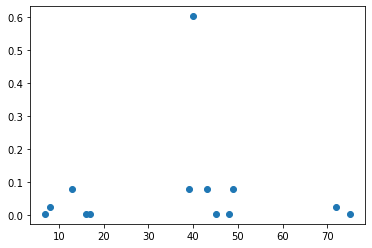

In [47]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [48]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [49]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 0.1*sigma_big_z[k]
    summe += 1.*(sigma_big_p[0]@sigma_big_m[3] + sigma_big_m[0]@sigma_big_p[3])
    summe += 1.*(sigma_big_p[1]@sigma_big_m[2] + sigma_big_m[1]@sigma_big_p[2])



    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [50]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [51]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [52]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 11.8 ms, sys: 3.13 ms, total: 15 ms
Wall time: 12.2 ms


/Users/pavelpopov/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<81x81 sparse matrix of type '<class 'numpy.complex128'>'
	with 108 stored elements in COOrdinate format>

In [53]:
#initial state
string = "2200"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [54]:
def R(i,theta):
    
    if i%14 == 0:
        return(ms_gate_global(theta))

    if i%14 == 1:
        return(ms_gate_global_1(theta))


    if i%14 == 2:
        return(rot_sigma(0,0,1,0,theta))


    if i%14 == 3:
        return(rot_sigma(0,0,2,0,theta))

    
    if i%14 == 4:
        return(rot_sigma(0,1,2,np.pi/2,theta))

    
    if i%14 == 5:
        return(rot_sigma(1,0,1,0,theta))


    if i%14 == 6:
        return(rot_sigma(1,0,2,0,theta))

    
    if i%14 == 7:
        return(rot_sigma(1,1,2,np.pi/2,theta))

    if i%14 == 8:
        return(rot_sigma(2,0,1,0,theta))


    if i%14 == 9:
        return(rot_sigma(2,0,2,0,theta))

    
    if i%14 == 10:
        return(rot_sigma(2,1,2,np.pi/2,theta))

    
    if i%14 == 11:
        return(rot_sigma(3,0,1,0,theta))


    if i%14 == 12:
        return(rot_sigma(3,0,2,0,theta))

    
    if i%14 == 13:
        return(rot_sigma(3,1,2,np.pi/2,theta))
        

def S(i,theta):
    
    if i%14 == 0:
        return(-1j*matrix_part)

    if i%14 == 1:
        return(-1j*matrix_part_1)


    if i%14 == 2:
        return(-1j*sigma(0,0,1,0))

    
    if i%14 == 3:
        return(-1j*sigma(0,0,2,0))

    
    if i%14 == 4:
        return(-1j*sigma(0,1,2,np.pi/2))
     
    if i%14 == 5:
        return(-1j*sigma(1,0,1,0))

    
    if i%14 == 6:
        return(-1j*sigma(1,0,2,0))

    
    if i%14 == 7:
        return(-1j*sigma(1,1,2,np.pi/2))

     
    if i%14 == 8:
        return(-1j*sigma(2,0,1,0))

    
    if i%14 == 9:
        return(-1j*sigma(2,0,2,0))
    

    if i%14 == 10:
        return(-1j*sigma(2,1,2,np.pi/2))
    
     
    if i%14 == 11:
        return(-1j*sigma(3,0,1,0))

    
    if i%14 == 12:
        return(-1j*sigma(3,0,2,0))
    

    if i%14 == 13:
        return(-1j*sigma(3,1,2,np.pi/2))

In [55]:
coeff = 14
stepp = 1500
t_final = 10

In [56]:
expt_value_uu = []
expt_value_vv = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [57]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            #["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p

In [58]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.zeros(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b

        #for i in range(LL+1):
        #    psi_b = (Proj[i]+Proj_0[i])@psi_b
        #norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        #psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        #for k in range(coeff*N):
        #    for i in range(LL+1):
        #        psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
        #    psi_d_s1[k] = psi_d_1[k]/norm_b
        #    psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
        #    psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        #psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.imag(Y+YY)
        result = np.linalg.pinv(X_r,rcond = 1e-8)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi
        return psi

            
    def hamiltonian_evolution(theta):
        return expm(-1j*full_ham_matrix.toarray()*theta)

    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(LL+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.real(np.conj(psi_var)@observable_matrix@psi_var)/norm**2
        
    expt_value_uu.append(expt_value_u)


    

2022-09-21 11:46:05.034650
start 2022-09-21 11:46:05.078810
stop_reduce 2022-09-21 11:46:05.157885
2022-09-21 11:46:05.158706
0
2022-09-21 11:46:05.158748
start 2022-09-21 11:46:05.190021
stop_reduce 2022-09-21 11:46:05.267990
2022-09-21 11:46:05.268921
0.0033333333333333335
2022-09-21 11:46:05.268967
start 2022-09-21 11:46:05.301951
stop_reduce 2022-09-21 11:46:05.376969
2022-09-21 11:46:05.377775
0.0033333333333333335
2022-09-21 11:46:05.377811
start 2022-09-21 11:46:05.408885
stop_reduce 2022-09-21 11:46:05.485812
2022-09-21 11:46:05.486963
0.006666666666666667
2022-09-21 11:46:05.487018
start 2022-09-21 11:46:05.520776
stop_reduce 2022-09-21 11:46:05.600258
2022-09-21 11:46:05.601197
0.006666666666666667
2022-09-21 11:46:05.601264
start 2022-09-21 11:46:05.632300
stop_reduce 2022-09-21 11:46:05.708824
2022-09-21 11:46:05.709770
0.01
2022-09-21 11:46:05.709815
start 2022-09-21 11:46:05.742411
stop_reduce 2022-09-21 11:46:05.816162
2022-09-21 11:46:05.816965
0.01
2022-09-21 11:46:05.

stop_reduce 2022-09-21 11:46:11.491465
2022-09-21 11:46:11.492294
0.09666666666666666
2022-09-21 11:46:11.492336
start 2022-09-21 11:46:11.524831
stop_reduce 2022-09-21 11:46:11.600351
2022-09-21 11:46:11.601173
0.09666666666666666
2022-09-21 11:46:11.601211
start 2022-09-21 11:46:11.632329
stop_reduce 2022-09-21 11:46:11.711827
2022-09-21 11:46:11.712982
0.1
2022-09-21 11:46:11.713030
start 2022-09-21 11:46:11.746261
stop_reduce 2022-09-21 11:46:11.824138
2022-09-21 11:46:11.824911
0.1
2022-09-21 11:46:11.824951
start 2022-09-21 11:46:11.856425
stop_reduce 2022-09-21 11:46:11.936885
2022-09-21 11:46:11.937915
0.10333333333333333
2022-09-21 11:46:11.937962
start 2022-09-21 11:46:11.969862
stop_reduce 2022-09-21 11:46:12.046708
2022-09-21 11:46:12.047462
0.10333333333333333
2022-09-21 11:46:12.047499
start 2022-09-21 11:46:12.079381
stop_reduce 2022-09-21 11:46:12.156872
2022-09-21 11:46:12.157814
0.10666666666666667
2022-09-21 11:46:12.157858
start 2022-09-21 11:46:12.190940
stop_reduc

stop_reduce 2022-09-21 11:46:17.859978
2022-09-21 11:46:17.861060
0.19333333333333322
2022-09-21 11:46:17.861117
start 2022-09-21 11:46:17.895409
stop_reduce 2022-09-21 11:46:17.974604
2022-09-21 11:46:17.975382
0.19333333333333322
2022-09-21 11:46:17.975425
start 2022-09-21 11:46:18.008578
stop_reduce 2022-09-21 11:46:18.088891
2022-09-21 11:46:18.089957
0.19666666666666655
2022-09-21 11:46:18.090085
start 2022-09-21 11:46:18.122427
stop_reduce 2022-09-21 11:46:18.200677
2022-09-21 11:46:18.201606
0.19666666666666655
2022-09-21 11:46:18.201649
start 2022-09-21 11:46:18.233619
stop_reduce 2022-09-21 11:46:18.312158
2022-09-21 11:46:18.313293
0.19999999999999987
2022-09-21 11:46:18.313532
start 2022-09-21 11:46:18.346320
stop_reduce 2022-09-21 11:46:18.427625
2022-09-21 11:46:18.428703
0.19999999999999987
2022-09-21 11:46:18.428755
start 2022-09-21 11:46:18.461616
stop_reduce 2022-09-21 11:46:18.539072
2022-09-21 11:46:18.540020
0.2033333333333332
2022-09-21 11:46:18.540075
start 2022-0

stop_reduce 2022-09-21 11:46:24.306986
2022-09-21 11:46:24.307747
0.28999999999999976
2022-09-21 11:46:24.307784
start 2022-09-21 11:46:24.341545
stop_reduce 2022-09-21 11:46:24.416603
2022-09-21 11:46:24.417271
0.28999999999999976
2022-09-21 11:46:24.417308
start 2022-09-21 11:46:24.449384
stop_reduce 2022-09-21 11:46:24.527532
2022-09-21 11:46:24.528390
0.29333333333333306
2022-09-21 11:46:24.528482
start 2022-09-21 11:46:24.559896
stop_reduce 2022-09-21 11:46:24.633861
2022-09-21 11:46:24.634515
0.29333333333333306
2022-09-21 11:46:24.634568
start 2022-09-21 11:46:24.670580
stop_reduce 2022-09-21 11:46:24.747300
2022-09-21 11:46:24.748282
0.2966666666666664
2022-09-21 11:46:24.748325
start 2022-09-21 11:46:24.780832
stop_reduce 2022-09-21 11:46:24.854753
2022-09-21 11:46:24.855522
0.2966666666666664
2022-09-21 11:46:24.855561
start 2022-09-21 11:46:24.887797
stop_reduce 2022-09-21 11:46:24.964785
2022-09-21 11:46:24.965750
0.2999999999999997
2022-09-21 11:46:24.965822
start 2022-09-

stop_reduce 2022-09-21 11:46:30.570661
2022-09-21 11:46:30.571398
0.3866666666666662
2022-09-21 11:46:30.571437
start 2022-09-21 11:46:30.602320
stop_reduce 2022-09-21 11:46:30.678319
2022-09-21 11:46:30.679007
0.3866666666666662
2022-09-21 11:46:30.679045
start 2022-09-21 11:46:30.709809
stop_reduce 2022-09-21 11:46:30.785299
2022-09-21 11:46:30.786041
0.38999999999999957
2022-09-21 11:46:30.786077
start 2022-09-21 11:46:30.819384
stop_reduce 2022-09-21 11:46:30.895265
2022-09-21 11:46:30.895899
0.38999999999999957
2022-09-21 11:46:30.895938
start 2022-09-21 11:46:30.928327
stop_reduce 2022-09-21 11:46:31.005133
2022-09-21 11:46:31.005923
0.39333333333333287
2022-09-21 11:46:31.005997
start 2022-09-21 11:46:31.038322
stop_reduce 2022-09-21 11:46:31.112488
2022-09-21 11:46:31.113231
0.39333333333333287
2022-09-21 11:46:31.113270
start 2022-09-21 11:46:31.144092
stop_reduce 2022-09-21 11:46:31.221290
2022-09-21 11:46:31.222132
0.3966666666666662
2022-09-21 11:46:31.222168
start 2022-09-

stop_reduce 2022-09-21 11:46:36.814617
2022-09-21 11:46:36.815281
0.4833333333333327
2022-09-21 11:46:36.815335
start 2022-09-21 11:46:36.848493
stop_reduce 2022-09-21 11:46:36.926631
2022-09-21 11:46:36.927216
0.4833333333333327
2022-09-21 11:46:36.927246
start 2022-09-21 11:46:36.958087
stop_reduce 2022-09-21 11:46:37.032860
2022-09-21 11:46:37.033549
0.486666666666666
2022-09-21 11:46:37.033594
start 2022-09-21 11:46:37.068104
stop_reduce 2022-09-21 11:46:37.147008
2022-09-21 11:46:37.147773
0.486666666666666
2022-09-21 11:46:37.147893
start 2022-09-21 11:46:37.180568
stop_reduce 2022-09-21 11:46:37.254498
2022-09-21 11:46:37.255404
0.4899999999999994
2022-09-21 11:46:37.255491
start 2022-09-21 11:46:37.286542
stop_reduce 2022-09-21 11:46:37.359732
2022-09-21 11:46:37.360355
0.4899999999999994
2022-09-21 11:46:37.360411
start 2022-09-21 11:46:37.390610
stop_reduce 2022-09-21 11:46:37.464673
2022-09-21 11:46:37.465489
0.4933333333333327
2022-09-21 11:46:37.465532
start 2022-09-21 11:

stop_reduce 2022-09-21 11:46:43.089226
2022-09-21 11:46:43.090043
0.5799999999999998
2022-09-21 11:46:43.090091
start 2022-09-21 11:46:43.121292
stop_reduce 2022-09-21 11:46:43.194908
2022-09-21 11:46:43.195660
0.5799999999999998
2022-09-21 11:46:43.195719
start 2022-09-21 11:46:43.226752
stop_reduce 2022-09-21 11:46:43.300929
2022-09-21 11:46:43.301734
0.5833333333333331
2022-09-21 11:46:43.301773
start 2022-09-21 11:46:43.333131
stop_reduce 2022-09-21 11:46:43.413921
2022-09-21 11:46:43.414677
0.5833333333333331
2022-09-21 11:46:43.414723
start 2022-09-21 11:46:43.447193
stop_reduce 2022-09-21 11:46:43.534182
2022-09-21 11:46:43.535042
0.5866666666666666
2022-09-21 11:46:43.535086
start 2022-09-21 11:46:43.567422
stop_reduce 2022-09-21 11:46:43.641366
2022-09-21 11:46:43.642170
0.5866666666666666
2022-09-21 11:46:43.642214
start 2022-09-21 11:46:43.673491
stop_reduce 2022-09-21 11:46:43.747901
2022-09-21 11:46:43.748598
0.5899999999999999
2022-09-21 11:46:43.748630
start 2022-09-21 1

stop_reduce 2022-09-21 11:46:49.364061
2022-09-21 11:46:49.364793
0.6766666666666671
2022-09-21 11:46:49.364853
start 2022-09-21 11:46:49.395087
stop_reduce 2022-09-21 11:46:49.469703
2022-09-21 11:46:49.470483
0.6766666666666671
2022-09-21 11:46:49.470516
start 2022-09-21 11:46:49.501632
stop_reduce 2022-09-21 11:46:49.577572
2022-09-21 11:46:49.578248
0.6800000000000005
2022-09-21 11:46:49.578294
start 2022-09-21 11:46:49.611268
stop_reduce 2022-09-21 11:46:49.684916
2022-09-21 11:46:49.685672
0.6800000000000005
2022-09-21 11:46:49.685707
start 2022-09-21 11:46:49.716953
stop_reduce 2022-09-21 11:46:49.791076
2022-09-21 11:46:49.791772
0.6833333333333338
2022-09-21 11:46:49.791802
start 2022-09-21 11:46:49.823285
stop_reduce 2022-09-21 11:46:49.898287
2022-09-21 11:46:49.898986
0.6833333333333338
2022-09-21 11:46:49.899023
start 2022-09-21 11:46:49.931693
stop_reduce 2022-09-21 11:46:50.006956
2022-09-21 11:46:50.007800
0.6866666666666672
2022-09-21 11:46:50.007840
start 2022-09-21 1

stop_reduce 2022-09-21 11:46:55.664078
2022-09-21 11:46:55.664869
0.7733333333333344
2022-09-21 11:46:55.664909
start 2022-09-21 11:46:55.696103
stop_reduce 2022-09-21 11:46:55.769708
2022-09-21 11:46:55.770424
0.7733333333333344
2022-09-21 11:46:55.770472
start 2022-09-21 11:46:55.801422
stop_reduce 2022-09-21 11:46:55.877203
2022-09-21 11:46:55.877896
0.7766666666666677
2022-09-21 11:46:55.877937
start 2022-09-21 11:46:55.909279
stop_reduce 2022-09-21 11:46:55.985789
2022-09-21 11:46:55.986457
0.7766666666666677
2022-09-21 11:46:55.986515
start 2022-09-21 11:46:56.017705
stop_reduce 2022-09-21 11:46:56.105865
2022-09-21 11:46:56.106665
0.7800000000000011
2022-09-21 11:46:56.106707
start 2022-09-21 11:46:56.139047
stop_reduce 2022-09-21 11:46:56.227089
2022-09-21 11:46:56.227761
0.7800000000000011
2022-09-21 11:46:56.227827
start 2022-09-21 11:46:56.265959
stop_reduce 2022-09-21 11:46:56.344195
2022-09-21 11:46:56.344992
0.7833333333333344
2022-09-21 11:46:56.345024
start 2022-09-21 1

stop_reduce 2022-09-21 11:47:01.995740
2022-09-21 11:47:01.996470
0.8700000000000017
2022-09-21 11:47:01.996505
start 2022-09-21 11:47:02.030083
stop_reduce 2022-09-21 11:47:02.104149
2022-09-21 11:47:02.104876
0.8700000000000017
2022-09-21 11:47:02.104908
start 2022-09-21 11:47:02.136084
stop_reduce 2022-09-21 11:47:02.210990
2022-09-21 11:47:02.211840
0.8733333333333351
2022-09-21 11:47:02.211889
start 2022-09-21 11:47:02.243245
stop_reduce 2022-09-21 11:47:02.323084
2022-09-21 11:47:02.323787
0.8733333333333351
2022-09-21 11:47:02.323826
start 2022-09-21 11:47:02.355132
stop_reduce 2022-09-21 11:47:02.429921
2022-09-21 11:47:02.430870
0.8766666666666684
2022-09-21 11:47:02.430911
start 2022-09-21 11:47:02.462281
stop_reduce 2022-09-21 11:47:02.536096
2022-09-21 11:47:02.536861
0.8766666666666684
2022-09-21 11:47:02.537025
start 2022-09-21 11:47:02.569368
stop_reduce 2022-09-21 11:47:02.645309
2022-09-21 11:47:02.646056
0.8800000000000018
2022-09-21 11:47:02.646122
start 2022-09-21 1

stop_reduce 2022-09-21 11:47:08.286863
2022-09-21 11:47:08.287667
0.966666666666669
2022-09-21 11:47:08.287796
start 2022-09-21 11:47:08.321139
stop_reduce 2022-09-21 11:47:08.394925
2022-09-21 11:47:08.395591
0.966666666666669
2022-09-21 11:47:08.395726
start 2022-09-21 11:47:08.426782
stop_reduce 2022-09-21 11:47:08.502825
2022-09-21 11:47:08.503599
0.9700000000000023
2022-09-21 11:47:08.503637
start 2022-09-21 11:47:08.534992
stop_reduce 2022-09-21 11:47:08.609650
2022-09-21 11:47:08.610477
0.9700000000000023
2022-09-21 11:47:08.610514
start 2022-09-21 11:47:08.641500
stop_reduce 2022-09-21 11:47:08.723447
2022-09-21 11:47:08.724268
0.9733333333333357
2022-09-21 11:47:08.724308
start 2022-09-21 11:47:08.755739
stop_reduce 2022-09-21 11:47:08.829643
2022-09-21 11:47:08.830365
0.9733333333333357
2022-09-21 11:47:08.830396
start 2022-09-21 11:47:08.861388
stop_reduce 2022-09-21 11:47:08.937187
2022-09-21 11:47:08.937937
0.976666666666669
2022-09-21 11:47:08.937974
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:47:14.546178
2022-09-21 11:47:14.546863
1.0633333333333352
2022-09-21 11:47:14.546905
start 2022-09-21 11:47:14.578130
stop_reduce 2022-09-21 11:47:14.651719
2022-09-21 11:47:14.652503
1.0633333333333352
2022-09-21 11:47:14.652536
start 2022-09-21 11:47:14.683071
stop_reduce 2022-09-21 11:47:14.758621
2022-09-21 11:47:14.759386
1.0666666666666684
2022-09-21 11:47:14.759427
start 2022-09-21 11:47:14.790872
stop_reduce 2022-09-21 11:47:14.864762
2022-09-21 11:47:14.865484
1.0666666666666684
2022-09-21 11:47:14.865520
start 2022-09-21 11:47:14.896695
stop_reduce 2022-09-21 11:47:14.971502
2022-09-21 11:47:14.972284
1.0700000000000018
2022-09-21 11:47:14.972351
start 2022-09-21 11:47:15.005847
stop_reduce 2022-09-21 11:47:15.079584
2022-09-21 11:47:15.080371
1.0700000000000018
2022-09-21 11:47:15.080406
start 2022-09-21 11:47:15.111550
stop_reduce 2022-09-21 11:47:15.185716
2022-09-21 11:47:15.186462
1.073333333333335
2022-09-21 11:47:15.186506
start 2022-09-21 11

stop_reduce 2022-09-21 11:47:20.818357
2022-09-21 11:47:20.819065
1.1600000000000008
2022-09-21 11:47:20.819107
start 2022-09-21 11:47:20.850286
stop_reduce 2022-09-21 11:47:20.923881
2022-09-21 11:47:20.924598
1.1600000000000008
2022-09-21 11:47:20.924636
start 2022-09-21 11:47:20.962589
stop_reduce 2022-09-21 11:47:21.045855
2022-09-21 11:47:21.046656
1.1633333333333342
2022-09-21 11:47:21.046691
start 2022-09-21 11:47:21.077821
stop_reduce 2022-09-21 11:47:21.151571
2022-09-21 11:47:21.152265
1.1633333333333342
2022-09-21 11:47:21.152295
start 2022-09-21 11:47:21.183454
stop_reduce 2022-09-21 11:47:21.260840
2022-09-21 11:47:21.261679
1.1666666666666674
2022-09-21 11:47:21.261720
start 2022-09-21 11:47:21.294535
stop_reduce 2022-09-21 11:47:21.369401
2022-09-21 11:47:21.370151
1.1666666666666674
2022-09-21 11:47:21.370190
start 2022-09-21 11:47:21.401402
stop_reduce 2022-09-21 11:47:21.477089
2022-09-21 11:47:21.477798
1.1700000000000008
2022-09-21 11:47:21.477836
start 2022-09-21 1

stop_reduce 2022-09-21 11:47:27.120198
2022-09-21 11:47:27.121023
1.2566666666666666
2022-09-21 11:47:27.121062
start 2022-09-21 11:47:27.152226
stop_reduce 2022-09-21 11:47:27.227354
2022-09-21 11:47:27.228084
1.2566666666666666
2022-09-21 11:47:27.228116
start 2022-09-21 11:47:27.258327
stop_reduce 2022-09-21 11:47:27.335600
2022-09-21 11:47:27.336373
1.2599999999999998
2022-09-21 11:47:27.336411
start 2022-09-21 11:47:27.367540
stop_reduce 2022-09-21 11:47:27.442470
2022-09-21 11:47:27.443142
1.2599999999999998
2022-09-21 11:47:27.443179
start 2022-09-21 11:47:27.474194
stop_reduce 2022-09-21 11:47:27.548109
2022-09-21 11:47:27.548860
1.2633333333333332
2022-09-21 11:47:27.548893
start 2022-09-21 11:47:27.580290
stop_reduce 2022-09-21 11:47:27.655502
2022-09-21 11:47:27.656134
1.2633333333333332
2022-09-21 11:47:27.656171
start 2022-09-21 11:47:27.694282
stop_reduce 2022-09-21 11:47:27.770628
2022-09-21 11:47:27.771339
1.2666666666666664
2022-09-21 11:47:27.771377
start 2022-09-21 1

stop_reduce 2022-09-21 11:47:33.400097
2022-09-21 11:47:33.400846
1.3533333333333322
2022-09-21 11:47:33.400883
start 2022-09-21 11:47:33.431494
stop_reduce 2022-09-21 11:47:33.505150
2022-09-21 11:47:33.505977
1.3533333333333322
2022-09-21 11:47:33.506013
start 2022-09-21 11:47:33.537153
stop_reduce 2022-09-21 11:47:33.612926
2022-09-21 11:47:33.613721
1.3566666666666656
2022-09-21 11:47:33.613760
start 2022-09-21 11:47:33.644979
stop_reduce 2022-09-21 11:47:33.723484
2022-09-21 11:47:33.724192
1.3566666666666656
2022-09-21 11:47:33.724226
start 2022-09-21 11:47:33.755295
stop_reduce 2022-09-21 11:47:33.833044
2022-09-21 11:47:33.833895
1.3599999999999988
2022-09-21 11:47:33.833986
start 2022-09-21 11:47:33.865154
stop_reduce 2022-09-21 11:47:33.940007
2022-09-21 11:47:33.940638
1.3599999999999988
2022-09-21 11:47:33.940672
start 2022-09-21 11:47:33.971793
stop_reduce 2022-09-21 11:47:34.047662
2022-09-21 11:47:34.048414
1.3633333333333322
2022-09-21 11:47:34.048471
start 2022-09-21 1

stop_reduce 2022-09-21 11:47:39.674154
2022-09-21 11:47:39.674874
1.449999999999998
2022-09-21 11:47:39.674910
start 2022-09-21 11:47:39.705197
stop_reduce 2022-09-21 11:47:39.780362
2022-09-21 11:47:39.781265
1.449999999999998
2022-09-21 11:47:39.781315
start 2022-09-21 11:47:39.813597
stop_reduce 2022-09-21 11:47:39.887955
2022-09-21 11:47:39.888751
1.4533333333333311
2022-09-21 11:47:39.888867
start 2022-09-21 11:47:39.920127
stop_reduce 2022-09-21 11:47:39.994737
2022-09-21 11:47:39.995506
1.4533333333333311
2022-09-21 11:47:39.995545
start 2022-09-21 11:47:40.027944
stop_reduce 2022-09-21 11:47:40.103478
2022-09-21 11:47:40.104267
1.4566666666666646
2022-09-21 11:47:40.104320
start 2022-09-21 11:47:40.135582
stop_reduce 2022-09-21 11:47:40.209248
2022-09-21 11:47:40.209962
1.4566666666666646
2022-09-21 11:47:40.210020
start 2022-09-21 11:47:40.241310
stop_reduce 2022-09-21 11:47:40.317075
2022-09-21 11:47:40.317803
1.4599999999999977
2022-09-21 11:47:40.317843
start 2022-09-21 11:

stop_reduce 2022-09-21 11:47:45.985131
2022-09-21 11:47:45.986103
1.5466666666666635
2022-09-21 11:47:45.986165
start 2022-09-21 11:47:46.019723
stop_reduce 2022-09-21 11:47:46.094203
2022-09-21 11:47:46.094886
1.5466666666666635
2022-09-21 11:47:46.094922
start 2022-09-21 11:47:46.126171
stop_reduce 2022-09-21 11:47:46.200710
2022-09-21 11:47:46.201497
1.549999999999997
2022-09-21 11:47:46.201615
start 2022-09-21 11:47:46.232778
stop_reduce 2022-09-21 11:47:46.306372
2022-09-21 11:47:46.307113
1.549999999999997
2022-09-21 11:47:46.307289
start 2022-09-21 11:47:46.338527
stop_reduce 2022-09-21 11:47:46.415726
2022-09-21 11:47:46.416450
1.5533333333333301
2022-09-21 11:47:46.416493
start 2022-09-21 11:47:46.447910
stop_reduce 2022-09-21 11:47:46.522978
2022-09-21 11:47:46.523725
1.5533333333333301
2022-09-21 11:47:46.523762
start 2022-09-21 11:47:46.554991
stop_reduce 2022-09-21 11:47:46.629418
2022-09-21 11:47:46.630189
1.5566666666666635
2022-09-21 11:47:46.630228
start 2022-09-21 11:

stop_reduce 2022-09-21 11:47:52.230861
2022-09-21 11:47:52.231545
1.6433333333333293
2022-09-21 11:47:52.231581
start 2022-09-21 11:47:52.262809
stop_reduce 2022-09-21 11:47:52.336378
2022-09-21 11:47:52.337115
1.6433333333333293
2022-09-21 11:47:52.337172
start 2022-09-21 11:47:52.367804
stop_reduce 2022-09-21 11:47:52.443913
2022-09-21 11:47:52.444775
1.6466666666666625
2022-09-21 11:47:52.444813
start 2022-09-21 11:47:52.476361
stop_reduce 2022-09-21 11:47:52.553267
2022-09-21 11:47:52.553977
1.6466666666666625
2022-09-21 11:47:52.554095
start 2022-09-21 11:47:52.585198
stop_reduce 2022-09-21 11:47:52.659305
2022-09-21 11:47:52.660005
1.649999999999996
2022-09-21 11:47:52.660044
start 2022-09-21 11:47:52.691307
stop_reduce 2022-09-21 11:47:52.765040
2022-09-21 11:47:52.765762
1.649999999999996
2022-09-21 11:47:52.765798
start 2022-09-21 11:47:52.796875
stop_reduce 2022-09-21 11:47:52.872640
2022-09-21 11:47:52.873346
1.653333333333329
2022-09-21 11:47:52.873483
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:48:00.473047
2022-09-21 11:48:00.473736
1.7366666666666617
2022-09-21 11:48:00.473770
start 2022-09-21 11:48:00.507281
stop_reduce 2022-09-21 11:48:00.581250
2022-09-21 11:48:00.581980
1.7399999999999949
2022-09-21 11:48:00.582027
start 2022-09-21 11:48:00.613149
stop_reduce 2022-09-21 11:48:00.688734
2022-09-21 11:48:00.689503
1.7399999999999949
2022-09-21 11:48:00.689654
start 2022-09-21 11:48:00.720783
stop_reduce 2022-09-21 11:48:00.795617
2022-09-21 11:48:00.796350
1.7433333333333283
2022-09-21 11:48:00.796385
start 2022-09-21 11:48:00.829216
stop_reduce 2022-09-21 11:48:00.905272
2022-09-21 11:48:00.905951
1.7433333333333283
2022-09-21 11:48:00.905986
start 2022-09-21 11:48:00.937209
stop_reduce 2022-09-21 11:48:01.012366
2022-09-21 11:48:01.013096
1.7466666666666615
2022-09-21 11:48:01.013156
start 2022-09-21 11:48:01.043579
stop_reduce 2022-09-21 11:48:01.118072
2022-09-21 11:48:01.118789
1.7466666666666615
2022-09-21 11:48:01.118824
start 2022-09-21 1

stop_reduce 2022-09-21 11:48:06.740059
2022-09-21 11:48:06.740802
1.8333333333333273
2022-09-21 11:48:06.740840
start 2022-09-21 11:48:06.772352
stop_reduce 2022-09-21 11:48:06.853848
2022-09-21 11:48:06.854693
1.8366666666666607
2022-09-21 11:48:06.854749
start 2022-09-21 11:48:06.885804
stop_reduce 2022-09-21 11:48:06.965933
2022-09-21 11:48:06.966817
1.8366666666666607
2022-09-21 11:48:06.966855
start 2022-09-21 11:48:06.998022
stop_reduce 2022-09-21 11:48:07.073156
2022-09-21 11:48:07.073777
1.8399999999999939
2022-09-21 11:48:07.073818
start 2022-09-21 11:48:07.104996
stop_reduce 2022-09-21 11:48:07.180485
2022-09-21 11:48:07.181338
1.8399999999999939
2022-09-21 11:48:07.181400
start 2022-09-21 11:48:07.214918
stop_reduce 2022-09-21 11:48:07.291032
2022-09-21 11:48:07.291803
1.8433333333333273
2022-09-21 11:48:07.291837
start 2022-09-21 11:48:07.322925
stop_reduce 2022-09-21 11:48:07.401816
2022-09-21 11:48:07.402686
1.8433333333333273
2022-09-21 11:48:07.402720
start 2022-09-21 1

stop_reduce 2022-09-21 11:48:13.144147
2022-09-21 11:48:13.144871
1.929999999999993
2022-09-21 11:48:13.144909
start 2022-09-21 11:48:13.176195
stop_reduce 2022-09-21 11:48:13.251548
2022-09-21 11:48:13.252284
1.9333333333333262
2022-09-21 11:48:13.252358
start 2022-09-21 11:48:13.283459
stop_reduce 2022-09-21 11:48:13.357893
2022-09-21 11:48:13.358694
1.9333333333333262
2022-09-21 11:48:13.358734
start 2022-09-21 11:48:13.390194
stop_reduce 2022-09-21 11:48:13.464488
2022-09-21 11:48:13.465219
1.9366666666666597
2022-09-21 11:48:13.465254
start 2022-09-21 11:48:13.496501
stop_reduce 2022-09-21 11:48:13.572215
2022-09-21 11:48:13.572959
1.9366666666666597
2022-09-21 11:48:13.573073
start 2022-09-21 11:48:13.604494
stop_reduce 2022-09-21 11:48:13.679823
2022-09-21 11:48:13.680562
1.9399999999999928
2022-09-21 11:48:13.680599
start 2022-09-21 11:48:13.711886
stop_reduce 2022-09-21 11:48:13.787737
2022-09-21 11:48:13.788430
1.9399999999999928
2022-09-21 11:48:13.788465
start 2022-09-21 11

stop_reduce 2022-09-21 11:48:19.450688
2022-09-21 11:48:19.451358
2.0266666666666593
2022-09-21 11:48:19.451394
start 2022-09-21 11:48:19.484120
stop_reduce 2022-09-21 11:48:19.559338
2022-09-21 11:48:19.560044
2.0299999999999927
2022-09-21 11:48:19.560094
start 2022-09-21 11:48:19.590578
stop_reduce 2022-09-21 11:48:19.665453
2022-09-21 11:48:19.666247
2.0299999999999927
2022-09-21 11:48:19.666280
start 2022-09-21 11:48:19.698703
stop_reduce 2022-09-21 11:48:19.772691
2022-09-21 11:48:19.773351
2.033333333333326
2022-09-21 11:48:19.773406
start 2022-09-21 11:48:19.806030
stop_reduce 2022-09-21 11:48:19.895947
2022-09-21 11:48:19.896769
2.033333333333326
2022-09-21 11:48:19.896812
start 2022-09-21 11:48:19.928120
stop_reduce 2022-09-21 11:48:20.003481
2022-09-21 11:48:20.004238
2.0366666666666595
2022-09-21 11:48:20.004275
start 2022-09-21 11:48:20.036696
stop_reduce 2022-09-21 11:48:20.111263
2022-09-21 11:48:20.112141
2.0366666666666595
2022-09-21 11:48:20.112171
start 2022-09-21 11:

stop_reduce 2022-09-21 11:48:25.769227
2022-09-21 11:48:25.769947
2.123333333333328
2022-09-21 11:48:25.769994
start 2022-09-21 11:48:25.801417
stop_reduce 2022-09-21 11:48:25.876695
2022-09-21 11:48:25.877440
2.1266666666666616
2022-09-21 11:48:25.877484
start 2022-09-21 11:48:25.908759
stop_reduce 2022-09-21 11:48:25.983528
2022-09-21 11:48:25.984293
2.1266666666666616
2022-09-21 11:48:25.984340
start 2022-09-21 11:48:26.017397
stop_reduce 2022-09-21 11:48:26.094278
2022-09-21 11:48:26.095056
2.129999999999995
2022-09-21 11:48:26.095091
start 2022-09-21 11:48:26.127597
stop_reduce 2022-09-21 11:48:26.203631
2022-09-21 11:48:26.204413
2.129999999999995
2022-09-21 11:48:26.204443
start 2022-09-21 11:48:26.235691
stop_reduce 2022-09-21 11:48:26.310689
2022-09-21 11:48:26.311578
2.1333333333333284
2022-09-21 11:48:26.311622
start 2022-09-21 11:48:26.343078
stop_reduce 2022-09-21 11:48:26.417530
2022-09-21 11:48:26.418284
2.1333333333333284
2022-09-21 11:48:26.418320
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:48:32.107748
2022-09-21 11:48:32.108512
2.219999999999997
2022-09-21 11:48:32.108548
start 2022-09-21 11:48:32.142238
stop_reduce 2022-09-21 11:48:32.218217
2022-09-21 11:48:32.218954
2.2233333333333305
2022-09-21 11:48:32.219001
start 2022-09-21 11:48:32.250450
stop_reduce 2022-09-21 11:48:32.325374
2022-09-21 11:48:32.326091
2.2233333333333305
2022-09-21 11:48:32.326125
start 2022-09-21 11:48:32.357119
stop_reduce 2022-09-21 11:48:32.432207
2022-09-21 11:48:32.432896
2.226666666666664
2022-09-21 11:48:32.432976
start 2022-09-21 11:48:32.464306
stop_reduce 2022-09-21 11:48:32.538992
2022-09-21 11:48:32.539757
2.226666666666664
2022-09-21 11:48:32.539794
start 2022-09-21 11:48:32.578388
stop_reduce 2022-09-21 11:48:32.652446
2022-09-21 11:48:32.653173
2.2299999999999973
2022-09-21 11:48:32.653205
start 2022-09-21 11:48:32.684594
stop_reduce 2022-09-21 11:48:32.759776
2022-09-21 11:48:32.760479
2.2299999999999973
2022-09-21 11:48:32.760534
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:48:38.412984
2022-09-21 11:48:38.413717
2.316666666666666
2022-09-21 11:48:38.413768
start 2022-09-21 11:48:38.447411
stop_reduce 2022-09-21 11:48:38.521485
2022-09-21 11:48:38.522212
2.3199999999999994
2022-09-21 11:48:38.522248
start 2022-09-21 11:48:38.554844
stop_reduce 2022-09-21 11:48:38.630199
2022-09-21 11:48:38.631015
2.3199999999999994
2022-09-21 11:48:38.631073
start 2022-09-21 11:48:38.662448
stop_reduce 2022-09-21 11:48:38.736444
2022-09-21 11:48:38.737073
2.323333333333333
2022-09-21 11:48:38.737141
start 2022-09-21 11:48:38.768308
stop_reduce 2022-09-21 11:48:38.843999
2022-09-21 11:48:38.844663
2.323333333333333
2022-09-21 11:48:38.844694
start 2022-09-21 11:48:38.876260
stop_reduce 2022-09-21 11:48:38.950365
2022-09-21 11:48:38.950983
2.326666666666666
2022-09-21 11:48:38.951068
start 2022-09-21 11:48:38.982336
stop_reduce 2022-09-21 11:48:39.057089
2022-09-21 11:48:39.057858
2.326666666666666
2022-09-21 11:48:39.057888
start 2022-09-21 11:48:

stop_reduce 2022-09-21 11:48:44.723092
2022-09-21 11:48:44.723829
2.413333333333335
2022-09-21 11:48:44.723968
start 2022-09-21 11:48:44.755237
stop_reduce 2022-09-21 11:48:44.829347
2022-09-21 11:48:44.830072
2.4166666666666683
2022-09-21 11:48:44.830109
start 2022-09-21 11:48:44.862720
stop_reduce 2022-09-21 11:48:44.937902
2022-09-21 11:48:44.938792
2.4166666666666683
2022-09-21 11:48:44.938840
start 2022-09-21 11:48:44.970157
stop_reduce 2022-09-21 11:48:45.045603
2022-09-21 11:48:45.046300
2.4200000000000017
2022-09-21 11:48:45.046417
start 2022-09-21 11:48:45.077554
stop_reduce 2022-09-21 11:48:45.153052
2022-09-21 11:48:45.153789
2.4200000000000017
2022-09-21 11:48:45.153824
start 2022-09-21 11:48:45.185288
stop_reduce 2022-09-21 11:48:45.268578
2022-09-21 11:48:45.269400
2.423333333333335
2022-09-21 11:48:45.269462
start 2022-09-21 11:48:45.306549
stop_reduce 2022-09-21 11:48:45.383672
2022-09-21 11:48:45.384620
2.423333333333335
2022-09-21 11:48:45.384654
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:48:51.085785
2022-09-21 11:48:51.086457
2.510000000000004
2022-09-21 11:48:51.086493
start 2022-09-21 11:48:51.118061
stop_reduce 2022-09-21 11:48:51.192338
2022-09-21 11:48:51.193094
2.513333333333337
2022-09-21 11:48:51.193135
start 2022-09-21 11:48:51.224654
stop_reduce 2022-09-21 11:48:51.301368
2022-09-21 11:48:51.302079
2.513333333333337
2022-09-21 11:48:51.302127
start 2022-09-21 11:48:51.333826
stop_reduce 2022-09-21 11:48:51.408966
2022-09-21 11:48:51.409750
2.5166666666666706
2022-09-21 11:48:51.409785
start 2022-09-21 11:48:51.441303
stop_reduce 2022-09-21 11:48:51.518051
2022-09-21 11:48:51.518845
2.5166666666666706
2022-09-21 11:48:51.518886
start 2022-09-21 11:48:51.552029
stop_reduce 2022-09-21 11:48:51.626401
2022-09-21 11:48:51.627088
2.520000000000004
2022-09-21 11:48:51.627147
start 2022-09-21 11:48:51.658876
stop_reduce 2022-09-21 11:48:51.735306
2022-09-21 11:48:51.736104
2.520000000000004
2022-09-21 11:48:51.736140
start 2022-09-21 11:48:

stop_reduce 2022-09-21 11:48:57.427975
2022-09-21 11:48:57.428742
2.6066666666666727
2022-09-21 11:48:57.428798
start 2022-09-21 11:48:57.459578
stop_reduce 2022-09-21 11:48:57.535378
2022-09-21 11:48:57.536126
2.610000000000006
2022-09-21 11:48:57.536161
start 2022-09-21 11:48:57.574477
stop_reduce 2022-09-21 11:48:57.651030
2022-09-21 11:48:57.651843
2.610000000000006
2022-09-21 11:48:57.651879
start 2022-09-21 11:48:57.683521
stop_reduce 2022-09-21 11:48:57.757962
2022-09-21 11:48:57.758612
2.6133333333333395
2022-09-21 11:48:57.758672
start 2022-09-21 11:48:57.791753
stop_reduce 2022-09-21 11:48:57.870209
2022-09-21 11:48:57.870995
2.6133333333333395
2022-09-21 11:48:57.871031
start 2022-09-21 11:48:57.902728
stop_reduce 2022-09-21 11:48:57.981539
2022-09-21 11:48:57.982299
2.616666666666673
2022-09-21 11:48:57.982339
start 2022-09-21 11:48:58.013757
stop_reduce 2022-09-21 11:48:58.095793
2022-09-21 11:48:58.096605
2.616666666666673
2022-09-21 11:48:58.096668
start 2022-09-21 11:48

stop_reduce 2022-09-21 11:49:03.784189
2022-09-21 11:49:03.784938
2.7033333333333416
2022-09-21 11:49:03.784972
start 2022-09-21 11:49:03.816702
stop_reduce 2022-09-21 11:49:03.891102
2022-09-21 11:49:03.891728
2.706666666666675
2022-09-21 11:49:03.891857
start 2022-09-21 11:49:03.923048
stop_reduce 2022-09-21 11:49:04.005517
2022-09-21 11:49:04.006407
2.706666666666675
2022-09-21 11:49:04.006440
start 2022-09-21 11:49:04.044858
stop_reduce 2022-09-21 11:49:04.120396
2022-09-21 11:49:04.121011
2.7100000000000084
2022-09-21 11:49:04.121046
start 2022-09-21 11:49:04.152560
stop_reduce 2022-09-21 11:49:04.230085
2022-09-21 11:49:04.230811
2.7100000000000084
2022-09-21 11:49:04.230847
start 2022-09-21 11:49:04.264738
stop_reduce 2022-09-21 11:49:04.343912
2022-09-21 11:49:04.344776
2.713333333333342
2022-09-21 11:49:04.344818
start 2022-09-21 11:49:04.376320
stop_reduce 2022-09-21 11:49:04.451276
2022-09-21 11:49:04.452179
2.713333333333342
2022-09-21 11:49:04.452214
start 2022-09-21 11:49

stop_reduce 2022-09-21 11:49:10.159094
2022-09-21 11:49:10.159891
2.8000000000000105
2022-09-21 11:49:10.159959
start 2022-09-21 11:49:10.191924
stop_reduce 2022-09-21 11:49:10.266787
2022-09-21 11:49:10.267480
2.803333333333344
2022-09-21 11:49:10.267534
start 2022-09-21 11:49:10.299080
stop_reduce 2022-09-21 11:49:10.375891
2022-09-21 11:49:10.376779
2.803333333333344
2022-09-21 11:49:10.376814
start 2022-09-21 11:49:10.410938
stop_reduce 2022-09-21 11:49:10.485768
2022-09-21 11:49:10.486537
2.8066666666666773
2022-09-21 11:49:10.486619
start 2022-09-21 11:49:10.518267
stop_reduce 2022-09-21 11:49:10.594149
2022-09-21 11:49:10.594865
2.8066666666666773
2022-09-21 11:49:10.594941
start 2022-09-21 11:49:10.627083
stop_reduce 2022-09-21 11:49:10.708248
2022-09-21 11:49:10.708956
2.8100000000000107
2022-09-21 11:49:10.708990
start 2022-09-21 11:49:10.740639
stop_reduce 2022-09-21 11:49:10.816065
2022-09-21 11:49:10.816783
2.8100000000000107
2022-09-21 11:49:10.816833
start 2022-09-21 11:

stop_reduce 2022-09-21 11:49:16.640568
2022-09-21 11:49:16.641382
2.8966666666666794
2022-09-21 11:49:16.641413
start 2022-09-21 11:49:16.675793
stop_reduce 2022-09-21 11:49:16.752258
2022-09-21 11:49:16.752997
2.900000000000013
2022-09-21 11:49:16.753045
start 2022-09-21 11:49:16.785281
stop_reduce 2022-09-21 11:49:16.864398
2022-09-21 11:49:16.865303
2.900000000000013
2022-09-21 11:49:16.865358
start 2022-09-21 11:49:16.898085
stop_reduce 2022-09-21 11:49:16.977141
2022-09-21 11:49:16.977935
2.903333333333346
2022-09-21 11:49:16.977970
start 2022-09-21 11:49:17.010037
stop_reduce 2022-09-21 11:49:17.088362
2022-09-21 11:49:17.089121
2.903333333333346
2022-09-21 11:49:17.089153
start 2022-09-21 11:49:17.123177
stop_reduce 2022-09-21 11:49:17.209905
2022-09-21 11:49:17.210999
2.9066666666666796
2022-09-21 11:49:17.211045
start 2022-09-21 11:49:17.246127
stop_reduce 2022-09-21 11:49:17.330643
2022-09-21 11:49:17.331596
2.9066666666666796
2022-09-21 11:49:17.331642
start 2022-09-21 11:49

stop_reduce 2022-09-21 11:49:23.495071
2022-09-21 11:49:23.496002
2.9933333333333483
2022-09-21 11:49:23.496053
start 2022-09-21 11:49:23.529790
stop_reduce 2022-09-21 11:49:23.613172
2022-09-21 11:49:23.614186
2.9966666666666817
2022-09-21 11:49:23.614253
start 2022-09-21 11:49:23.647806
stop_reduce 2022-09-21 11:49:23.731063
2022-09-21 11:49:23.732118
2.9966666666666817
2022-09-21 11:49:23.732228
start 2022-09-21 11:49:23.767196
stop_reduce 2022-09-21 11:49:23.851074
2022-09-21 11:49:23.851947
3.000000000000015
2022-09-21 11:49:23.851990
start 2022-09-21 11:49:23.886000
stop_reduce 2022-09-21 11:49:23.967855
2022-09-21 11:49:23.968961
3.000000000000015
2022-09-21 11:49:23.969005
start 2022-09-21 11:49:24.004321
stop_reduce 2022-09-21 11:49:24.085537
2022-09-21 11:49:24.086501
3.0033333333333485
2022-09-21 11:49:24.086560
start 2022-09-21 11:49:24.120406
stop_reduce 2022-09-21 11:49:24.205188
2022-09-21 11:49:24.206049
3.0033333333333485
2022-09-21 11:49:24.206091
start 2022-09-21 11:

stop_reduce 2022-09-21 11:49:30.104903
2022-09-21 11:49:30.105965
3.090000000000017
2022-09-21 11:49:30.106091
start 2022-09-21 11:49:30.138396
stop_reduce 2022-09-21 11:49:30.218768
2022-09-21 11:49:30.219506
3.0933333333333506
2022-09-21 11:49:30.219551
start 2022-09-21 11:49:30.251560
stop_reduce 2022-09-21 11:49:30.328180
2022-09-21 11:49:30.329164
3.0933333333333506
2022-09-21 11:49:30.329229
start 2022-09-21 11:49:30.362936
stop_reduce 2022-09-21 11:49:30.438493
2022-09-21 11:49:30.439248
3.096666666666684
2022-09-21 11:49:30.439285
start 2022-09-21 11:49:30.473923
stop_reduce 2022-09-21 11:49:30.557071
2022-09-21 11:49:30.557993
3.096666666666684
2022-09-21 11:49:30.558120
start 2022-09-21 11:49:30.593235
stop_reduce 2022-09-21 11:49:30.675059
2022-09-21 11:49:30.676073
3.1000000000000174
2022-09-21 11:49:30.676122
start 2022-09-21 11:49:30.709174
stop_reduce 2022-09-21 11:49:30.789218
2022-09-21 11:49:30.790134
3.1000000000000174
2022-09-21 11:49:30.790179
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:49:36.729224
2022-09-21 11:49:36.730529
3.186666666666686
2022-09-21 11:49:36.730747
start 2022-09-21 11:49:36.770252
stop_reduce 2022-09-21 11:49:36.857390
2022-09-21 11:49:36.858764
3.1900000000000195
2022-09-21 11:49:36.858822
start 2022-09-21 11:49:36.895484
stop_reduce 2022-09-21 11:49:36.978731
2022-09-21 11:49:36.979743
3.1900000000000195
2022-09-21 11:49:36.979783
start 2022-09-21 11:49:37.012034
stop_reduce 2022-09-21 11:49:37.092513
2022-09-21 11:49:37.093281
3.193333333333353
2022-09-21 11:49:37.093331
start 2022-09-21 11:49:37.125523
stop_reduce 2022-09-21 11:49:37.202668
2022-09-21 11:49:37.203539
3.193333333333353
2022-09-21 11:49:37.203580
start 2022-09-21 11:49:37.236236
stop_reduce 2022-09-21 11:49:37.315012
2022-09-21 11:49:37.316102
3.1966666666666863
2022-09-21 11:49:37.316151
start 2022-09-21 11:49:37.350368
stop_reduce 2022-09-21 11:49:37.432483
2022-09-21 11:49:37.433840
3.1966666666666863
2022-09-21 11:49:37.433907
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:49:43.441160
2022-09-21 11:49:43.442519
3.283333333333355
2022-09-21 11:49:43.442679
start 2022-09-21 11:49:43.476345
stop_reduce 2022-09-21 11:49:43.557773
2022-09-21 11:49:43.558726
3.2866666666666884
2022-09-21 11:49:43.558797
start 2022-09-21 11:49:43.591806
stop_reduce 2022-09-21 11:49:43.672955
2022-09-21 11:49:43.673870
3.2866666666666884
2022-09-21 11:49:43.673910
start 2022-09-21 11:49:43.707878
stop_reduce 2022-09-21 11:49:43.788754
2022-09-21 11:49:43.789643
3.290000000000022
2022-09-21 11:49:43.789687
start 2022-09-21 11:49:43.823002
stop_reduce 2022-09-21 11:49:43.908132
2022-09-21 11:49:43.909253
3.290000000000022
2022-09-21 11:49:43.909305
start 2022-09-21 11:49:43.946481
stop_reduce 2022-09-21 11:49:44.027630
2022-09-21 11:49:44.028544
3.293333333333355
2022-09-21 11:49:44.028597
start 2022-09-21 11:49:44.064047
stop_reduce 2022-09-21 11:49:44.149352
2022-09-21 11:49:44.150256
3.293333333333355
2022-09-21 11:49:44.150320
start 2022-09-21 11:49:

stop_reduce 2022-09-21 11:49:50.279406
2022-09-21 11:49:50.280426
3.380000000000024
2022-09-21 11:49:50.280477
start 2022-09-21 11:49:50.315697
stop_reduce 2022-09-21 11:49:50.399282
2022-09-21 11:49:50.400058
3.3833333333333573
2022-09-21 11:49:50.400098
start 2022-09-21 11:49:50.433542
stop_reduce 2022-09-21 11:49:50.518922
2022-09-21 11:49:50.519871
3.3833333333333573
2022-09-21 11:49:50.519908
start 2022-09-21 11:49:50.554732
stop_reduce 2022-09-21 11:49:50.636508
2022-09-21 11:49:50.637262
3.3866666666666907
2022-09-21 11:49:50.637308
start 2022-09-21 11:49:50.671216
stop_reduce 2022-09-21 11:49:50.758283
2022-09-21 11:49:50.759486
3.3866666666666907
2022-09-21 11:49:50.759533
start 2022-09-21 11:49:50.795476
stop_reduce 2022-09-21 11:49:50.876060
2022-09-21 11:49:50.877038
3.390000000000024
2022-09-21 11:49:50.877085
start 2022-09-21 11:49:50.914144
stop_reduce 2022-09-21 11:49:50.998209
2022-09-21 11:49:50.999431
3.390000000000024
2022-09-21 11:49:50.999504
start 2022-09-21 11:4

stop_reduce 2022-09-21 11:49:57.013225
2022-09-21 11:49:57.014343
3.4766666666666928
2022-09-21 11:49:57.014469
start 2022-09-21 11:49:57.047894
stop_reduce 2022-09-21 11:49:57.126020
2022-09-21 11:49:57.126872
3.480000000000026
2022-09-21 11:49:57.127027
start 2022-09-21 11:49:57.160265
stop_reduce 2022-09-21 11:49:57.237952
2022-09-21 11:49:57.238994
3.480000000000026
2022-09-21 11:49:57.239168
start 2022-09-21 11:49:57.272396
stop_reduce 2022-09-21 11:49:57.347974
2022-09-21 11:49:57.348709
3.4833333333333596
2022-09-21 11:49:57.348743
start 2022-09-21 11:49:57.380971
stop_reduce 2022-09-21 11:49:57.462337
2022-09-21 11:49:57.463360
3.4833333333333596
2022-09-21 11:49:57.463401
start 2022-09-21 11:49:57.499438
stop_reduce 2022-09-21 11:49:57.580015
2022-09-21 11:49:57.581030
3.486666666666693
2022-09-21 11:49:57.581083
start 2022-09-21 11:49:57.613752
stop_reduce 2022-09-21 11:49:57.692761
2022-09-21 11:49:57.693766
3.486666666666693
2022-09-21 11:49:57.693815
start 2022-09-21 11:49

stop_reduce 2022-09-21 11:50:03.529132
2022-09-21 11:50:03.530373
3.5733333333333617
2022-09-21 11:50:03.530446
start 2022-09-21 11:50:03.562744
stop_reduce 2022-09-21 11:50:03.637969
2022-09-21 11:50:03.638732
3.576666666666695
2022-09-21 11:50:03.638768
start 2022-09-21 11:50:03.671991
stop_reduce 2022-09-21 11:50:03.750638
2022-09-21 11:50:03.751497
3.576666666666695
2022-09-21 11:50:03.751541
start 2022-09-21 11:50:03.785381
stop_reduce 2022-09-21 11:50:03.866146
2022-09-21 11:50:03.866891
3.5800000000000285
2022-09-21 11:50:03.866931
start 2022-09-21 11:50:03.900048
stop_reduce 2022-09-21 11:50:03.976655
2022-09-21 11:50:03.977558
3.5800000000000285
2022-09-21 11:50:03.977601
start 2022-09-21 11:50:04.012191
stop_reduce 2022-09-21 11:50:04.087424
2022-09-21 11:50:04.088159
3.583333333333362
2022-09-21 11:50:04.088227
start 2022-09-21 11:50:04.129198
stop_reduce 2022-09-21 11:50:04.209261
2022-09-21 11:50:04.210243
3.583333333333362
2022-09-21 11:50:04.210283
start 2022-09-21 11:50

stop_reduce 2022-09-21 11:50:10.017854
2022-09-21 11:50:10.019090
3.6700000000000306
2022-09-21 11:50:10.019167
start 2022-09-21 11:50:10.051466
stop_reduce 2022-09-21 11:50:10.132362
2022-09-21 11:50:10.133241
3.673333333333364
2022-09-21 11:50:10.133288
start 2022-09-21 11:50:10.166698
stop_reduce 2022-09-21 11:50:10.243947
2022-09-21 11:50:10.244886
3.673333333333364
2022-09-21 11:50:10.244925
start 2022-09-21 11:50:10.277320
stop_reduce 2022-09-21 11:50:10.352726
2022-09-21 11:50:10.353449
3.6766666666666974
2022-09-21 11:50:10.353483
start 2022-09-21 11:50:10.385625
stop_reduce 2022-09-21 11:50:10.469341
2022-09-21 11:50:10.470306
3.6766666666666974
2022-09-21 11:50:10.470431
start 2022-09-21 11:50:10.503320
stop_reduce 2022-09-21 11:50:10.583491
2022-09-21 11:50:10.584269
3.680000000000031
2022-09-21 11:50:10.584310
start 2022-09-21 11:50:10.616170
stop_reduce 2022-09-21 11:50:10.694113
2022-09-21 11:50:10.695169
3.680000000000031
2022-09-21 11:50:10.695228
start 2022-09-21 11:50

stop_reduce 2022-09-21 11:50:16.480477
2022-09-21 11:50:16.481513
3.7666666666666995
2022-09-21 11:50:16.481559
start 2022-09-21 11:50:16.513761
stop_reduce 2022-09-21 11:50:16.589132
2022-09-21 11:50:16.589753
3.770000000000033
2022-09-21 11:50:16.589790
start 2022-09-21 11:50:16.621702
stop_reduce 2022-09-21 11:50:16.699151
2022-09-21 11:50:16.699932
3.770000000000033
2022-09-21 11:50:16.699971
start 2022-09-21 11:50:16.732601
stop_reduce 2022-09-21 11:50:16.817711
2022-09-21 11:50:16.818512
3.7733333333333663
2022-09-21 11:50:16.818555
start 2022-09-21 11:50:16.850269
stop_reduce 2022-09-21 11:50:16.927321
2022-09-21 11:50:16.928302
3.7733333333333663
2022-09-21 11:50:16.928349
start 2022-09-21 11:50:16.961837
stop_reduce 2022-09-21 11:50:17.039940
2022-09-21 11:50:17.040695
3.7766666666666997
2022-09-21 11:50:17.040739
start 2022-09-21 11:50:17.072786
stop_reduce 2022-09-21 11:50:17.149413
2022-09-21 11:50:17.150494
3.7766666666666997
2022-09-21 11:50:17.150536
start 2022-09-21 11:

stop_reduce 2022-09-21 11:50:22.939068
2022-09-21 11:50:22.939964
3.8633333333333684
2022-09-21 11:50:22.940024
start 2022-09-21 11:50:22.973515
stop_reduce 2022-09-21 11:50:23.055462
2022-09-21 11:50:23.056225
3.866666666666702
2022-09-21 11:50:23.056283
start 2022-09-21 11:50:23.089398
stop_reduce 2022-09-21 11:50:23.165816
2022-09-21 11:50:23.166728
3.866666666666702
2022-09-21 11:50:23.166767
start 2022-09-21 11:50:23.198990
stop_reduce 2022-09-21 11:50:23.274353
2022-09-21 11:50:23.275005
3.870000000000035
2022-09-21 11:50:23.275041
start 2022-09-21 11:50:23.308265
stop_reduce 2022-09-21 11:50:23.386576
2022-09-21 11:50:23.387459
3.870000000000035
2022-09-21 11:50:23.387496
start 2022-09-21 11:50:23.420465
stop_reduce 2022-09-21 11:50:23.496252
2022-09-21 11:50:23.497038
3.8733333333333686
2022-09-21 11:50:23.497084
start 2022-09-21 11:50:23.529020
stop_reduce 2022-09-21 11:50:23.604989
2022-09-21 11:50:23.606056
3.8733333333333686
2022-09-21 11:50:23.606110
start 2022-09-21 11:50

stop_reduce 2022-09-21 11:50:29.428629
2022-09-21 11:50:29.429543
3.9600000000000373
2022-09-21 11:50:29.429583
start 2022-09-21 11:50:29.462641
stop_reduce 2022-09-21 11:50:29.547784
2022-09-21 11:50:29.548578
3.9633333333333707
2022-09-21 11:50:29.548621
start 2022-09-21 11:50:29.580555
stop_reduce 2022-09-21 11:50:29.657444
2022-09-21 11:50:29.658393
3.9633333333333707
2022-09-21 11:50:29.658449
start 2022-09-21 11:50:29.690522
stop_reduce 2022-09-21 11:50:29.777463
2022-09-21 11:50:29.778344
3.966666666666704
2022-09-21 11:50:29.778407
start 2022-09-21 11:50:29.810388
stop_reduce 2022-09-21 11:50:29.888731
2022-09-21 11:50:29.889781
3.966666666666704
2022-09-21 11:50:29.889826
start 2022-09-21 11:50:29.921835
stop_reduce 2022-09-21 11:50:29.997083
2022-09-21 11:50:29.997859
3.9700000000000375
2022-09-21 11:50:29.997895
start 2022-09-21 11:50:30.029701
stop_reduce 2022-09-21 11:50:30.106766
2022-09-21 11:50:30.107546
3.9700000000000375
2022-09-21 11:50:30.107599
start 2022-09-21 11:

stop_reduce 2022-09-21 11:50:35.916229
2022-09-21 11:50:35.917114
4.056666666666706
2022-09-21 11:50:35.917151
start 2022-09-21 11:50:35.949541
stop_reduce 2022-09-21 11:50:36.025179
2022-09-21 11:50:36.025939
4.06000000000004
2022-09-21 11:50:36.025985
start 2022-09-21 11:50:36.057839
stop_reduce 2022-09-21 11:50:36.136233
2022-09-21 11:50:36.137081
4.06000000000004
2022-09-21 11:50:36.137120
start 2022-09-21 11:50:36.169737
stop_reduce 2022-09-21 11:50:36.247366
2022-09-21 11:50:36.248153
4.0633333333333725
2022-09-21 11:50:36.248215
start 2022-09-21 11:50:36.280130
stop_reduce 2022-09-21 11:50:36.358049
2022-09-21 11:50:36.358994
4.0633333333333725
2022-09-21 11:50:36.359036
start 2022-09-21 11:50:36.393733
stop_reduce 2022-09-21 11:50:36.469100
2022-09-21 11:50:36.469837
4.066666666666706
2022-09-21 11:50:36.469882
start 2022-09-21 11:50:36.501920
stop_reduce 2022-09-21 11:50:36.580126
2022-09-21 11:50:36.581186
4.066666666666706
2022-09-21 11:50:36.581236
start 2022-09-21 11:50:36

stop_reduce 2022-09-21 11:50:42.368009
2022-09-21 11:50:42.368897
4.153333333333375
2022-09-21 11:50:42.368958
start 2022-09-21 11:50:42.401616
stop_reduce 2022-09-21 11:50:42.483677
2022-09-21 11:50:42.484397
4.156666666666708
2022-09-21 11:50:42.484439
start 2022-09-21 11:50:42.516370
stop_reduce 2022-09-21 11:50:42.592689
2022-09-21 11:50:42.593755
4.156666666666708
2022-09-21 11:50:42.593795
start 2022-09-21 11:50:42.627050
stop_reduce 2022-09-21 11:50:42.702916
2022-09-21 11:50:42.703767
4.160000000000042
2022-09-21 11:50:42.703809
start 2022-09-21 11:50:42.735931
stop_reduce 2022-09-21 11:50:42.819488
2022-09-21 11:50:42.820486
4.160000000000042
2022-09-21 11:50:42.820525
start 2022-09-21 11:50:42.852940
stop_reduce 2022-09-21 11:50:42.928561
2022-09-21 11:50:42.929365
4.163333333333375
2022-09-21 11:50:42.929413
start 2022-09-21 11:50:42.963571
stop_reduce 2022-09-21 11:50:43.041358
2022-09-21 11:50:43.042336
4.163333333333375
2022-09-21 11:50:43.042375
start 2022-09-21 11:50:43

stop_reduce 2022-09-21 11:50:48.948769
2022-09-21 11:50:48.949610
4.2500000000000435
2022-09-21 11:50:48.949684
start 2022-09-21 11:50:48.982779
stop_reduce 2022-09-21 11:50:49.060090
2022-09-21 11:50:49.060857
4.253333333333377
2022-09-21 11:50:49.060900
start 2022-09-21 11:50:49.093819
stop_reduce 2022-09-21 11:50:49.173367
2022-09-21 11:50:49.174692
4.253333333333377
2022-09-21 11:50:49.174827
start 2022-09-21 11:50:49.210382
stop_reduce 2022-09-21 11:50:49.287272
2022-09-21 11:50:49.288019
4.25666666666671
2022-09-21 11:50:49.288055
start 2022-09-21 11:50:49.320768
stop_reduce 2022-09-21 11:50:49.407431
2022-09-21 11:50:49.408378
4.25666666666671
2022-09-21 11:50:49.408506
start 2022-09-21 11:50:49.441427
stop_reduce 2022-09-21 11:50:49.518907
2022-09-21 11:50:49.519644
4.260000000000044
2022-09-21 11:50:49.519688
start 2022-09-21 11:50:49.551544
stop_reduce 2022-09-21 11:50:49.629960
2022-09-21 11:50:49.630903
4.260000000000044
2022-09-21 11:50:49.630950
start 2022-09-21 11:50:49.

stop_reduce 2022-09-21 11:50:55.593241
2022-09-21 11:50:55.594222
4.346666666666713
2022-09-21 11:50:55.594276
start 2022-09-21 11:50:55.628132
stop_reduce 2022-09-21 11:50:55.706279
2022-09-21 11:50:55.707007
4.350000000000046
2022-09-21 11:50:55.707046
start 2022-09-21 11:50:55.739749
stop_reduce 2022-09-21 11:50:55.819114
2022-09-21 11:50:55.820187
4.350000000000046
2022-09-21 11:50:55.820246
start 2022-09-21 11:50:55.853283
stop_reduce 2022-09-21 11:50:55.934319
2022-09-21 11:50:55.935045
4.35333333333338
2022-09-21 11:50:55.935087
start 2022-09-21 11:50:55.974771
stop_reduce 2022-09-21 11:50:56.053363
2022-09-21 11:50:56.054272
4.35333333333338
2022-09-21 11:50:56.054312
start 2022-09-21 11:50:56.088266
stop_reduce 2022-09-21 11:50:56.166397
2022-09-21 11:50:56.167048
4.356666666666713
2022-09-21 11:50:56.167086
start 2022-09-21 11:50:56.199803
stop_reduce 2022-09-21 11:50:56.277984
2022-09-21 11:50:56.278915
4.356666666666713
2022-09-21 11:50:56.278954
start 2022-09-21 11:50:56.3

stop_reduce 2022-09-21 11:51:02.215368
2022-09-21 11:51:02.216393
4.443333333333381
2022-09-21 11:51:02.216434
start 2022-09-21 11:51:02.249631
stop_reduce 2022-09-21 11:51:02.326445
2022-09-21 11:51:02.327156
4.446666666666715
2022-09-21 11:51:02.327199
start 2022-09-21 11:51:02.361213
stop_reduce 2022-09-21 11:51:02.438944
2022-09-21 11:51:02.440103
4.446666666666715
2022-09-21 11:51:02.440182
start 2022-09-21 11:51:02.474823
stop_reduce 2022-09-21 11:51:02.552633
2022-09-21 11:51:02.553399
4.450000000000048
2022-09-21 11:51:02.553443
start 2022-09-21 11:51:02.586183
stop_reduce 2022-09-21 11:51:02.664451
2022-09-21 11:51:02.665423
4.450000000000048
2022-09-21 11:51:02.665463
start 2022-09-21 11:51:02.700745
stop_reduce 2022-09-21 11:51:02.777761
2022-09-21 11:51:02.778502
4.453333333333382
2022-09-21 11:51:02.778546
start 2022-09-21 11:51:02.811346
stop_reduce 2022-09-21 11:51:02.889564
2022-09-21 11:51:02.890873
4.453333333333382
2022-09-21 11:51:02.890925
start 2022-09-21 11:51:02

stop_reduce 2022-09-21 11:51:08.883804
2022-09-21 11:51:08.884773
4.540000000000051
2022-09-21 11:51:08.884816
start 2022-09-21 11:51:08.918707
stop_reduce 2022-09-21 11:51:08.998762
2022-09-21 11:51:08.999490
4.543333333333384
2022-09-21 11:51:08.999557
start 2022-09-21 11:51:09.032645
stop_reduce 2022-09-21 11:51:09.110867
2022-09-21 11:51:09.111833
4.543333333333384
2022-09-21 11:51:09.111873
start 2022-09-21 11:51:09.144821
stop_reduce 2022-09-21 11:51:09.224913
2022-09-21 11:51:09.225606
4.5466666666667175
2022-09-21 11:51:09.225650
start 2022-09-21 11:51:09.258308
stop_reduce 2022-09-21 11:51:09.350662
2022-09-21 11:51:09.351722
4.5466666666667175
2022-09-21 11:51:09.351764
start 2022-09-21 11:51:09.384748
stop_reduce 2022-09-21 11:51:09.463132
2022-09-21 11:51:09.463868
4.5500000000000504
2022-09-21 11:51:09.464003
start 2022-09-21 11:51:09.500044
stop_reduce 2022-09-21 11:51:09.579308
2022-09-21 11:51:09.580339
4.5500000000000504
2022-09-21 11:51:09.580382
start 2022-09-21 11:5

stop_reduce 2022-09-21 11:51:15.516588
2022-09-21 11:51:15.517523
4.636666666666719
2022-09-21 11:51:15.517564
start 2022-09-21 11:51:15.550382
stop_reduce 2022-09-21 11:51:15.627462
2022-09-21 11:51:15.628275
4.640000000000053
2022-09-21 11:51:15.628317
start 2022-09-21 11:51:15.662827
stop_reduce 2022-09-21 11:51:15.740287
2022-09-21 11:51:15.741465
4.640000000000053
2022-09-21 11:51:15.741519
start 2022-09-21 11:51:15.776174
stop_reduce 2022-09-21 11:51:15.853082
2022-09-21 11:51:15.853823
4.643333333333386
2022-09-21 11:51:15.853877
start 2022-09-21 11:51:15.886805
stop_reduce 2022-09-21 11:51:15.966832
2022-09-21 11:51:15.967480
4.643333333333386
2022-09-21 11:51:15.967528
start 2022-09-21 11:51:16.000839
stop_reduce 2022-09-21 11:51:16.082092
2022-09-21 11:51:16.082860
4.64666666666672
2022-09-21 11:51:16.082904
start 2022-09-21 11:51:16.115738
stop_reduce 2022-09-21 11:51:16.193953
2022-09-21 11:51:16.195013
4.64666666666672
2022-09-21 11:51:16.195056
start 2022-09-21 11:51:16.2

stop_reduce 2022-09-21 11:51:22.127511
2022-09-21 11:51:22.128578
4.7333333333333885
2022-09-21 11:51:22.128622
start 2022-09-21 11:51:22.161258
stop_reduce 2022-09-21 11:51:22.240464
2022-09-21 11:51:22.241150
4.736666666666721
2022-09-21 11:51:22.241194
start 2022-09-21 11:51:22.273985
stop_reduce 2022-09-21 11:51:22.353247
2022-09-21 11:51:22.354315
4.736666666666721
2022-09-21 11:51:22.354361
start 2022-09-21 11:51:22.388248
stop_reduce 2022-09-21 11:51:22.464941
2022-09-21 11:51:22.465670
4.740000000000055
2022-09-21 11:51:22.465738
start 2022-09-21 11:51:22.499887
stop_reduce 2022-09-21 11:51:22.585487
2022-09-21 11:51:22.586415
4.740000000000055
2022-09-21 11:51:22.586456
start 2022-09-21 11:51:22.619442
stop_reduce 2022-09-21 11:51:22.700477
2022-09-21 11:51:22.701313
4.743333333333388
2022-09-21 11:51:22.701347
start 2022-09-21 11:51:22.734280
stop_reduce 2022-09-21 11:51:22.814689
2022-09-21 11:51:22.815706
4.743333333333388
2022-09-21 11:51:22.815740
start 2022-09-21 11:51:2

stop_reduce 2022-09-21 11:51:28.741590
2022-09-21 11:51:28.742601
4.830000000000057
2022-09-21 11:51:28.742770
start 2022-09-21 11:51:28.776387
stop_reduce 2022-09-21 11:51:28.853290
2022-09-21 11:51:28.854229
4.833333333333391
2022-09-21 11:51:28.854376
start 2022-09-21 11:51:28.886993
stop_reduce 2022-09-21 11:51:28.965481
2022-09-21 11:51:28.966362
4.833333333333391
2022-09-21 11:51:28.966399
start 2022-09-21 11:51:29.005051
stop_reduce 2022-09-21 11:51:29.084138
2022-09-21 11:51:29.084899
4.836666666666724
2022-09-21 11:51:29.084939
start 2022-09-21 11:51:29.118916
stop_reduce 2022-09-21 11:51:29.197917
2022-09-21 11:51:29.198949
4.836666666666724
2022-09-21 11:51:29.198986
start 2022-09-21 11:51:29.231940
stop_reduce 2022-09-21 11:51:29.309927
2022-09-21 11:51:29.310560
4.840000000000058
2022-09-21 11:51:29.310612
start 2022-09-21 11:51:29.350282
stop_reduce 2022-09-21 11:51:29.428626
2022-09-21 11:51:29.429491
4.840000000000058
2022-09-21 11:51:29.429548
start 2022-09-21 11:51:29

stop_reduce 2022-09-21 11:51:35.473218
2022-09-21 11:51:35.474150
4.926666666666726
2022-09-21 11:51:35.474195
start 2022-09-21 11:51:35.509707
stop_reduce 2022-09-21 11:51:35.589787
2022-09-21 11:51:35.590579
4.930000000000059
2022-09-21 11:51:35.590644
start 2022-09-21 11:51:35.623586
stop_reduce 2022-09-21 11:51:35.709005
2022-09-21 11:51:35.709990
4.930000000000059
2022-09-21 11:51:35.710054
start 2022-09-21 11:51:35.743153
stop_reduce 2022-09-21 11:51:35.820496
2022-09-21 11:51:35.821154
4.933333333333393
2022-09-21 11:51:35.821201
start 2022-09-21 11:51:35.854024
stop_reduce 2022-09-21 11:51:35.939585
2022-09-21 11:51:35.940530
4.933333333333393
2022-09-21 11:51:35.940585
start 2022-09-21 11:51:35.973788
stop_reduce 2022-09-21 11:51:36.052374
2022-09-21 11:51:36.053179
4.936666666666726
2022-09-21 11:51:36.053241
start 2022-09-21 11:51:36.087459
stop_reduce 2022-09-21 11:51:36.167842
2022-09-21 11:51:36.168747
4.936666666666726
2022-09-21 11:51:36.168786
start 2022-09-21 11:51:36

stop_reduce 2022-09-21 11:51:42.154465
2022-09-21 11:51:42.155523
5.023333333333395
2022-09-21 11:51:42.155766
start 2022-09-21 11:51:42.189034
stop_reduce 2022-09-21 11:51:42.266639
2022-09-21 11:51:42.267327
5.026666666666729
2022-09-21 11:51:42.267373
start 2022-09-21 11:51:42.300365
stop_reduce 2022-09-21 11:51:42.379656
2022-09-21 11:51:42.380656
5.026666666666729
2022-09-21 11:51:42.380733
start 2022-09-21 11:51:42.414068
stop_reduce 2022-09-21 11:51:42.491423
2022-09-21 11:51:42.492065
5.0300000000000615
2022-09-21 11:51:42.492146
start 2022-09-21 11:51:42.525174
stop_reduce 2022-09-21 11:51:42.604188
2022-09-21 11:51:42.605274
5.0300000000000615
2022-09-21 11:51:42.605320
start 2022-09-21 11:51:42.638946
stop_reduce 2022-09-21 11:51:42.716332
2022-09-21 11:51:42.717099
5.033333333333395
2022-09-21 11:51:42.717146
start 2022-09-21 11:51:42.751666
stop_reduce 2022-09-21 11:51:42.831522
2022-09-21 11:51:42.832542
5.033333333333395
2022-09-21 11:51:42.832590
start 2022-09-21 11:51:

stop_reduce 2022-09-21 11:51:48.798198
2022-09-21 11:51:48.799117
5.120000000000064
2022-09-21 11:51:48.799151
start 2022-09-21 11:51:48.834192
stop_reduce 2022-09-21 11:51:48.912185
2022-09-21 11:51:48.913073
5.123333333333397
2022-09-21 11:51:48.913225
start 2022-09-21 11:51:48.947320
stop_reduce 2022-09-21 11:51:49.027066
2022-09-21 11:51:49.028112
5.123333333333397
2022-09-21 11:51:49.028156
start 2022-09-21 11:51:49.061262
stop_reduce 2022-09-21 11:51:49.146450
2022-09-21 11:51:49.147204
5.126666666666731
2022-09-21 11:51:49.147280
start 2022-09-21 11:51:49.180924
stop_reduce 2022-09-21 11:51:49.268062
2022-09-21 11:51:49.269060
5.126666666666731
2022-09-21 11:51:49.269103
start 2022-09-21 11:51:49.302163
stop_reduce 2022-09-21 11:51:49.381039
2022-09-21 11:51:49.381719
5.130000000000064
2022-09-21 11:51:49.381755
start 2022-09-21 11:51:49.414629
stop_reduce 2022-09-21 11:51:49.495104
2022-09-21 11:51:49.495989
5.130000000000064
2022-09-21 11:51:49.496024
start 2022-09-21 11:51:49

stop_reduce 2022-09-21 11:51:55.482096
2022-09-21 11:51:55.483056
5.2166666666667325
2022-09-21 11:51:55.483118
start 2022-09-21 11:51:55.518204
stop_reduce 2022-09-21 11:51:55.597511
2022-09-21 11:51:55.598386
5.220000000000066
2022-09-21 11:51:55.598431
start 2022-09-21 11:51:55.631467
stop_reduce 2022-09-21 11:51:55.718424
2022-09-21 11:51:55.719298
5.220000000000066
2022-09-21 11:51:55.719346
start 2022-09-21 11:51:55.752410
stop_reduce 2022-09-21 11:51:55.831690
2022-09-21 11:51:55.832424
5.223333333333399
2022-09-21 11:51:55.832480
start 2022-09-21 11:51:55.865368
stop_reduce 2022-09-21 11:51:55.945448
2022-09-21 11:51:55.946458
5.223333333333399
2022-09-21 11:51:55.946501
start 2022-09-21 11:51:55.980827
stop_reduce 2022-09-21 11:51:56.061775
2022-09-21 11:51:56.062619
5.226666666666733
2022-09-21 11:51:56.062659
start 2022-09-21 11:51:56.095712
stop_reduce 2022-09-21 11:51:56.176242
2022-09-21 11:51:56.176950
5.226666666666733
2022-09-21 11:51:56.176989
start 2022-09-21 11:51:5

stop_reduce 2022-09-21 11:52:02.198744
2022-09-21 11:52:02.199709
5.313333333333402
2022-09-21 11:52:02.199754
start 2022-09-21 11:52:02.235245
stop_reduce 2022-09-21 11:52:02.314009
2022-09-21 11:52:02.314721
5.316666666666735
2022-09-21 11:52:02.314754
start 2022-09-21 11:52:02.347936
stop_reduce 2022-09-21 11:52:02.432705
2022-09-21 11:52:02.433639
5.316666666666735
2022-09-21 11:52:02.433765
start 2022-09-21 11:52:02.467856
stop_reduce 2022-09-21 11:52:02.545856
2022-09-21 11:52:02.546632
5.320000000000069
2022-09-21 11:52:02.546674
start 2022-09-21 11:52:02.579558
stop_reduce 2022-09-21 11:52:02.659461
2022-09-21 11:52:02.660505
5.320000000000069
2022-09-21 11:52:02.660548
start 2022-09-21 11:52:02.693391
stop_reduce 2022-09-21 11:52:02.770661
2022-09-21 11:52:02.771440
5.323333333333402
2022-09-21 11:52:02.771483
start 2022-09-21 11:52:02.804495
stop_reduce 2022-09-21 11:52:02.889886
2022-09-21 11:52:02.890863
5.323333333333402
2022-09-21 11:52:02.890940
start 2022-09-21 11:52:02

stop_reduce 2022-09-21 11:52:08.870530
2022-09-21 11:52:08.871565
5.41000000000007
2022-09-21 11:52:08.871628
start 2022-09-21 11:52:08.905124
stop_reduce 2022-09-21 11:52:08.990453
2022-09-21 11:52:08.991374
5.413333333333404
2022-09-21 11:52:08.991446
start 2022-09-21 11:52:09.028733
stop_reduce 2022-09-21 11:52:09.109367
2022-09-21 11:52:09.110273
5.413333333333404
2022-09-21 11:52:09.110390
start 2022-09-21 11:52:09.145070
stop_reduce 2022-09-21 11:52:09.225354
2022-09-21 11:52:09.226061
5.416666666666737
2022-09-21 11:52:09.226127
start 2022-09-21 11:52:09.259125
stop_reduce 2022-09-21 11:52:09.340408
2022-09-21 11:52:09.341288
5.416666666666737
2022-09-21 11:52:09.341361
start 2022-09-21 11:52:09.374316
stop_reduce 2022-09-21 11:52:09.451453
2022-09-21 11:52:09.452178
5.420000000000071
2022-09-21 11:52:09.452217
start 2022-09-21 11:52:09.485289
stop_reduce 2022-09-21 11:52:09.565191
2022-09-21 11:52:09.565961
5.420000000000071
2022-09-21 11:52:09.565999
start 2022-09-21 11:52:09.

stop_reduce 2022-09-21 11:52:15.494003
2022-09-21 11:52:15.494999
5.50666666666674
2022-09-21 11:52:15.495042
start 2022-09-21 11:52:15.529192
stop_reduce 2022-09-21 11:52:15.615604
2022-09-21 11:52:15.616353
5.510000000000073
2022-09-21 11:52:15.616391
start 2022-09-21 11:52:15.656341
stop_reduce 2022-09-21 11:52:15.735302
2022-09-21 11:52:15.736473
5.510000000000073
2022-09-21 11:52:15.736519
start 2022-09-21 11:52:15.769526
stop_reduce 2022-09-21 11:52:15.846887
2022-09-21 11:52:15.847621
5.5133333333334065
2022-09-21 11:52:15.847673
start 2022-09-21 11:52:15.880645
stop_reduce 2022-09-21 11:52:15.959021
2022-09-21 11:52:15.959748
5.5133333333334065
2022-09-21 11:52:15.959788
start 2022-09-21 11:52:15.993323
stop_reduce 2022-09-21 11:52:16.071548
2022-09-21 11:52:16.072319
5.516666666666739
2022-09-21 11:52:16.072363
start 2022-09-21 11:52:16.106538
stop_reduce 2022-09-21 11:52:16.196341
2022-09-21 11:52:16.197240
5.516666666666739
2022-09-21 11:52:16.197314
start 2022-09-21 11:52:1

stop_reduce 2022-09-21 11:52:22.164352
2022-09-21 11:52:22.165235
5.603333333333408
2022-09-21 11:52:22.165274
start 2022-09-21 11:52:22.199099
stop_reduce 2022-09-21 11:52:22.278334
2022-09-21 11:52:22.279147
5.606666666666742
2022-09-21 11:52:22.279196
start 2022-09-21 11:52:22.313728
stop_reduce 2022-09-21 11:52:22.393249
2022-09-21 11:52:22.394302
5.606666666666742
2022-09-21 11:52:22.394430
start 2022-09-21 11:52:22.427458
stop_reduce 2022-09-21 11:52:22.506574
2022-09-21 11:52:22.507509
5.610000000000075
2022-09-21 11:52:22.507545
start 2022-09-21 11:52:22.540814
stop_reduce 2022-09-21 11:52:22.620107
2022-09-21 11:52:22.621122
5.610000000000075
2022-09-21 11:52:22.621160
start 2022-09-21 11:52:22.654681
stop_reduce 2022-09-21 11:52:22.732873
2022-09-21 11:52:22.733568
5.613333333333409
2022-09-21 11:52:22.733628
start 2022-09-21 11:52:22.767566
stop_reduce 2022-09-21 11:52:22.847189
2022-09-21 11:52:22.848131
5.613333333333409
2022-09-21 11:52:22.848218
start 2022-09-21 11:52:22

stop_reduce 2022-09-21 11:52:28.873704
2022-09-21 11:52:28.874638
5.7000000000000774
2022-09-21 11:52:28.874680
start 2022-09-21 11:52:28.908119
stop_reduce 2022-09-21 11:52:28.986051
2022-09-21 11:52:28.986909
5.70333333333341
2022-09-21 11:52:28.986944
start 2022-09-21 11:52:29.024933
stop_reduce 2022-09-21 11:52:29.111794
2022-09-21 11:52:29.112718
5.70333333333341
2022-09-21 11:52:29.112778
start 2022-09-21 11:52:29.147350
stop_reduce 2022-09-21 11:52:29.231960
2022-09-21 11:52:29.232583
5.706666666666744
2022-09-21 11:52:29.232628
start 2022-09-21 11:52:29.265735
stop_reduce 2022-09-21 11:52:29.345598
2022-09-21 11:52:29.346533
5.706666666666744
2022-09-21 11:52:29.346571
start 2022-09-21 11:52:29.382090
stop_reduce 2022-09-21 11:52:29.461129
2022-09-21 11:52:29.462147
5.710000000000077
2022-09-21 11:52:29.462275
start 2022-09-21 11:52:29.495361
stop_reduce 2022-09-21 11:52:29.574898
2022-09-21 11:52:29.575811
5.710000000000077
2022-09-21 11:52:29.575855
start 2022-09-21 11:52:29.

stop_reduce 2022-09-21 11:52:35.560249
2022-09-21 11:52:35.561374
5.796666666666746
2022-09-21 11:52:35.561416
start 2022-09-21 11:52:35.596278
stop_reduce 2022-09-21 11:52:35.679763
2022-09-21 11:52:35.680456
5.80000000000008
2022-09-21 11:52:35.680497
start 2022-09-21 11:52:35.713560
stop_reduce 2022-09-21 11:52:35.796384
2022-09-21 11:52:35.797470
5.80000000000008
2022-09-21 11:52:35.797512
start 2022-09-21 11:52:35.831066
stop_reduce 2022-09-21 11:52:35.909724
2022-09-21 11:52:35.910553
5.803333333333413
2022-09-21 11:52:35.910594
start 2022-09-21 11:52:35.943775
stop_reduce 2022-09-21 11:52:36.027178
2022-09-21 11:52:36.027904
5.803333333333413
2022-09-21 11:52:36.028046
start 2022-09-21 11:52:36.063395
stop_reduce 2022-09-21 11:52:36.141852
2022-09-21 11:52:36.142658
5.806666666666747
2022-09-21 11:52:36.142698
start 2022-09-21 11:52:36.175963
stop_reduce 2022-09-21 11:52:36.255191
2022-09-21 11:52:36.256197
5.806666666666747
2022-09-21 11:52:36.256243
start 2022-09-21 11:52:36.2

stop_reduce 2022-09-21 11:52:42.297437
2022-09-21 11:52:42.298286
5.893333333333415
2022-09-21 11:52:42.298331
start 2022-09-21 11:52:42.332716
stop_reduce 2022-09-21 11:52:42.410319
2022-09-21 11:52:42.411069
5.896666666666748
2022-09-21 11:52:42.411106
start 2022-09-21 11:52:42.445666
stop_reduce 2022-09-21 11:52:42.526552
2022-09-21 11:52:42.527523
5.896666666666748
2022-09-21 11:52:42.527561
start 2022-09-21 11:52:42.560852
stop_reduce 2022-09-21 11:52:42.638644
2022-09-21 11:52:42.639315
5.900000000000082
2022-09-21 11:52:42.639357
start 2022-09-21 11:52:42.671850
stop_reduce 2022-09-21 11:52:42.752979
2022-09-21 11:52:42.754206
5.900000000000082
2022-09-21 11:52:42.754257
start 2022-09-21 11:52:42.787845
stop_reduce 2022-09-21 11:52:42.865672
2022-09-21 11:52:42.866449
5.903333333333415
2022-09-21 11:52:42.866490
start 2022-09-21 11:52:42.899667
stop_reduce 2022-09-21 11:52:42.980450
2022-09-21 11:52:42.981369
5.903333333333415
2022-09-21 11:52:42.981428
start 2022-09-21 11:52:43

stop_reduce 2022-09-21 11:52:49.000446
2022-09-21 11:52:49.001188
5.990000000000084
2022-09-21 11:52:49.001227
start 2022-09-21 11:52:49.034640
stop_reduce 2022-09-21 11:52:49.113669
2022-09-21 11:52:49.114512
5.993333333333418
2022-09-21 11:52:49.114582
start 2022-09-21 11:52:49.147842
stop_reduce 2022-09-21 11:52:49.226534
2022-09-21 11:52:49.227479
5.993333333333418
2022-09-21 11:52:49.227523
start 2022-09-21 11:52:49.261058
stop_reduce 2022-09-21 11:52:49.344939
2022-09-21 11:52:49.345841
5.9966666666667505
2022-09-21 11:52:49.345900
start 2022-09-21 11:52:49.381213
stop_reduce 2022-09-21 11:52:49.462365
2022-09-21 11:52:49.463353
5.9966666666667505
2022-09-21 11:52:49.463396
start 2022-09-21 11:52:49.497563
stop_reduce 2022-09-21 11:52:49.576653
2022-09-21 11:52:49.577443
6.000000000000084
2022-09-21 11:52:49.577579
start 2022-09-21 11:52:49.610578
stop_reduce 2022-09-21 11:52:49.689333
2022-09-21 11:52:49.690263
6.000000000000084
2022-09-21 11:52:49.690309
start 2022-09-21 11:52:

stop_reduce 2022-09-21 11:52:55.644591
2022-09-21 11:52:55.645589
6.086666666666753
2022-09-21 11:52:55.645633
start 2022-09-21 11:52:55.679184
stop_reduce 2022-09-21 11:52:55.764849
2022-09-21 11:52:55.765567
6.090000000000086
2022-09-21 11:52:55.765684
start 2022-09-21 11:52:55.798883
stop_reduce 2022-09-21 11:52:55.878818
2022-09-21 11:52:55.879786
6.090000000000086
2022-09-21 11:52:55.879940
start 2022-09-21 11:52:55.913472
stop_reduce 2022-09-21 11:52:55.993172
2022-09-21 11:52:55.993863
6.09333333333342
2022-09-21 11:52:55.993907
start 2022-09-21 11:52:56.028650
stop_reduce 2022-09-21 11:52:56.107736
2022-09-21 11:52:56.108689
6.09333333333342
2022-09-21 11:52:56.108735
start 2022-09-21 11:52:56.143075
stop_reduce 2022-09-21 11:52:56.221453
2022-09-21 11:52:56.222111
6.096666666666753
2022-09-21 11:52:56.222169
start 2022-09-21 11:52:56.256569
stop_reduce 2022-09-21 11:52:56.336354
2022-09-21 11:52:56.337233
6.096666666666753
2022-09-21 11:52:56.337270
start 2022-09-21 11:52:56.3

stop_reduce 2022-09-21 11:53:02.334488
2022-09-21 11:53:02.335354
6.1833333333334215
2022-09-21 11:53:02.335393
start 2022-09-21 11:53:02.368321
stop_reduce 2022-09-21 11:53:02.450111
2022-09-21 11:53:02.450755
6.186666666666755
2022-09-21 11:53:02.450792
start 2022-09-21 11:53:02.484770
stop_reduce 2022-09-21 11:53:02.566935
2022-09-21 11:53:02.568020
6.186666666666755
2022-09-21 11:53:02.568064
start 2022-09-21 11:53:02.601282
stop_reduce 2022-09-21 11:53:02.681334
2022-09-21 11:53:02.682020
6.190000000000088
2022-09-21 11:53:02.682055
start 2022-09-21 11:53:02.717030
stop_reduce 2022-09-21 11:53:02.801354
2022-09-21 11:53:02.802340
6.190000000000088
2022-09-21 11:53:02.802467
start 2022-09-21 11:53:02.835790
stop_reduce 2022-09-21 11:53:02.917004
2022-09-21 11:53:02.917615
6.193333333333422
2022-09-21 11:53:02.917656
start 2022-09-21 11:53:02.950743
stop_reduce 2022-09-21 11:53:03.030913
2022-09-21 11:53:03.031715
6.193333333333422
2022-09-21 11:53:03.031773
start 2022-09-21 11:53:0

stop_reduce 2022-09-21 11:53:09.052211
2022-09-21 11:53:09.053261
6.280000000000091
2022-09-21 11:53:09.053324
start 2022-09-21 11:53:09.087077
stop_reduce 2022-09-21 11:53:09.164969
2022-09-21 11:53:09.165654
6.283333333333424
2022-09-21 11:53:09.165692
start 2022-09-21 11:53:09.198777
stop_reduce 2022-09-21 11:53:09.283969
2022-09-21 11:53:09.284916
6.283333333333424
2022-09-21 11:53:09.284969
start 2022-09-21 11:53:09.319174
stop_reduce 2022-09-21 11:53:09.404925
2022-09-21 11:53:09.405719
6.286666666666758
2022-09-21 11:53:09.405787
start 2022-09-21 11:53:09.438919
stop_reduce 2022-09-21 11:53:09.518342
2022-09-21 11:53:09.519319
6.286666666666758
2022-09-21 11:53:09.519454
start 2022-09-21 11:53:09.558480
stop_reduce 2022-09-21 11:53:09.638074
2022-09-21 11:53:09.638800
6.290000000000091
2022-09-21 11:53:09.638858
start 2022-09-21 11:53:09.671908
stop_reduce 2022-09-21 11:53:09.751375
2022-09-21 11:53:09.752381
6.290000000000091
2022-09-21 11:53:09.752453
start 2022-09-21 11:53:09

stop_reduce 2022-09-21 11:53:15.757769
2022-09-21 11:53:15.758810
6.376666666666759
2022-09-21 11:53:15.758851
start 2022-09-21 11:53:15.792158
stop_reduce 2022-09-21 11:53:15.873505
2022-09-21 11:53:15.874236
6.380000000000093
2022-09-21 11:53:15.874292
start 2022-09-21 11:53:15.908743
stop_reduce 2022-09-21 11:53:15.987378
2022-09-21 11:53:15.988727
6.380000000000093
2022-09-21 11:53:15.988804
start 2022-09-21 11:53:16.023602
stop_reduce 2022-09-21 11:53:16.101550
2022-09-21 11:53:16.102281
6.383333333333426
2022-09-21 11:53:16.102322
start 2022-09-21 11:53:16.135601
stop_reduce 2022-09-21 11:53:16.219854
2022-09-21 11:53:16.220913
6.383333333333426
2022-09-21 11:53:16.220955
start 2022-09-21 11:53:16.255813
stop_reduce 2022-09-21 11:53:16.335219
2022-09-21 11:53:16.335941
6.38666666666676
2022-09-21 11:53:16.335981
start 2022-09-21 11:53:16.369108
stop_reduce 2022-09-21 11:53:16.448405
2022-09-21 11:53:16.449424
6.38666666666676
2022-09-21 11:53:16.449488
start 2022-09-21 11:53:16.4

stop_reduce 2022-09-21 11:53:22.442291
2022-09-21 11:53:22.443447
6.473333333333429
2022-09-21 11:53:22.443510
start 2022-09-21 11:53:22.477040
stop_reduce 2022-09-21 11:53:22.555938
2022-09-21 11:53:22.556627
6.476666666666762
2022-09-21 11:53:22.556773
start 2022-09-21 11:53:22.589943
stop_reduce 2022-09-21 11:53:22.668845
2022-09-21 11:53:22.670103
6.476666666666762
2022-09-21 11:53:22.670169
start 2022-09-21 11:53:22.703504
stop_reduce 2022-09-21 11:53:22.782588
2022-09-21 11:53:22.783312
6.4800000000000955
2022-09-21 11:53:22.783357
start 2022-09-21 11:53:22.817867
stop_reduce 2022-09-21 11:53:22.897467
2022-09-21 11:53:22.898358
6.4800000000000955
2022-09-21 11:53:22.898401
start 2022-09-21 11:53:22.931781
stop_reduce 2022-09-21 11:53:23.010767
2022-09-21 11:53:23.011650
6.483333333333428
2022-09-21 11:53:23.011689
start 2022-09-21 11:53:23.044924
stop_reduce 2022-09-21 11:53:23.125621
2022-09-21 11:53:23.126680
6.483333333333428
2022-09-21 11:53:23.126724
start 2022-09-21 11:53:

stop_reduce 2022-09-21 11:53:29.121475
2022-09-21 11:53:29.122674
6.570000000000097
2022-09-21 11:53:29.122712
start 2022-09-21 11:53:29.155889
stop_reduce 2022-09-21 11:53:29.233724
2022-09-21 11:53:29.234557
6.573333333333431
2022-09-21 11:53:29.234599
start 2022-09-21 11:53:29.267814
stop_reduce 2022-09-21 11:53:29.346374
2022-09-21 11:53:29.347197
6.573333333333431
2022-09-21 11:53:29.347254
start 2022-09-21 11:53:29.381028
stop_reduce 2022-09-21 11:53:29.461821
2022-09-21 11:53:29.462561
6.576666666666764
2022-09-21 11:53:29.462606
start 2022-09-21 11:53:29.495715
stop_reduce 2022-09-21 11:53:29.574844
2022-09-21 11:53:29.575829
6.576666666666764
2022-09-21 11:53:29.575865
start 2022-09-21 11:53:29.610377
stop_reduce 2022-09-21 11:53:29.689404
2022-09-21 11:53:29.690194
6.580000000000098
2022-09-21 11:53:29.690239
start 2022-09-21 11:53:29.724695
stop_reduce 2022-09-21 11:53:29.803772
2022-09-21 11:53:29.805211
6.580000000000098
2022-09-21 11:53:29.805258
start 2022-09-21 11:53:29

stop_reduce 2022-09-21 11:53:35.820178
2022-09-21 11:53:35.821444
6.666666666666766
2022-09-21 11:53:35.821492
start 2022-09-21 11:53:35.855416
stop_reduce 2022-09-21 11:53:35.934522
2022-09-21 11:53:35.935259
6.670000000000099
2022-09-21 11:53:35.935311
start 2022-09-21 11:53:35.968580
stop_reduce 2022-09-21 11:53:36.061661
2022-09-21 11:53:36.062704
6.670000000000099
2022-09-21 11:53:36.062754
start 2022-09-21 11:53:36.095864
stop_reduce 2022-09-21 11:53:36.175078
2022-09-21 11:53:36.175808
6.673333333333433
2022-09-21 11:53:36.175864
start 2022-09-21 11:53:36.209051
stop_reduce 2022-09-21 11:53:36.297169
2022-09-21 11:53:36.298058
6.673333333333433
2022-09-21 11:53:36.298095
start 2022-09-21 11:53:36.331493
stop_reduce 2022-09-21 11:53:36.413534
2022-09-21 11:53:36.414455
6.676666666666766
2022-09-21 11:53:36.414498
start 2022-09-21 11:53:36.447768
stop_reduce 2022-09-21 11:53:36.527777
2022-09-21 11:53:36.528839
6.676666666666766
2022-09-21 11:53:36.528874
start 2022-09-21 11:53:36

stop_reduce 2022-09-21 11:53:42.501325
2022-09-21 11:53:42.502236
6.763333333333435
2022-09-21 11:53:42.502279
start 2022-09-21 11:53:42.538300
stop_reduce 2022-09-21 11:53:42.615993
2022-09-21 11:53:42.616743
6.766666666666769
2022-09-21 11:53:42.616783
start 2022-09-21 11:53:42.649786
stop_reduce 2022-09-21 11:53:42.728781
2022-09-21 11:53:42.729635
6.766666666666769
2022-09-21 11:53:42.729678
start 2022-09-21 11:53:42.763445
stop_reduce 2022-09-21 11:53:42.852066
2022-09-21 11:53:42.852875
6.770000000000102
2022-09-21 11:53:42.852913
start 2022-09-21 11:53:42.886068
stop_reduce 2022-09-21 11:53:42.965831
2022-09-21 11:53:42.966701
6.770000000000102
2022-09-21 11:53:42.966744
start 2022-09-21 11:53:43.006723
stop_reduce 2022-09-21 11:53:43.085478
2022-09-21 11:53:43.086233
6.773333333333436
2022-09-21 11:53:43.086277
start 2022-09-21 11:53:43.119502
stop_reduce 2022-09-21 11:53:43.199791
2022-09-21 11:53:43.200796
6.773333333333436
2022-09-21 11:53:43.200841
start 2022-09-21 11:53:43

stop_reduce 2022-09-21 11:53:49.186966
2022-09-21 11:53:49.187800
6.860000000000104
2022-09-21 11:53:49.187843
start 2022-09-21 11:53:49.221473
stop_reduce 2022-09-21 11:53:49.300043
2022-09-21 11:53:49.300756
6.863333333333437
2022-09-21 11:53:49.300796
start 2022-09-21 11:53:49.342614
stop_reduce 2022-09-21 11:53:49.423525
2022-09-21 11:53:49.424669
6.863333333333437
2022-09-21 11:53:49.424710
start 2022-09-21 11:53:49.458659
stop_reduce 2022-09-21 11:53:49.537611
2022-09-21 11:53:49.538390
6.866666666666771
2022-09-21 11:53:49.538432
start 2022-09-21 11:53:49.571625
stop_reduce 2022-09-21 11:53:49.651171
2022-09-21 11:53:49.652173
6.866666666666771
2022-09-21 11:53:49.652222
start 2022-09-21 11:53:49.687610
stop_reduce 2022-09-21 11:53:49.767863
2022-09-21 11:53:49.768578
6.870000000000104
2022-09-21 11:53:49.768612
start 2022-09-21 11:53:49.801793
stop_reduce 2022-09-21 11:53:49.885068
2022-09-21 11:53:49.885961
6.870000000000104
2022-09-21 11:53:49.886003
start 2022-09-21 11:53:49

stop_reduce 2022-09-21 11:53:55.872859
2022-09-21 11:53:55.874232
6.956666666666773
2022-09-21 11:53:55.874372
start 2022-09-21 11:53:55.909230
stop_reduce 2022-09-21 11:53:55.995085
2022-09-21 11:53:55.995846
6.9600000000001065
2022-09-21 11:53:55.995893
start 2022-09-21 11:53:56.029010
stop_reduce 2022-09-21 11:53:56.112643
2022-09-21 11:53:56.113541
6.9600000000001065
2022-09-21 11:53:56.113579
start 2022-09-21 11:53:56.146735
stop_reduce 2022-09-21 11:53:56.230867
2022-09-21 11:53:56.231655
6.9633333333334395
2022-09-21 11:53:56.231691
start 2022-09-21 11:53:56.264866
stop_reduce 2022-09-21 11:53:56.345793
2022-09-21 11:53:56.346669
6.9633333333334395
2022-09-21 11:53:56.346718
start 2022-09-21 11:53:56.380020
stop_reduce 2022-09-21 11:53:56.459693
2022-09-21 11:53:56.460440
6.966666666666773
2022-09-21 11:53:56.460477
start 2022-09-21 11:53:56.493685
stop_reduce 2022-09-21 11:53:56.572481
2022-09-21 11:53:56.573472
6.966666666666773
2022-09-21 11:53:56.573517
start 2022-09-21 11:5

stop_reduce 2022-09-21 11:54:02.547826
2022-09-21 11:54:02.549093
7.053333333333442
2022-09-21 11:54:02.549232
start 2022-09-21 11:54:02.583268
stop_reduce 2022-09-21 11:54:02.661839
2022-09-21 11:54:02.662580
7.056666666666775
2022-09-21 11:54:02.662617
start 2022-09-21 11:54:02.696144
stop_reduce 2022-09-21 11:54:02.779680
2022-09-21 11:54:02.780617
7.056666666666775
2022-09-21 11:54:02.780656
start 2022-09-21 11:54:02.814870
stop_reduce 2022-09-21 11:54:02.896218
2022-09-21 11:54:02.896939
7.060000000000109
2022-09-21 11:54:02.896985
start 2022-09-21 11:54:02.930407
stop_reduce 2022-09-21 11:54:03.014364
2022-09-21 11:54:03.015467
7.060000000000109
2022-09-21 11:54:03.015504
start 2022-09-21 11:54:03.049069
stop_reduce 2022-09-21 11:54:03.128548
2022-09-21 11:54:03.129438
7.063333333333442
2022-09-21 11:54:03.129476
start 2022-09-21 11:54:03.163256
stop_reduce 2022-09-21 11:54:03.244159
2022-09-21 11:54:03.245024
7.063333333333442
2022-09-21 11:54:03.245147
start 2022-09-21 11:54:03

stop_reduce 2022-09-21 11:54:09.279976
2022-09-21 11:54:09.280869
7.1500000000001105
2022-09-21 11:54:09.280906
start 2022-09-21 11:54:09.314783
stop_reduce 2022-09-21 11:54:09.393248
2022-09-21 11:54:09.394005
7.153333333333444
2022-09-21 11:54:09.394050
start 2022-09-21 11:54:09.428704
stop_reduce 2022-09-21 11:54:09.509758
2022-09-21 11:54:09.510653
7.153333333333444
2022-09-21 11:54:09.510713
start 2022-09-21 11:54:09.544489
stop_reduce 2022-09-21 11:54:09.625175
2022-09-21 11:54:09.625901
7.156666666666777
2022-09-21 11:54:09.625935
start 2022-09-21 11:54:09.659401
stop_reduce 2022-09-21 11:54:09.742888
2022-09-21 11:54:09.743894
7.156666666666777
2022-09-21 11:54:09.743935
start 2022-09-21 11:54:09.779664
stop_reduce 2022-09-21 11:54:09.858051
2022-09-21 11:54:09.858746
7.160000000000111
2022-09-21 11:54:09.858787
start 2022-09-21 11:54:09.891817
stop_reduce 2022-09-21 11:54:09.971311
2022-09-21 11:54:09.972153
7.160000000000111
2022-09-21 11:54:09.972192
start 2022-09-21 11:54:1

stop_reduce 2022-09-21 11:54:16.021618
2022-09-21 11:54:16.022612
7.24666666666678
2022-09-21 11:54:16.022663
start 2022-09-21 11:54:16.058043
stop_reduce 2022-09-21 11:54:16.136656
2022-09-21 11:54:16.137380
7.24666666666678
2022-09-21 11:54:16.137419
start 2022-09-21 11:54:16.171653
stop_reduce 2022-09-21 11:54:16.250748
2022-09-21 11:54:16.251615
7.250000000000113
2022-09-21 11:54:16.251655
start 2022-09-21 11:54:16.286027
stop_reduce 2022-09-21 11:54:16.379633
2022-09-21 11:54:16.380298
7.250000000000113
2022-09-21 11:54:16.380335
start 2022-09-21 11:54:16.413844
stop_reduce 2022-09-21 11:54:16.493849
2022-09-21 11:54:16.494859
7.253333333333447
2022-09-21 11:54:16.494986
start 2022-09-21 11:54:16.528380
stop_reduce 2022-09-21 11:54:16.673681
2022-09-21 11:54:16.674388
7.253333333333447
2022-09-21 11:54:16.674428
start 2022-09-21 11:54:16.710573
stop_reduce 2022-09-21 11:54:16.890038
2022-09-21 11:54:16.890841
7.25666666666678
2022-09-21 11:54:16.890887
start 2022-09-21 11:54:16.93

stop_reduce 2022-09-21 11:54:23.064863
2022-09-21 11:54:23.065764
7.340000000000115
2022-09-21 11:54:23.065807
start 2022-09-21 11:54:23.099429
stop_reduce 2022-09-21 11:54:23.179153
2022-09-21 11:54:23.179933
7.343333333333448
2022-09-21 11:54:23.179972
start 2022-09-21 11:54:23.213285
stop_reduce 2022-09-21 11:54:23.294540
2022-09-21 11:54:23.295495
7.343333333333448
2022-09-21 11:54:23.295536
start 2022-09-21 11:54:23.330797
stop_reduce 2022-09-21 11:54:23.409028
2022-09-21 11:54:23.409761
7.346666666666782
2022-09-21 11:54:23.409804
start 2022-09-21 11:54:23.442491
stop_reduce 2022-09-21 11:54:23.523793
2022-09-21 11:54:23.524965
7.346666666666782
2022-09-21 11:54:23.525028
start 2022-09-21 11:54:23.559031
stop_reduce 2022-09-21 11:54:23.642160
2022-09-21 11:54:23.643152
7.350000000000115
2022-09-21 11:54:23.643196
start 2022-09-21 11:54:23.675847
stop_reduce 2022-09-21 11:54:23.763930
2022-09-21 11:54:23.764915
7.350000000000115
2022-09-21 11:54:23.764984
start 2022-09-21 11:54:23

stop_reduce 2022-09-21 11:54:29.789856
2022-09-21 11:54:29.790882
7.436666666666784
2022-09-21 11:54:29.790919
start 2022-09-21 11:54:29.825742
stop_reduce 2022-09-21 11:54:29.904218
2022-09-21 11:54:29.904907
7.440000000000118
2022-09-21 11:54:29.904953
start 2022-09-21 11:54:29.939696
stop_reduce 2022-09-21 11:54:30.027702
2022-09-21 11:54:30.028716
7.440000000000118
2022-09-21 11:54:30.028769
start 2022-09-21 11:54:30.062535
stop_reduce 2022-09-21 11:54:30.141950
2022-09-21 11:54:30.142744
7.443333333333451
2022-09-21 11:54:30.142784
start 2022-09-21 11:54:30.176267
stop_reduce 2022-09-21 11:54:30.257394
2022-09-21 11:54:30.258343
7.443333333333451
2022-09-21 11:54:30.258401
start 2022-09-21 11:54:30.292234
stop_reduce 2022-09-21 11:54:30.371894
2022-09-21 11:54:30.372586
7.4466666666667845
2022-09-21 11:54:30.372652
start 2022-09-21 11:54:30.406126
stop_reduce 2022-09-21 11:54:30.488941
2022-09-21 11:54:30.489846
7.4466666666667845
2022-09-21 11:54:30.489891
start 2022-09-21 11:54:

stop_reduce 2022-09-21 11:54:36.507670
2022-09-21 11:54:36.508696
7.533333333333453
2022-09-21 11:54:36.508736
start 2022-09-21 11:54:36.542728
stop_reduce 2022-09-21 11:54:36.625239
2022-09-21 11:54:36.626119
7.536666666666786
2022-09-21 11:54:36.626199
start 2022-09-21 11:54:36.659733
stop_reduce 2022-09-21 11:54:36.741239
2022-09-21 11:54:36.742063
7.536666666666786
2022-09-21 11:54:36.742100
start 2022-09-21 11:54:36.775681
stop_reduce 2022-09-21 11:54:36.855777
2022-09-21 11:54:36.856497
7.54000000000012
2022-09-21 11:54:36.856559
start 2022-09-21 11:54:36.890297
stop_reduce 2022-09-21 11:54:36.971529
2022-09-21 11:54:36.972434
7.54000000000012
2022-09-21 11:54:36.972473
start 2022-09-21 11:54:37.006395
stop_reduce 2022-09-21 11:54:37.089969
2022-09-21 11:54:37.090724
7.543333333333453
2022-09-21 11:54:37.090846
start 2022-09-21 11:54:37.124464
stop_reduce 2022-09-21 11:54:37.204223
2022-09-21 11:54:37.205126
7.543333333333453
2022-09-21 11:54:37.205161
start 2022-09-21 11:54:37.2

stop_reduce 2022-09-21 11:54:43.285185
2022-09-21 11:54:43.286120
7.630000000000122
2022-09-21 11:54:43.286161
start 2022-09-21 11:54:43.320196
stop_reduce 2022-09-21 11:54:43.398527
2022-09-21 11:54:43.399325
7.633333333333455
2022-09-21 11:54:43.399366
start 2022-09-21 11:54:43.432948
stop_reduce 2022-09-21 11:54:43.514557
2022-09-21 11:54:43.515512
7.633333333333455
2022-09-21 11:54:43.515555
start 2022-09-21 11:54:43.551813
stop_reduce 2022-09-21 11:54:43.634850
2022-09-21 11:54:43.635544
7.636666666666788
2022-09-21 11:54:43.635584
start 2022-09-21 11:54:43.670403
stop_reduce 2022-09-21 11:54:43.751756
2022-09-21 11:54:43.752726
7.636666666666788
2022-09-21 11:54:43.752766
start 2022-09-21 11:54:43.786407
stop_reduce 2022-09-21 11:54:43.864685
2022-09-21 11:54:43.865341
7.640000000000122
2022-09-21 11:54:43.865380
start 2022-09-21 11:54:43.898998
stop_reduce 2022-09-21 11:54:43.979678
2022-09-21 11:54:43.980618
7.640000000000122
2022-09-21 11:54:43.980662
start 2022-09-21 11:54:44

stop_reduce 2022-09-21 11:54:50.079484
2022-09-21 11:54:50.080453
7.726666666666791
2022-09-21 11:54:50.080494
start 2022-09-21 11:54:50.114786
stop_reduce 2022-09-21 11:54:50.193452
2022-09-21 11:54:50.194259
7.730000000000124
2022-09-21 11:54:50.194297
start 2022-09-21 11:54:50.229139
stop_reduce 2022-09-21 11:54:50.317461
2022-09-21 11:54:50.318317
7.730000000000124
2022-09-21 11:54:50.318384
start 2022-09-21 11:54:50.351991
stop_reduce 2022-09-21 11:54:50.435480
2022-09-21 11:54:50.436234
7.733333333333458
2022-09-21 11:54:50.436274
start 2022-09-21 11:54:50.469699
stop_reduce 2022-09-21 11:54:50.549482
2022-09-21 11:54:50.550556
7.733333333333458
2022-09-21 11:54:50.550613
start 2022-09-21 11:54:50.584506
stop_reduce 2022-09-21 11:54:50.664340
2022-09-21 11:54:50.665270
7.736666666666791
2022-09-21 11:54:50.665312
start 2022-09-21 11:54:50.705636
stop_reduce 2022-09-21 11:54:50.785315
2022-09-21 11:54:50.786155
7.736666666666791
2022-09-21 11:54:50.786208
start 2022-09-21 11:54:50

stop_reduce 2022-09-21 11:54:56.828021
2022-09-21 11:54:56.829018
7.823333333333459
2022-09-21 11:54:56.829056
start 2022-09-21 11:54:56.862801
stop_reduce 2022-09-21 11:54:56.942788
2022-09-21 11:54:56.943547
7.826666666666793
2022-09-21 11:54:56.943610
start 2022-09-21 11:54:56.977124
stop_reduce 2022-09-21 11:54:57.057062
2022-09-21 11:54:57.058140
7.826666666666793
2022-09-21 11:54:57.058181
start 2022-09-21 11:54:57.093312
stop_reduce 2022-09-21 11:54:57.176084
2022-09-21 11:54:57.176838
7.830000000000126
2022-09-21 11:54:57.176875
start 2022-09-21 11:54:57.211504
stop_reduce 2022-09-21 11:54:57.292762
2022-09-21 11:54:57.293720
7.830000000000126
2022-09-21 11:54:57.293757
start 2022-09-21 11:54:57.329850
stop_reduce 2022-09-21 11:54:57.409724
2022-09-21 11:54:57.410414
7.83333333333346
2022-09-21 11:54:57.410453
start 2022-09-21 11:54:57.443943
stop_reduce 2022-09-21 11:54:57.529028
2022-09-21 11:54:57.530092
7.83333333333346
2022-09-21 11:54:57.530133
start 2022-09-21 11:54:57.5

stop_reduce 2022-09-21 11:55:03.565546
2022-09-21 11:55:03.566442
7.920000000000129
2022-09-21 11:55:03.566493
start 2022-09-21 11:55:03.600555
stop_reduce 2022-09-21 11:55:03.680419
2022-09-21 11:55:03.681237
7.923333333333462
2022-09-21 11:55:03.681272
start 2022-09-21 11:55:03.724269
stop_reduce 2022-09-21 11:55:03.811513
2022-09-21 11:55:03.812522
7.923333333333462
2022-09-21 11:55:03.812565
start 2022-09-21 11:55:03.846326
stop_reduce 2022-09-21 11:55:03.928443
2022-09-21 11:55:03.929230
7.9266666666667955
2022-09-21 11:55:03.929290
start 2022-09-21 11:55:03.962752
stop_reduce 2022-09-21 11:55:04.043409
2022-09-21 11:55:04.044461
7.9266666666667955
2022-09-21 11:55:04.044504
start 2022-09-21 11:55:04.078187
stop_reduce 2022-09-21 11:55:04.158026
2022-09-21 11:55:04.158850
7.9300000000001285
2022-09-21 11:55:04.158893
start 2022-09-21 11:55:04.192397
stop_reduce 2022-09-21 11:55:04.272206
2022-09-21 11:55:04.273333
7.9300000000001285
2022-09-21 11:55:04.273374
start 2022-09-21 11:5

stop_reduce 2022-09-21 11:55:10.323356
2022-09-21 11:55:10.324362
8.016666666666795
2022-09-21 11:55:10.324398
start 2022-09-21 11:55:10.358268
stop_reduce 2022-09-21 11:55:10.436516
2022-09-21 11:55:10.437344
8.020000000000127
2022-09-21 11:55:10.437386
start 2022-09-21 11:55:10.472294
stop_reduce 2022-09-21 11:55:10.554834
2022-09-21 11:55:10.555698
8.020000000000127
2022-09-21 11:55:10.555821
start 2022-09-21 11:55:10.594493
stop_reduce 2022-09-21 11:55:10.682210
2022-09-21 11:55:10.682982
8.023333333333461
2022-09-21 11:55:10.683030
start 2022-09-21 11:55:10.716647
stop_reduce 2022-09-21 11:55:10.797188
2022-09-21 11:55:10.798126
8.023333333333461
2022-09-21 11:55:10.798165
start 2022-09-21 11:55:10.831782
stop_reduce 2022-09-21 11:55:10.912836
2022-09-21 11:55:10.913655
8.026666666666793
2022-09-21 11:55:10.913694
start 2022-09-21 11:55:10.946671
stop_reduce 2022-09-21 11:55:11.026348
2022-09-21 11:55:11.027247
8.026666666666793
2022-09-21 11:55:11.027289
start 2022-09-21 11:55:11

stop_reduce 2022-09-21 11:55:17.046478
2022-09-21 11:55:17.047425
8.11333333333345
2022-09-21 11:55:17.047488
start 2022-09-21 11:55:17.081559
stop_reduce 2022-09-21 11:55:17.161332
2022-09-21 11:55:17.162424
8.116666666666784
2022-09-21 11:55:17.162571
start 2022-09-21 11:55:17.196354
stop_reduce 2022-09-21 11:55:17.277302
2022-09-21 11:55:17.278260
8.116666666666784
2022-09-21 11:55:17.278321
start 2022-09-21 11:55:17.312061
stop_reduce 2022-09-21 11:55:17.396119
2022-09-21 11:55:17.396813
8.120000000000116
2022-09-21 11:55:17.396856
start 2022-09-21 11:55:17.432639
stop_reduce 2022-09-21 11:55:17.514889
2022-09-21 11:55:17.515992
8.120000000000116
2022-09-21 11:55:17.516032
start 2022-09-21 11:55:17.549649
stop_reduce 2022-09-21 11:55:17.630473
2022-09-21 11:55:17.631327
8.12333333333345
2022-09-21 11:55:17.631460
start 2022-09-21 11:55:17.664963
stop_reduce 2022-09-21 11:55:17.745535
2022-09-21 11:55:17.746588
8.12333333333345
2022-09-21 11:55:17.746632
start 2022-09-21 11:55:17.78

stop_reduce 2022-09-21 11:55:23.805203
2022-09-21 11:55:23.806311
8.210000000000107
2022-09-21 11:55:23.806546
start 2022-09-21 11:55:23.842266
stop_reduce 2022-09-21 11:55:23.921242
2022-09-21 11:55:23.921994
8.21333333333344
2022-09-21 11:55:23.922036
start 2022-09-21 11:55:23.955678
stop_reduce 2022-09-21 11:55:24.035569
2022-09-21 11:55:24.036487
8.21333333333344
2022-09-21 11:55:24.036527
start 2022-09-21 11:55:24.070129
stop_reduce 2022-09-21 11:55:24.156583
2022-09-21 11:55:24.157220
8.216666666666773
2022-09-21 11:55:24.157255
start 2022-09-21 11:55:24.190716
stop_reduce 2022-09-21 11:55:24.271845
2022-09-21 11:55:24.272733
8.216666666666773
2022-09-21 11:55:24.272775
start 2022-09-21 11:55:24.306454
stop_reduce 2022-09-21 11:55:24.384809
2022-09-21 11:55:24.385511
8.220000000000105
2022-09-21 11:55:24.385550
start 2022-09-21 11:55:24.426023
stop_reduce 2022-09-21 11:55:24.508121
2022-09-21 11:55:24.509188
8.220000000000105
2022-09-21 11:55:24.509232
start 2022-09-21 11:55:24.5

stop_reduce 2022-09-21 11:55:30.575886
2022-09-21 11:55:30.576754
8.306666666666763
2022-09-21 11:55:30.576794
start 2022-09-21 11:55:30.611656
stop_reduce 2022-09-21 11:55:30.692068
2022-09-21 11:55:30.692821
8.310000000000096
2022-09-21 11:55:30.692876
start 2022-09-21 11:55:30.726393
stop_reduce 2022-09-21 11:55:30.807260
2022-09-21 11:55:30.808278
8.310000000000096
2022-09-21 11:55:30.808410
start 2022-09-21 11:55:30.841960
stop_reduce 2022-09-21 11:55:30.920307
2022-09-21 11:55:30.921063
8.313333333333428
2022-09-21 11:55:30.921131
start 2022-09-21 11:55:30.956048
stop_reduce 2022-09-21 11:55:31.036620
2022-09-21 11:55:31.037653
8.313333333333428
2022-09-21 11:55:31.037753
start 2022-09-21 11:55:31.072555
stop_reduce 2022-09-21 11:55:31.155134
2022-09-21 11:55:31.155868
8.316666666666762
2022-09-21 11:55:31.155901
start 2022-09-21 11:55:31.189715
stop_reduce 2022-09-21 11:55:31.269843
2022-09-21 11:55:31.270874
8.316666666666762
2022-09-21 11:55:31.270917
start 2022-09-21 11:55:31

stop_reduce 2022-09-21 11:55:37.328478
2022-09-21 11:55:37.329458
8.40333333333342
2022-09-21 11:55:37.329500
start 2022-09-21 11:55:37.363051
stop_reduce 2022-09-21 11:55:37.442164
2022-09-21 11:55:37.442909
8.406666666666752
2022-09-21 11:55:37.442954
start 2022-09-21 11:55:37.481402
stop_reduce 2022-09-21 11:55:37.561676
2022-09-21 11:55:37.562577
8.406666666666752
2022-09-21 11:55:37.562618
start 2022-09-21 11:55:37.598140
stop_reduce 2022-09-21 11:55:37.676708
2022-09-21 11:55:37.677366
8.410000000000085
2022-09-21 11:55:37.677401
start 2022-09-21 11:55:37.710961
stop_reduce 2022-09-21 11:55:37.791762
2022-09-21 11:55:37.792754
8.410000000000085
2022-09-21 11:55:37.792795
start 2022-09-21 11:55:37.827625
stop_reduce 2022-09-21 11:55:37.906754
2022-09-21 11:55:37.907491
8.413333333333417
2022-09-21 11:55:37.907546
start 2022-09-21 11:55:37.942467
stop_reduce 2022-09-21 11:55:38.022414
2022-09-21 11:55:38.023402
8.413333333333417
2022-09-21 11:55:38.023446
start 2022-09-21 11:55:38.

stop_reduce 2022-09-21 11:55:44.069724
2022-09-21 11:55:44.070641
8.500000000000075
2022-09-21 11:55:44.070684
start 2022-09-21 11:55:44.105365
stop_reduce 2022-09-21 11:55:44.185137
2022-09-21 11:55:44.185867
8.503333333333408
2022-09-21 11:55:44.185928
start 2022-09-21 11:55:44.219842
stop_reduce 2022-09-21 11:55:44.300412
2022-09-21 11:55:44.301405
8.503333333333408
2022-09-21 11:55:44.301443
start 2022-09-21 11:55:44.335717
stop_reduce 2022-09-21 11:55:44.414061
2022-09-21 11:55:44.414933
8.50666666666674
2022-09-21 11:55:44.414978
start 2022-09-21 11:55:44.448570
stop_reduce 2022-09-21 11:55:44.528651
2022-09-21 11:55:44.529566
8.50666666666674
2022-09-21 11:55:44.529607
start 2022-09-21 11:55:44.563285
stop_reduce 2022-09-21 11:55:44.641712
2022-09-21 11:55:44.642402
8.510000000000074
2022-09-21 11:55:44.642442
start 2022-09-21 11:55:44.675842
stop_reduce 2022-09-21 11:55:44.761489
2022-09-21 11:55:44.762544
8.510000000000074
2022-09-21 11:55:44.762580
start 2022-09-21 11:55:44.7

stop_reduce 2022-09-21 11:55:50.816214
2022-09-21 11:55:50.817219
8.596666666666732
2022-09-21 11:55:50.817262
start 2022-09-21 11:55:50.851651
stop_reduce 2022-09-21 11:55:50.930644
2022-09-21 11:55:50.931368
8.600000000000064
2022-09-21 11:55:50.931414
start 2022-09-21 11:55:50.966173
stop_reduce 2022-09-21 11:55:51.046660
2022-09-21 11:55:51.047494
8.600000000000064
2022-09-21 11:55:51.047530
start 2022-09-21 11:55:51.081187
stop_reduce 2022-09-21 11:55:51.161348
2022-09-21 11:55:51.162077
8.603333333333397
2022-09-21 11:55:51.162112
start 2022-09-21 11:55:51.195493
stop_reduce 2022-09-21 11:55:51.275390
2022-09-21 11:55:51.276361
8.603333333333397
2022-09-21 11:55:51.276424
start 2022-09-21 11:55:51.309962
stop_reduce 2022-09-21 11:55:51.388255
2022-09-21 11:55:51.388949
8.60666666666673
2022-09-21 11:55:51.388992
start 2022-09-21 11:55:51.421631
stop_reduce 2022-09-21 11:55:51.501449
2022-09-21 11:55:51.502391
8.60666666666673
2022-09-21 11:55:51.502441
start 2022-09-21 11:55:51.5

stop_reduce 2022-09-21 11:55:57.580568
2022-09-21 11:55:57.581775
8.693333333333387
2022-09-21 11:55:57.581969
start 2022-09-21 11:55:57.617676
stop_reduce 2022-09-21 11:55:57.696214
2022-09-21 11:55:57.696958
8.69666666666672
2022-09-21 11:55:57.697042
start 2022-09-21 11:55:57.731868
stop_reduce 2022-09-21 11:55:57.812089
2022-09-21 11:55:57.812972
8.69666666666672
2022-09-21 11:55:57.813008
start 2022-09-21 11:55:57.847568
stop_reduce 2022-09-21 11:55:57.928065
2022-09-21 11:55:57.929123
8.700000000000053
2022-09-21 11:55:57.929247
start 2022-09-21 11:55:57.962640
stop_reduce 2022-09-21 11:55:58.042559
2022-09-21 11:55:58.043605
8.700000000000053
2022-09-21 11:55:58.043671
start 2022-09-21 11:55:58.077587
stop_reduce 2022-09-21 11:55:58.155497
2022-09-21 11:55:58.156218
8.703333333333386
2022-09-21 11:55:58.156257
start 2022-09-21 11:55:58.189770
stop_reduce 2022-09-21 11:55:58.269134
2022-09-21 11:55:58.270198
8.703333333333386
2022-09-21 11:55:58.270237
start 2022-09-21 11:55:58.3

stop_reduce 2022-09-21 11:56:04.309505
2022-09-21 11:56:04.310711
8.790000000000044
2022-09-21 11:56:04.310746
start 2022-09-21 11:56:04.344728
stop_reduce 2022-09-21 11:56:04.423272
2022-09-21 11:56:04.424045
8.793333333333376
2022-09-21 11:56:04.424087
start 2022-09-21 11:56:04.457517
stop_reduce 2022-09-21 11:56:04.544132
2022-09-21 11:56:04.545152
8.793333333333376
2022-09-21 11:56:04.545197
start 2022-09-21 11:56:04.586165
stop_reduce 2022-09-21 11:56:04.664395
2022-09-21 11:56:04.665163
8.79666666666671
2022-09-21 11:56:04.665197
start 2022-09-21 11:56:04.697656
stop_reduce 2022-09-21 11:56:04.777179
2022-09-21 11:56:04.778186
8.79666666666671
2022-09-21 11:56:04.778319
start 2022-09-21 11:56:04.811526
stop_reduce 2022-09-21 11:56:04.888298
2022-09-21 11:56:04.888997
8.800000000000042
2022-09-21 11:56:04.889042
start 2022-09-21 11:56:04.921863
stop_reduce 2022-09-21 11:56:05.000756
2022-09-21 11:56:05.001761
8.800000000000042
2022-09-21 11:56:05.001809
start 2022-09-21 11:56:05.0

stop_reduce 2022-09-21 11:56:11.007848
2022-09-21 11:56:11.008831
8.886666666666699
2022-09-21 11:56:11.008869
start 2022-09-21 11:56:11.042259
stop_reduce 2022-09-21 11:56:11.121315
2022-09-21 11:56:11.122226
8.890000000000033
2022-09-21 11:56:11.122268
start 2022-09-21 11:56:11.155055
stop_reduce 2022-09-21 11:56:11.234283
2022-09-21 11:56:11.235127
8.890000000000033
2022-09-21 11:56:11.235160
start 2022-09-21 11:56:11.269064
stop_reduce 2022-09-21 11:56:11.348576
2022-09-21 11:56:11.349441
8.893333333333365
2022-09-21 11:56:11.349487
start 2022-09-21 11:56:11.383396
stop_reduce 2022-09-21 11:56:11.462987
2022-09-21 11:56:11.463809
8.893333333333365
2022-09-21 11:56:11.463857
start 2022-09-21 11:56:11.498327
stop_reduce 2022-09-21 11:56:11.581036
2022-09-21 11:56:11.581703
8.896666666666698
2022-09-21 11:56:11.581816
start 2022-09-21 11:56:11.614479
stop_reduce 2022-09-21 11:56:11.697496
2022-09-21 11:56:11.698482
8.896666666666698
2022-09-21 11:56:11.698529
start 2022-09-21 11:56:11

stop_reduce 2022-09-21 11:56:17.761113
2022-09-21 11:56:17.762074
8.983333333333356
2022-09-21 11:56:17.762110
start 2022-09-21 11:56:17.795006
stop_reduce 2022-09-21 11:56:17.874649
2022-09-21 11:56:17.875350
8.986666666666688
2022-09-21 11:56:17.875393
start 2022-09-21 11:56:17.910153
stop_reduce 2022-09-21 11:56:17.989037
2022-09-21 11:56:17.989985
8.986666666666688
2022-09-21 11:56:17.990046
start 2022-09-21 11:56:18.022964
stop_reduce 2022-09-21 11:56:18.101438
2022-09-21 11:56:18.102219
8.990000000000022
2022-09-21 11:56:18.102422
start 2022-09-21 11:56:18.136434
stop_reduce 2022-09-21 11:56:18.216186
2022-09-21 11:56:18.217104
8.990000000000022
2022-09-21 11:56:18.217177
start 2022-09-21 11:56:18.250272
stop_reduce 2022-09-21 11:56:18.329662
2022-09-21 11:56:18.330387
8.993333333333354
2022-09-21 11:56:18.330441
start 2022-09-21 11:56:18.363238
stop_reduce 2022-09-21 11:56:18.440584
2022-09-21 11:56:18.441529
8.993333333333354
2022-09-21 11:56:18.441567
start 2022-09-21 11:56:18

stop_reduce 2022-09-21 11:56:24.411336
2022-09-21 11:56:24.412238
9.08000000000001
2022-09-21 11:56:24.412275
start 2022-09-21 11:56:24.446874
stop_reduce 2022-09-21 11:56:24.525865
2022-09-21 11:56:24.526705
9.083333333333345
2022-09-21 11:56:24.526751
start 2022-09-21 11:56:24.561677
stop_reduce 2022-09-21 11:56:24.643825
2022-09-21 11:56:24.644722
9.083333333333345
2022-09-21 11:56:24.644788
start 2022-09-21 11:56:24.679459
stop_reduce 2022-09-21 11:56:24.763184
2022-09-21 11:56:24.763992
9.086666666666677
2022-09-21 11:56:24.764037
start 2022-09-21 11:56:24.797346
stop_reduce 2022-09-21 11:56:24.878626
2022-09-21 11:56:24.879514
9.086666666666677
2022-09-21 11:56:24.879556
start 2022-09-21 11:56:24.914186
stop_reduce 2022-09-21 11:56:24.991865
2022-09-21 11:56:24.992621
9.09000000000001
2022-09-21 11:56:24.992659
start 2022-09-21 11:56:25.025820
stop_reduce 2022-09-21 11:56:25.106969
2022-09-21 11:56:25.107876
9.09000000000001
2022-09-21 11:56:25.107915
start 2022-09-21 11:56:25.14

stop_reduce 2022-09-21 11:56:31.107398
2022-09-21 11:56:31.108071
9.176666666666668
2022-09-21 11:56:31.108107
start 2022-09-21 11:56:31.141257
stop_reduce 2022-09-21 11:56:31.219536
2022-09-21 11:56:31.220310
9.18
2022-09-21 11:56:31.220356
start 2022-09-21 11:56:31.253347
stop_reduce 2022-09-21 11:56:31.331828
2022-09-21 11:56:31.332635
9.18
2022-09-21 11:56:31.332681
start 2022-09-21 11:56:31.365781
stop_reduce 2022-09-21 11:56:31.443414
2022-09-21 11:56:31.444176
9.183333333333334
2022-09-21 11:56:31.444215
start 2022-09-21 11:56:31.479831
stop_reduce 2022-09-21 11:56:31.569420
2022-09-21 11:56:31.570219
9.183333333333334
2022-09-21 11:56:31.570259
start 2022-09-21 11:56:31.606056
stop_reduce 2022-09-21 11:56:31.687033
2022-09-21 11:56:31.687935
9.186666666666666
2022-09-21 11:56:31.687983
start 2022-09-21 11:56:31.721086
stop_reduce 2022-09-21 11:56:31.800686
2022-09-21 11:56:31.801670
9.186666666666666
2022-09-21 11:56:31.801712
start 2022-09-21 11:56:31.834098
stop_reduce 2022-0

stop_reduce 2022-09-21 11:56:38.082153
2022-09-21 11:56:38.083268
9.273333333333323
2022-09-21 11:56:38.083338
start 2022-09-21 11:56:38.116958
stop_reduce 2022-09-21 11:56:38.199274
2022-09-21 11:56:38.200291
9.276666666666657
2022-09-21 11:56:38.200340
start 2022-09-21 11:56:38.234963
stop_reduce 2022-09-21 11:56:38.315728
2022-09-21 11:56:38.316627
9.276666666666657
2022-09-21 11:56:38.316663
start 2022-09-21 11:56:38.350260
stop_reduce 2022-09-21 11:56:38.428147
2022-09-21 11:56:38.428856
9.279999999999989
2022-09-21 11:56:38.428898
start 2022-09-21 11:56:38.462206
stop_reduce 2022-09-21 11:56:38.543494
2022-09-21 11:56:38.544350
9.279999999999989
2022-09-21 11:56:38.544388
start 2022-09-21 11:56:38.577749
stop_reduce 2022-09-21 11:56:38.656058
2022-09-21 11:56:38.656772
9.283333333333323
2022-09-21 11:56:38.656827
start 2022-09-21 11:56:38.690233
stop_reduce 2022-09-21 11:56:38.770692
2022-09-21 11:56:38.771470
9.283333333333323
2022-09-21 11:56:38.771501
start 2022-09-21 11:56:38

stop_reduce 2022-09-21 11:56:44.863229
2022-09-21 11:56:44.863966
9.36999999999998
2022-09-21 11:56:44.864019
start 2022-09-21 11:56:44.897567
stop_reduce 2022-09-21 11:56:44.976052
2022-09-21 11:56:44.976902
9.373333333333312
2022-09-21 11:56:44.976941
start 2022-09-21 11:56:45.010467
stop_reduce 2022-09-21 11:56:45.091637
2022-09-21 11:56:45.092450
9.373333333333312
2022-09-21 11:56:45.092499
start 2022-09-21 11:56:45.126114
stop_reduce 2022-09-21 11:56:45.207124
2022-09-21 11:56:45.207764
9.376666666666646
2022-09-21 11:56:45.207805
start 2022-09-21 11:56:45.241494
stop_reduce 2022-09-21 11:56:45.326017
2022-09-21 11:56:45.326939
9.376666666666646
2022-09-21 11:56:45.326978
start 2022-09-21 11:56:45.363571
stop_reduce 2022-09-21 11:56:45.447509
2022-09-21 11:56:45.448346
9.379999999999978
2022-09-21 11:56:45.448414
start 2022-09-21 11:56:45.487353
stop_reduce 2022-09-21 11:56:45.570933
2022-09-21 11:56:45.571786
9.379999999999978
2022-09-21 11:56:45.571824
start 2022-09-21 11:56:45.

stop_reduce 2022-09-21 11:56:51.643555
2022-09-21 11:56:51.644270
9.466666666666635
2022-09-21 11:56:51.644304
start 2022-09-21 11:56:51.678570
stop_reduce 2022-09-21 11:56:51.758528
2022-09-21 11:56:51.759265
9.469999999999969
2022-09-21 11:56:51.759299
start 2022-09-21 11:56:51.792736
stop_reduce 2022-09-21 11:56:51.872501
2022-09-21 11:56:51.873476
9.469999999999969
2022-09-21 11:56:51.873510
start 2022-09-21 11:56:51.907192
stop_reduce 2022-09-21 11:56:51.987825
2022-09-21 11:56:51.988548
9.4733333333333
2022-09-21 11:56:51.988593
start 2022-09-21 11:56:52.022338
stop_reduce 2022-09-21 11:56:52.106183
2022-09-21 11:56:52.107106
9.4733333333333
2022-09-21 11:56:52.107144
start 2022-09-21 11:56:52.141695
stop_reduce 2022-09-21 11:56:52.229595
2022-09-21 11:56:52.230684
9.476666666666635
2022-09-21 11:56:52.230762
start 2022-09-21 11:56:52.266710
stop_reduce 2022-09-21 11:56:52.351219
2022-09-21 11:56:52.352200
9.476666666666635
2022-09-21 11:56:52.352359
start 2022-09-21 11:56:52.386

stop_reduce 2022-09-21 11:56:58.466384
2022-09-21 11:56:58.467226
9.563333333333292
2022-09-21 11:56:58.467413
start 2022-09-21 11:56:58.502423
stop_reduce 2022-09-21 11:56:58.583259
2022-09-21 11:56:58.584020
9.566666666666624
2022-09-21 11:56:58.584061
start 2022-09-21 11:56:58.618086
stop_reduce 2022-09-21 11:56:58.701217
2022-09-21 11:56:58.701976
9.566666666666624
2022-09-21 11:56:58.702091
start 2022-09-21 11:56:58.736181
stop_reduce 2022-09-21 11:56:58.817331
2022-09-21 11:56:58.818226
9.569999999999958
2022-09-21 11:56:58.818268
start 2022-09-21 11:56:58.852576
stop_reduce 2022-09-21 11:56:58.936505
2022-09-21 11:56:58.937365
9.569999999999958
2022-09-21 11:56:58.937402
start 2022-09-21 11:56:58.972367
stop_reduce 2022-09-21 11:56:59.052648
2022-09-21 11:56:59.053447
9.57333333333329
2022-09-21 11:56:59.053488
start 2022-09-21 11:56:59.087519
stop_reduce 2022-09-21 11:56:59.169088
2022-09-21 11:56:59.169851
9.57333333333329
2022-09-21 11:56:59.169908
start 2022-09-21 11:56:59.2

stop_reduce 2022-09-21 11:57:05.262708
2022-09-21 11:57:05.263437
9.659999999999947
2022-09-21 11:57:05.263476
start 2022-09-21 11:57:05.298282
stop_reduce 2022-09-21 11:57:05.380128
2022-09-21 11:57:05.380927
9.66333333333328
2022-09-21 11:57:05.380972
start 2022-09-21 11:57:05.417624
stop_reduce 2022-09-21 11:57:05.499941
2022-09-21 11:57:05.500836
9.66333333333328
2022-09-21 11:57:05.500868
start 2022-09-21 11:57:05.535029
stop_reduce 2022-09-21 11:57:05.614905
2022-09-21 11:57:05.615600
9.666666666666613
2022-09-21 11:57:05.615643
start 2022-09-21 11:57:05.651296
stop_reduce 2022-09-21 11:57:05.731541
2022-09-21 11:57:05.732382
9.666666666666613
2022-09-21 11:57:05.732416
start 2022-09-21 11:57:05.766804
stop_reduce 2022-09-21 11:57:05.847947
2022-09-21 11:57:05.848845
9.669999999999947
2022-09-21 11:57:05.848971
start 2022-09-21 11:57:05.883137
stop_reduce 2022-09-21 11:57:05.963684
2022-09-21 11:57:05.964578
9.669999999999947
2022-09-21 11:57:05.964613
start 2022-09-21 11:57:05.9

stop_reduce 2022-09-21 11:57:12.097246
2022-09-21 11:57:12.098016
9.756666666666604
2022-09-21 11:57:12.098054
start 2022-09-21 11:57:12.133276
stop_reduce 2022-09-21 11:57:12.215157
2022-09-21 11:57:12.215931
9.759999999999936
2022-09-21 11:57:12.215977
start 2022-09-21 11:57:12.250448
stop_reduce 2022-09-21 11:57:12.331131
2022-09-21 11:57:12.331977
9.759999999999936
2022-09-21 11:57:12.332012
start 2022-09-21 11:57:12.369051
stop_reduce 2022-09-21 11:57:12.450911
2022-09-21 11:57:12.451874
9.76333333333327
2022-09-21 11:57:12.451989
start 2022-09-21 11:57:12.486427
stop_reduce 2022-09-21 11:57:12.570315
2022-09-21 11:57:12.571116
9.76333333333327
2022-09-21 11:57:12.571150
start 2022-09-21 11:57:12.605683
stop_reduce 2022-09-21 11:57:12.693062
2022-09-21 11:57:12.693838
9.766666666666602
2022-09-21 11:57:12.693881
start 2022-09-21 11:57:12.729617
stop_reduce 2022-09-21 11:57:12.810619
2022-09-21 11:57:12.811429
9.766666666666602
2022-09-21 11:57:12.811470
start 2022-09-21 11:57:12.8

stop_reduce 2022-09-21 11:57:18.934761
2022-09-21 11:57:18.935479
9.853333333333259
2022-09-21 11:57:18.935524
start 2022-09-21 11:57:18.970117
stop_reduce 2022-09-21 11:57:19.051674
2022-09-21 11:57:19.052441
9.856666666666593
2022-09-21 11:57:19.052509
start 2022-09-21 11:57:19.088323
stop_reduce 2022-09-21 11:57:19.170899
2022-09-21 11:57:19.171756
9.856666666666593
2022-09-21 11:57:19.171791
start 2022-09-21 11:57:19.206291
stop_reduce 2022-09-21 11:57:19.287754
2022-09-21 11:57:19.288492
9.859999999999925
2022-09-21 11:57:19.288555
start 2022-09-21 11:57:19.323010
stop_reduce 2022-09-21 11:57:19.406320
2022-09-21 11:57:19.407179
9.859999999999925
2022-09-21 11:57:19.407245
start 2022-09-21 11:57:19.442896
stop_reduce 2022-09-21 11:57:19.522906
2022-09-21 11:57:19.523710
9.863333333333259
2022-09-21 11:57:19.523746
start 2022-09-21 11:57:19.557871
stop_reduce 2022-09-21 11:57:19.646612
2022-09-21 11:57:19.647402
9.863333333333259
2022-09-21 11:57:19.647439
start 2022-09-21 11:57:19

stop_reduce 2022-09-21 11:57:25.780348
2022-09-21 11:57:25.780875
9.949999999999916
2022-09-21 11:57:25.780922
start 2022-09-21 11:57:25.816953
stop_reduce 2022-09-21 11:57:25.899157
2022-09-21 11:57:25.899819
9.953333333333248
2022-09-21 11:57:25.899897
start 2022-09-21 11:57:25.933609
stop_reduce 2022-09-21 11:57:26.014333
2022-09-21 11:57:26.015388
9.953333333333248
2022-09-21 11:57:26.015424
start 2022-09-21 11:57:26.049121
stop_reduce 2022-09-21 11:57:26.131454
2022-09-21 11:57:26.132167
9.956666666666582
2022-09-21 11:57:26.132198
start 2022-09-21 11:57:26.167618
stop_reduce 2022-09-21 11:57:26.248521
2022-09-21 11:57:26.249410
9.956666666666582
2022-09-21 11:57:26.249446
start 2022-09-21 11:57:26.295694
stop_reduce 2022-09-21 11:57:26.382061
2022-09-21 11:57:26.383062
9.959999999999914
2022-09-21 11:57:26.383116
start 2022-09-21 11:57:26.419183
stop_reduce 2022-09-21 11:57:26.499617
2022-09-21 11:57:26.500411
9.959999999999914
2022-09-21 11:57:26.500453
start 2022-09-21 11:57:26

stop_reduce 2022-09-21 11:58:24.867800
2022-09-21 11:58:24.868894
0.04666666666666667
2022-09-21 11:58:24.869028
start 2022-09-21 11:58:24.931456
stop_reduce 2022-09-21 11:58:25.084474
2022-09-21 11:58:25.085495
0.05
2022-09-21 11:58:25.085530
start 2022-09-21 11:58:25.147939
stop_reduce 2022-09-21 11:58:25.306890
2022-09-21 11:58:25.308051
0.05
2022-09-21 11:58:25.308107
start 2022-09-21 11:58:25.370017
stop_reduce 2022-09-21 11:58:25.522854
2022-09-21 11:58:25.523985
0.05333333333333334
2022-09-21 11:58:25.524030
start 2022-09-21 11:58:25.586448
stop_reduce 2022-09-21 11:58:25.740712
2022-09-21 11:58:25.741742
0.05333333333333334
2022-09-21 11:58:25.741790
start 2022-09-21 11:58:25.803975
stop_reduce 2022-09-21 11:58:25.955866
2022-09-21 11:58:25.956918
0.05666666666666667
2022-09-21 11:58:25.956961
start 2022-09-21 11:58:26.021250
stop_reduce 2022-09-21 11:58:26.179536
2022-09-21 11:58:26.180635
0.05666666666666667
2022-09-21 11:58:26.180671
start 2022-09-21 11:58:26.243155
stop_red

stop_reduce 2022-09-21 11:58:37.736182
2022-09-21 11:58:37.737086
0.1433333333333333
2022-09-21 11:58:37.737123
start 2022-09-21 11:58:37.801353
stop_reduce 2022-09-21 11:58:37.956205
2022-09-21 11:58:37.957250
0.14666666666666664
2022-09-21 11:58:37.957314
start 2022-09-21 11:58:38.023174
stop_reduce 2022-09-21 11:58:38.179538
2022-09-21 11:58:38.180657
0.14666666666666664
2022-09-21 11:58:38.180696
start 2022-09-21 11:58:38.244179
stop_reduce 2022-09-21 11:58:38.405986
2022-09-21 11:58:38.406975
0.14999999999999997
2022-09-21 11:58:38.407030
start 2022-09-21 11:58:38.470415
stop_reduce 2022-09-21 11:58:38.638884
2022-09-21 11:58:38.640082
0.14999999999999997
2022-09-21 11:58:38.640122
start 2022-09-21 11:58:38.707132
stop_reduce 2022-09-21 11:58:38.861686
2022-09-21 11:58:38.862575
0.1533333333333333
2022-09-21 11:58:38.862620
start 2022-09-21 11:58:38.926217
stop_reduce 2022-09-21 11:58:39.082211
2022-09-21 11:58:39.083212
0.1533333333333333
2022-09-21 11:58:39.083248
start 2022-09-

stop_reduce 2022-09-21 11:58:50.463575
2022-09-21 11:58:50.464522
0.2399999999999998
2022-09-21 11:58:50.464572
start 2022-09-21 11:58:50.528105
stop_reduce 2022-09-21 11:58:50.686980
2022-09-21 11:58:50.688099
0.2399999999999998
2022-09-21 11:58:50.688172
start 2022-09-21 11:58:50.751612
stop_reduce 2022-09-21 11:58:50.904995
2022-09-21 11:58:50.905992
0.24333333333333312
2022-09-21 11:58:50.906036
start 2022-09-21 11:58:50.969673
stop_reduce 2022-09-21 11:58:51.124681
2022-09-21 11:58:51.125798
0.24333333333333312
2022-09-21 11:58:51.125844
start 2022-09-21 11:58:51.189506
stop_reduce 2022-09-21 11:58:51.351305
2022-09-21 11:58:51.352369
0.24666666666666645
2022-09-21 11:58:51.352416
start 2022-09-21 11:58:51.416109
stop_reduce 2022-09-21 11:58:51.571601
2022-09-21 11:58:51.572562
0.24666666666666645
2022-09-21 11:58:51.572600
start 2022-09-21 11:58:51.636651
stop_reduce 2022-09-21 11:58:51.792028
2022-09-21 11:58:51.793104
0.24999999999999978
2022-09-21 11:58:51.793243
start 2022-09

stop_reduce 2022-09-21 11:59:03.172194
2022-09-21 11:59:03.173214
0.333333333333333
2022-09-21 11:59:03.173249
start 2022-09-21 11:59:03.236924
stop_reduce 2022-09-21 11:59:03.392181
2022-09-21 11:59:03.393255
0.33666666666666634
2022-09-21 11:59:03.393308
start 2022-09-21 11:59:03.465034
stop_reduce 2022-09-21 11:59:03.620636
2022-09-21 11:59:03.621660
0.33666666666666634
2022-09-21 11:59:03.621705
start 2022-09-21 11:59:03.686509
stop_reduce 2022-09-21 11:59:03.840587
2022-09-21 11:59:03.841546
0.33999999999999964
2022-09-21 11:59:03.841588
start 2022-09-21 11:59:03.904913
stop_reduce 2022-09-21 11:59:04.058769
2022-09-21 11:59:04.059872
0.33999999999999964
2022-09-21 11:59:04.059912
start 2022-09-21 11:59:04.130073
stop_reduce 2022-09-21 11:59:04.293260
2022-09-21 11:59:04.294384
0.343333333333333
2022-09-21 11:59:04.294418
start 2022-09-21 11:59:04.358162
stop_reduce 2022-09-21 11:59:04.512867
2022-09-21 11:59:04.513861
0.343333333333333
2022-09-21 11:59:04.513914
start 2022-09-21 

stop_reduce 2022-09-21 11:59:15.870018
2022-09-21 11:59:15.871061
0.4299999999999995
2022-09-21 11:59:15.871178
start 2022-09-21 11:59:15.934791
stop_reduce 2022-09-21 11:59:16.090916
2022-09-21 11:59:16.091806
0.4299999999999995
2022-09-21 11:59:16.091849
start 2022-09-21 11:59:16.154976
stop_reduce 2022-09-21 11:59:16.311062
2022-09-21 11:59:16.312135
0.4333333333333328
2022-09-21 11:59:16.312175
start 2022-09-21 11:59:16.376975
stop_reduce 2022-09-21 11:59:16.538612
2022-09-21 11:59:16.539654
0.4333333333333328
2022-09-21 11:59:16.539691
start 2022-09-21 11:59:16.604567
stop_reduce 2022-09-21 11:59:16.758319
2022-09-21 11:59:16.759304
0.43666666666666615
2022-09-21 11:59:16.759343
start 2022-09-21 11:59:16.832243
stop_reduce 2022-09-21 11:59:16.986563
2022-09-21 11:59:16.987671
0.43666666666666615
2022-09-21 11:59:16.987705
start 2022-09-21 11:59:17.051190
stop_reduce 2022-09-21 11:59:17.207458
2022-09-21 11:59:17.208415
0.43999999999999945
2022-09-21 11:59:17.208475
start 2022-09-2

stop_reduce 2022-09-21 11:59:28.557218
2022-09-21 11:59:28.558234
0.5233333333333328
2022-09-21 11:59:28.558295
start 2022-09-21 11:59:28.621979
stop_reduce 2022-09-21 11:59:28.777817
2022-09-21 11:59:28.778715
0.5266666666666662
2022-09-21 11:59:28.778757
start 2022-09-21 11:59:28.842786
stop_reduce 2022-09-21 11:59:28.996686
2022-09-21 11:59:28.997610
0.5266666666666662
2022-09-21 11:59:28.997646
start 2022-09-21 11:59:29.063025
stop_reduce 2022-09-21 11:59:29.223160
2022-09-21 11:59:29.224303
0.5299999999999995
2022-09-21 11:59:29.224362
start 2022-09-21 11:59:29.289848
stop_reduce 2022-09-21 11:59:29.461678
2022-09-21 11:59:29.462661
0.5299999999999995
2022-09-21 11:59:29.462700
start 2022-09-21 11:59:29.526657
stop_reduce 2022-09-21 11:59:29.683355
2022-09-21 11:59:29.684536
0.5333333333333329
2022-09-21 11:59:29.684603
start 2022-09-21 11:59:29.749721
stop_reduce 2022-09-21 11:59:29.904071
2022-09-21 11:59:29.905073
0.5333333333333329
2022-09-21 11:59:29.905109
start 2022-09-21 1

stop_reduce 2022-09-21 11:59:41.348225
2022-09-21 11:59:41.349143
0.6200000000000001
2022-09-21 11:59:41.349206
start 2022-09-21 11:59:41.413530
stop_reduce 2022-09-21 11:59:41.570598
2022-09-21 11:59:41.571617
0.6200000000000001
2022-09-21 11:59:41.571678
start 2022-09-21 11:59:41.635674
stop_reduce 2022-09-21 11:59:41.791316
2022-09-21 11:59:41.792284
0.6233333333333334
2022-09-21 11:59:41.792322
start 2022-09-21 11:59:41.856524
stop_reduce 2022-09-21 11:59:42.011767
2022-09-21 11:59:42.012733
0.6233333333333334
2022-09-21 11:59:42.012862
start 2022-09-21 11:59:42.076897
stop_reduce 2022-09-21 11:59:42.233258
2022-09-21 11:59:42.234391
0.6266666666666668
2022-09-21 11:59:42.234470
start 2022-09-21 11:59:42.298919
stop_reduce 2022-09-21 11:59:42.454940
2022-09-21 11:59:42.455966
0.6266666666666668
2022-09-21 11:59:42.456002
start 2022-09-21 11:59:42.522205
stop_reduce 2022-09-21 11:59:42.677913
2022-09-21 11:59:42.679070
0.6300000000000001
2022-09-21 11:59:42.679108
start 2022-09-21 1

stop_reduce 2022-09-21 11:59:54.244358
2022-09-21 11:59:54.245326
0.713333333333334
2022-09-21 11:59:54.245366
start 2022-09-21 11:59:54.308392
stop_reduce 2022-09-21 11:59:54.472003
2022-09-21 11:59:54.472946
0.7166666666666673
2022-09-21 11:59:54.472987
start 2022-09-21 11:59:54.537841
stop_reduce 2022-09-21 11:59:54.693464
2022-09-21 11:59:54.694525
0.7166666666666673
2022-09-21 11:59:54.694584
start 2022-09-21 11:59:54.766024
stop_reduce 2022-09-21 11:59:54.930038
2022-09-21 11:59:54.931195
0.7200000000000008
2022-09-21 11:59:54.931246
start 2022-09-21 11:59:54.995911
stop_reduce 2022-09-21 11:59:55.151558
2022-09-21 11:59:55.152646
0.7200000000000008
2022-09-21 11:59:55.152691
start 2022-09-21 11:59:55.218940
stop_reduce 2022-09-21 11:59:55.383008
2022-09-21 11:59:55.383960
0.723333333333334
2022-09-21 11:59:55.383996
start 2022-09-21 11:59:55.455603
stop_reduce 2022-09-21 11:59:55.626414
2022-09-21 11:59:55.627419
0.723333333333334
2022-09-21 11:59:55.627453
start 2022-09-21 11:5

stop_reduce 2022-09-21 12:00:07.173512
2022-09-21 12:00:07.174534
0.8100000000000013
2022-09-21 12:00:07.174576
start 2022-09-21 12:00:07.241394
stop_reduce 2022-09-21 12:00:07.399386
2022-09-21 12:00:07.400440
0.8100000000000013
2022-09-21 12:00:07.400476
start 2022-09-21 12:00:07.465125
stop_reduce 2022-09-21 12:00:07.626800
2022-09-21 12:00:07.627986
0.8133333333333347
2022-09-21 12:00:07.628134
start 2022-09-21 12:00:07.692694
stop_reduce 2022-09-21 12:00:07.848255
2022-09-21 12:00:07.849287
0.8133333333333347
2022-09-21 12:00:07.849334
start 2022-09-21 12:00:07.913975
stop_reduce 2022-09-21 12:00:08.071178
2022-09-21 12:00:08.072206
0.816666666666668
2022-09-21 12:00:08.072244
start 2022-09-21 12:00:08.136954
stop_reduce 2022-09-21 12:00:08.292999
2022-09-21 12:00:08.294041
0.816666666666668
2022-09-21 12:00:08.294077
start 2022-09-21 12:00:08.358794
stop_reduce 2022-09-21 12:00:08.515376
2022-09-21 12:00:08.516326
0.8200000000000014
2022-09-21 12:00:08.516375
start 2022-09-21 12:

stop_reduce 2022-09-21 12:00:20.045147
2022-09-21 12:00:20.046238
0.9033333333333352
2022-09-21 12:00:20.046271
start 2022-09-21 12:00:20.111075
stop_reduce 2022-09-21 12:00:20.266936
2022-09-21 12:00:20.268034
0.9066666666666686
2022-09-21 12:00:20.268079
start 2022-09-21 12:00:20.339887
stop_reduce 2022-09-21 12:00:20.503298
2022-09-21 12:00:20.504421
0.9066666666666686
2022-09-21 12:00:20.504550
start 2022-09-21 12:00:20.569189
stop_reduce 2022-09-21 12:00:20.727494
2022-09-21 12:00:20.728509
0.9100000000000019
2022-09-21 12:00:20.728560
start 2022-09-21 12:00:20.793242
stop_reduce 2022-09-21 12:00:20.950633
2022-09-21 12:00:20.951749
0.9100000000000019
2022-09-21 12:00:20.951783
start 2022-09-21 12:00:21.020129
stop_reduce 2022-09-21 12:00:21.176374
2022-09-21 12:00:21.177448
0.9133333333333353
2022-09-21 12:00:21.177492
start 2022-09-21 12:00:21.242096
stop_reduce 2022-09-21 12:00:21.399768
2022-09-21 12:00:21.400741
0.9133333333333353
2022-09-21 12:00:21.400784
start 2022-09-21 1

stop_reduce 2022-09-21 12:00:33.030035
2022-09-21 12:00:33.031205
1.0000000000000024
2022-09-21 12:00:33.031337
start 2022-09-21 12:00:33.096209
stop_reduce 2022-09-21 12:00:33.253919
2022-09-21 12:00:33.255132
1.0000000000000024
2022-09-21 12:00:33.255260
start 2022-09-21 12:00:33.326544
stop_reduce 2022-09-21 12:00:33.491691
2022-09-21 12:00:33.492699
1.0033333333333359
2022-09-21 12:00:33.492744
start 2022-09-21 12:00:33.560085
stop_reduce 2022-09-21 12:00:33.717568
2022-09-21 12:00:33.718638
1.0033333333333359
2022-09-21 12:00:33.718681
start 2022-09-21 12:00:33.784198
stop_reduce 2022-09-21 12:00:33.942001
2022-09-21 12:00:33.943022
1.006666666666669
2022-09-21 12:00:33.943153
start 2022-09-21 12:00:34.009120
stop_reduce 2022-09-21 12:00:34.166992
2022-09-21 12:00:34.168021
1.006666666666669
2022-09-21 12:00:34.168065
start 2022-09-21 12:00:34.234160
stop_reduce 2022-09-21 12:00:34.392428
2022-09-21 12:00:34.393618
1.0100000000000025
2022-09-21 12:00:34.393767
start 2022-09-21 12:

stop_reduce 2022-09-21 12:00:45.925267
2022-09-21 12:00:45.926317
1.0933333333333348
2022-09-21 12:00:45.926358
start 2022-09-21 12:00:45.994793
stop_reduce 2022-09-21 12:00:46.152823
2022-09-21 12:00:46.153892
1.0966666666666682
2022-09-21 12:00:46.153929
start 2022-09-21 12:00:46.218483
stop_reduce 2022-09-21 12:00:46.373756
2022-09-21 12:00:46.375020
1.0966666666666682
2022-09-21 12:00:46.375217
start 2022-09-21 12:00:46.441010
stop_reduce 2022-09-21 12:00:46.603498
2022-09-21 12:00:46.604564
1.1000000000000014
2022-09-21 12:00:46.604610
start 2022-09-21 12:00:46.669440
stop_reduce 2022-09-21 12:00:46.825657
2022-09-21 12:00:46.826815
1.1000000000000014
2022-09-21 12:00:46.826856
start 2022-09-21 12:00:46.891553
stop_reduce 2022-09-21 12:00:47.049962
2022-09-21 12:00:47.051103
1.1033333333333348
2022-09-21 12:00:47.051143
start 2022-09-21 12:00:47.115754
stop_reduce 2022-09-21 12:00:47.271198
2022-09-21 12:00:47.272347
1.1033333333333348
2022-09-21 12:00:47.272466
start 2022-09-21 1

stop_reduce 2022-09-21 12:00:58.870214
2022-09-21 12:00:58.871260
1.1900000000000006
2022-09-21 12:00:58.871297
start 2022-09-21 12:00:58.935311
stop_reduce 2022-09-21 12:00:59.098776
2022-09-21 12:00:59.100058
1.1900000000000006
2022-09-21 12:00:59.100094
start 2022-09-21 12:00:59.164503
stop_reduce 2022-09-21 12:00:59.322756
2022-09-21 12:00:59.323990
1.1933333333333338
2022-09-21 12:00:59.324035
start 2022-09-21 12:00:59.388800
stop_reduce 2022-09-21 12:00:59.551945
2022-09-21 12:00:59.552919
1.1933333333333338
2022-09-21 12:00:59.552980
start 2022-09-21 12:00:59.620171
stop_reduce 2022-09-21 12:00:59.776534
2022-09-21 12:00:59.777624
1.1966666666666672
2022-09-21 12:00:59.777687
start 2022-09-21 12:00:59.850683
stop_reduce 2022-09-21 12:01:00.024353
2022-09-21 12:01:00.025504
1.1966666666666672
2022-09-21 12:01:00.025571
start 2022-09-21 12:01:00.090850
stop_reduce 2022-09-21 12:01:00.247107
2022-09-21 12:01:00.248157
1.2000000000000004
2022-09-21 12:01:00.248208
start 2022-09-21 1

stop_reduce 2022-09-21 12:01:11.810947
2022-09-21 12:01:11.812043
1.283333333333333
2022-09-21 12:01:11.812102
start 2022-09-21 12:01:11.883862
stop_reduce 2022-09-21 12:01:12.040952
2022-09-21 12:01:12.041976
1.2866666666666662
2022-09-21 12:01:12.042025
start 2022-09-21 12:01:12.106764
stop_reduce 2022-09-21 12:01:12.265168
2022-09-21 12:01:12.266317
1.2866666666666662
2022-09-21 12:01:12.266360
start 2022-09-21 12:01:12.331138
stop_reduce 2022-09-21 12:01:12.500973
2022-09-21 12:01:12.502146
1.2899999999999996
2022-09-21 12:01:12.502189
start 2022-09-21 12:01:12.574166
stop_reduce 2022-09-21 12:01:12.730769
2022-09-21 12:01:12.731772
1.2899999999999996
2022-09-21 12:01:12.731810
start 2022-09-21 12:01:12.803217
stop_reduce 2022-09-21 12:01:12.974186
2022-09-21 12:01:12.975390
1.2933333333333328
2022-09-21 12:01:12.975445
start 2022-09-21 12:01:13.047359
stop_reduce 2022-09-21 12:01:13.203311
2022-09-21 12:01:13.204504
1.2933333333333328
2022-09-21 12:01:13.204545
start 2022-09-21 12

stop_reduce 2022-09-21 12:01:24.750319
2022-09-21 12:01:24.751255
1.3799999999999986
2022-09-21 12:01:24.751297
start 2022-09-21 12:01:24.816592
stop_reduce 2022-09-21 12:01:24.979819
2022-09-21 12:01:24.980858
1.3799999999999986
2022-09-21 12:01:24.980897
start 2022-09-21 12:01:25.045509
stop_reduce 2022-09-21 12:01:25.200924
2022-09-21 12:01:25.202001
1.383333333333332
2022-09-21 12:01:25.202044
start 2022-09-21 12:01:25.266866
stop_reduce 2022-09-21 12:01:25.430906
2022-09-21 12:01:25.431916
1.383333333333332
2022-09-21 12:01:25.432077
start 2022-09-21 12:01:25.498118
stop_reduce 2022-09-21 12:01:25.662226
2022-09-21 12:01:25.663187
1.3866666666666652
2022-09-21 12:01:25.663231
start 2022-09-21 12:01:25.730130
stop_reduce 2022-09-21 12:01:25.885903
2022-09-21 12:01:25.886997
1.3866666666666652
2022-09-21 12:01:25.887035
start 2022-09-21 12:01:25.954260
stop_reduce 2022-09-21 12:01:26.110204
2022-09-21 12:01:26.111477
1.3899999999999986
2022-09-21 12:01:26.111515
start 2022-09-21 12:

stop_reduce 2022-09-21 12:01:37.682462
2022-09-21 12:01:37.683476
1.473333333333331
2022-09-21 12:01:37.683517
start 2022-09-21 12:01:37.748408
stop_reduce 2022-09-21 12:01:37.909001
2022-09-21 12:01:37.910022
1.4766666666666644
2022-09-21 12:01:37.910085
start 2022-09-21 12:01:37.976196
stop_reduce 2022-09-21 12:01:38.133369
2022-09-21 12:01:38.134474
1.4766666666666644
2022-09-21 12:01:38.134625
start 2022-09-21 12:01:38.199173
stop_reduce 2022-09-21 12:01:38.358213
2022-09-21 12:01:38.359310
1.4799999999999975
2022-09-21 12:01:38.359353
start 2022-09-21 12:01:38.425494
stop_reduce 2022-09-21 12:01:38.582861
2022-09-21 12:01:38.584074
1.4799999999999975
2022-09-21 12:01:38.584110
start 2022-09-21 12:01:38.648993
stop_reduce 2022-09-21 12:01:38.806420
2022-09-21 12:01:38.807499
1.483333333333331
2022-09-21 12:01:38.807557
start 2022-09-21 12:01:38.872127
stop_reduce 2022-09-21 12:01:39.029392
2022-09-21 12:01:39.030407
1.483333333333331
2022-09-21 12:01:39.030443
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:01:50.603321
2022-09-21 12:01:50.604479
1.5699999999999967
2022-09-21 12:01:50.604516
start 2022-09-21 12:01:50.669546
stop_reduce 2022-09-21 12:01:50.832537
2022-09-21 12:01:50.833644
1.5699999999999967
2022-09-21 12:01:50.833681
start 2022-09-21 12:01:50.900245
stop_reduce 2022-09-21 12:01:51.062450
2022-09-21 12:01:51.063618
1.57333333333333
2022-09-21 12:01:51.063660
start 2022-09-21 12:01:51.131608
stop_reduce 2022-09-21 12:01:51.290153
2022-09-21 12:01:51.291243
1.57333333333333
2022-09-21 12:01:51.291278
start 2022-09-21 12:01:51.357318
stop_reduce 2022-09-21 12:01:51.521327
2022-09-21 12:01:51.522403
1.5766666666666633
2022-09-21 12:01:51.522445
start 2022-09-21 12:01:51.588253
stop_reduce 2022-09-21 12:01:51.747757
2022-09-21 12:01:51.748920
1.5766666666666633
2022-09-21 12:01:51.748986
start 2022-09-21 12:01:51.813951
stop_reduce 2022-09-21 12:01:51.973423
2022-09-21 12:01:51.974588
1.5799999999999965
2022-09-21 12:01:51.974632
start 2022-09-21 12:01

stop_reduce 2022-09-21 12:02:03.560150
2022-09-21 12:02:03.561086
1.6633333333333291
2022-09-21 12:02:03.561121
start 2022-09-21 12:02:03.626221
stop_reduce 2022-09-21 12:02:03.791689
2022-09-21 12:02:03.792772
1.6666666666666623
2022-09-21 12:02:03.792890
start 2022-09-21 12:02:03.859249
stop_reduce 2022-09-21 12:02:04.017860
2022-09-21 12:02:04.018950
1.6666666666666623
2022-09-21 12:02:04.019082
start 2022-09-21 12:02:04.085093
stop_reduce 2022-09-21 12:02:04.241730
2022-09-21 12:02:04.242970
1.6699999999999957
2022-09-21 12:02:04.243009
start 2022-09-21 12:02:04.307899
stop_reduce 2022-09-21 12:02:04.465389
2022-09-21 12:02:04.466373
1.6699999999999957
2022-09-21 12:02:04.466413
start 2022-09-21 12:02:04.531378
stop_reduce 2022-09-21 12:02:04.696864
2022-09-21 12:02:04.697873
1.673333333333329
2022-09-21 12:02:04.697912
start 2022-09-21 12:02:04.763090
stop_reduce 2022-09-21 12:02:04.919146
2022-09-21 12:02:04.920207
1.673333333333329
2022-09-21 12:02:04.920266
start 2022-09-21 12:

stop_reduce 2022-09-21 12:02:16.526074
2022-09-21 12:02:16.527010
1.7599999999999947
2022-09-21 12:02:16.527057
start 2022-09-21 12:02:16.593145
stop_reduce 2022-09-21 12:02:16.754300
2022-09-21 12:02:16.755342
1.7599999999999947
2022-09-21 12:02:16.755507
start 2022-09-21 12:02:16.820386
stop_reduce 2022-09-21 12:02:16.984532
2022-09-21 12:02:16.985560
1.763333333333328
2022-09-21 12:02:16.985606
start 2022-09-21 12:02:17.050679
stop_reduce 2022-09-21 12:02:17.208038
2022-09-21 12:02:17.209098
1.763333333333328
2022-09-21 12:02:17.209137
start 2022-09-21 12:02:17.275695
stop_reduce 2022-09-21 12:02:17.434387
2022-09-21 12:02:17.435545
1.7666666666666613
2022-09-21 12:02:17.435591
start 2022-09-21 12:02:17.501494
stop_reduce 2022-09-21 12:02:17.663762
2022-09-21 12:02:17.664940
1.7666666666666613
2022-09-21 12:02:17.664981
start 2022-09-21 12:02:17.732817
stop_reduce 2022-09-21 12:02:17.895407
2022-09-21 12:02:17.896464
1.7699999999999947
2022-09-21 12:02:17.896507
start 2022-09-21 12:

stop_reduce 2022-09-21 12:02:29.551629
2022-09-21 12:02:29.552583
1.853333333333327
2022-09-21 12:02:29.552664
start 2022-09-21 12:02:29.618671
stop_reduce 2022-09-21 12:02:29.780260
2022-09-21 12:02:29.781349
1.8566666666666605
2022-09-21 12:02:29.781391
start 2022-09-21 12:02:29.846694
stop_reduce 2022-09-21 12:02:30.012001
2022-09-21 12:02:30.013303
1.8566666666666605
2022-09-21 12:02:30.013347
start 2022-09-21 12:02:30.081501
stop_reduce 2022-09-21 12:02:30.243376
2022-09-21 12:02:30.244608
1.8599999999999937
2022-09-21 12:02:30.244654
start 2022-09-21 12:02:30.309860
stop_reduce 2022-09-21 12:02:30.469149
2022-09-21 12:02:30.470160
1.8599999999999937
2022-09-21 12:02:30.470201
start 2022-09-21 12:02:30.536807
stop_reduce 2022-09-21 12:02:30.693967
2022-09-21 12:02:30.694984
1.863333333333327
2022-09-21 12:02:30.695033
start 2022-09-21 12:02:30.761571
stop_reduce 2022-09-21 12:02:30.921441
2022-09-21 12:02:30.922481
1.863333333333327
2022-09-21 12:02:30.922518
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:02:42.513263
2022-09-21 12:02:42.514266
1.9499999999999929
2022-09-21 12:02:42.514315
start 2022-09-21 12:02:42.581697
stop_reduce 2022-09-21 12:02:42.738028
2022-09-21 12:02:42.739083
1.9499999999999929
2022-09-21 12:02:42.739119
start 2022-09-21 12:02:42.805645
stop_reduce 2022-09-21 12:02:42.966705
2022-09-21 12:02:42.967660
1.953333333333326
2022-09-21 12:02:42.967700
start 2022-09-21 12:02:43.033808
stop_reduce 2022-09-21 12:02:43.194890
2022-09-21 12:02:43.196024
1.953333333333326
2022-09-21 12:02:43.196065
start 2022-09-21 12:02:43.260972
stop_reduce 2022-09-21 12:02:43.421998
2022-09-21 12:02:43.423162
1.9566666666666594
2022-09-21 12:02:43.423307
start 2022-09-21 12:02:43.488187
stop_reduce 2022-09-21 12:02:43.650348
2022-09-21 12:02:43.651508
1.9566666666666594
2022-09-21 12:02:43.651540
start 2022-09-21 12:02:43.716583
stop_reduce 2022-09-21 12:02:43.875866
2022-09-21 12:02:43.876839
1.9599999999999926
2022-09-21 12:02:43.876957
start 2022-09-21 12:

stop_reduce 2022-09-21 12:02:55.512601
2022-09-21 12:02:55.513685
2.0433333333333263
2022-09-21 12:02:55.513721
start 2022-09-21 12:02:55.578688
stop_reduce 2022-09-21 12:02:55.735514
2022-09-21 12:02:55.736641
2.0466666666666598
2022-09-21 12:02:55.736696
start 2022-09-21 12:02:55.802795
stop_reduce 2022-09-21 12:02:55.961485
2022-09-21 12:02:55.962625
2.0466666666666598
2022-09-21 12:02:55.962667
start 2022-09-21 12:02:56.027706
stop_reduce 2022-09-21 12:02:56.186340
2022-09-21 12:02:56.187424
2.049999999999993
2022-09-21 12:02:56.187465
start 2022-09-21 12:02:56.253838
stop_reduce 2022-09-21 12:02:56.418340
2022-09-21 12:02:56.419498
2.049999999999993
2022-09-21 12:02:56.419531
start 2022-09-21 12:02:56.484442
stop_reduce 2022-09-21 12:02:56.645469
2022-09-21 12:02:56.646650
2.0533333333333266
2022-09-21 12:02:56.646697
start 2022-09-21 12:02:56.711841
stop_reduce 2022-09-21 12:02:56.889211
2022-09-21 12:02:56.890491
2.0533333333333266
2022-09-21 12:02:56.890542
start 2022-09-21 12:

stop_reduce 2022-09-21 12:03:08.516504
2022-09-21 12:03:08.517553
2.1399999999999952
2022-09-21 12:03:08.517640
start 2022-09-21 12:03:08.583209
stop_reduce 2022-09-21 12:03:08.747616
2022-09-21 12:03:08.748859
2.1399999999999952
2022-09-21 12:03:08.748903
start 2022-09-21 12:03:08.815011
stop_reduce 2022-09-21 12:03:08.971446
2022-09-21 12:03:08.972445
2.1433333333333286
2022-09-21 12:03:08.972488
start 2022-09-21 12:03:09.038245
stop_reduce 2022-09-21 12:03:09.195622
2022-09-21 12:03:09.196637
2.1433333333333286
2022-09-21 12:03:09.196675
start 2022-09-21 12:03:09.261600
stop_reduce 2022-09-21 12:03:09.420161
2022-09-21 12:03:09.421234
2.146666666666662
2022-09-21 12:03:09.421280
start 2022-09-21 12:03:09.486485
stop_reduce 2022-09-21 12:03:09.644011
2022-09-21 12:03:09.645055
2.146666666666662
2022-09-21 12:03:09.645119
start 2022-09-21 12:03:09.712142
stop_reduce 2022-09-21 12:03:09.876037
2022-09-21 12:03:09.877152
2.1499999999999955
2022-09-21 12:03:09.877190
start 2022-09-21 12:

stop_reduce 2022-09-21 12:03:21.541827
2022-09-21 12:03:21.542911
2.2333333333333307
2022-09-21 12:03:21.542945
start 2022-09-21 12:03:21.608508
stop_reduce 2022-09-21 12:03:21.768061
2022-09-21 12:03:21.769236
2.236666666666664
2022-09-21 12:03:21.769278
start 2022-09-21 12:03:21.833577
stop_reduce 2022-09-21 12:03:21.994126
2022-09-21 12:03:21.995273
2.236666666666664
2022-09-21 12:03:21.995309
start 2022-09-21 12:03:22.060544
stop_reduce 2022-09-21 12:03:22.218084
2022-09-21 12:03:22.219210
2.2399999999999975
2022-09-21 12:03:22.219258
start 2022-09-21 12:03:22.291600
stop_reduce 2022-09-21 12:03:22.460753
2022-09-21 12:03:22.461801
2.2399999999999975
2022-09-21 12:03:22.461841
start 2022-09-21 12:03:22.528264
stop_reduce 2022-09-21 12:03:22.699694
2022-09-21 12:03:22.700758
2.243333333333331
2022-09-21 12:03:22.700810
start 2022-09-21 12:03:22.768289
stop_reduce 2022-09-21 12:03:22.934952
2022-09-21 12:03:22.936006
2.243333333333331
2022-09-21 12:03:22.936144
start 2022-09-21 12:03

stop_reduce 2022-09-21 12:03:34.665821
2022-09-21 12:03:34.666784
2.3299999999999996
2022-09-21 12:03:34.666822
start 2022-09-21 12:03:34.732922
stop_reduce 2022-09-21 12:03:34.891913
2022-09-21 12:03:34.893056
2.3299999999999996
2022-09-21 12:03:34.893095
start 2022-09-21 12:03:34.958904
stop_reduce 2022-09-21 12:03:35.117100
2022-09-21 12:03:35.118416
2.333333333333333
2022-09-21 12:03:35.118460
start 2022-09-21 12:03:35.192364
stop_reduce 2022-09-21 12:03:35.350356
2022-09-21 12:03:35.351451
2.333333333333333
2022-09-21 12:03:35.351514
start 2022-09-21 12:03:35.418728
stop_reduce 2022-09-21 12:03:35.582164
2022-09-21 12:03:35.583244
2.3366666666666664
2022-09-21 12:03:35.583285
start 2022-09-21 12:03:35.649230
stop_reduce 2022-09-21 12:03:35.808894
2022-09-21 12:03:35.810147
2.3366666666666664
2022-09-21 12:03:35.810183
start 2022-09-21 12:03:35.876301
stop_reduce 2022-09-21 12:03:36.035489
2022-09-21 12:03:36.036671
2.34
2022-09-21 12:03:36.036713
start 2022-09-21 12:03:36.116973
s

stop_reduce 2022-09-21 12:03:48.091247
2022-09-21 12:03:48.092187
2.4266666666666685
2022-09-21 12:03:48.092232
start 2022-09-21 12:03:48.160128
stop_reduce 2022-09-21 12:03:48.321878
2022-09-21 12:03:48.323088
2.4266666666666685
2022-09-21 12:03:48.323129
start 2022-09-21 12:03:48.392517
stop_reduce 2022-09-21 12:03:48.556944
2022-09-21 12:03:48.557984
2.430000000000002
2022-09-21 12:03:48.558029
start 2022-09-21 12:03:48.628660
stop_reduce 2022-09-21 12:03:48.792084
2022-09-21 12:03:48.793185
2.430000000000002
2022-09-21 12:03:48.793221
start 2022-09-21 12:03:48.859685
stop_reduce 2022-09-21 12:03:49.018872
2022-09-21 12:03:49.019914
2.4333333333333353
2022-09-21 12:03:49.019961
start 2022-09-21 12:03:49.087487
stop_reduce 2022-09-21 12:03:49.246398
2022-09-21 12:03:49.247495
2.4333333333333353
2022-09-21 12:03:49.247537
start 2022-09-21 12:03:49.313833
stop_reduce 2022-09-21 12:03:49.476370
2022-09-21 12:03:49.477625
2.4366666666666688
2022-09-21 12:03:49.477682
start 2022-09-21 12:

stop_reduce 2022-09-21 12:04:01.310638
2022-09-21 12:04:01.311604
2.520000000000004
2022-09-21 12:04:01.311639
start 2022-09-21 12:04:01.381038
stop_reduce 2022-09-21 12:04:01.543573
2022-09-21 12:04:01.544578
2.5233333333333374
2022-09-21 12:04:01.544615
start 2022-09-21 12:04:01.611296
stop_reduce 2022-09-21 12:04:01.773115
2022-09-21 12:04:01.774075
2.5233333333333374
2022-09-21 12:04:01.774113
start 2022-09-21 12:04:01.840989
stop_reduce 2022-09-21 12:04:02.004415
2022-09-21 12:04:02.005582
2.526666666666671
2022-09-21 12:04:02.005627
start 2022-09-21 12:04:02.072721
stop_reduce 2022-09-21 12:04:02.234111
2022-09-21 12:04:02.235224
2.526666666666671
2022-09-21 12:04:02.235265
start 2022-09-21 12:04:02.302367
stop_reduce 2022-09-21 12:04:02.463715
2022-09-21 12:04:02.464807
2.5300000000000042
2022-09-21 12:04:02.464844
start 2022-09-21 12:04:02.531733
stop_reduce 2022-09-21 12:04:02.692268
2022-09-21 12:04:02.693407
2.5300000000000042
2022-09-21 12:04:02.693443
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:04:14.547733
2022-09-21 12:04:14.548729
2.616666666666673
2022-09-21 12:04:14.548768
start 2022-09-21 12:04:14.615766
stop_reduce 2022-09-21 12:04:14.779573
2022-09-21 12:04:14.780664
2.616666666666673
2022-09-21 12:04:14.780702
start 2022-09-21 12:04:14.848842
stop_reduce 2022-09-21 12:04:15.010943
2022-09-21 12:04:15.011967
2.6200000000000063
2022-09-21 12:04:15.012089
start 2022-09-21 12:04:15.082727
stop_reduce 2022-09-21 12:04:15.245517
2022-09-21 12:04:15.246506
2.6200000000000063
2022-09-21 12:04:15.246624
start 2022-09-21 12:04:15.314433
stop_reduce 2022-09-21 12:04:15.475885
2022-09-21 12:04:15.477034
2.6233333333333397
2022-09-21 12:04:15.477070
start 2022-09-21 12:04:15.545257
stop_reduce 2022-09-21 12:04:15.706368
2022-09-21 12:04:15.707564
2.6233333333333397
2022-09-21 12:04:15.707603
start 2022-09-21 12:04:15.775496
stop_reduce 2022-09-21 12:04:15.935382
2022-09-21 12:04:15.936601
2.626666666666673
2022-09-21 12:04:15.936731
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:04:27.815124
2022-09-21 12:04:27.815977
2.7100000000000084
2022-09-21 12:04:27.816011
start 2022-09-21 12:04:27.884258
stop_reduce 2022-09-21 12:04:28.048777
2022-09-21 12:04:28.049869
2.713333333333342
2022-09-21 12:04:28.050002
start 2022-09-21 12:04:28.117330
stop_reduce 2022-09-21 12:04:28.281318
2022-09-21 12:04:28.282551
2.713333333333342
2022-09-21 12:04:28.282613
start 2022-09-21 12:04:28.350411
stop_reduce 2022-09-21 12:04:28.517116
2022-09-21 12:04:28.518174
2.7166666666666752
2022-09-21 12:04:28.518214
start 2022-09-21 12:04:28.587197
stop_reduce 2022-09-21 12:04:28.750420
2022-09-21 12:04:28.751590
2.7166666666666752
2022-09-21 12:04:28.751639
start 2022-09-21 12:04:28.819479
stop_reduce 2022-09-21 12:04:28.983858
2022-09-21 12:04:28.984961
2.7200000000000086
2022-09-21 12:04:28.985009
start 2022-09-21 12:04:29.052611
stop_reduce 2022-09-21 12:04:29.221144
2022-09-21 12:04:29.222290
2.7200000000000086
2022-09-21 12:04:29.222328
start 2022-09-21 12:

stop_reduce 2022-09-21 12:04:41.227830
2022-09-21 12:04:41.228927
2.8066666666666773
2022-09-21 12:04:41.228973
start 2022-09-21 12:04:41.298403
stop_reduce 2022-09-21 12:04:41.459255
2022-09-21 12:04:41.460318
2.8066666666666773
2022-09-21 12:04:41.460359
start 2022-09-21 12:04:41.534659
stop_reduce 2022-09-21 12:04:41.698011
2022-09-21 12:04:41.699022
2.8100000000000107
2022-09-21 12:04:41.699062
start 2022-09-21 12:04:41.773320
stop_reduce 2022-09-21 12:04:41.933090
2022-09-21 12:04:41.934276
2.8100000000000107
2022-09-21 12:04:41.934311
start 2022-09-21 12:04:42.002930
stop_reduce 2022-09-21 12:04:42.173393
2022-09-21 12:04:42.174476
2.813333333333344
2022-09-21 12:04:42.174524
start 2022-09-21 12:04:42.241783
stop_reduce 2022-09-21 12:04:42.418103
2022-09-21 12:04:42.419191
2.813333333333344
2022-09-21 12:04:42.419238
start 2022-09-21 12:04:42.486831
stop_reduce 2022-09-21 12:04:42.656622
2022-09-21 12:04:42.657611
2.8166666666666775
2022-09-21 12:04:42.657653
start 2022-09-21 12:

stop_reduce 2022-09-21 12:04:54.619515
2022-09-21 12:04:54.620484
2.900000000000013
2022-09-21 12:04:54.620535
start 2022-09-21 12:04:54.688267
stop_reduce 2022-09-21 12:04:54.856957
2022-09-21 12:04:54.858113
2.903333333333346
2022-09-21 12:04:54.858157
start 2022-09-21 12:04:54.925779
stop_reduce 2022-09-21 12:04:55.088059
2022-09-21 12:04:55.089316
2.903333333333346
2022-09-21 12:04:55.089372
start 2022-09-21 12:04:55.163438
stop_reduce 2022-09-21 12:04:55.332938
2022-09-21 12:04:55.334130
2.9066666666666796
2022-09-21 12:04:55.334184
start 2022-09-21 12:04:55.401747
stop_reduce 2022-09-21 12:04:55.567423
2022-09-21 12:04:55.568711
2.9066666666666796
2022-09-21 12:04:55.568753
start 2022-09-21 12:04:55.638564
stop_reduce 2022-09-21 12:04:55.804910
2022-09-21 12:04:55.806128
2.910000000000013
2022-09-21 12:04:55.806169
start 2022-09-21 12:04:55.880001
stop_reduce 2022-09-21 12:04:56.047328
2022-09-21 12:04:56.048402
2.910000000000013
2022-09-21 12:04:56.048445
start 2022-09-21 12:04:

stop_reduce 2022-09-21 12:05:08.113349
2022-09-21 12:05:08.114383
2.9966666666666817
2022-09-21 12:05:08.114425
start 2022-09-21 12:05:08.183641
stop_reduce 2022-09-21 12:05:08.348564
2022-09-21 12:05:08.349551
2.9966666666666817
2022-09-21 12:05:08.349586
start 2022-09-21 12:05:08.417375
stop_reduce 2022-09-21 12:05:08.579774
2022-09-21 12:05:08.580815
3.000000000000015
2022-09-21 12:05:08.580858
start 2022-09-21 12:05:08.649054
stop_reduce 2022-09-21 12:05:08.812431
2022-09-21 12:05:08.813566
3.000000000000015
2022-09-21 12:05:08.813690
start 2022-09-21 12:05:08.881243
stop_reduce 2022-09-21 12:05:09.043598
2022-09-21 12:05:09.044629
3.0033333333333485
2022-09-21 12:05:09.044667
start 2022-09-21 12:05:09.113451
stop_reduce 2022-09-21 12:05:09.275201
2022-09-21 12:05:09.276329
3.0033333333333485
2022-09-21 12:05:09.276501
start 2022-09-21 12:05:09.345643
stop_reduce 2022-09-21 12:05:09.508371
2022-09-21 12:05:09.509398
3.006666666666682
2022-09-21 12:05:09.509440
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:05:21.478551
2022-09-21 12:05:21.479663
3.090000000000017
2022-09-21 12:05:21.479698
start 2022-09-21 12:05:21.547483
stop_reduce 2022-09-21 12:05:21.710861
2022-09-21 12:05:21.711931
3.0933333333333506
2022-09-21 12:05:21.711978
start 2022-09-21 12:05:21.779497
stop_reduce 2022-09-21 12:05:21.947979
2022-09-21 12:05:21.949001
3.0933333333333506
2022-09-21 12:05:21.949036
start 2022-09-21 12:05:22.016453
stop_reduce 2022-09-21 12:05:22.180352
2022-09-21 12:05:22.181456
3.096666666666684
2022-09-21 12:05:22.181495
start 2022-09-21 12:05:22.249143
stop_reduce 2022-09-21 12:05:22.418390
2022-09-21 12:05:22.419549
3.096666666666684
2022-09-21 12:05:22.419582
start 2022-09-21 12:05:22.487376
stop_reduce 2022-09-21 12:05:22.651619
2022-09-21 12:05:22.652801
3.1000000000000174
2022-09-21 12:05:22.652841
start 2022-09-21 12:05:22.720449
stop_reduce 2022-09-21 12:05:22.883640
2022-09-21 12:05:22.884760
3.1000000000000174
2022-09-21 12:05:22.884800
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:05:34.943128
2022-09-21 12:05:34.944087
3.186666666666686
2022-09-21 12:05:34.944192
start 2022-09-21 12:05:35.012200
stop_reduce 2022-09-21 12:05:35.175933
2022-09-21 12:05:35.177109
3.186666666666686
2022-09-21 12:05:35.177150
start 2022-09-21 12:05:35.245006
stop_reduce 2022-09-21 12:05:35.409725
2022-09-21 12:05:35.410766
3.1900000000000195
2022-09-21 12:05:35.410809
start 2022-09-21 12:05:35.479237
stop_reduce 2022-09-21 12:05:35.643467
2022-09-21 12:05:35.644575
3.1900000000000195
2022-09-21 12:05:35.644616
start 2022-09-21 12:05:35.713963
stop_reduce 2022-09-21 12:05:35.885742
2022-09-21 12:05:35.886886
3.193333333333353
2022-09-21 12:05:35.886931
start 2022-09-21 12:05:35.961901
stop_reduce 2022-09-21 12:05:36.130136
2022-09-21 12:05:36.131164
3.193333333333353
2022-09-21 12:05:36.131203
start 2022-09-21 12:05:36.199323
stop_reduce 2022-09-21 12:05:36.371489
2022-09-21 12:05:36.372513
3.1966666666666863
2022-09-21 12:05:36.372552
start 2022-09-21 12:05

stop_reduce 2022-09-21 12:05:48.430832
2022-09-21 12:05:48.431861
3.2800000000000216
2022-09-21 12:05:48.431900
start 2022-09-21 12:05:48.502769
stop_reduce 2022-09-21 12:05:48.669625
2022-09-21 12:05:48.670627
3.283333333333355
2022-09-21 12:05:48.670665
start 2022-09-21 12:05:48.739172
stop_reduce 2022-09-21 12:05:48.906003
2022-09-21 12:05:48.907205
3.283333333333355
2022-09-21 12:05:48.907243
start 2022-09-21 12:05:48.976849
stop_reduce 2022-09-21 12:05:49.140667
2022-09-21 12:05:49.141714
3.2866666666666884
2022-09-21 12:05:49.141759
start 2022-09-21 12:05:49.209822
stop_reduce 2022-09-21 12:05:49.379252
2022-09-21 12:05:49.380334
3.2866666666666884
2022-09-21 12:05:49.380397
start 2022-09-21 12:05:49.448524
stop_reduce 2022-09-21 12:05:49.614425
2022-09-21 12:05:49.615357
3.290000000000022
2022-09-21 12:05:49.615398
start 2022-09-21 12:05:49.683668
stop_reduce 2022-09-21 12:05:49.847990
2022-09-21 12:05:49.848981
3.290000000000022
2022-09-21 12:05:49.849018
start 2022-09-21 12:05

stop_reduce 2022-09-21 12:06:01.921143
2022-09-21 12:06:01.922387
3.3766666666666905
2022-09-21 12:06:01.922425
start 2022-09-21 12:06:01.992083
stop_reduce 2022-09-21 12:06:02.156150
2022-09-21 12:06:02.157231
3.3766666666666905
2022-09-21 12:06:02.157280
start 2022-09-21 12:06:02.225550
stop_reduce 2022-09-21 12:06:02.395961
2022-09-21 12:06:02.397157
3.380000000000024
2022-09-21 12:06:02.397199
start 2022-09-21 12:06:02.465548
stop_reduce 2022-09-21 12:06:02.629018
2022-09-21 12:06:02.630029
3.380000000000024
2022-09-21 12:06:02.630067
start 2022-09-21 12:06:02.699736
stop_reduce 2022-09-21 12:06:02.862731
2022-09-21 12:06:02.863926
3.3833333333333573
2022-09-21 12:06:02.863961
start 2022-09-21 12:06:02.932397
stop_reduce 2022-09-21 12:06:03.096867
2022-09-21 12:06:03.097931
3.3833333333333573
2022-09-21 12:06:03.097971
start 2022-09-21 12:06:03.166783
stop_reduce 2022-09-21 12:06:03.338369
2022-09-21 12:06:03.339378
3.3866666666666907
2022-09-21 12:06:03.339426
start 2022-09-21 12:

stop_reduce 2022-09-21 12:06:15.438345
2022-09-21 12:06:15.439321
3.470000000000026
2022-09-21 12:06:15.439368
start 2022-09-21 12:06:15.508509
stop_reduce 2022-09-21 12:06:15.679269
2022-09-21 12:06:15.680356
3.4733333333333594
2022-09-21 12:06:15.680400
start 2022-09-21 12:06:15.749191
stop_reduce 2022-09-21 12:06:15.914017
2022-09-21 12:06:15.915039
3.4733333333333594
2022-09-21 12:06:15.915077
start 2022-09-21 12:06:15.983685
stop_reduce 2022-09-21 12:06:16.152732
2022-09-21 12:06:16.153899
3.4766666666666928
2022-09-21 12:06:16.153951
start 2022-09-21 12:06:16.222611
stop_reduce 2022-09-21 12:06:16.388507
2022-09-21 12:06:16.389607
3.4766666666666928
2022-09-21 12:06:16.389645
start 2022-09-21 12:06:16.459079
stop_reduce 2022-09-21 12:06:16.629768
2022-09-21 12:06:16.630741
3.480000000000026
2022-09-21 12:06:16.630787
start 2022-09-21 12:06:16.699849
stop_reduce 2022-09-21 12:06:16.867357
2022-09-21 12:06:16.868652
3.480000000000026
2022-09-21 12:06:16.868710
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:06:29.047272
2022-09-21 12:06:29.048384
3.566666666666695
2022-09-21 12:06:29.048430
start 2022-09-21 12:06:29.118572
stop_reduce 2022-09-21 12:06:29.291428
2022-09-21 12:06:29.292669
3.566666666666695
2022-09-21 12:06:29.292710
start 2022-09-21 12:06:29.361061
stop_reduce 2022-09-21 12:06:29.524742
2022-09-21 12:06:29.525723
3.5700000000000283
2022-09-21 12:06:29.525761
start 2022-09-21 12:06:29.595286
stop_reduce 2022-09-21 12:06:29.760176
2022-09-21 12:06:29.761393
3.5700000000000283
2022-09-21 12:06:29.761431
start 2022-09-21 12:06:29.836836
stop_reduce 2022-09-21 12:06:30.000852
2022-09-21 12:06:30.001884
3.5733333333333617
2022-09-21 12:06:30.001926
start 2022-09-21 12:06:30.070255
stop_reduce 2022-09-21 12:06:30.238603
2022-09-21 12:06:30.239843
3.5733333333333617
2022-09-21 12:06:30.239908
start 2022-09-21 12:06:30.308518
stop_reduce 2022-09-21 12:06:30.486817
2022-09-21 12:06:30.487846
3.576666666666695
2022-09-21 12:06:30.487883
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:06:42.730228
2022-09-21 12:06:42.731325
3.6600000000000303
2022-09-21 12:06:42.731360
start 2022-09-21 12:06:42.801218
stop_reduce 2022-09-21 12:06:42.968383
2022-09-21 12:06:42.969436
3.6633333333333638
2022-09-21 12:06:42.969477
start 2022-09-21 12:06:43.039569
stop_reduce 2022-09-21 12:06:43.207442
2022-09-21 12:06:43.208533
3.6633333333333638
2022-09-21 12:06:43.208567
start 2022-09-21 12:06:43.278149
stop_reduce 2022-09-21 12:06:43.459103
2022-09-21 12:06:43.460174
3.666666666666697
2022-09-21 12:06:43.460229
start 2022-09-21 12:06:43.531782
stop_reduce 2022-09-21 12:06:43.699197
2022-09-21 12:06:43.700332
3.666666666666697
2022-09-21 12:06:43.700446
start 2022-09-21 12:06:43.771559
stop_reduce 2022-09-21 12:06:43.941775
2022-09-21 12:06:43.942776
3.6700000000000306
2022-09-21 12:06:43.942834
start 2022-09-21 12:06:44.012558
stop_reduce 2022-09-21 12:06:44.187429
2022-09-21 12:06:44.188584
3.6700000000000306
2022-09-21 12:06:44.188708
start 2022-09-21 12:

stop_reduce 2022-09-21 12:06:56.523410
2022-09-21 12:06:56.524379
3.7566666666666992
2022-09-21 12:06:56.524419
start 2022-09-21 12:06:56.592853
stop_reduce 2022-09-21 12:06:56.769997
2022-09-21 12:06:56.771081
3.7566666666666992
2022-09-21 12:06:56.771132
start 2022-09-21 12:06:56.849019
stop_reduce 2022-09-21 12:06:57.022234
2022-09-21 12:06:57.023235
3.7600000000000326
2022-09-21 12:06:57.023294
start 2022-09-21 12:06:57.094515
stop_reduce 2022-09-21 12:06:57.264303
2022-09-21 12:06:57.265414
3.7600000000000326
2022-09-21 12:06:57.265453
start 2022-09-21 12:06:57.336864
stop_reduce 2022-09-21 12:06:57.505795
2022-09-21 12:06:57.506812
3.763333333333366
2022-09-21 12:06:57.506855
start 2022-09-21 12:06:57.576719
stop_reduce 2022-09-21 12:06:57.757279
2022-09-21 12:06:57.758458
3.763333333333366
2022-09-21 12:06:57.758512
start 2022-09-21 12:06:57.828556
stop_reduce 2022-09-21 12:06:57.997345
2022-09-21 12:06:57.998338
3.7666666666666995
2022-09-21 12:06:57.998399
start 2022-09-21 12:

stop_reduce 2022-09-21 12:07:10.370944
2022-09-21 12:07:10.371921
3.8500000000000347
2022-09-21 12:07:10.371969
start 2022-09-21 12:07:10.442766
stop_reduce 2022-09-21 12:07:10.611365
2022-09-21 12:07:10.612485
3.853333333333368
2022-09-21 12:07:10.612547
start 2022-09-21 12:07:10.685850
stop_reduce 2022-09-21 12:07:10.856078
2022-09-21 12:07:10.857280
3.853333333333368
2022-09-21 12:07:10.857357
start 2022-09-21 12:07:10.928448
stop_reduce 2022-09-21 12:07:11.101670
2022-09-21 12:07:11.102969
3.8566666666667015
2022-09-21 12:07:11.103014
start 2022-09-21 12:07:11.172967
stop_reduce 2022-09-21 12:07:11.345563
2022-09-21 12:07:11.346545
3.8566666666667015
2022-09-21 12:07:11.346580
start 2022-09-21 12:07:11.417590
stop_reduce 2022-09-21 12:07:11.585789
2022-09-21 12:07:11.586808
3.860000000000035
2022-09-21 12:07:11.586869
start 2022-09-21 12:07:11.656718
stop_reduce 2022-09-21 12:07:11.822656
2022-09-21 12:07:11.823777
3.860000000000035
2022-09-21 12:07:11.823817
start 2022-09-21 12:07

stop_reduce 2022-09-21 12:07:24.238571
2022-09-21 12:07:24.239645
3.9466666666667036
2022-09-21 12:07:24.239686
start 2022-09-21 12:07:24.312611
stop_reduce 2022-09-21 12:07:24.487946
2022-09-21 12:07:24.489149
3.9466666666667036
2022-09-21 12:07:24.489196
start 2022-09-21 12:07:24.559701
stop_reduce 2022-09-21 12:07:24.726160
2022-09-21 12:07:24.727214
3.950000000000037
2022-09-21 12:07:24.727348
start 2022-09-21 12:07:24.804278
stop_reduce 2022-09-21 12:07:24.973170
2022-09-21 12:07:24.974397
3.950000000000037
2022-09-21 12:07:24.974432
start 2022-09-21 12:07:25.047535
stop_reduce 2022-09-21 12:07:25.218039
2022-09-21 12:07:25.219184
3.9533333333333704
2022-09-21 12:07:25.219230
start 2022-09-21 12:07:25.289106
stop_reduce 2022-09-21 12:07:25.459662
2022-09-21 12:07:25.460813
3.9533333333333704
2022-09-21 12:07:25.460863
start 2022-09-21 12:07:25.533089
stop_reduce 2022-09-21 12:07:25.705589
2022-09-21 12:07:25.706745
3.956666666666704
2022-09-21 12:07:25.706786
start 2022-09-21 12:0

stop_reduce 2022-09-21 12:07:38.077167
2022-09-21 12:07:38.078181
4.040000000000039
2022-09-21 12:07:38.078220
start 2022-09-21 12:07:38.148761
stop_reduce 2022-09-21 12:07:38.323302
2022-09-21 12:07:38.324350
4.043333333333372
2022-09-21 12:07:38.324388
start 2022-09-21 12:07:38.395850
stop_reduce 2022-09-21 12:07:38.563443
2022-09-21 12:07:38.564546
4.043333333333372
2022-09-21 12:07:38.564584
start 2022-09-21 12:07:38.634960
stop_reduce 2022-09-21 12:07:38.804096
2022-09-21 12:07:38.805237
4.046666666666706
2022-09-21 12:07:38.805283
start 2022-09-21 12:07:38.875533
stop_reduce 2022-09-21 12:07:39.044805
2022-09-21 12:07:39.045825
4.046666666666706
2022-09-21 12:07:39.045895
start 2022-09-21 12:07:39.116258
stop_reduce 2022-09-21 12:07:39.283194
2022-09-21 12:07:39.284272
4.050000000000039
2022-09-21 12:07:39.284309
start 2022-09-21 12:07:39.354555
stop_reduce 2022-09-21 12:07:39.531462
2022-09-21 12:07:39.532683
4.050000000000039
2022-09-21 12:07:39.532722
start 2022-09-21 12:07:39

stop_reduce 2022-09-21 12:07:51.885610
2022-09-21 12:07:51.886587
4.136666666666708
2022-09-21 12:07:51.886629
start 2022-09-21 12:07:51.958655
stop_reduce 2022-09-21 12:07:52.125409
2022-09-21 12:07:52.126552
4.136666666666708
2022-09-21 12:07:52.126606
start 2022-09-21 12:07:52.196681
stop_reduce 2022-09-21 12:07:52.368641
2022-09-21 12:07:52.369706
4.140000000000041
2022-09-21 12:07:52.369753
start 2022-09-21 12:07:52.439720
stop_reduce 2022-09-21 12:07:52.607687
2022-09-21 12:07:52.609041
4.140000000000041
2022-09-21 12:07:52.609079
start 2022-09-21 12:07:52.680484
stop_reduce 2022-09-21 12:07:52.849026
2022-09-21 12:07:52.850176
4.143333333333374
2022-09-21 12:07:52.850219
start 2022-09-21 12:07:52.920079
stop_reduce 2022-09-21 12:07:53.088549
2022-09-21 12:07:53.089625
4.143333333333374
2022-09-21 12:07:53.089680
start 2022-09-21 12:07:53.160719
stop_reduce 2022-09-21 12:07:53.334832
2022-09-21 12:07:53.336266
4.146666666666708
2022-09-21 12:07:53.336317
start 2022-09-21 12:07:53

stop_reduce 2022-09-21 12:08:05.702385
2022-09-21 12:08:05.703319
4.230000000000043
2022-09-21 12:08:05.703373
start 2022-09-21 12:08:05.773757
stop_reduce 2022-09-21 12:08:05.949800
2022-09-21 12:08:05.950982
4.233333333333377
2022-09-21 12:08:05.951026
start 2022-09-21 12:08:06.022298
stop_reduce 2022-09-21 12:08:06.196120
2022-09-21 12:08:06.197230
4.233333333333377
2022-09-21 12:08:06.197293
start 2022-09-21 12:08:06.267996
stop_reduce 2022-09-21 12:08:06.437830
2022-09-21 12:08:06.438962
4.23666666666671
2022-09-21 12:08:06.439003
start 2022-09-21 12:08:06.509725
stop_reduce 2022-09-21 12:08:06.680917
2022-09-21 12:08:06.682034
4.23666666666671
2022-09-21 12:08:06.682073
start 2022-09-21 12:08:06.752138
stop_reduce 2022-09-21 12:08:06.919019
2022-09-21 12:08:06.920072
4.240000000000044
2022-09-21 12:08:06.920115
start 2022-09-21 12:08:06.990528
stop_reduce 2022-09-21 12:08:07.162572
2022-09-21 12:08:07.163566
4.240000000000044
2022-09-21 12:08:07.163610
start 2022-09-21 12:08:07.2

stop_reduce 2022-09-21 12:08:19.567340
2022-09-21 12:08:19.568484
4.326666666666712
2022-09-21 12:08:19.568530
start 2022-09-21 12:08:19.638279
stop_reduce 2022-09-21 12:08:19.808135
2022-09-21 12:08:19.809091
4.326666666666712
2022-09-21 12:08:19.809149
start 2022-09-21 12:08:19.886158
stop_reduce 2022-09-21 12:08:20.057120
2022-09-21 12:08:20.058245
4.330000000000045
2022-09-21 12:08:20.058309
start 2022-09-21 12:08:20.128253
stop_reduce 2022-09-21 12:08:20.295488
2022-09-21 12:08:20.296593
4.330000000000045
2022-09-21 12:08:20.296633
start 2022-09-21 12:08:20.367505
stop_reduce 2022-09-21 12:08:20.536646
2022-09-21 12:08:20.537718
4.333333333333379
2022-09-21 12:08:20.537786
start 2022-09-21 12:08:20.610185
stop_reduce 2022-09-21 12:08:20.778177
2022-09-21 12:08:20.779318
4.333333333333379
2022-09-21 12:08:20.779359
start 2022-09-21 12:08:20.849307
stop_reduce 2022-09-21 12:08:21.018097
2022-09-21 12:08:21.019081
4.336666666666712
2022-09-21 12:08:21.019211
start 2022-09-21 12:08:21

stop_reduce 2022-09-21 12:08:33.345705
2022-09-21 12:08:33.346592
4.420000000000048
2022-09-21 12:08:33.346630
start 2022-09-21 12:08:33.416604
stop_reduce 2022-09-21 12:08:33.587479
2022-09-21 12:08:33.588584
4.423333333333381
2022-09-21 12:08:33.588620
start 2022-09-21 12:08:33.659833
stop_reduce 2022-09-21 12:08:33.832335
2022-09-21 12:08:33.833520
4.423333333333381
2022-09-21 12:08:33.833569
start 2022-09-21 12:08:33.903391
stop_reduce 2022-09-21 12:08:34.077570
2022-09-21 12:08:34.078799
4.426666666666715
2022-09-21 12:08:34.078870
start 2022-09-21 12:08:34.149036
stop_reduce 2022-09-21 12:08:34.323738
2022-09-21 12:08:34.324992
4.426666666666715
2022-09-21 12:08:34.325038
start 2022-09-21 12:08:34.395940
stop_reduce 2022-09-21 12:08:34.563745
2022-09-21 12:08:34.564772
4.430000000000048
2022-09-21 12:08:34.564813
start 2022-09-21 12:08:34.635933
stop_reduce 2022-09-21 12:08:34.805037
2022-09-21 12:08:34.806110
4.430000000000048
2022-09-21 12:08:34.806149
start 2022-09-21 12:08:34

stop_reduce 2022-09-21 12:08:47.168331
2022-09-21 12:08:47.169278
4.516666666666716
2022-09-21 12:08:47.169315
start 2022-09-21 12:08:47.240170
stop_reduce 2022-09-21 12:08:47.408975
2022-09-21 12:08:47.410003
4.516666666666716
2022-09-21 12:08:47.410132
start 2022-09-21 12:08:47.479584
stop_reduce 2022-09-21 12:08:47.645452
2022-09-21 12:08:47.646580
4.52000000000005
2022-09-21 12:08:47.646623
start 2022-09-21 12:08:47.716598
stop_reduce 2022-09-21 12:08:47.883149
2022-09-21 12:08:47.884779
4.52000000000005
2022-09-21 12:08:47.884894
start 2022-09-21 12:08:47.955754
stop_reduce 2022-09-21 12:08:48.129585
2022-09-21 12:08:48.130902
4.523333333333383
2022-09-21 12:08:48.131011
start 2022-09-21 12:08:48.210849
stop_reduce 2022-09-21 12:08:48.382808
2022-09-21 12:08:48.383814
4.523333333333383
2022-09-21 12:08:48.383847
start 2022-09-21 12:08:48.455310
stop_reduce 2022-09-21 12:08:48.623713
2022-09-21 12:08:48.624920
4.526666666666717
2022-09-21 12:08:48.624969
start 2022-09-21 12:08:48.6

stop_reduce 2022-09-21 12:09:01.162580
2022-09-21 12:09:01.163873
4.610000000000052
2022-09-21 12:09:01.163914
start 2022-09-21 12:09:01.244568
stop_reduce 2022-09-21 12:09:01.434667
2022-09-21 12:09:01.435971
4.613333333333386
2022-09-21 12:09:01.436060
start 2022-09-21 12:09:01.517715
stop_reduce 2022-09-21 12:09:01.705448
2022-09-21 12:09:01.707444
4.613333333333386
2022-09-21 12:09:01.707500
start 2022-09-21 12:09:01.783302
stop_reduce 2022-09-21 12:09:01.967070
2022-09-21 12:09:01.968258
4.616666666666719
2022-09-21 12:09:01.968317
start 2022-09-21 12:09:02.041424
stop_reduce 2022-09-21 12:09:02.223438
2022-09-21 12:09:02.224886
4.616666666666719
2022-09-21 12:09:02.224928
start 2022-09-21 12:09:02.296669
stop_reduce 2022-09-21 12:09:02.480095
2022-09-21 12:09:02.481290
4.6200000000000525
2022-09-21 12:09:02.481349
start 2022-09-21 12:09:02.556343
stop_reduce 2022-09-21 12:09:02.734493
2022-09-21 12:09:02.735574
4.6200000000000525
2022-09-21 12:09:02.735611
start 2022-09-21 12:09:

stop_reduce 2022-09-21 12:09:15.147783
2022-09-21 12:09:15.148888
4.706666666666721
2022-09-21 12:09:15.148956
start 2022-09-21 12:09:15.220612
stop_reduce 2022-09-21 12:09:15.388653
2022-09-21 12:09:15.389772
4.706666666666721
2022-09-21 12:09:15.389852
start 2022-09-21 12:09:15.459908
stop_reduce 2022-09-21 12:09:15.631421
2022-09-21 12:09:15.632493
4.710000000000054
2022-09-21 12:09:15.632559
start 2022-09-21 12:09:15.703148
stop_reduce 2022-09-21 12:09:15.875717
2022-09-21 12:09:15.876815
4.710000000000054
2022-09-21 12:09:15.876955
start 2022-09-21 12:09:15.946894
stop_reduce 2022-09-21 12:09:16.116144
2022-09-21 12:09:16.117286
4.713333333333388
2022-09-21 12:09:16.117329
start 2022-09-21 12:09:16.187886
stop_reduce 2022-09-21 12:09:16.359855
2022-09-21 12:09:16.360966
4.713333333333388
2022-09-21 12:09:16.361010
start 2022-09-21 12:09:16.430867
stop_reduce 2022-09-21 12:09:16.600025
2022-09-21 12:09:16.601189
4.716666666666721
2022-09-21 12:09:16.601227
start 2022-09-21 12:09:16

stop_reduce 2022-09-21 12:09:28.969575
2022-09-21 12:09:28.970624
4.800000000000057
2022-09-21 12:09:28.970663
start 2022-09-21 12:09:29.042595
stop_reduce 2022-09-21 12:09:29.215489
2022-09-21 12:09:29.216558
4.80333333333339
2022-09-21 12:09:29.216597
start 2022-09-21 12:09:29.286339
stop_reduce 2022-09-21 12:09:29.464319
2022-09-21 12:09:29.465504
4.80333333333339
2022-09-21 12:09:29.465545
start 2022-09-21 12:09:29.543580
stop_reduce 2022-09-21 12:09:29.718363
2022-09-21 12:09:29.719522
4.8066666666667235
2022-09-21 12:09:29.719563
start 2022-09-21 12:09:29.788490
stop_reduce 2022-09-21 12:09:29.961628
2022-09-21 12:09:29.962722
4.8066666666667235
2022-09-21 12:09:29.962766
start 2022-09-21 12:09:30.032464
stop_reduce 2022-09-21 12:09:30.206576
2022-09-21 12:09:30.207773
4.8100000000000565
2022-09-21 12:09:30.207907
start 2022-09-21 12:09:30.277723
stop_reduce 2022-09-21 12:09:30.445198
2022-09-21 12:09:30.446686
4.8100000000000565
2022-09-21 12:09:30.446721
start 2022-09-21 12:09:

stop_reduce 2022-09-21 12:09:42.822564
2022-09-21 12:09:42.823439
4.896666666666725
2022-09-21 12:09:42.823475
start 2022-09-21 12:09:42.892481
stop_reduce 2022-09-21 12:09:43.068638
2022-09-21 12:09:43.069755
4.896666666666725
2022-09-21 12:09:43.069794
start 2022-09-21 12:09:43.139628
stop_reduce 2022-09-21 12:09:43.306710
2022-09-21 12:09:43.307831
4.900000000000059
2022-09-21 12:09:43.307875
start 2022-09-21 12:09:43.379056
stop_reduce 2022-09-21 12:09:43.553177
2022-09-21 12:09:43.554305
4.900000000000059
2022-09-21 12:09:43.554346
start 2022-09-21 12:09:43.624234
stop_reduce 2022-09-21 12:09:43.790808
2022-09-21 12:09:43.791786
4.903333333333392
2022-09-21 12:09:43.791829
start 2022-09-21 12:09:43.864191
stop_reduce 2022-09-21 12:09:44.030692
2022-09-21 12:09:44.031975
4.903333333333392
2022-09-21 12:09:44.032007
start 2022-09-21 12:09:44.103430
stop_reduce 2022-09-21 12:09:44.273337
2022-09-21 12:09:44.274449
4.906666666666726
2022-09-21 12:09:44.274496
start 2022-09-21 12:09:44

stop_reduce 2022-09-21 12:09:56.690658
2022-09-21 12:09:56.691736
4.990000000000061
2022-09-21 12:09:56.691774
start 2022-09-21 12:09:56.768057
stop_reduce 2022-09-21 12:09:56.934882
2022-09-21 12:09:56.935876
4.9933333333333945
2022-09-21 12:09:56.936057
start 2022-09-21 12:09:57.012995
stop_reduce 2022-09-21 12:09:57.180811
2022-09-21 12:09:57.181911
4.9933333333333945
2022-09-21 12:09:57.181953
start 2022-09-21 12:09:57.255508
stop_reduce 2022-09-21 12:09:57.429306
2022-09-21 12:09:57.430305
4.996666666666727
2022-09-21 12:09:57.430342
start 2022-09-21 12:09:57.500154
stop_reduce 2022-09-21 12:09:57.667796
2022-09-21 12:09:57.668787
4.996666666666727
2022-09-21 12:09:57.668845
start 2022-09-21 12:09:57.739566
stop_reduce 2022-09-21 12:09:57.908726
2022-09-21 12:09:57.909828
5.000000000000061
2022-09-21 12:09:57.909889
start 2022-09-21 12:09:57.978763
stop_reduce 2022-09-21 12:09:58.145038
2022-09-21 12:09:58.146189
5.000000000000061
2022-09-21 12:09:58.146254
start 2022-09-21 12:09:

stop_reduce 2022-09-21 12:10:10.536853
2022-09-21 12:10:10.537838
5.08666666666673
2022-09-21 12:10:10.537881
start 2022-09-21 12:10:10.609070
stop_reduce 2022-09-21 12:10:10.778663
2022-09-21 12:10:10.779964
5.08666666666673
2022-09-21 12:10:10.780000
start 2022-09-21 12:10:10.852156
stop_reduce 2022-09-21 12:10:11.023987
2022-09-21 12:10:11.024961
5.090000000000063
2022-09-21 12:10:11.024999
start 2022-09-21 12:10:11.096120
stop_reduce 2022-09-21 12:10:11.266308
2022-09-21 12:10:11.267402
5.090000000000063
2022-09-21 12:10:11.267449
start 2022-09-21 12:10:11.338425
stop_reduce 2022-09-21 12:10:11.509016
2022-09-21 12:10:11.510017
5.093333333333397
2022-09-21 12:10:11.510062
start 2022-09-21 12:10:11.582121
stop_reduce 2022-09-21 12:10:11.753323
2022-09-21 12:10:11.754325
5.093333333333397
2022-09-21 12:10:11.754368
start 2022-09-21 12:10:11.828696
stop_reduce 2022-09-21 12:10:12.012477
2022-09-21 12:10:12.013528
5.09666666666673
2022-09-21 12:10:12.013583
start 2022-09-21 12:10:12.08

stop_reduce 2022-09-21 12:10:24.518306
2022-09-21 12:10:24.519242
5.180000000000065
2022-09-21 12:10:24.519277
start 2022-09-21 12:10:24.590007
stop_reduce 2022-09-21 12:10:24.757612
2022-09-21 12:10:24.758769
5.183333333333398
2022-09-21 12:10:24.758808
start 2022-09-21 12:10:24.829289
stop_reduce 2022-09-21 12:10:24.996697
2022-09-21 12:10:24.997674
5.183333333333398
2022-09-21 12:10:24.997733
start 2022-09-21 12:10:25.068226
stop_reduce 2022-09-21 12:10:25.237579
2022-09-21 12:10:25.238656
5.186666666666732
2022-09-21 12:10:25.238700
start 2022-09-21 12:10:25.310197
stop_reduce 2022-09-21 12:10:25.479128
2022-09-21 12:10:25.480179
5.186666666666732
2022-09-21 12:10:25.480237
start 2022-09-21 12:10:25.550674
stop_reduce 2022-09-21 12:10:25.723410
2022-09-21 12:10:25.724395
5.190000000000065
2022-09-21 12:10:25.724432
start 2022-09-21 12:10:25.796341
stop_reduce 2022-09-21 12:10:25.965948
2022-09-21 12:10:25.967020
5.190000000000065
2022-09-21 12:10:25.967056
start 2022-09-21 12:10:26

stop_reduce 2022-09-21 12:10:38.516076
2022-09-21 12:10:38.517162
5.276666666666734
2022-09-21 12:10:38.517206
start 2022-09-21 12:10:38.588071
stop_reduce 2022-09-21 12:10:38.760012
2022-09-21 12:10:38.761257
5.276666666666734
2022-09-21 12:10:38.761295
start 2022-09-21 12:10:38.832393
stop_reduce 2022-09-21 12:10:39.008853
2022-09-21 12:10:39.009961
5.280000000000068
2022-09-21 12:10:39.010017
start 2022-09-21 12:10:39.081157
stop_reduce 2022-09-21 12:10:39.256208
2022-09-21 12:10:39.257267
5.280000000000068
2022-09-21 12:10:39.257331
start 2022-09-21 12:10:39.329027
stop_reduce 2022-09-21 12:10:39.499987
2022-09-21 12:10:39.501193
5.283333333333401
2022-09-21 12:10:39.501257
start 2022-09-21 12:10:39.572431
stop_reduce 2022-09-21 12:10:39.745459
2022-09-21 12:10:39.746690
5.283333333333401
2022-09-21 12:10:39.746726
start 2022-09-21 12:10:39.817694
stop_reduce 2022-09-21 12:10:39.994391
2022-09-21 12:10:39.995594
5.286666666666735
2022-09-21 12:10:39.995650
start 2022-09-21 12:10:40

stop_reduce 2022-09-21 12:10:52.519553
2022-09-21 12:10:52.520604
5.370000000000069
2022-09-21 12:10:52.520640
start 2022-09-21 12:10:52.593682
stop_reduce 2022-09-21 12:10:52.761948
2022-09-21 12:10:52.763170
5.373333333333403
2022-09-21 12:10:52.763236
start 2022-09-21 12:10:52.834402
stop_reduce 2022-09-21 12:10:53.004285
2022-09-21 12:10:53.005455
5.373333333333403
2022-09-21 12:10:53.005494
start 2022-09-21 12:10:53.076606
stop_reduce 2022-09-21 12:10:53.244896
2022-09-21 12:10:53.245957
5.376666666666736
2022-09-21 12:10:53.245993
start 2022-09-21 12:10:53.324543
stop_reduce 2022-09-21 12:10:53.494392
2022-09-21 12:10:53.495506
5.376666666666736
2022-09-21 12:10:53.495545
start 2022-09-21 12:10:53.566636
stop_reduce 2022-09-21 12:10:53.736949
2022-09-21 12:10:53.738309
5.38000000000007
2022-09-21 12:10:53.738355
start 2022-09-21 12:10:53.809504
stop_reduce 2022-09-21 12:10:53.978294
2022-09-21 12:10:53.979425
5.38000000000007
2022-09-21 12:10:53.979482
start 2022-09-21 12:10:54.0

stop_reduce 2022-09-21 12:11:06.509368
2022-09-21 12:11:06.510310
5.466666666666739
2022-09-21 12:11:06.510354
start 2022-09-21 12:11:06.580021
stop_reduce 2022-09-21 12:11:06.750906
2022-09-21 12:11:06.751970
5.466666666666739
2022-09-21 12:11:06.752011
start 2022-09-21 12:11:06.823209
stop_reduce 2022-09-21 12:11:06.998030
2022-09-21 12:11:06.999039
5.470000000000072
2022-09-21 12:11:06.999076
start 2022-09-21 12:11:07.070250
stop_reduce 2022-09-21 12:11:07.246369
2022-09-21 12:11:07.247417
5.470000000000072
2022-09-21 12:11:07.247450
start 2022-09-21 12:11:07.325400
stop_reduce 2022-09-21 12:11:07.495571
2022-09-21 12:11:07.496599
5.4733333333334055
2022-09-21 12:11:07.496647
start 2022-09-21 12:11:07.566546
stop_reduce 2022-09-21 12:11:07.735148
2022-09-21 12:11:07.736194
5.4733333333334055
2022-09-21 12:11:07.736251
start 2022-09-21 12:11:07.807477
stop_reduce 2022-09-21 12:11:07.983169
2022-09-21 12:11:07.984152
5.4766666666667385
2022-09-21 12:11:07.984191
start 2022-09-21 12:11

stop_reduce 2022-09-21 12:11:20.527125
2022-09-21 12:11:20.528156
5.560000000000074
2022-09-21 12:11:20.528303
start 2022-09-21 12:11:20.599587
stop_reduce 2022-09-21 12:11:20.774996
2022-09-21 12:11:20.775999
5.563333333333407
2022-09-21 12:11:20.776041
start 2022-09-21 12:11:20.848550
stop_reduce 2022-09-21 12:11:21.032118
2022-09-21 12:11:21.033162
5.563333333333407
2022-09-21 12:11:21.033200
start 2022-09-21 12:11:21.111162
stop_reduce 2022-09-21 12:11:21.288592
2022-09-21 12:11:21.289782
5.566666666666741
2022-09-21 12:11:21.289827
start 2022-09-21 12:11:21.361815
stop_reduce 2022-09-21 12:11:21.532494
2022-09-21 12:11:21.533687
5.566666666666741
2022-09-21 12:11:21.533726
start 2022-09-21 12:11:21.606123
stop_reduce 2022-09-21 12:11:21.775823
2022-09-21 12:11:21.776846
5.570000000000074
2022-09-21 12:11:21.776893
start 2022-09-21 12:11:21.856342
stop_reduce 2022-09-21 12:11:22.025862
2022-09-21 12:11:22.026901
5.570000000000074
2022-09-21 12:11:22.026947
start 2022-09-21 12:11:22

stop_reduce 2022-09-21 12:11:34.673378
2022-09-21 12:11:34.674904
5.656666666666743
2022-09-21 12:11:34.674952
start 2022-09-21 12:11:34.747264
stop_reduce 2022-09-21 12:11:34.921216
2022-09-21 12:11:34.922388
5.656666666666743
2022-09-21 12:11:34.922427
start 2022-09-21 12:11:34.996007
stop_reduce 2022-09-21 12:11:35.175734
2022-09-21 12:11:35.176902
5.6600000000000765
2022-09-21 12:11:35.176945
start 2022-09-21 12:11:35.249400
stop_reduce 2022-09-21 12:11:35.423565
2022-09-21 12:11:35.424637
5.6600000000000765
2022-09-21 12:11:35.424675
start 2022-09-21 12:11:35.498965
stop_reduce 2022-09-21 12:11:35.675323
2022-09-21 12:11:35.676376
5.6633333333334095
2022-09-21 12:11:35.676438
start 2022-09-21 12:11:35.750048
stop_reduce 2022-09-21 12:11:35.928684
2022-09-21 12:11:35.929737
5.6633333333334095
2022-09-21 12:11:35.929781
start 2022-09-21 12:11:36.001935
stop_reduce 2022-09-21 12:11:36.174937
2022-09-21 12:11:36.175976
5.666666666666743
2022-09-21 12:11:36.176025
start 2022-09-21 12:1

stop_reduce 2022-09-21 12:11:48.910728
2022-09-21 12:11:48.911642
5.750000000000078
2022-09-21 12:11:48.911679
start 2022-09-21 12:11:48.984753
stop_reduce 2022-09-21 12:11:49.156362
2022-09-21 12:11:49.157579
5.753333333333412
2022-09-21 12:11:49.157642
start 2022-09-21 12:11:49.229664
stop_reduce 2022-09-21 12:11:49.405367
2022-09-21 12:11:49.406399
5.753333333333412
2022-09-21 12:11:49.406442
start 2022-09-21 12:11:49.478680
stop_reduce 2022-09-21 12:11:49.652186
2022-09-21 12:11:49.653250
5.756666666666745
2022-09-21 12:11:49.653293
start 2022-09-21 12:11:49.725420
stop_reduce 2022-09-21 12:11:49.897758
2022-09-21 12:11:49.898785
5.756666666666745
2022-09-21 12:11:49.898820
start 2022-09-21 12:11:49.971035
stop_reduce 2022-09-21 12:11:50.143704
2022-09-21 12:11:50.144827
5.760000000000079
2022-09-21 12:11:50.144875
start 2022-09-21 12:11:50.218796
stop_reduce 2022-09-21 12:11:50.390709
2022-09-21 12:11:50.391693
5.760000000000079
2022-09-21 12:11:50.391727
start 2022-09-21 12:11:50

stop_reduce 2022-09-21 12:12:03.094843
2022-09-21 12:12:03.095859
5.8466666666667475
2022-09-21 12:12:03.095988
start 2022-09-21 12:12:03.168549
stop_reduce 2022-09-21 12:12:03.341962
2022-09-21 12:12:03.343068
5.8466666666667475
2022-09-21 12:12:03.343107
start 2022-09-21 12:12:03.419375
stop_reduce 2022-09-21 12:12:03.595575
2022-09-21 12:12:03.596571
5.8500000000000805
2022-09-21 12:12:03.596610
start 2022-09-21 12:12:03.673812
stop_reduce 2022-09-21 12:12:03.850778
2022-09-21 12:12:03.851820
5.8500000000000805
2022-09-21 12:12:03.851858
start 2022-09-21 12:12:03.925702
stop_reduce 2022-09-21 12:12:04.096064
2022-09-21 12:12:04.097176
5.853333333333414
2022-09-21 12:12:04.097302
start 2022-09-21 12:12:04.171138
stop_reduce 2022-09-21 12:12:04.345512
2022-09-21 12:12:04.346593
5.853333333333414
2022-09-21 12:12:04.346631
start 2022-09-21 12:12:04.419230
stop_reduce 2022-09-21 12:12:04.594300
2022-09-21 12:12:04.595328
5.856666666666747
2022-09-21 12:12:04.595370
start 2022-09-21 12:1

stop_reduce 2022-09-21 12:12:17.413691
2022-09-21 12:12:17.414667
5.940000000000083
2022-09-21 12:12:17.414704
start 2022-09-21 12:12:17.487580
stop_reduce 2022-09-21 12:12:17.658877
2022-09-21 12:12:17.659925
5.943333333333416
2022-09-21 12:12:17.659965
start 2022-09-21 12:12:17.734023
stop_reduce 2022-09-21 12:12:17.909818
2022-09-21 12:12:17.911033
5.943333333333416
2022-09-21 12:12:17.911070
start 2022-09-21 12:12:17.984315
stop_reduce 2022-09-21 12:12:18.160290
2022-09-21 12:12:18.161294
5.94666666666675
2022-09-21 12:12:18.161337
start 2022-09-21 12:12:18.233963
stop_reduce 2022-09-21 12:12:18.406731
2022-09-21 12:12:18.407764
5.94666666666675
2022-09-21 12:12:18.407812
start 2022-09-21 12:12:18.480556
stop_reduce 2022-09-21 12:12:18.667444
2022-09-21 12:12:18.668616
5.950000000000083
2022-09-21 12:12:18.668658
start 2022-09-21 12:12:18.741111
stop_reduce 2022-09-21 12:12:18.915851
2022-09-21 12:12:18.916770
5.950000000000083
2022-09-21 12:12:18.916812
start 2022-09-21 12:12:18.9

stop_reduce 2022-09-21 12:12:31.687060
2022-09-21 12:12:31.688230
6.0366666666667514
2022-09-21 12:12:31.688353
start 2022-09-21 12:12:31.760592
stop_reduce 2022-09-21 12:12:31.937980
2022-09-21 12:12:31.939034
6.0366666666667514
2022-09-21 12:12:31.939091
start 2022-09-21 12:12:32.011759
stop_reduce 2022-09-21 12:12:32.187203
2022-09-21 12:12:32.188476
6.040000000000085
2022-09-21 12:12:32.188521
start 2022-09-21 12:12:32.262273
stop_reduce 2022-09-21 12:12:32.436728
2022-09-21 12:12:32.438000
6.040000000000085
2022-09-21 12:12:32.438041
start 2022-09-21 12:12:32.510209
stop_reduce 2022-09-21 12:12:32.683579
2022-09-21 12:12:32.684649
6.043333333333418
2022-09-21 12:12:32.684708
start 2022-09-21 12:12:32.757820
stop_reduce 2022-09-21 12:12:32.933430
2022-09-21 12:12:32.934541
6.043333333333418
2022-09-21 12:12:32.934666
start 2022-09-21 12:12:33.008588
stop_reduce 2022-09-21 12:12:33.182118
2022-09-21 12:12:33.183237
6.046666666666752
2022-09-21 12:12:33.183294
start 2022-09-21 12:12:

stop_reduce 2022-09-21 12:12:45.926956
2022-09-21 12:12:45.927997
6.130000000000087
2022-09-21 12:12:45.928029
start 2022-09-21 12:12:46.001950
stop_reduce 2022-09-21 12:12:46.173611
2022-09-21 12:12:46.174708
6.133333333333421
2022-09-21 12:12:46.174747
start 2022-09-21 12:12:46.246599
stop_reduce 2022-09-21 12:12:46.427527
2022-09-21 12:12:46.428595
6.133333333333421
2022-09-21 12:12:46.428636
start 2022-09-21 12:12:46.500527
stop_reduce 2022-09-21 12:12:46.675439
2022-09-21 12:12:46.676568
6.136666666666754
2022-09-21 12:12:46.676607
start 2022-09-21 12:12:46.748649
stop_reduce 2022-09-21 12:12:46.921461
2022-09-21 12:12:46.922560
6.136666666666754
2022-09-21 12:12:46.922594
start 2022-09-21 12:12:46.994395
stop_reduce 2022-09-21 12:12:47.165486
2022-09-21 12:12:47.166497
6.140000000000088
2022-09-21 12:12:47.166539
start 2022-09-21 12:12:47.241137
stop_reduce 2022-09-21 12:12:47.411317
2022-09-21 12:12:47.412478
6.140000000000088
2022-09-21 12:12:47.412518
start 2022-09-21 12:12:47

stop_reduce 2022-09-21 12:13:00.151751
2022-09-21 12:13:00.152725
6.226666666666756
2022-09-21 12:13:00.152782
start 2022-09-21 12:13:00.227252
stop_reduce 2022-09-21 12:13:00.399671
2022-09-21 12:13:00.400799
6.226666666666756
2022-09-21 12:13:00.400834
start 2022-09-21 12:13:00.472985
stop_reduce 2022-09-21 12:13:00.652062
2022-09-21 12:13:00.653187
6.230000000000089
2022-09-21 12:13:00.653232
start 2022-09-21 12:13:00.726963
stop_reduce 2022-09-21 12:13:00.898780
2022-09-21 12:13:00.899916
6.230000000000089
2022-09-21 12:13:00.899953
start 2022-09-21 12:13:00.980561
stop_reduce 2022-09-21 12:13:01.151469
2022-09-21 12:13:01.152705
6.233333333333423
2022-09-21 12:13:01.152752
start 2022-09-21 12:13:01.224717
stop_reduce 2022-09-21 12:13:01.396250
2022-09-21 12:13:01.397246
6.233333333333423
2022-09-21 12:13:01.397288
start 2022-09-21 12:13:01.476387
stop_reduce 2022-09-21 12:13:01.654534
2022-09-21 12:13:01.655651
6.236666666666756
2022-09-21 12:13:01.655690
start 2022-09-21 12:13:01

stop_reduce 2022-09-21 12:13:14.366795
2022-09-21 12:13:14.367922
6.320000000000092
2022-09-21 12:13:14.367960
start 2022-09-21 12:13:14.440321
stop_reduce 2022-09-21 12:13:14.616219
2022-09-21 12:13:14.617290
6.323333333333425
2022-09-21 12:13:14.617332
start 2022-09-21 12:13:14.690680
stop_reduce 2022-09-21 12:13:14.869093
2022-09-21 12:13:14.870161
6.323333333333425
2022-09-21 12:13:14.870277
start 2022-09-21 12:13:14.942511
stop_reduce 2022-09-21 12:13:15.117253
2022-09-21 12:13:15.118280
6.326666666666759
2022-09-21 12:13:15.118338
start 2022-09-21 12:13:15.191395
stop_reduce 2022-09-21 12:13:15.362268
2022-09-21 12:13:15.363557
6.326666666666759
2022-09-21 12:13:15.363601
start 2022-09-21 12:13:15.435591
stop_reduce 2022-09-21 12:13:15.608555
2022-09-21 12:13:15.609627
6.3300000000000916
2022-09-21 12:13:15.609666
start 2022-09-21 12:13:15.688916
stop_reduce 2022-09-21 12:13:15.859985
2022-09-21 12:13:15.861168
6.3300000000000916
2022-09-21 12:13:15.861202
start 2022-09-21 12:13:

stop_reduce 2022-09-21 12:13:28.576829
2022-09-21 12:13:28.577870
6.41666666666676
2022-09-21 12:13:28.577909
start 2022-09-21 12:13:28.652529
stop_reduce 2022-09-21 12:13:28.822920
2022-09-21 12:13:28.823900
6.41666666666676
2022-09-21 12:13:28.823937
start 2022-09-21 12:13:28.901959
stop_reduce 2022-09-21 12:13:29.072166
2022-09-21 12:13:29.073371
6.420000000000094
2022-09-21 12:13:29.073413
start 2022-09-21 12:13:29.152593
stop_reduce 2022-09-21 12:13:29.324524
2022-09-21 12:13:29.325713
6.420000000000094
2022-09-21 12:13:29.325752
start 2022-09-21 12:13:29.397849
stop_reduce 2022-09-21 12:13:29.568292
2022-09-21 12:13:29.569257
6.423333333333427
2022-09-21 12:13:29.569296
start 2022-09-21 12:13:29.641321
stop_reduce 2022-09-21 12:13:29.812277
2022-09-21 12:13:29.813389
6.423333333333427
2022-09-21 12:13:29.813428
start 2022-09-21 12:13:29.885505
stop_reduce 2022-09-21 12:13:30.055592
2022-09-21 12:13:30.056702
6.426666666666761
2022-09-21 12:13:30.056745
start 2022-09-21 12:13:30.1

stop_reduce 2022-09-21 12:13:42.683168
2022-09-21 12:13:42.684290
6.510000000000096
2022-09-21 12:13:42.684326
start 2022-09-21 12:13:42.755879
stop_reduce 2022-09-21 12:13:42.926312
2022-09-21 12:13:42.927386
6.51333333333343
2022-09-21 12:13:42.927429
start 2022-09-21 12:13:43.000257
stop_reduce 2022-09-21 12:13:43.171282
2022-09-21 12:13:43.172417
6.51333333333343
2022-09-21 12:13:43.172467
start 2022-09-21 12:13:43.244247
stop_reduce 2022-09-21 12:13:43.414865
2022-09-21 12:13:43.415971
6.5166666666667625
2022-09-21 12:13:43.416011
start 2022-09-21 12:13:43.494379
stop_reduce 2022-09-21 12:13:43.672564
2022-09-21 12:13:43.673624
6.5166666666667625
2022-09-21 12:13:43.673681
start 2022-09-21 12:13:43.745549
stop_reduce 2022-09-21 12:13:43.916959
2022-09-21 12:13:43.918085
6.520000000000096
2022-09-21 12:13:43.918132
start 2022-09-21 12:13:43.989823
stop_reduce 2022-09-21 12:13:44.163928
2022-09-21 12:13:44.165022
6.520000000000096
2022-09-21 12:13:44.165064
start 2022-09-21 12:13:44

stop_reduce 2022-09-21 12:13:56.814254
2022-09-21 12:13:56.815401
6.606666666666765
2022-09-21 12:13:56.815445
start 2022-09-21 12:13:56.890637
stop_reduce 2022-09-21 12:13:57.062422
2022-09-21 12:13:57.063567
6.606666666666765
2022-09-21 12:13:57.063607
start 2022-09-21 12:13:57.135039
stop_reduce 2022-09-21 12:13:57.303934
2022-09-21 12:13:57.304914
6.610000000000098
2022-09-21 12:13:57.304953
start 2022-09-21 12:13:57.376254
stop_reduce 2022-09-21 12:13:57.545439
2022-09-21 12:13:57.546491
6.610000000000098
2022-09-21 12:13:57.546627
start 2022-09-21 12:13:57.620965
stop_reduce 2022-09-21 12:13:57.789792
2022-09-21 12:13:57.790894
6.613333333333432
2022-09-21 12:13:57.790937
start 2022-09-21 12:13:57.862227
stop_reduce 2022-09-21 12:13:58.034503
2022-09-21 12:13:58.035652
6.613333333333432
2022-09-21 12:13:58.035693
start 2022-09-21 12:13:58.107717
stop_reduce 2022-09-21 12:13:58.276213
2022-09-21 12:13:58.277238
6.616666666666765
2022-09-21 12:13:58.277278
start 2022-09-21 12:13:58

stop_reduce 2022-09-21 12:14:10.818184
2022-09-21 12:14:10.819174
6.7000000000001005
2022-09-21 12:14:10.819294
start 2022-09-21 12:14:10.890676
stop_reduce 2022-09-21 12:14:11.059177
2022-09-21 12:14:11.060436
6.7033333333334335
2022-09-21 12:14:11.060475
start 2022-09-21 12:14:11.146689
stop_reduce 2022-09-21 12:14:11.315477
2022-09-21 12:14:11.316420
6.7033333333334335
2022-09-21 12:14:11.316461
start 2022-09-21 12:14:11.387402
stop_reduce 2022-09-21 12:14:11.564315
2022-09-21 12:14:11.565270
6.706666666666767
2022-09-21 12:14:11.565313
start 2022-09-21 12:14:11.636068
stop_reduce 2022-09-21 12:14:11.814329
2022-09-21 12:14:11.815410
6.706666666666767
2022-09-21 12:14:11.815449
start 2022-09-21 12:14:11.886617
stop_reduce 2022-09-21 12:14:12.055916
2022-09-21 12:14:12.056936
6.7100000000001
2022-09-21 12:14:12.056974
start 2022-09-21 12:14:12.129359
stop_reduce 2022-09-21 12:14:12.298926
2022-09-21 12:14:12.299993
6.7100000000001
2022-09-21 12:14:12.300032
start 2022-09-21 12:14:12.

stop_reduce 2022-09-21 12:14:24.813950
2022-09-21 12:14:24.814995
6.796666666666769
2022-09-21 12:14:24.815034
start 2022-09-21 12:14:24.886530
stop_reduce 2022-09-21 12:14:25.058182
2022-09-21 12:14:25.059248
6.796666666666769
2022-09-21 12:14:25.059282
start 2022-09-21 12:14:25.130650
stop_reduce 2022-09-21 12:14:25.300249
2022-09-21 12:14:25.301506
6.800000000000103
2022-09-21 12:14:25.301558
start 2022-09-21 12:14:25.372813
stop_reduce 2022-09-21 12:14:25.541117
2022-09-21 12:14:25.542294
6.800000000000103
2022-09-21 12:14:25.542352
start 2022-09-21 12:14:25.613956
stop_reduce 2022-09-21 12:14:25.803724
2022-09-21 12:14:25.804867
6.803333333333436
2022-09-21 12:14:25.804906
start 2022-09-21 12:14:25.876202
stop_reduce 2022-09-21 12:14:26.048615
2022-09-21 12:14:26.049639
6.803333333333436
2022-09-21 12:14:26.049676
start 2022-09-21 12:14:26.120961
stop_reduce 2022-09-21 12:14:26.291638
2022-09-21 12:14:26.292742
6.80666666666677
2022-09-21 12:14:26.292790
start 2022-09-21 12:14:26.

stop_reduce 2022-09-21 12:14:39.020375
2022-09-21 12:14:39.021550
6.8900000000001045
2022-09-21 12:14:39.021609
start 2022-09-21 12:14:39.094985
stop_reduce 2022-09-21 12:14:39.270021
2022-09-21 12:14:39.271537
6.893333333333438
2022-09-21 12:14:39.271582
start 2022-09-21 12:14:39.345269
stop_reduce 2022-09-21 12:14:39.517805
2022-09-21 12:14:39.519098
6.893333333333438
2022-09-21 12:14:39.519163
start 2022-09-21 12:14:39.597458
stop_reduce 2022-09-21 12:14:39.792573
2022-09-21 12:14:39.794000
6.896666666666771
2022-09-21 12:14:39.794053
start 2022-09-21 12:14:39.877712
stop_reduce 2022-09-21 12:14:40.071050
2022-09-21 12:14:40.072609
6.896666666666771
2022-09-21 12:14:40.072673
start 2022-09-21 12:14:40.154970
stop_reduce 2022-09-21 12:14:40.355898
2022-09-21 12:14:40.357211
6.900000000000105
2022-09-21 12:14:40.357262
start 2022-09-21 12:14:40.437829
stop_reduce 2022-09-21 12:14:40.635573
2022-09-21 12:14:40.637255
6.900000000000105
2022-09-21 12:14:40.637667
start 2022-09-21 12:14:4

stop_reduce 2022-09-21 12:14:53.407133
2022-09-21 12:14:53.408213
6.986666666666774
2022-09-21 12:14:53.408256
start 2022-09-21 12:14:53.486625
stop_reduce 2022-09-21 12:14:53.655415
2022-09-21 12:14:53.656525
6.986666666666774
2022-09-21 12:14:53.656582
start 2022-09-21 12:14:53.728000
stop_reduce 2022-09-21 12:14:53.902663
2022-09-21 12:14:53.903816
6.990000000000107
2022-09-21 12:14:53.903878
start 2022-09-21 12:14:53.976720
stop_reduce 2022-09-21 12:14:54.146095
2022-09-21 12:14:54.147136
6.990000000000107
2022-09-21 12:14:54.147175
start 2022-09-21 12:14:54.218796
stop_reduce 2022-09-21 12:14:54.389353
2022-09-21 12:14:54.390594
6.993333333333441
2022-09-21 12:14:54.390645
start 2022-09-21 12:14:54.461964
stop_reduce 2022-09-21 12:14:54.645357
2022-09-21 12:14:54.646438
6.993333333333441
2022-09-21 12:14:54.646474
start 2022-09-21 12:14:54.719119
stop_reduce 2022-09-21 12:14:54.887867
2022-09-21 12:14:54.888961
6.996666666666774
2022-09-21 12:14:54.889024
start 2022-09-21 12:14:54

stop_reduce 2022-09-21 12:15:07.505626
2022-09-21 12:15:07.506650
7.080000000000109
2022-09-21 12:15:07.506697
start 2022-09-21 12:15:07.578460
stop_reduce 2022-09-21 12:15:07.755385
2022-09-21 12:15:07.756523
7.083333333333442
2022-09-21 12:15:07.756589
start 2022-09-21 12:15:07.829279
stop_reduce 2022-09-21 12:15:08.003910
2022-09-21 12:15:08.004994
7.083333333333442
2022-09-21 12:15:08.005027
start 2022-09-21 12:15:08.076375
stop_reduce 2022-09-21 12:15:08.246234
2022-09-21 12:15:08.247338
7.086666666666776
2022-09-21 12:15:08.247378
start 2022-09-21 12:15:08.321381
stop_reduce 2022-09-21 12:15:08.491956
2022-09-21 12:15:08.493022
7.086666666666776
2022-09-21 12:15:08.493064
start 2022-09-21 12:15:08.564585
stop_reduce 2022-09-21 12:15:08.740397
2022-09-21 12:15:08.741430
7.090000000000109
2022-09-21 12:15:08.741466
start 2022-09-21 12:15:08.821799
stop_reduce 2022-09-21 12:15:08.992270
2022-09-21 12:15:08.993380
7.090000000000109
2022-09-21 12:15:08.993444
start 2022-09-21 12:15:09

stop_reduce 2022-09-21 12:15:21.552851
2022-09-21 12:15:21.554002
7.176666666666778
2022-09-21 12:15:21.554041
start 2022-09-21 12:15:21.626478
stop_reduce 2022-09-21 12:15:21.795360
2022-09-21 12:15:21.796515
7.176666666666778
2022-09-21 12:15:21.796582
start 2022-09-21 12:15:21.871320
stop_reduce 2022-09-21 12:15:22.043996
2022-09-21 12:15:22.045148
7.180000000000112
2022-09-21 12:15:22.045189
start 2022-09-21 12:15:22.120256
stop_reduce 2022-09-21 12:15:22.303971
2022-09-21 12:15:22.305223
7.180000000000112
2022-09-21 12:15:22.305263
start 2022-09-21 12:15:22.376494
stop_reduce 2022-09-21 12:15:22.546069
2022-09-21 12:15:22.547132
7.183333333333445
2022-09-21 12:15:22.547177
start 2022-09-21 12:15:22.618445
stop_reduce 2022-09-21 12:15:22.788868
2022-09-21 12:15:22.789966
7.183333333333445
2022-09-21 12:15:22.790001
start 2022-09-21 12:15:22.861401
stop_reduce 2022-09-21 12:15:23.029975
2022-09-21 12:15:23.031175
7.1866666666667784
2022-09-21 12:15:23.031221
start 2022-09-21 12:15:2

stop_reduce 2022-09-21 12:15:35.633765
2022-09-21 12:15:35.634832
7.270000000000113
2022-09-21 12:15:35.634865
start 2022-09-21 12:15:35.708961
stop_reduce 2022-09-21 12:15:35.888627
2022-09-21 12:15:35.889802
7.273333333333447
2022-09-21 12:15:35.889873
start 2022-09-21 12:15:35.961739
stop_reduce 2022-09-21 12:15:36.134461
2022-09-21 12:15:36.135691
7.273333333333447
2022-09-21 12:15:36.135730
start 2022-09-21 12:15:36.207406
stop_reduce 2022-09-21 12:15:36.380871
2022-09-21 12:15:36.381953
7.27666666666678
2022-09-21 12:15:36.382071
start 2022-09-21 12:15:36.454936
stop_reduce 2022-09-21 12:15:36.624398
2022-09-21 12:15:36.625343
7.27666666666678
2022-09-21 12:15:36.625381
start 2022-09-21 12:15:36.697117
stop_reduce 2022-09-21 12:15:36.882055
2022-09-21 12:15:36.883203
7.280000000000114
2022-09-21 12:15:36.883253
start 2022-09-21 12:15:36.954740
stop_reduce 2022-09-21 12:15:37.126097
2022-09-21 12:15:37.127102
7.280000000000114
2022-09-21 12:15:37.127137
start 2022-09-21 12:15:37.1

stop_reduce 2022-09-21 12:15:49.849733
2022-09-21 12:15:49.850882
7.366666666666783
2022-09-21 12:15:49.850927
start 2022-09-21 12:15:49.923098
stop_reduce 2022-09-21 12:15:50.095211
2022-09-21 12:15:50.096240
7.366666666666783
2022-09-21 12:15:50.096410
start 2022-09-21 12:15:50.176566
stop_reduce 2022-09-21 12:15:50.350502
2022-09-21 12:15:50.351502
7.370000000000116
2022-09-21 12:15:50.351543
start 2022-09-21 12:15:50.423709
stop_reduce 2022-09-21 12:15:50.593976
2022-09-21 12:15:50.595149
7.370000000000116
2022-09-21 12:15:50.595184
start 2022-09-21 12:15:50.675859
stop_reduce 2022-09-21 12:15:50.846316
2022-09-21 12:15:50.847390
7.373333333333449
2022-09-21 12:15:50.847441
start 2022-09-21 12:15:50.920749
stop_reduce 2022-09-21 12:15:51.092769
2022-09-21 12:15:51.093948
7.373333333333449
2022-09-21 12:15:51.093983
start 2022-09-21 12:15:51.167223
stop_reduce 2022-09-21 12:15:51.342542
2022-09-21 12:15:51.343718
7.376666666666782
2022-09-21 12:15:51.343764
start 2022-09-21 12:15:51

stop_reduce 2022-09-21 12:16:04.053794
2022-09-21 12:16:04.054839
7.460000000000118
2022-09-21 12:16:04.054898
start 2022-09-21 12:16:04.127098
stop_reduce 2022-09-21 12:16:04.297311
2022-09-21 12:16:04.298283
7.463333333333451
2022-09-21 12:16:04.298321
start 2022-09-21 12:16:04.370495
stop_reduce 2022-09-21 12:16:04.549648
2022-09-21 12:16:04.550980
7.463333333333451
2022-09-21 12:16:04.551017
start 2022-09-21 12:16:04.623927
stop_reduce 2022-09-21 12:16:04.802862
2022-09-21 12:16:04.803838
7.466666666666785
2022-09-21 12:16:04.803880
start 2022-09-21 12:16:04.875763
stop_reduce 2022-09-21 12:16:05.056222
2022-09-21 12:16:05.057193
7.466666666666785
2022-09-21 12:16:05.057239
start 2022-09-21 12:16:05.129552
stop_reduce 2022-09-21 12:16:05.300671
2022-09-21 12:16:05.301781
7.470000000000118
2022-09-21 12:16:05.301818
start 2022-09-21 12:16:05.373251
stop_reduce 2022-09-21 12:16:05.547268
2022-09-21 12:16:05.548564
7.470000000000118
2022-09-21 12:16:05.548604
start 2022-09-21 12:16:05

stop_reduce 2022-09-21 12:16:18.326087
2022-09-21 12:16:18.327203
7.5566666666667865
2022-09-21 12:16:18.327242
start 2022-09-21 12:16:18.400481
stop_reduce 2022-09-21 12:16:18.577758
2022-09-21 12:16:18.578798
7.5566666666667865
2022-09-21 12:16:18.578832
start 2022-09-21 12:16:18.655421
stop_reduce 2022-09-21 12:16:18.826149
2022-09-21 12:16:18.827338
7.56000000000012
2022-09-21 12:16:18.827385
start 2022-09-21 12:16:18.906555
stop_reduce 2022-09-21 12:16:19.086969
2022-09-21 12:16:19.088215
7.56000000000012
2022-09-21 12:16:19.088258
start 2022-09-21 12:16:19.159725
stop_reduce 2022-09-21 12:16:19.339816
2022-09-21 12:16:19.340912
7.563333333333453
2022-09-21 12:16:19.340950
start 2022-09-21 12:16:19.413053
stop_reduce 2022-09-21 12:16:19.587790
2022-09-21 12:16:19.588971
7.563333333333453
2022-09-21 12:16:19.589010
start 2022-09-21 12:16:19.662629
stop_reduce 2022-09-21 12:16:19.833062
2022-09-21 12:16:19.834197
7.566666666666787
2022-09-21 12:16:19.834243
start 2022-09-21 12:16:19

stop_reduce 2022-09-21 12:16:32.552217
2022-09-21 12:16:32.553557
7.650000000000122
2022-09-21 12:16:32.553588
start 2022-09-21 12:16:32.633111
stop_reduce 2022-09-21 12:16:32.804957
2022-09-21 12:16:32.806063
7.653333333333456
2022-09-21 12:16:32.806104
start 2022-09-21 12:16:32.880289
stop_reduce 2022-09-21 12:16:33.067493
2022-09-21 12:16:33.068495
7.653333333333456
2022-09-21 12:16:33.068545
start 2022-09-21 12:16:33.141046
stop_reduce 2022-09-21 12:16:33.312764
2022-09-21 12:16:33.313883
7.656666666666789
2022-09-21 12:16:33.313919
start 2022-09-21 12:16:33.386392
stop_reduce 2022-09-21 12:16:33.557826
2022-09-21 12:16:33.558900
7.656666666666789
2022-09-21 12:16:33.558954
start 2022-09-21 12:16:33.631087
stop_reduce 2022-09-21 12:16:33.802099
2022-09-21 12:16:33.803265
7.660000000000123
2022-09-21 12:16:33.803317
start 2022-09-21 12:16:33.875856
stop_reduce 2022-09-21 12:16:34.058471
2022-09-21 12:16:34.059550
7.660000000000123
2022-09-21 12:16:34.059588
start 2022-09-21 12:16:34

stop_reduce 2022-09-21 12:16:46.856203
2022-09-21 12:16:46.857371
7.746666666666791
2022-09-21 12:16:46.857504
start 2022-09-21 12:16:46.931316
stop_reduce 2022-09-21 12:16:47.105936
2022-09-21 12:16:47.107073
7.746666666666791
2022-09-21 12:16:47.107200
start 2022-09-21 12:16:47.180376
stop_reduce 2022-09-21 12:16:47.360922
2022-09-21 12:16:47.361966
7.750000000000124
2022-09-21 12:16:47.362010
start 2022-09-21 12:16:47.436972
stop_reduce 2022-09-21 12:16:47.625046
2022-09-21 12:16:47.626119
7.750000000000124
2022-09-21 12:16:47.626154
start 2022-09-21 12:16:47.700479
stop_reduce 2022-09-21 12:16:47.885430
2022-09-21 12:16:47.886659
7.753333333333458
2022-09-21 12:16:47.886706
start 2022-09-21 12:16:47.960910
stop_reduce 2022-09-21 12:16:48.135139
2022-09-21 12:16:48.136353
7.753333333333458
2022-09-21 12:16:48.136393
start 2022-09-21 12:16:48.209134
stop_reduce 2022-09-21 12:16:48.381822
2022-09-21 12:16:48.382894
7.756666666666791
2022-09-21 12:16:48.382932
start 2022-09-21 12:16:48

stop_reduce 2022-09-21 12:17:01.199641
2022-09-21 12:17:01.200762
7.840000000000127
2022-09-21 12:17:01.200804
start 2022-09-21 12:17:01.273525
stop_reduce 2022-09-21 12:17:01.448614
2022-09-21 12:17:01.449595
7.84333333333346
2022-09-21 12:17:01.449652
start 2022-09-21 12:17:01.522691
stop_reduce 2022-09-21 12:17:01.696899
2022-09-21 12:17:01.697950
7.84333333333346
2022-09-21 12:17:01.697985
start 2022-09-21 12:17:01.771181
stop_reduce 2022-09-21 12:17:01.944798
2022-09-21 12:17:01.945991
7.846666666666794
2022-09-21 12:17:01.946059
start 2022-09-21 12:17:02.022680
stop_reduce 2022-09-21 12:17:02.195531
2022-09-21 12:17:02.196736
7.846666666666794
2022-09-21 12:17:02.196774
start 2022-09-21 12:17:02.276497
stop_reduce 2022-09-21 12:17:02.448805
2022-09-21 12:17:02.450068
7.850000000000127
2022-09-21 12:17:02.450108
start 2022-09-21 12:17:02.524072
stop_reduce 2022-09-21 12:17:02.705104
2022-09-21 12:17:02.706197
7.850000000000127
2022-09-21 12:17:02.706232
start 2022-09-21 12:17:02.7

stop_reduce 2022-09-21 12:17:15.559958
2022-09-21 12:17:15.561132
7.936666666666795
2022-09-21 12:17:15.561166
start 2022-09-21 12:17:15.634378
stop_reduce 2022-09-21 12:17:15.814550
2022-09-21 12:17:15.815715
7.936666666666795
2022-09-21 12:17:15.815753
start 2022-09-21 12:17:15.896319
stop_reduce 2022-09-21 12:17:16.077637
2022-09-21 12:17:16.078629
7.940000000000129
2022-09-21 12:17:16.078674
start 2022-09-21 12:17:16.152078
stop_reduce 2022-09-21 12:17:16.328058
2022-09-21 12:17:16.329185
7.940000000000129
2022-09-21 12:17:16.329226
start 2022-09-21 12:17:16.402437
stop_reduce 2022-09-21 12:17:16.575978
2022-09-21 12:17:16.577103
7.943333333333462
2022-09-21 12:17:16.577140
start 2022-09-21 12:17:16.652799
stop_reduce 2022-09-21 12:17:16.841401
2022-09-21 12:17:16.842579
7.943333333333462
2022-09-21 12:17:16.842620
start 2022-09-21 12:17:16.917221
stop_reduce 2022-09-21 12:17:17.092808
2022-09-21 12:17:17.093867
7.946666666666796
2022-09-21 12:17:17.093912
start 2022-09-21 12:17:17

stop_reduce 2022-09-21 12:17:30.031602
2022-09-21 12:17:30.032647
8.030000000000127
2022-09-21 12:17:30.032690
start 2022-09-21 12:17:30.107356
stop_reduce 2022-09-21 12:17:30.281154
2022-09-21 12:17:30.282227
8.03333333333346
2022-09-21 12:17:30.282284
start 2022-09-21 12:17:30.355572
stop_reduce 2022-09-21 12:17:30.535129
2022-09-21 12:17:30.536401
8.03333333333346
2022-09-21 12:17:30.536444
start 2022-09-21 12:17:30.612805
stop_reduce 2022-09-21 12:17:30.785278
2022-09-21 12:17:30.786324
8.036666666666793
2022-09-21 12:17:30.786365
start 2022-09-21 12:17:30.860818
stop_reduce 2022-09-21 12:17:31.036632
2022-09-21 12:17:31.037715
8.036666666666793
2022-09-21 12:17:31.037753
start 2022-09-21 12:17:31.112897
stop_reduce 2022-09-21 12:17:31.289573
2022-09-21 12:17:31.290793
8.040000000000125
2022-09-21 12:17:31.290839
start 2022-09-21 12:17:31.364320
stop_reduce 2022-09-21 12:17:31.543865
2022-09-21 12:17:31.545104
8.040000000000125
2022-09-21 12:17:31.545150
start 2022-09-21 12:17:31.6

stop_reduce 2022-09-21 12:17:44.402112
2022-09-21 12:17:44.403173
8.126666666666782
2022-09-21 12:17:44.403216
start 2022-09-21 12:17:44.476203
stop_reduce 2022-09-21 12:17:44.652138
2022-09-21 12:17:44.653174
8.126666666666782
2022-09-21 12:17:44.653224
start 2022-09-21 12:17:44.726480
stop_reduce 2022-09-21 12:17:44.907343
2022-09-21 12:17:44.908403
8.130000000000116
2022-09-21 12:17:44.908437
start 2022-09-21 12:17:44.981796
stop_reduce 2022-09-21 12:17:45.159581
2022-09-21 12:17:45.160624
8.130000000000116
2022-09-21 12:17:45.160662
start 2022-09-21 12:17:45.233888
stop_reduce 2022-09-21 12:17:45.407447
2022-09-21 12:17:45.408523
8.133333333333448
2022-09-21 12:17:45.408562
start 2022-09-21 12:17:45.482053
stop_reduce 2022-09-21 12:17:45.657495
2022-09-21 12:17:45.658504
8.133333333333448
2022-09-21 12:17:45.658544
start 2022-09-21 12:17:45.731861
stop_reduce 2022-09-21 12:17:45.919458
2022-09-21 12:17:45.920515
8.136666666666782
2022-09-21 12:17:45.920573
start 2022-09-21 12:17:45

stop_reduce 2022-09-21 12:17:58.810419
2022-09-21 12:17:58.811583
8.220000000000105
2022-09-21 12:17:58.811628
start 2022-09-21 12:17:58.885087
stop_reduce 2022-09-21 12:17:59.063658
2022-09-21 12:17:59.064826
8.22333333333344
2022-09-21 12:17:59.064867
start 2022-09-21 12:17:59.138226
stop_reduce 2022-09-21 12:17:59.312682
2022-09-21 12:17:59.313828
8.22333333333344
2022-09-21 12:17:59.313885
start 2022-09-21 12:17:59.394253
stop_reduce 2022-09-21 12:17:59.570426
2022-09-21 12:17:59.571462
8.226666666666771
2022-09-21 12:17:59.571506
start 2022-09-21 12:17:59.644866
stop_reduce 2022-09-21 12:17:59.819669
2022-09-21 12:17:59.820799
8.226666666666771
2022-09-21 12:17:59.820864
start 2022-09-21 12:17:59.895623
stop_reduce 2022-09-21 12:18:00.075680
2022-09-21 12:18:00.076724
8.230000000000105
2022-09-21 12:18:00.076764
start 2022-09-21 12:18:00.148758
stop_reduce 2022-09-21 12:18:00.322115
2022-09-21 12:18:00.323192
8.230000000000105
2022-09-21 12:18:00.323225
start 2022-09-21 12:18:00.3

stop_reduce 2022-09-21 12:18:13.201596
2022-09-21 12:18:13.202656
8.316666666666762
2022-09-21 12:18:13.202693
start 2022-09-21 12:18:13.277023
stop_reduce 2022-09-21 12:18:13.451423
2022-09-21 12:18:13.452685
8.316666666666762
2022-09-21 12:18:13.452818
start 2022-09-21 12:18:13.525985
stop_reduce 2022-09-21 12:18:13.699448
2022-09-21 12:18:13.700488
8.320000000000094
2022-09-21 12:18:13.700532
start 2022-09-21 12:18:13.773982
stop_reduce 2022-09-21 12:18:13.951115
2022-09-21 12:18:13.952319
8.320000000000094
2022-09-21 12:18:13.952359
start 2022-09-21 12:18:14.025917
stop_reduce 2022-09-21 12:18:14.199833
2022-09-21 12:18:14.201040
8.323333333333428
2022-09-21 12:18:14.201077
start 2022-09-21 12:18:14.274447
stop_reduce 2022-09-21 12:18:14.447425
2022-09-21 12:18:14.448482
8.323333333333428
2022-09-21 12:18:14.448601
start 2022-09-21 12:18:14.522902
stop_reduce 2022-09-21 12:18:14.697318
2022-09-21 12:18:14.698497
8.32666666666676
2022-09-21 12:18:14.698540
start 2022-09-21 12:18:14.

stop_reduce 2022-09-21 12:18:27.670394
2022-09-21 12:18:27.671557
8.410000000000085
2022-09-21 12:18:27.671594
start 2022-09-21 12:18:27.752888
stop_reduce 2022-09-21 12:18:27.927796
2022-09-21 12:18:27.928917
8.413333333333417
2022-09-21 12:18:27.928962
start 2022-09-21 12:18:28.003998
stop_reduce 2022-09-21 12:18:28.177723
2022-09-21 12:18:28.178741
8.413333333333417
2022-09-21 12:18:28.178780
start 2022-09-21 12:18:28.252639
stop_reduce 2022-09-21 12:18:28.434381
2022-09-21 12:18:28.435361
8.416666666666751
2022-09-21 12:18:28.435402
start 2022-09-21 12:18:28.508876
stop_reduce 2022-09-21 12:18:28.696902
2022-09-21 12:18:28.698037
8.416666666666751
2022-09-21 12:18:28.698072
start 2022-09-21 12:18:28.771472
stop_reduce 2022-09-21 12:18:28.947108
2022-09-21 12:18:28.948251
8.420000000000083
2022-09-21 12:18:28.948296
start 2022-09-21 12:18:29.021999
stop_reduce 2022-09-21 12:18:29.204255
2022-09-21 12:18:29.205352
8.420000000000083
2022-09-21 12:18:29.205394
start 2022-09-21 12:18:29

stop_reduce 2022-09-21 12:18:42.159800
2022-09-21 12:18:42.160999
8.50666666666674
2022-09-21 12:18:42.161129
start 2022-09-21 12:18:42.242931
stop_reduce 2022-09-21 12:18:42.416631
2022-09-21 12:18:42.417701
8.50666666666674
2022-09-21 12:18:42.417735
start 2022-09-21 12:18:42.492672
stop_reduce 2022-09-21 12:18:42.668180
2022-09-21 12:18:42.669333
8.510000000000074
2022-09-21 12:18:42.669377
start 2022-09-21 12:18:42.748988
stop_reduce 2022-09-21 12:18:42.930420
2022-09-21 12:18:42.931451
8.510000000000074
2022-09-21 12:18:42.931513
start 2022-09-21 12:18:43.011812
stop_reduce 2022-09-21 12:18:43.185540
2022-09-21 12:18:43.186575
8.513333333333406
2022-09-21 12:18:43.186615
start 2022-09-21 12:18:43.261568
stop_reduce 2022-09-21 12:18:43.435648
2022-09-21 12:18:43.436622
8.513333333333406
2022-09-21 12:18:43.436756
start 2022-09-21 12:18:43.519564
stop_reduce 2022-09-21 12:18:43.707217
2022-09-21 12:18:43.708352
8.51666666666674
2022-09-21 12:18:43.708400
start 2022-09-21 12:18:43.78

stop_reduce 2022-09-21 12:18:56.905824
2022-09-21 12:18:56.906819
8.603333333333397
2022-09-21 12:18:56.906854
start 2022-09-21 12:18:56.979482
stop_reduce 2022-09-21 12:18:57.156080
2022-09-21 12:18:57.157179
8.603333333333397
2022-09-21 12:18:57.157217
start 2022-09-21 12:18:57.232020
stop_reduce 2022-09-21 12:18:57.408195
2022-09-21 12:18:57.409308
8.60666666666673
2022-09-21 12:18:57.409350
start 2022-09-21 12:18:57.489779
stop_reduce 2022-09-21 12:18:57.665771
2022-09-21 12:18:57.666787
8.60666666666673
2022-09-21 12:18:57.666828
start 2022-09-21 12:18:57.741225
stop_reduce 2022-09-21 12:18:57.920992
2022-09-21 12:18:57.922194
8.610000000000063
2022-09-21 12:18:57.922234
start 2022-09-21 12:18:57.995764
stop_reduce 2022-09-21 12:18:58.173496
2022-09-21 12:18:58.174708
8.610000000000063
2022-09-21 12:18:58.174745
start 2022-09-21 12:18:58.248171
stop_reduce 2022-09-21 12:18:58.423202
2022-09-21 12:18:58.424432
8.613333333333395
2022-09-21 12:18:58.424479
start 2022-09-21 12:18:58.4

stop_reduce 2022-09-21 12:19:11.359669
2022-09-21 12:19:11.360713
8.69666666666672
2022-09-21 12:19:11.360746
start 2022-09-21 12:19:11.434017
stop_reduce 2022-09-21 12:19:11.615022
2022-09-21 12:19:11.616179
8.700000000000053
2022-09-21 12:19:11.616268
start 2022-09-21 12:19:11.690838
stop_reduce 2022-09-21 12:19:11.869857
2022-09-21 12:19:11.871071
8.700000000000053
2022-09-21 12:19:11.871115
start 2022-09-21 12:19:11.951947
stop_reduce 2022-09-21 12:19:12.126429
2022-09-21 12:19:12.127479
8.703333333333386
2022-09-21 12:19:12.127517
start 2022-09-21 12:19:12.200792
stop_reduce 2022-09-21 12:19:12.373117
2022-09-21 12:19:12.374355
8.703333333333386
2022-09-21 12:19:12.374391
start 2022-09-21 12:19:12.447485
stop_reduce 2022-09-21 12:19:12.621600
2022-09-21 12:19:12.622602
8.706666666666719
2022-09-21 12:19:12.622645
start 2022-09-21 12:19:12.703109
stop_reduce 2022-09-21 12:19:12.881512
2022-09-21 12:19:12.882879
8.706666666666719
2022-09-21 12:19:12.882921
start 2022-09-21 12:19:12.

stop_reduce 2022-09-21 12:19:25.793739
2022-09-21 12:19:25.795100
8.793333333333376
2022-09-21 12:19:25.795153
start 2022-09-21 12:19:25.867424
stop_reduce 2022-09-21 12:19:26.042289
2022-09-21 12:19:26.043379
8.793333333333376
2022-09-21 12:19:26.043420
start 2022-09-21 12:19:26.116985
stop_reduce 2022-09-21 12:19:26.291447
2022-09-21 12:19:26.292508
8.79666666666671
2022-09-21 12:19:26.292572
start 2022-09-21 12:19:26.365788
stop_reduce 2022-09-21 12:19:26.546032
2022-09-21 12:19:26.547047
8.79666666666671
2022-09-21 12:19:26.547083
start 2022-09-21 12:19:26.620499
stop_reduce 2022-09-21 12:19:26.794022
2022-09-21 12:19:26.795291
8.800000000000042
2022-09-21 12:19:26.795351
start 2022-09-21 12:19:26.870597
stop_reduce 2022-09-21 12:19:27.044027
2022-09-21 12:19:27.045211
8.800000000000042
2022-09-21 12:19:27.045256
start 2022-09-21 12:19:27.118890
stop_reduce 2022-09-21 12:19:27.299515
2022-09-21 12:19:27.300697
8.803333333333375
2022-09-21 12:19:27.300756
start 2022-09-21 12:19:27.3

stop_reduce 2022-09-21 12:19:40.224434
2022-09-21 12:19:40.225535
8.886666666666699
2022-09-21 12:19:40.225579
start 2022-09-21 12:19:40.299535
stop_reduce 2022-09-21 12:19:40.472690
2022-09-21 12:19:40.473750
8.890000000000033
2022-09-21 12:19:40.473788
start 2022-09-21 12:19:40.547496
stop_reduce 2022-09-21 12:19:40.734365
2022-09-21 12:19:40.735575
8.890000000000033
2022-09-21 12:19:40.735613
start 2022-09-21 12:19:40.808544
stop_reduce 2022-09-21 12:19:40.984464
2022-09-21 12:19:40.985784
8.893333333333365
2022-09-21 12:19:40.985829
start 2022-09-21 12:19:41.066062
stop_reduce 2022-09-21 12:19:41.241413
2022-09-21 12:19:41.242454
8.893333333333365
2022-09-21 12:19:41.242498
start 2022-09-21 12:19:41.316047
stop_reduce 2022-09-21 12:19:41.490836
2022-09-21 12:19:41.492073
8.896666666666698
2022-09-21 12:19:41.492149
start 2022-09-21 12:19:41.567038
stop_reduce 2022-09-21 12:19:41.753128
2022-09-21 12:19:41.754166
8.896666666666698
2022-09-21 12:19:41.754228
start 2022-09-21 12:19:41

stop_reduce 2022-09-21 12:19:54.687932
2022-09-21 12:19:54.688909
8.983333333333356
2022-09-21 12:19:54.688945
start 2022-09-21 12:19:54.762158
stop_reduce 2022-09-21 12:19:54.944301
2022-09-21 12:19:54.945576
8.983333333333356
2022-09-21 12:19:54.945614
start 2022-09-21 12:19:55.018697
stop_reduce 2022-09-21 12:19:55.192362
2022-09-21 12:19:55.193336
8.986666666666688
2022-09-21 12:19:55.193380
start 2022-09-21 12:19:55.267970
stop_reduce 2022-09-21 12:19:55.449117
2022-09-21 12:19:55.450173
8.986666666666688
2022-09-21 12:19:55.450218
start 2022-09-21 12:19:55.523524
stop_reduce 2022-09-21 12:19:55.697520
2022-09-21 12:19:55.698535
8.990000000000022
2022-09-21 12:19:55.698581
start 2022-09-21 12:19:55.772099
stop_reduce 2022-09-21 12:19:55.944413
2022-09-21 12:19:55.945455
8.990000000000022
2022-09-21 12:19:55.945492
start 2022-09-21 12:19:56.034035
stop_reduce 2022-09-21 12:19:56.217682
2022-09-21 12:19:56.218849
8.993333333333354
2022-09-21 12:19:56.218909
start 2022-09-21 12:19:56

stop_reduce 2022-09-21 12:20:09.122625
2022-09-21 12:20:09.123732
9.076666666666679
2022-09-21 12:20:09.123773
start 2022-09-21 12:20:09.196914
stop_reduce 2022-09-21 12:20:09.371971
2022-09-21 12:20:09.373013
9.08000000000001
2022-09-21 12:20:09.373073
start 2022-09-21 12:20:09.447784
stop_reduce 2022-09-21 12:20:09.621943
2022-09-21 12:20:09.622965
9.08000000000001
2022-09-21 12:20:09.623003
start 2022-09-21 12:20:09.696051
stop_reduce 2022-09-21 12:20:09.868916
2022-09-21 12:20:09.869928
9.083333333333345
2022-09-21 12:20:09.869965
start 2022-09-21 12:20:09.943441
stop_reduce 2022-09-21 12:20:10.123107
2022-09-21 12:20:10.124282
9.083333333333345
2022-09-21 12:20:10.124322
start 2022-09-21 12:20:10.197486
stop_reduce 2022-09-21 12:20:10.373263
2022-09-21 12:20:10.374416
9.086666666666677
2022-09-21 12:20:10.374465
start 2022-09-21 12:20:10.447806
stop_reduce 2022-09-21 12:20:10.620738
2022-09-21 12:20:10.621815
9.086666666666677
2022-09-21 12:20:10.621985
start 2022-09-21 12:20:10.6

stop_reduce 2022-09-21 12:20:23.513048
2022-09-21 12:20:23.513928
9.173333333333334
2022-09-21 12:20:23.513982
start 2022-09-21 12:20:23.594390
stop_reduce 2022-09-21 12:20:23.776546
2022-09-21 12:20:23.777599
9.173333333333334
2022-09-21 12:20:23.777738
start 2022-09-21 12:20:23.851019
stop_reduce 2022-09-21 12:20:24.032451
2022-09-21 12:20:24.033502
9.176666666666668
2022-09-21 12:20:24.033543
start 2022-09-21 12:20:24.113839
stop_reduce 2022-09-21 12:20:24.290763
2022-09-21 12:20:24.291750
9.176666666666668
2022-09-21 12:20:24.291806
start 2022-09-21 12:20:24.363388
stop_reduce 2022-09-21 12:20:24.544398
2022-09-21 12:20:24.545604
9.18
2022-09-21 12:20:24.545647
start 2022-09-21 12:20:24.619214
stop_reduce 2022-09-21 12:20:24.795452
2022-09-21 12:20:24.796715
9.18
2022-09-21 12:20:24.796849
start 2022-09-21 12:20:24.877537
stop_reduce 2022-09-21 12:20:25.057804
2022-09-21 12:20:25.058883
9.183333333333334
2022-09-21 12:20:25.058921
start 2022-09-21 12:20:25.132260
stop_reduce 2022-0

stop_reduce 2022-09-21 12:20:38.233228
2022-09-21 12:20:38.234296
9.26999999999999
2022-09-21 12:20:38.234331
start 2022-09-21 12:20:38.307820
stop_reduce 2022-09-21 12:20:38.481341
2022-09-21 12:20:38.482461
9.26999999999999
2022-09-21 12:20:38.482508
start 2022-09-21 12:20:38.555851
stop_reduce 2022-09-21 12:20:38.737706
2022-09-21 12:20:38.738902
9.273333333333323
2022-09-21 12:20:38.739042
start 2022-09-21 12:20:38.812448
stop_reduce 2022-09-21 12:20:38.992191
2022-09-21 12:20:38.993214
9.273333333333323
2022-09-21 12:20:38.993251
start 2022-09-21 12:20:39.067420
stop_reduce 2022-09-21 12:20:39.240990
2022-09-21 12:20:39.242140
9.276666666666657
2022-09-21 12:20:39.242182
start 2022-09-21 12:20:39.317399
stop_reduce 2022-09-21 12:20:39.494547
2022-09-21 12:20:39.495842
9.276666666666657
2022-09-21 12:20:39.495912
start 2022-09-21 12:20:39.569253
stop_reduce 2022-09-21 12:20:39.744235
2022-09-21 12:20:39.745449
9.279999999999989
2022-09-21 12:20:39.745496
start 2022-09-21 12:20:39.8

stop_reduce 2022-09-21 12:20:52.692914
2022-09-21 12:20:52.693880
9.363333333333314
2022-09-21 12:20:52.693914
start 2022-09-21 12:20:52.767524
stop_reduce 2022-09-21 12:20:52.940641
2022-09-21 12:20:52.941672
9.366666666666646
2022-09-21 12:20:52.941712
start 2022-09-21 12:20:53.015264
stop_reduce 2022-09-21 12:20:53.192859
2022-09-21 12:20:53.193919
9.366666666666646
2022-09-21 12:20:53.193961
start 2022-09-21 12:20:53.270032
stop_reduce 2022-09-21 12:20:53.447578
2022-09-21 12:20:53.448741
9.36999999999998
2022-09-21 12:20:53.448798
start 2022-09-21 12:20:53.523769
stop_reduce 2022-09-21 12:20:53.699118
2022-09-21 12:20:53.700255
9.36999999999998
2022-09-21 12:20:53.700294
start 2022-09-21 12:20:53.773864
stop_reduce 2022-09-21 12:20:53.948432
2022-09-21 12:20:53.949469
9.373333333333312
2022-09-21 12:20:53.949517
start 2022-09-21 12:20:54.023006
stop_reduce 2022-09-21 12:20:54.197027
2022-09-21 12:20:54.198031
9.373333333333312
2022-09-21 12:20:54.198089
start 2022-09-21 12:20:54.2

stop_reduce 2022-09-21 12:21:07.175745
2022-09-21 12:21:07.176800
9.459999999999969
2022-09-21 12:21:07.176848
start 2022-09-21 12:21:07.257204
stop_reduce 2022-09-21 12:21:07.430310
2022-09-21 12:21:07.431408
9.459999999999969
2022-09-21 12:21:07.431448
start 2022-09-21 12:21:07.513524
stop_reduce 2022-09-21 12:21:07.687551
2022-09-21 12:21:07.688773
9.463333333333303
2022-09-21 12:21:07.688820
start 2022-09-21 12:21:07.761893
stop_reduce 2022-09-21 12:21:07.936256
2022-09-21 12:21:07.937395
9.463333333333303
2022-09-21 12:21:07.937432
start 2022-09-21 12:21:08.011294
stop_reduce 2022-09-21 12:21:08.186208
2022-09-21 12:21:08.187341
9.466666666666635
2022-09-21 12:21:08.187408
start 2022-09-21 12:21:08.260479
stop_reduce 2022-09-21 12:21:08.433105
2022-09-21 12:21:08.434284
9.466666666666635
2022-09-21 12:21:08.434327
start 2022-09-21 12:21:08.508983
stop_reduce 2022-09-21 12:21:08.687666
2022-09-21 12:21:08.688810
9.469999999999969
2022-09-21 12:21:08.688934
start 2022-09-21 12:21:08

stop_reduce 2022-09-21 12:21:21.835906
2022-09-21 12:21:21.836918
9.556666666666626
2022-09-21 12:21:21.836953
start 2022-09-21 12:21:21.910502
stop_reduce 2022-09-21 12:21:22.086763
2022-09-21 12:21:22.087736
9.556666666666626
2022-09-21 12:21:22.087793
start 2022-09-21 12:21:22.163665
stop_reduce 2022-09-21 12:21:22.336859
2022-09-21 12:21:22.337957
9.559999999999958
2022-09-21 12:21:22.338004
start 2022-09-21 12:21:22.411592
stop_reduce 2022-09-21 12:21:22.584901
2022-09-21 12:21:22.586080
9.559999999999958
2022-09-21 12:21:22.586120
start 2022-09-21 12:21:22.674481
stop_reduce 2022-09-21 12:21:22.851029
2022-09-21 12:21:22.852360
9.563333333333292
2022-09-21 12:21:22.852408
start 2022-09-21 12:21:22.926251
stop_reduce 2022-09-21 12:21:23.099658
2022-09-21 12:21:23.100671
9.563333333333292
2022-09-21 12:21:23.100707
start 2022-09-21 12:21:23.174258
stop_reduce 2022-09-21 12:21:23.355613
2022-09-21 12:21:23.356670
9.566666666666624
2022-09-21 12:21:23.356719
start 2022-09-21 12:21:23

stop_reduce 2022-09-21 12:21:36.426112
2022-09-21 12:21:36.427170
9.649999999999949
2022-09-21 12:21:36.427208
start 2022-09-21 12:21:36.500771
stop_reduce 2022-09-21 12:21:36.676388
2022-09-21 12:21:36.677530
9.653333333333281
2022-09-21 12:21:36.677571
start 2022-09-21 12:21:36.754691
stop_reduce 2022-09-21 12:21:36.938174
2022-09-21 12:21:36.939204
9.653333333333281
2022-09-21 12:21:36.939242
start 2022-09-21 12:21:37.020973
stop_reduce 2022-09-21 12:21:37.195752
2022-09-21 12:21:37.196865
9.656666666666615
2022-09-21 12:21:37.196903
start 2022-09-21 12:21:37.271718
stop_reduce 2022-09-21 12:21:37.446690
2022-09-21 12:21:37.447672
9.656666666666615
2022-09-21 12:21:37.447710
start 2022-09-21 12:21:37.521227
stop_reduce 2022-09-21 12:21:37.695871
2022-09-21 12:21:37.696848
9.659999999999947
2022-09-21 12:21:37.696893
start 2022-09-21 12:21:37.777202
stop_reduce 2022-09-21 12:21:37.964435
2022-09-21 12:21:37.965613
9.659999999999947
2022-09-21 12:21:37.965659
start 2022-09-21 12:21:38

stop_reduce 2022-09-21 12:21:50.917626
2022-09-21 12:21:50.918579
9.746666666666604
2022-09-21 12:21:50.918638
start 2022-09-21 12:21:50.992219
stop_reduce 2022-09-21 12:21:51.165906
2022-09-21 12:21:51.167041
9.746666666666604
2022-09-21 12:21:51.167096
start 2022-09-21 12:21:51.241475
stop_reduce 2022-09-21 12:21:51.416356
2022-09-21 12:21:51.417527
9.749999999999938
2022-09-21 12:21:51.417576
start 2022-09-21 12:21:51.490775
stop_reduce 2022-09-21 12:21:51.666062
2022-09-21 12:21:51.667114
9.749999999999938
2022-09-21 12:21:51.667167
start 2022-09-21 12:21:51.748949
stop_reduce 2022-09-21 12:21:51.923635
2022-09-21 12:21:51.924691
9.75333333333327
2022-09-21 12:21:51.924729
start 2022-09-21 12:21:52.004386
stop_reduce 2022-09-21 12:21:52.191464
2022-09-21 12:21:52.192636
9.75333333333327
2022-09-21 12:21:52.192682
start 2022-09-21 12:21:52.266028
stop_reduce 2022-09-21 12:21:52.441076
2022-09-21 12:21:52.442202
9.756666666666604
2022-09-21 12:21:52.442241
start 2022-09-21 12:21:52.5

stop_reduce 2022-09-21 12:22:05.326461
2022-09-21 12:22:05.327570
9.839999999999927
2022-09-21 12:22:05.327611
start 2022-09-21 12:22:05.407778
stop_reduce 2022-09-21 12:22:05.586075
2022-09-21 12:22:05.587105
9.84333333333326
2022-09-21 12:22:05.587144
start 2022-09-21 12:22:05.661503
stop_reduce 2022-09-21 12:22:05.835114
2022-09-21 12:22:05.836237
9.84333333333326
2022-09-21 12:22:05.836291
start 2022-09-21 12:22:05.909867
stop_reduce 2022-09-21 12:22:06.090021
2022-09-21 12:22:06.091053
9.846666666666593
2022-09-21 12:22:06.091094
start 2022-09-21 12:22:06.164248
stop_reduce 2022-09-21 12:22:06.340870
2022-09-21 12:22:06.342064
9.846666666666593
2022-09-21 12:22:06.342102
start 2022-09-21 12:22:06.416785
stop_reduce 2022-09-21 12:22:06.591369
2022-09-21 12:22:06.592384
9.849999999999927
2022-09-21 12:22:06.592423
start 2022-09-21 12:22:06.672612
stop_reduce 2022-09-21 12:22:06.855097
2022-09-21 12:22:06.856264
9.849999999999927
2022-09-21 12:22:06.856300
start 2022-09-21 12:22:06.9

stop_reduce 2022-09-21 12:22:19.837881
2022-09-21 12:22:19.839165
9.936666666666584
2022-09-21 12:22:19.839321
start 2022-09-21 12:22:19.913801
stop_reduce 2022-09-21 12:22:20.090143
2022-09-21 12:22:20.091253
9.936666666666584
2022-09-21 12:22:20.091288
start 2022-09-21 12:22:20.165948
stop_reduce 2022-09-21 12:22:20.341882
2022-09-21 12:22:20.342915
9.939999999999916
2022-09-21 12:22:20.342960
start 2022-09-21 12:22:20.416597
stop_reduce 2022-09-21 12:22:20.592278
2022-09-21 12:22:20.593389
9.939999999999916
2022-09-21 12:22:20.593427
start 2022-09-21 12:22:20.669419
stop_reduce 2022-09-21 12:22:20.845702
2022-09-21 12:22:20.846845
9.94333333333325
2022-09-21 12:22:20.846882
start 2022-09-21 12:22:20.921931
stop_reduce 2022-09-21 12:22:21.096827
2022-09-21 12:22:21.099702
9.94333333333325
2022-09-21 12:22:21.099814
start 2022-09-21 12:22:21.173274
stop_reduce 2022-09-21 12:22:21.346275
2022-09-21 12:22:21.347291
9.946666666666582
2022-09-21 12:22:21.347341
start 2022-09-21 12:22:21.4

stop_reduce 2022-09-21 12:24:22.092125
2022-09-21 12:24:22.093747
0.03333333333333333
2022-09-21 12:24:22.093889
start 2022-09-21 12:24:22.187419
stop_reduce 2022-09-21 12:24:22.418470
2022-09-21 12:24:22.420019
0.03333333333333333
2022-09-21 12:24:22.420057
start 2022-09-21 12:24:22.513858
stop_reduce 2022-09-21 12:24:22.746373
2022-09-21 12:24:22.747957
0.03666666666666667
2022-09-21 12:24:22.747996
start 2022-09-21 12:24:22.841644
stop_reduce 2022-09-21 12:24:23.087731
2022-09-21 12:24:23.089227
0.03666666666666667
2022-09-21 12:24:23.089268
start 2022-09-21 12:24:23.182747
stop_reduce 2022-09-21 12:24:23.414032
2022-09-21 12:24:23.415565
0.04
2022-09-21 12:24:23.415625
start 2022-09-21 12:24:23.509151
stop_reduce 2022-09-21 12:24:23.738924
2022-09-21 12:24:23.740655
0.04
2022-09-21 12:24:23.740695
start 2022-09-21 12:24:23.834105
stop_reduce 2022-09-21 12:24:24.078712
2022-09-21 12:24:24.080328
0.043333333333333335
2022-09-21 12:24:24.080370
start 2022-09-21 12:24:24.176819
stop_re

stop_reduce 2022-09-21 12:24:41.416245
2022-09-21 12:24:41.417848
0.13
2022-09-21 12:24:41.417967
start 2022-09-21 12:24:41.516175
stop_reduce 2022-09-21 12:24:41.764238
2022-09-21 12:24:41.765916
0.13
2022-09-21 12:24:41.766039
start 2022-09-21 12:24:41.861361
stop_reduce 2022-09-21 12:24:42.109521
2022-09-21 12:24:42.111332
0.13333333333333333
2022-09-21 12:24:42.111371
start 2022-09-21 12:24:42.206056
stop_reduce 2022-09-21 12:24:42.443425
2022-09-21 12:24:42.444952
0.13333333333333333
2022-09-21 12:24:42.445080
start 2022-09-21 12:24:42.539557
stop_reduce 2022-09-21 12:24:42.771506
2022-09-21 12:24:42.772985
0.13666666666666666
2022-09-21 12:24:42.773022
start 2022-09-21 12:24:42.868729
stop_reduce 2022-09-21 12:24:43.101978
2022-09-21 12:24:43.103435
0.13666666666666666
2022-09-21 12:24:43.103480
start 2022-09-21 12:24:43.198318
stop_reduce 2022-09-21 12:24:43.434004
2022-09-21 12:24:43.435627
0.13999999999999999
2022-09-21 12:24:43.435711
start 2022-09-21 12:24:43.530249
stop_red

stop_reduce 2022-09-21 12:25:00.503111
2022-09-21 12:25:00.504649
0.22333333333333316
2022-09-21 12:25:00.504685
start 2022-09-21 12:25:00.597553
stop_reduce 2022-09-21 12:25:00.831054
2022-09-21 12:25:00.832630
0.2266666666666665
2022-09-21 12:25:00.832771
start 2022-09-21 12:25:00.927553
stop_reduce 2022-09-21 12:25:01.166710
2022-09-21 12:25:01.168278
0.2266666666666665
2022-09-21 12:25:01.168336
start 2022-09-21 12:25:01.263032
stop_reduce 2022-09-21 12:25:01.508751
2022-09-21 12:25:01.510289
0.22999999999999982
2022-09-21 12:25:01.510328
start 2022-09-21 12:25:01.605388
stop_reduce 2022-09-21 12:25:01.843500
2022-09-21 12:25:01.845196
0.22999999999999982
2022-09-21 12:25:01.845231
start 2022-09-21 12:25:01.940726
stop_reduce 2022-09-21 12:25:02.181423
2022-09-21 12:25:02.183147
0.23333333333333314
2022-09-21 12:25:02.183197
start 2022-09-21 12:25:02.287908
stop_reduce 2022-09-21 12:25:02.541770
2022-09-21 12:25:02.543537
0.23333333333333314
2022-09-21 12:25:02.543601
start 2022-09

stop_reduce 2022-09-21 12:25:19.814798
2022-09-21 12:25:19.816244
0.3199999999999997
2022-09-21 12:25:19.816297
start 2022-09-21 12:25:19.912127
stop_reduce 2022-09-21 12:25:20.147321
2022-09-21 12:25:20.148735
0.3199999999999997
2022-09-21 12:25:20.148783
start 2022-09-21 12:25:20.243887
stop_reduce 2022-09-21 12:25:20.479322
2022-09-21 12:25:20.480774
0.32333333333333303
2022-09-21 12:25:20.480836
start 2022-09-21 12:25:20.576484
stop_reduce 2022-09-21 12:25:20.811710
2022-09-21 12:25:20.813282
0.32333333333333303
2022-09-21 12:25:20.813324
start 2022-09-21 12:25:20.916057
stop_reduce 2022-09-21 12:25:21.151752
2022-09-21 12:25:21.153471
0.3266666666666663
2022-09-21 12:25:21.153524
start 2022-09-21 12:25:21.257404
stop_reduce 2022-09-21 12:25:21.493575
2022-09-21 12:25:21.495123
0.3266666666666663
2022-09-21 12:25:21.495186
start 2022-09-21 12:25:21.590743
stop_reduce 2022-09-21 12:25:21.841727
2022-09-21 12:25:21.843453
0.3299999999999997
2022-09-21 12:25:21.843535
start 2022-09-21

stop_reduce 2022-09-21 12:25:39.293848
2022-09-21 12:25:39.295387
0.41333333333333283
2022-09-21 12:25:39.295438
start 2022-09-21 12:25:39.401842
stop_reduce 2022-09-21 12:25:39.656064
2022-09-21 12:25:39.657533
0.4166666666666662
2022-09-21 12:25:39.657585
start 2022-09-21 12:25:39.763423
stop_reduce 2022-09-21 12:25:40.010075
2022-09-21 12:25:40.011573
0.4166666666666662
2022-09-21 12:25:40.011698
start 2022-09-21 12:25:40.109430
stop_reduce 2022-09-21 12:25:40.350798
2022-09-21 12:25:40.352492
0.4199999999999995
2022-09-21 12:25:40.352541
start 2022-09-21 12:25:40.450273
stop_reduce 2022-09-21 12:25:40.712747
2022-09-21 12:25:40.714102
0.4199999999999995
2022-09-21 12:25:40.714143
start 2022-09-21 12:25:40.815738
stop_reduce 2022-09-21 12:25:41.058470
2022-09-21 12:25:41.060068
0.42333333333333284
2022-09-21 12:25:41.060108
start 2022-09-21 12:25:41.164787
stop_reduce 2022-09-21 12:25:41.405842
2022-09-21 12:25:41.407516
0.42333333333333284
2022-09-21 12:25:41.407550
start 2022-09-2

stop_reduce 2022-09-21 12:25:59.047603
2022-09-21 12:25:59.049144
0.5099999999999993
2022-09-21 12:25:59.049210
start 2022-09-21 12:25:59.163599
stop_reduce 2022-09-21 12:25:59.414974
2022-09-21 12:25:59.416567
0.5099999999999993
2022-09-21 12:25:59.416604
start 2022-09-21 12:25:59.518287
stop_reduce 2022-09-21 12:25:59.759435
2022-09-21 12:25:59.760964
0.5133333333333328
2022-09-21 12:25:59.761068
start 2022-09-21 12:25:59.861828
stop_reduce 2022-09-21 12:26:00.114339
2022-09-21 12:26:00.115858
0.5133333333333328
2022-09-21 12:26:00.116073
start 2022-09-21 12:26:00.216404
stop_reduce 2022-09-21 12:26:00.465534
2022-09-21 12:26:00.467311
0.516666666666666
2022-09-21 12:26:00.467365
start 2022-09-21 12:26:00.567322
stop_reduce 2022-09-21 12:26:00.818789
2022-09-21 12:26:00.820312
0.516666666666666
2022-09-21 12:26:00.820351
start 2022-09-21 12:26:00.919266
stop_reduce 2022-09-21 12:26:01.164650
2022-09-21 12:26:01.166226
0.5199999999999995
2022-09-21 12:26:01.166273
start 2022-09-21 12:

stop_reduce 2022-09-21 12:26:19.147035
2022-09-21 12:26:19.148739
0.6033333333333333
2022-09-21 12:26:19.148772
start 2022-09-21 12:26:19.248903
stop_reduce 2022-09-21 12:26:19.495070
2022-09-21 12:26:19.496688
0.6066666666666667
2022-09-21 12:26:19.496729
start 2022-09-21 12:26:19.597116
stop_reduce 2022-09-21 12:26:19.842625
2022-09-21 12:26:19.844238
0.6066666666666667
2022-09-21 12:26:19.844301
start 2022-09-21 12:26:19.944552
stop_reduce 2022-09-21 12:26:20.194795
2022-09-21 12:26:20.196615
0.61
2022-09-21 12:26:20.196669
start 2022-09-21 12:26:20.298331
stop_reduce 2022-09-21 12:26:20.542742
2022-09-21 12:26:20.544266
0.61
2022-09-21 12:26:20.544328
start 2022-09-21 12:26:20.644550
stop_reduce 2022-09-21 12:26:20.892081
2022-09-21 12:26:20.893862
0.6133333333333334
2022-09-21 12:26:20.893904
start 2022-09-21 12:26:20.994043
stop_reduce 2022-09-21 12:26:21.239336
2022-09-21 12:26:21.240802
0.6133333333333334
2022-09-21 12:26:21.240843
start 2022-09-21 12:26:21.342405
stop_reduce 2

stop_reduce 2022-09-21 12:26:39.261711
2022-09-21 12:26:39.263348
0.7000000000000006
2022-09-21 12:26:39.263476
start 2022-09-21 12:26:39.363811
stop_reduce 2022-09-21 12:26:39.622026
2022-09-21 12:26:39.623507
0.7000000000000006
2022-09-21 12:26:39.623596
start 2022-09-21 12:26:39.725348
stop_reduce 2022-09-21 12:26:39.971038
2022-09-21 12:26:39.972713
0.7033333333333339
2022-09-21 12:26:39.972773
start 2022-09-21 12:26:40.073453
stop_reduce 2022-09-21 12:26:40.328961
2022-09-21 12:26:40.330617
0.7033333333333339
2022-09-21 12:26:40.330654
start 2022-09-21 12:26:40.430981
stop_reduce 2022-09-21 12:26:40.675280
2022-09-21 12:26:40.676995
0.7066666666666673
2022-09-21 12:26:40.677047
start 2022-09-21 12:26:40.775504
stop_reduce 2022-09-21 12:26:41.044395
2022-09-21 12:26:41.046082
0.7066666666666673
2022-09-21 12:26:41.046224
start 2022-09-21 12:26:41.146725
stop_reduce 2022-09-21 12:26:41.391611
2022-09-21 12:26:41.393231
0.7100000000000006
2022-09-21 12:26:41.393278
start 2022-09-21 1

stop_reduce 2022-09-21 12:26:59.447428
2022-09-21 12:26:59.449073
0.7933333333333346
2022-09-21 12:26:59.449112
start 2022-09-21 12:26:59.551711
stop_reduce 2022-09-21 12:26:59.795479
2022-09-21 12:26:59.797205
0.7966666666666679
2022-09-21 12:26:59.797244
start 2022-09-21 12:26:59.900820
stop_reduce 2022-09-21 12:27:00.149280
2022-09-21 12:27:00.150922
0.7966666666666679
2022-09-21 12:27:00.150958
start 2022-09-21 12:27:00.253072
stop_reduce 2022-09-21 12:27:00.504161
2022-09-21 12:27:00.505857
0.8000000000000013
2022-09-21 12:27:00.505898
start 2022-09-21 12:27:00.605982
stop_reduce 2022-09-21 12:27:00.860948
2022-09-21 12:27:00.862671
0.8000000000000013
2022-09-21 12:27:00.862716
start 2022-09-21 12:27:00.964675
stop_reduce 2022-09-21 12:27:01.217103
2022-09-21 12:27:01.218830
0.8033333333333346
2022-09-21 12:27:01.218870
start 2022-09-21 12:27:01.320838
stop_reduce 2022-09-21 12:27:01.579211
2022-09-21 12:27:01.580765
0.8033333333333346
2022-09-21 12:27:01.580915
start 2022-09-21 1

stop_reduce 2022-09-21 12:27:19.724900
2022-09-21 12:27:19.726172
0.8900000000000018
2022-09-21 12:27:19.726215
start 2022-09-21 12:27:19.827262
stop_reduce 2022-09-21 12:27:20.074230
2022-09-21 12:27:20.075788
0.8900000000000018
2022-09-21 12:27:20.075850
start 2022-09-21 12:27:20.177429
stop_reduce 2022-09-21 12:27:20.434736
2022-09-21 12:27:20.436354
0.8933333333333352
2022-09-21 12:27:20.436521
start 2022-09-21 12:27:20.540275
stop_reduce 2022-09-21 12:27:20.803078
2022-09-21 12:27:20.804728
0.8933333333333352
2022-09-21 12:27:20.804865
start 2022-09-21 12:27:20.906346
stop_reduce 2022-09-21 12:27:21.163135
2022-09-21 12:27:21.164864
0.8966666666666685
2022-09-21 12:27:21.165032
start 2022-09-21 12:27:21.268840
stop_reduce 2022-09-21 12:27:21.525453
2022-09-21 12:27:21.527039
0.8966666666666685
2022-09-21 12:27:21.527073
start 2022-09-21 12:27:21.628493
stop_reduce 2022-09-21 12:27:21.883138
2022-09-21 12:27:21.884788
0.9000000000000019
2022-09-21 12:27:21.884833
start 2022-09-21 1

stop_reduce 2022-09-21 12:27:40.093355
2022-09-21 12:27:40.095199
0.9833333333333357
2022-09-21 12:27:40.095238
start 2022-09-21 12:27:40.197237
stop_reduce 2022-09-21 12:27:40.458141
2022-09-21 12:27:40.459735
0.9866666666666691
2022-09-21 12:27:40.459775
start 2022-09-21 12:27:40.561656
stop_reduce 2022-09-21 12:27:40.812085
2022-09-21 12:27:40.813612
0.9866666666666691
2022-09-21 12:27:40.813689
start 2022-09-21 12:27:40.923936
stop_reduce 2022-09-21 12:27:41.170796
2022-09-21 12:27:41.172318
0.9900000000000024
2022-09-21 12:27:41.172357
start 2022-09-21 12:27:41.271876
stop_reduce 2022-09-21 12:27:41.520089
2022-09-21 12:27:41.521675
0.9900000000000024
2022-09-21 12:27:41.521713
start 2022-09-21 12:27:41.624630
stop_reduce 2022-09-21 12:27:41.877314
2022-09-21 12:27:41.878885
0.9933333333333358
2022-09-21 12:27:41.878961
start 2022-09-21 12:27:41.981087
stop_reduce 2022-09-21 12:27:42.233978
2022-09-21 12:27:42.235672
0.9933333333333358
2022-09-21 12:27:42.235711
start 2022-09-21 1

stop_reduce 2022-09-21 12:28:00.593361
2022-09-21 12:28:00.595025
1.0800000000000016
2022-09-21 12:28:00.595082
start 2022-09-21 12:28:00.699560
stop_reduce 2022-09-21 12:28:00.953870
2022-09-21 12:28:00.955591
1.0800000000000016
2022-09-21 12:28:00.955657
start 2022-09-21 12:28:01.058670
stop_reduce 2022-09-21 12:28:01.307142
2022-09-21 12:28:01.308946
1.083333333333335
2022-09-21 12:28:01.308984
start 2022-09-21 12:28:01.410869
stop_reduce 2022-09-21 12:28:01.673971
2022-09-21 12:28:01.675563
1.083333333333335
2022-09-21 12:28:01.675598
start 2022-09-21 12:28:01.779625
stop_reduce 2022-09-21 12:28:02.035058
2022-09-21 12:28:02.036690
1.0866666666666682
2022-09-21 12:28:02.036782
start 2022-09-21 12:28:02.138521
stop_reduce 2022-09-21 12:28:02.386055
2022-09-21 12:28:02.387730
1.0866666666666682
2022-09-21 12:28:02.387767
start 2022-09-21 12:28:02.495551
stop_reduce 2022-09-21 12:28:02.746181
2022-09-21 12:28:02.747863
1.0900000000000016
2022-09-21 12:28:02.747901
start 2022-09-21 12:

stop_reduce 2022-09-21 12:28:21.080316
2022-09-21 12:28:21.081983
1.173333333333334
2022-09-21 12:28:21.082111
start 2022-09-21 12:28:21.191160
stop_reduce 2022-09-21 12:28:21.441223
2022-09-21 12:28:21.442723
1.1766666666666674
2022-09-21 12:28:21.442789
start 2022-09-21 12:28:21.545348
stop_reduce 2022-09-21 12:28:21.800446
2022-09-21 12:28:21.801845
1.1766666666666674
2022-09-21 12:28:21.801895
start 2022-09-21 12:28:21.912444
stop_reduce 2022-09-21 12:28:22.160116
2022-09-21 12:28:22.161621
1.1800000000000006
2022-09-21 12:28:22.161664
start 2022-09-21 12:28:22.271017
stop_reduce 2022-09-21 12:28:22.517730
2022-09-21 12:28:22.519144
1.1800000000000006
2022-09-21 12:28:22.519185
start 2022-09-21 12:28:22.621819
stop_reduce 2022-09-21 12:28:22.878167
2022-09-21 12:28:22.879735
1.183333333333334
2022-09-21 12:28:22.879779
start 2022-09-21 12:28:22.979408
stop_reduce 2022-09-21 12:28:23.232314
2022-09-21 12:28:23.233792
1.183333333333334
2022-09-21 12:28:23.233842
start 2022-09-21 12:2

stop_reduce 2022-09-21 12:28:41.521746
2022-09-21 12:28:41.523127
1.2699999999999998
2022-09-21 12:28:41.523172
start 2022-09-21 12:28:41.626899
stop_reduce 2022-09-21 12:28:41.876126
2022-09-21 12:28:41.877594
1.2699999999999998
2022-09-21 12:28:41.877630
start 2022-09-21 12:28:41.979682
stop_reduce 2022-09-21 12:28:42.235792
2022-09-21 12:28:42.237329
1.273333333333333
2022-09-21 12:28:42.237454
start 2022-09-21 12:28:42.340691
stop_reduce 2022-09-21 12:28:42.592447
2022-09-21 12:28:42.594243
1.273333333333333
2022-09-21 12:28:42.594282
start 2022-09-21 12:28:42.698904
stop_reduce 2022-09-21 12:28:42.946239
2022-09-21 12:28:42.947867
1.2766666666666664
2022-09-21 12:28:42.947904
start 2022-09-21 12:28:43.063934
stop_reduce 2022-09-21 12:28:43.327309
2022-09-21 12:28:43.328897
1.2766666666666664
2022-09-21 12:28:43.328942
start 2022-09-21 12:28:43.432018
stop_reduce 2022-09-21 12:28:43.682730
2022-09-21 12:28:43.684183
1.2799999999999996
2022-09-21 12:28:43.684232
start 2022-09-21 12:

stop_reduce 2022-09-21 12:29:01.987007
2022-09-21 12:29:01.988552
1.3633333333333322
2022-09-21 12:29:01.988592
start 2022-09-21 12:29:02.091450
stop_reduce 2022-09-21 12:29:02.340542
2022-09-21 12:29:02.342187
1.3666666666666654
2022-09-21 12:29:02.342231
start 2022-09-21 12:29:02.444787
stop_reduce 2022-09-21 12:29:02.693221
2022-09-21 12:29:02.694770
1.3666666666666654
2022-09-21 12:29:02.694829
start 2022-09-21 12:29:02.796115
stop_reduce 2022-09-21 12:29:03.043267
2022-09-21 12:29:03.045056
1.3699999999999988
2022-09-21 12:29:03.045097
start 2022-09-21 12:29:03.147973
stop_reduce 2022-09-21 12:29:03.400972
2022-09-21 12:29:03.402484
1.3699999999999988
2022-09-21 12:29:03.402522
start 2022-09-21 12:29:03.504330
stop_reduce 2022-09-21 12:29:03.760504
2022-09-21 12:29:03.762246
1.373333333333332
2022-09-21 12:29:03.762387
start 2022-09-21 12:29:03.869278
stop_reduce 2022-09-21 12:29:04.119459
2022-09-21 12:29:04.121033
1.373333333333332
2022-09-21 12:29:04.121199
start 2022-09-21 12:

stop_reduce 2022-09-21 12:29:22.436774
2022-09-21 12:29:22.438351
1.4599999999999977
2022-09-21 12:29:22.438500
start 2022-09-21 12:29:22.540039
stop_reduce 2022-09-21 12:29:22.793358
2022-09-21 12:29:22.794971
1.4599999999999977
2022-09-21 12:29:22.795010
start 2022-09-21 12:29:22.896719
stop_reduce 2022-09-21 12:29:23.149989
2022-09-21 12:29:23.151491
1.4633333333333312
2022-09-21 12:29:23.151587
start 2022-09-21 12:29:23.253876
stop_reduce 2022-09-21 12:29:23.510803
2022-09-21 12:29:23.512277
1.4633333333333312
2022-09-21 12:29:23.512421
start 2022-09-21 12:29:23.613871
stop_reduce 2022-09-21 12:29:23.863527
2022-09-21 12:29:23.865071
1.4666666666666643
2022-09-21 12:29:23.865158
start 2022-09-21 12:29:23.973648
stop_reduce 2022-09-21 12:29:24.222285
2022-09-21 12:29:24.223934
1.4666666666666643
2022-09-21 12:29:24.224002
start 2022-09-21 12:29:24.332747
stop_reduce 2022-09-21 12:29:24.591809
2022-09-21 12:29:24.593464
1.4699999999999978
2022-09-21 12:29:24.593504
start 2022-09-21 1

stop_reduce 2022-09-21 12:29:42.864142
2022-09-21 12:29:42.865675
1.5533333333333301
2022-09-21 12:29:42.865804
start 2022-09-21 12:29:42.968353
stop_reduce 2022-09-21 12:29:43.220054
2022-09-21 12:29:43.221731
1.5566666666666635
2022-09-21 12:29:43.221767
start 2022-09-21 12:29:43.323068
stop_reduce 2022-09-21 12:29:43.572776
2022-09-21 12:29:43.574290
1.5566666666666635
2022-09-21 12:29:43.574331
start 2022-09-21 12:29:43.676613
stop_reduce 2022-09-21 12:29:43.926779
2022-09-21 12:29:43.928329
1.5599999999999967
2022-09-21 12:29:43.928379
start 2022-09-21 12:29:44.030860
stop_reduce 2022-09-21 12:29:44.279700
2022-09-21 12:29:44.281318
1.5599999999999967
2022-09-21 12:29:44.281368
start 2022-09-21 12:29:44.381085
stop_reduce 2022-09-21 12:29:44.629499
2022-09-21 12:29:44.631129
1.5633333333333301
2022-09-21 12:29:44.631183
start 2022-09-21 12:29:44.733529
stop_reduce 2022-09-21 12:29:44.980814
2022-09-21 12:29:44.982479
1.5633333333333301
2022-09-21 12:29:44.982518
start 2022-09-21 1

stop_reduce 2022-09-21 12:30:03.274258
2022-09-21 12:30:03.275787
1.649999999999996
2022-09-21 12:30:03.275843
start 2022-09-21 12:30:03.386473
stop_reduce 2022-09-21 12:30:03.636690
2022-09-21 12:30:03.638192
1.649999999999996
2022-09-21 12:30:03.638239
start 2022-09-21 12:30:03.743328
stop_reduce 2022-09-21 12:30:03.997292
2022-09-21 12:30:03.999133
1.653333333333329
2022-09-21 12:30:03.999175
start 2022-09-21 12:30:04.101021
stop_reduce 2022-09-21 12:30:04.353426
2022-09-21 12:30:04.355060
1.653333333333329
2022-09-21 12:30:04.355101
start 2022-09-21 12:30:04.457713
stop_reduce 2022-09-21 12:30:04.704796
2022-09-21 12:30:04.706400
1.6566666666666625
2022-09-21 12:30:04.706451
start 2022-09-21 12:30:04.808786
stop_reduce 2022-09-21 12:30:05.059369
2022-09-21 12:30:05.060957
1.6566666666666625
2022-09-21 12:30:05.060993
start 2022-09-21 12:30:05.162822
stop_reduce 2022-09-21 12:30:05.413160
2022-09-21 12:30:05.414983
1.6599999999999957
2022-09-21 12:30:05.415026
start 2022-09-21 12:30

stop_reduce 2022-09-21 12:30:23.899864
2022-09-21 12:30:23.901593
1.7433333333333283
2022-09-21 12:30:23.901639
start 2022-09-21 12:30:24.005631
stop_reduce 2022-09-21 12:30:24.255927
2022-09-21 12:30:24.257341
1.7466666666666615
2022-09-21 12:30:24.257404
start 2022-09-21 12:30:24.366727
stop_reduce 2022-09-21 12:30:24.623624
2022-09-21 12:30:24.625261
1.7466666666666615
2022-09-21 12:30:24.625316
start 2022-09-21 12:30:24.727801
stop_reduce 2022-09-21 12:30:24.987059
2022-09-21 12:30:24.988730
1.749999999999995
2022-09-21 12:30:24.988769
start 2022-09-21 12:30:25.091302
stop_reduce 2022-09-21 12:30:25.344135
2022-09-21 12:30:25.345891
1.749999999999995
2022-09-21 12:30:25.345936
start 2022-09-21 12:30:25.448658
stop_reduce 2022-09-21 12:30:25.698526
2022-09-21 12:30:25.700092
1.753333333333328
2022-09-21 12:30:25.700137
start 2022-09-21 12:30:25.802807
stop_reduce 2022-09-21 12:30:26.059787
2022-09-21 12:30:26.061265
1.753333333333328
2022-09-21 12:30:26.061344
start 2022-09-21 12:30

stop_reduce 2022-09-21 12:30:44.643747
2022-09-21 12:30:44.645472
1.8399999999999939
2022-09-21 12:30:44.645519
start 2022-09-21 12:30:44.748214
stop_reduce 2022-09-21 12:30:44.999006
2022-09-21 12:30:45.000621
1.8399999999999939
2022-09-21 12:30:45.000663
start 2022-09-21 12:30:45.104731
stop_reduce 2022-09-21 12:30:45.359513
2022-09-21 12:30:45.361121
1.8433333333333273
2022-09-21 12:30:45.361191
start 2022-09-21 12:30:45.463884
stop_reduce 2022-09-21 12:30:45.727228
2022-09-21 12:30:45.728906
1.8433333333333273
2022-09-21 12:30:45.729032
start 2022-09-21 12:30:45.831559
stop_reduce 2022-09-21 12:30:46.081403
2022-09-21 12:30:46.082901
1.8466666666666605
2022-09-21 12:30:46.082966
start 2022-09-21 12:30:46.185708
stop_reduce 2022-09-21 12:30:46.437150
2022-09-21 12:30:46.438726
1.8466666666666605
2022-09-21 12:30:46.438767
start 2022-09-21 12:30:46.541245
stop_reduce 2022-09-21 12:30:46.805979
2022-09-21 12:30:46.807643
1.8499999999999939
2022-09-21 12:30:46.807683
start 2022-09-21 1

stop_reduce 2022-09-21 12:31:05.191200
2022-09-21 12:31:05.192621
1.9333333333333262
2022-09-21 12:31:05.192672
start 2022-09-21 12:31:05.295038
stop_reduce 2022-09-21 12:31:05.544641
2022-09-21 12:31:05.546322
1.9366666666666597
2022-09-21 12:31:05.546373
start 2022-09-21 12:31:05.655627
stop_reduce 2022-09-21 12:31:05.903223
2022-09-21 12:31:05.904816
1.9366666666666597
2022-09-21 12:31:05.904876
start 2022-09-21 12:31:06.008611
stop_reduce 2022-09-21 12:31:06.263181
2022-09-21 12:31:06.264736
1.9399999999999928
2022-09-21 12:31:06.264775
start 2022-09-21 12:31:06.367048
stop_reduce 2022-09-21 12:31:06.617867
2022-09-21 12:31:06.619717
1.9399999999999928
2022-09-21 12:31:06.619771
start 2022-09-21 12:31:06.723173
stop_reduce 2022-09-21 12:31:06.981964
2022-09-21 12:31:06.983641
1.9433333333333263
2022-09-21 12:31:06.983679
start 2022-09-21 12:31:07.087272
stop_reduce 2022-09-21 12:31:07.335919
2022-09-21 12:31:07.337522
1.9433333333333263
2022-09-21 12:31:07.337562
start 2022-09-21 1

stop_reduce 2022-09-21 12:31:25.640626
2022-09-21 12:31:25.642120
2.0299999999999927
2022-09-21 12:31:25.642156
start 2022-09-21 12:31:25.744472
stop_reduce 2022-09-21 12:31:25.994570
2022-09-21 12:31:25.996109
2.0299999999999927
2022-09-21 12:31:25.996160
start 2022-09-21 12:31:26.100117
stop_reduce 2022-09-21 12:31:26.347990
2022-09-21 12:31:26.349610
2.033333333333326
2022-09-21 12:31:26.349666
start 2022-09-21 12:31:26.453274
stop_reduce 2022-09-21 12:31:26.703102
2022-09-21 12:31:26.704487
2.033333333333326
2022-09-21 12:31:26.704525
start 2022-09-21 12:31:26.806837
stop_reduce 2022-09-21 12:31:27.055903
2022-09-21 12:31:27.057587
2.0366666666666595
2022-09-21 12:31:27.057628
start 2022-09-21 12:31:27.167334
stop_reduce 2022-09-21 12:31:27.422145
2022-09-21 12:31:27.423773
2.0366666666666595
2022-09-21 12:31:27.423811
start 2022-09-21 12:31:27.533196
stop_reduce 2022-09-21 12:31:27.783922
2022-09-21 12:31:27.785557
2.039999999999993
2022-09-21 12:31:27.785610
start 2022-09-21 12:3

stop_reduce 2022-09-21 12:31:46.161647
2022-09-21 12:31:46.163098
2.123333333333328
2022-09-21 12:31:46.163223
start 2022-09-21 12:31:46.265765
stop_reduce 2022-09-21 12:31:46.513993
2022-09-21 12:31:46.515487
2.1266666666666616
2022-09-21 12:31:46.515530
start 2022-09-21 12:31:46.617845
stop_reduce 2022-09-21 12:31:46.865753
2022-09-21 12:31:46.867408
2.1266666666666616
2022-09-21 12:31:46.867452
start 2022-09-21 12:31:46.969561
stop_reduce 2022-09-21 12:31:47.225748
2022-09-21 12:31:47.227315
2.129999999999995
2022-09-21 12:31:47.227487
start 2022-09-21 12:31:47.332581
stop_reduce 2022-09-21 12:31:47.582743
2022-09-21 12:31:47.584407
2.129999999999995
2022-09-21 12:31:47.584443
start 2022-09-21 12:31:47.687564
stop_reduce 2022-09-21 12:31:47.937768
2022-09-21 12:31:47.939488
2.1333333333333284
2022-09-21 12:31:47.939531
start 2022-09-21 12:31:48.048583
stop_reduce 2022-09-21 12:31:48.304141
2022-09-21 12:31:48.305699
2.1333333333333284
2022-09-21 12:31:48.305750
start 2022-09-21 12:3

stop_reduce 2022-09-21 12:32:06.685258
2022-09-21 12:32:06.686994
2.219999999999997
2022-09-21 12:32:06.687169
start 2022-09-21 12:32:06.790270
stop_reduce 2022-09-21 12:32:07.039699
2022-09-21 12:32:07.041146
2.219999999999997
2022-09-21 12:32:07.041184
start 2022-09-21 12:32:07.150927
stop_reduce 2022-09-21 12:32:07.407847
2022-09-21 12:32:07.409324
2.2233333333333305
2022-09-21 12:32:07.409362
start 2022-09-21 12:32:07.512332
stop_reduce 2022-09-21 12:32:07.764174
2022-09-21 12:32:07.765864
2.2233333333333305
2022-09-21 12:32:07.765922
start 2022-09-21 12:32:07.868860
stop_reduce 2022-09-21 12:32:08.120370
2022-09-21 12:32:08.121979
2.226666666666664
2022-09-21 12:32:08.122027
start 2022-09-21 12:32:08.224834
stop_reduce 2022-09-21 12:32:08.476318
2022-09-21 12:32:08.477948
2.226666666666664
2022-09-21 12:32:08.477984
start 2022-09-21 12:32:08.583603
stop_reduce 2022-09-21 12:32:08.839350
2022-09-21 12:32:08.840853
2.2299999999999973
2022-09-21 12:32:08.840905
start 2022-09-21 12:32

stop_reduce 2022-09-21 12:32:27.351734
2022-09-21 12:32:27.353491
2.3133333333333326
2022-09-21 12:32:27.353533
start 2022-09-21 12:32:27.457111
stop_reduce 2022-09-21 12:32:27.715955
2022-09-21 12:32:27.717520
2.316666666666666
2022-09-21 12:32:27.717555
start 2022-09-21 12:32:27.821366
stop_reduce 2022-09-21 12:32:28.078595
2022-09-21 12:32:28.080245
2.316666666666666
2022-09-21 12:32:28.080284
start 2022-09-21 12:32:28.185510
stop_reduce 2022-09-21 12:32:28.435621
2022-09-21 12:32:28.437049
2.3199999999999994
2022-09-21 12:32:28.437099
start 2022-09-21 12:32:28.544707
stop_reduce 2022-09-21 12:32:28.803165
2022-09-21 12:32:28.804575
2.3199999999999994
2022-09-21 12:32:28.804617
start 2022-09-21 12:32:28.909452
stop_reduce 2022-09-21 12:32:29.178167
2022-09-21 12:32:29.179823
2.323333333333333
2022-09-21 12:32:29.179889
start 2022-09-21 12:32:29.283555
stop_reduce 2022-09-21 12:32:29.534039
2022-09-21 12:32:29.535634
2.323333333333333
2022-09-21 12:32:29.535671
start 2022-09-21 12:32

stop_reduce 2022-09-21 12:32:48.549168
2022-09-21 12:32:48.550819
2.4100000000000015
2022-09-21 12:32:48.550869
start 2022-09-21 12:32:48.655530
stop_reduce 2022-09-21 12:32:48.908119
2022-09-21 12:32:48.909704
2.413333333333335
2022-09-21 12:32:48.909746
start 2022-09-21 12:32:49.014297
stop_reduce 2022-09-21 12:32:49.273803
2022-09-21 12:32:49.275518
2.413333333333335
2022-09-21 12:32:49.275566
start 2022-09-21 12:32:49.381444
stop_reduce 2022-09-21 12:32:49.637651
2022-09-21 12:32:49.639320
2.4166666666666683
2022-09-21 12:32:49.639363
start 2022-09-21 12:32:49.743928
stop_reduce 2022-09-21 12:32:49.999558
2022-09-21 12:32:50.001171
2.4166666666666683
2022-09-21 12:32:50.001292
start 2022-09-21 12:32:50.106809
stop_reduce 2022-09-21 12:32:50.373698
2022-09-21 12:32:50.375314
2.4200000000000017
2022-09-21 12:32:50.375373
start 2022-09-21 12:32:50.481457
stop_reduce 2022-09-21 12:32:50.744489
2022-09-21 12:32:50.745899
2.4200000000000017
2022-09-21 12:32:50.745945
start 2022-09-21 12:

stop_reduce 2022-09-21 12:33:09.388712
2022-09-21 12:33:09.390278
2.5066666666666704
2022-09-21 12:33:09.390500
start 2022-09-21 12:33:09.494242
stop_reduce 2022-09-21 12:33:09.751815
2022-09-21 12:33:09.753440
2.5066666666666704
2022-09-21 12:33:09.753482
start 2022-09-21 12:33:09.859974
stop_reduce 2022-09-21 12:33:10.123794
2022-09-21 12:33:10.125418
2.510000000000004
2022-09-21 12:33:10.125479
start 2022-09-21 12:33:10.229182
stop_reduce 2022-09-21 12:33:10.485619
2022-09-21 12:33:10.487102
2.510000000000004
2022-09-21 12:33:10.487141
start 2022-09-21 12:33:10.595205
stop_reduce 2022-09-21 12:33:10.852443
2022-09-21 12:33:10.853856
2.513333333333337
2022-09-21 12:33:10.853903
start 2022-09-21 12:33:10.977922
stop_reduce 2022-09-21 12:33:11.272070
2022-09-21 12:33:11.273762
2.513333333333337
2022-09-21 12:33:11.273903
start 2022-09-21 12:33:11.394147
stop_reduce 2022-09-21 12:33:11.666925
2022-09-21 12:33:11.668652
2.5166666666666706
2022-09-21 12:33:11.668835
start 2022-09-21 12:33

stop_reduce 2022-09-21 12:33:31.344685
2022-09-21 12:33:31.346373
2.600000000000006
2022-09-21 12:33:31.346415
start 2022-09-21 12:33:31.451773
stop_reduce 2022-09-21 12:33:31.703870
2022-09-21 12:33:31.705485
2.6033333333333393
2022-09-21 12:33:31.705623
start 2022-09-21 12:33:31.810833
stop_reduce 2022-09-21 12:33:32.071549
2022-09-21 12:33:32.073178
2.6033333333333393
2022-09-21 12:33:32.073309
start 2022-09-21 12:33:32.178215
stop_reduce 2022-09-21 12:33:32.433652
2022-09-21 12:33:32.435536
2.6066666666666727
2022-09-21 12:33:32.435628
start 2022-09-21 12:33:32.543278
stop_reduce 2022-09-21 12:33:32.795417
2022-09-21 12:33:32.797094
2.6066666666666727
2022-09-21 12:33:32.797146
start 2022-09-21 12:33:32.902054
stop_reduce 2022-09-21 12:33:33.155243
2022-09-21 12:33:33.157149
2.610000000000006
2022-09-21 12:33:33.157191
start 2022-09-21 12:33:33.270594
stop_reduce 2022-09-21 12:33:33.540037
2022-09-21 12:33:33.541896
2.610000000000006
2022-09-21 12:33:33.541946
start 2022-09-21 12:3

stop_reduce 2022-09-21 12:33:52.355233
2022-09-21 12:33:52.356978
2.6966666666666748
2022-09-21 12:33:52.357055
start 2022-09-21 12:33:52.475143
stop_reduce 2022-09-21 12:33:52.738795
2022-09-21 12:33:52.740525
2.6966666666666748
2022-09-21 12:33:52.740655
start 2022-09-21 12:33:52.844307
stop_reduce 2022-09-21 12:33:53.109904
2022-09-21 12:33:53.111643
2.700000000000008
2022-09-21 12:33:53.111698
start 2022-09-21 12:33:53.217209
stop_reduce 2022-09-21 12:33:53.479796
2022-09-21 12:33:53.481867
2.700000000000008
2022-09-21 12:33:53.481931
start 2022-09-21 12:33:53.593907
stop_reduce 2022-09-21 12:33:53.853890
2022-09-21 12:33:53.855545
2.7033333333333416
2022-09-21 12:33:53.855589
start 2022-09-21 12:33:53.959702
stop_reduce 2022-09-21 12:33:54.217533
2022-09-21 12:33:54.219211
2.7033333333333416
2022-09-21 12:33:54.219249
start 2022-09-21 12:33:54.322968
stop_reduce 2022-09-21 12:33:54.591238
2022-09-21 12:33:54.593000
2.706666666666675
2022-09-21 12:33:54.593090
start 2022-09-21 12:3

stop_reduce 2022-09-21 12:34:13.208674
2022-09-21 12:34:13.210356
2.7900000000000102
2022-09-21 12:34:13.210412
start 2022-09-21 12:34:13.314674
stop_reduce 2022-09-21 12:34:13.566961
2022-09-21 12:34:13.568689
2.7933333333333437
2022-09-21 12:34:13.568748
start 2022-09-21 12:34:13.673526
stop_reduce 2022-09-21 12:34:13.929470
2022-09-21 12:34:13.931225
2.7933333333333437
2022-09-21 12:34:13.931288
start 2022-09-21 12:34:14.032885
stop_reduce 2022-09-21 12:34:14.295088
2022-09-21 12:34:14.296785
2.796666666666677
2022-09-21 12:34:14.296822
start 2022-09-21 12:34:14.401310
stop_reduce 2022-09-21 12:34:14.664586
2022-09-21 12:34:14.666287
2.796666666666677
2022-09-21 12:34:14.666371
start 2022-09-21 12:34:14.770655
stop_reduce 2022-09-21 12:34:15.026043
2022-09-21 12:34:15.027894
2.8000000000000105
2022-09-21 12:34:15.027947
start 2022-09-21 12:34:15.135141
stop_reduce 2022-09-21 12:34:15.391114
2022-09-21 12:34:15.392976
2.8000000000000105
2022-09-21 12:34:15.393018
start 2022-09-21 12:

stop_reduce 2022-09-21 12:34:34.247344
2022-09-21 12:34:34.249208
2.886666666666679
2022-09-21 12:34:34.249253
start 2022-09-21 12:34:34.353899
stop_reduce 2022-09-21 12:34:34.615763
2022-09-21 12:34:34.617400
2.886666666666679
2022-09-21 12:34:34.617623
start 2022-09-21 12:34:34.736157
stop_reduce 2022-09-21 12:34:35.001482
2022-09-21 12:34:35.002914
2.8900000000000126
2022-09-21 12:34:35.002984
start 2022-09-21 12:34:35.114307
stop_reduce 2022-09-21 12:34:35.369253
2022-09-21 12:34:35.371010
2.8900000000000126
2022-09-21 12:34:35.371072
start 2022-09-21 12:34:35.476937
stop_reduce 2022-09-21 12:34:35.731518
2022-09-21 12:34:35.733176
2.893333333333346
2022-09-21 12:34:35.733243
start 2022-09-21 12:34:35.837935
stop_reduce 2022-09-21 12:34:36.099938
2022-09-21 12:34:36.101643
2.893333333333346
2022-09-21 12:34:36.101684
start 2022-09-21 12:34:36.213490
stop_reduce 2022-09-21 12:34:36.482834
2022-09-21 12:34:36.484446
2.8966666666666794
2022-09-21 12:34:36.484487
start 2022-09-21 12:34

stop_reduce 2022-09-21 12:34:55.403247
2022-09-21 12:34:55.404997
2.9800000000000146
2022-09-21 12:34:55.405036
start 2022-09-21 12:34:55.517405
stop_reduce 2022-09-21 12:34:55.781178
2022-09-21 12:34:55.782842
2.983333333333348
2022-09-21 12:34:55.782888
start 2022-09-21 12:34:55.896810
stop_reduce 2022-09-21 12:34:56.172668
2022-09-21 12:34:56.174259
2.983333333333348
2022-09-21 12:34:56.174302
start 2022-09-21 12:34:56.281201
stop_reduce 2022-09-21 12:34:56.536331
2022-09-21 12:34:56.538006
2.9866666666666815
2022-09-21 12:34:56.538172
start 2022-09-21 12:34:56.644180
stop_reduce 2022-09-21 12:34:56.909287
2022-09-21 12:34:56.911155
2.9866666666666815
2022-09-21 12:34:56.911212
start 2022-09-21 12:34:57.023943
stop_reduce 2022-09-21 12:34:57.287180
2022-09-21 12:34:57.288969
2.990000000000015
2022-09-21 12:34:57.289009
start 2022-09-21 12:34:57.404893
stop_reduce 2022-09-21 12:34:57.673081
2022-09-21 12:34:57.674717
2.990000000000015
2022-09-21 12:34:57.674762
start 2022-09-21 12:34

stop_reduce 2022-09-21 12:35:16.578980
2022-09-21 12:35:16.580691
3.0766666666666835
2022-09-21 12:35:16.580734
start 2022-09-21 12:35:16.688123
stop_reduce 2022-09-21 12:35:16.944219
2022-09-21 12:35:16.945689
3.0766666666666835
2022-09-21 12:35:16.945744
start 2022-09-21 12:35:17.054826
stop_reduce 2022-09-21 12:35:17.310445
2022-09-21 12:35:17.312067
3.080000000000017
2022-09-21 12:35:17.312123
start 2022-09-21 12:35:17.425451
stop_reduce 2022-09-21 12:35:17.683858
2022-09-21 12:35:17.685534
3.080000000000017
2022-09-21 12:35:17.685617
start 2022-09-21 12:35:17.790790
stop_reduce 2022-09-21 12:35:18.053571
2022-09-21 12:35:18.055355
3.0833333333333504
2022-09-21 12:35:18.055400
start 2022-09-21 12:35:18.167532
stop_reduce 2022-09-21 12:35:18.432009
2022-09-21 12:35:18.433811
3.0833333333333504
2022-09-21 12:35:18.433850
start 2022-09-21 12:35:18.544225
stop_reduce 2022-09-21 12:35:18.812078
2022-09-21 12:35:18.813694
3.0866666666666838
2022-09-21 12:35:18.813743
start 2022-09-21 12:

stop_reduce 2022-09-21 12:35:37.875485
2022-09-21 12:35:37.877274
3.170000000000019
2022-09-21 12:35:37.877422
start 2022-09-21 12:35:37.986114
stop_reduce 2022-09-21 12:35:38.258215
2022-09-21 12:35:38.259725
3.1733333333333524
2022-09-21 12:35:38.259773
start 2022-09-21 12:35:38.369678
stop_reduce 2022-09-21 12:35:38.635396
2022-09-21 12:35:38.637164
3.1733333333333524
2022-09-21 12:35:38.637216
start 2022-09-21 12:35:38.747076
stop_reduce 2022-09-21 12:35:39.016485
2022-09-21 12:35:39.017966
3.176666666666686
2022-09-21 12:35:39.018097
start 2022-09-21 12:35:39.127626
stop_reduce 2022-09-21 12:35:39.385546
2022-09-21 12:35:39.387355
3.176666666666686
2022-09-21 12:35:39.387395
start 2022-09-21 12:35:39.495382
stop_reduce 2022-09-21 12:35:39.756254
2022-09-21 12:35:39.758035
3.1800000000000193
2022-09-21 12:35:39.758080
start 2022-09-21 12:35:39.864935
stop_reduce 2022-09-21 12:35:40.123145
2022-09-21 12:35:40.124897
3.1800000000000193
2022-09-21 12:35:40.124944
start 2022-09-21 12:3

stop_reduce 2022-09-21 12:38:58.843756
2022-09-21 12:38:58.845483
3.266666666666688
2022-09-21 12:38:58.845532
start 2022-09-21 12:38:58.954084
stop_reduce 2022-09-21 12:38:59.220427
2022-09-21 12:38:59.222123
3.266666666666688
2022-09-21 12:38:59.222164
start 2022-09-21 12:38:59.326733
stop_reduce 2022-09-21 12:38:59.594855
2022-09-21 12:38:59.596609
3.2700000000000213
2022-09-21 12:38:59.596671
start 2022-09-21 12:38:59.703129
stop_reduce 2022-09-21 12:39:00.060510
2022-09-21 12:39:00.063035
3.2700000000000213
2022-09-21 12:39:00.063091
start 2022-09-21 12:39:00.172132
stop_reduce 2022-09-21 12:39:00.455097
2022-09-21 12:39:00.456837
3.2733333333333547
2022-09-21 12:39:00.456907
start 2022-09-21 12:39:00.565917
stop_reduce 2022-09-21 12:39:00.830171
2022-09-21 12:39:00.831749
3.2733333333333547
2022-09-21 12:39:00.831789
start 2022-09-21 12:39:00.940141
stop_reduce 2022-09-21 12:39:01.200220
2022-09-21 12:39:01.201638
3.276666666666688
2022-09-21 12:39:01.201685
start 2022-09-21 12:3

stop_reduce 2022-09-21 12:39:20.368947
2022-09-21 12:39:20.370605
3.3600000000000234
2022-09-21 12:39:20.370651
start 2022-09-21 12:39:20.485703
stop_reduce 2022-09-21 12:39:20.754407
2022-09-21 12:39:20.756120
3.363333333333357
2022-09-21 12:39:20.756163
start 2022-09-21 12:39:20.868041
stop_reduce 2022-09-21 12:39:21.126395
2022-09-21 12:39:21.128138
3.363333333333357
2022-09-21 12:39:21.128187
start 2022-09-21 12:39:21.236745
stop_reduce 2022-09-21 12:39:21.497321
2022-09-21 12:39:21.499120
3.3666666666666902
2022-09-21 12:39:21.499179
start 2022-09-21 12:39:21.605359
stop_reduce 2022-09-21 12:39:21.872942
2022-09-21 12:39:21.874608
3.3666666666666902
2022-09-21 12:39:21.874653
start 2022-09-21 12:39:21.987773
stop_reduce 2022-09-21 12:39:22.252822
2022-09-21 12:39:22.254230
3.3700000000000236
2022-09-21 12:39:22.254368
start 2022-09-21 12:39:22.360415
stop_reduce 2022-09-21 12:39:22.621136
2022-09-21 12:39:22.622876
3.3700000000000236
2022-09-21 12:39:22.622918
start 2022-09-21 12:

stop_reduce 2022-09-21 12:39:41.629377
2022-09-21 12:39:41.630954
3.4566666666666923
2022-09-21 12:39:41.630996
start 2022-09-21 12:39:41.738778
stop_reduce 2022-09-21 12:39:42.008502
2022-09-21 12:39:42.010080
3.4566666666666923
2022-09-21 12:39:42.010145
start 2022-09-21 12:39:42.116306
stop_reduce 2022-09-21 12:39:42.380997
2022-09-21 12:39:42.382712
3.4600000000000257
2022-09-21 12:39:42.382792
start 2022-09-21 12:39:42.489885
stop_reduce 2022-09-21 12:39:42.752189
2022-09-21 12:39:42.754040
3.4600000000000257
2022-09-21 12:39:42.754082
start 2022-09-21 12:39:42.860316
stop_reduce 2022-09-21 12:39:43.122375
2022-09-21 12:39:43.124193
3.463333333333359
2022-09-21 12:39:43.124240
start 2022-09-21 12:39:43.231528
stop_reduce 2022-09-21 12:39:43.494640
2022-09-21 12:39:43.496282
3.463333333333359
2022-09-21 12:39:43.496329
start 2022-09-21 12:39:43.605287
stop_reduce 2022-09-21 12:39:43.861306
2022-09-21 12:39:43.863153
3.4666666666666925
2022-09-21 12:39:43.863200
start 2022-09-21 12:

stop_reduce 2022-09-21 12:40:02.955595
2022-09-21 12:40:02.957237
3.550000000000028
2022-09-21 12:40:02.957282
start 2022-09-21 12:40:03.063970
stop_reduce 2022-09-21 12:40:03.323466
2022-09-21 12:40:03.325267
3.553333333333361
2022-09-21 12:40:03.325312
start 2022-09-21 12:40:03.430874
stop_reduce 2022-09-21 12:40:03.697166
2022-09-21 12:40:03.699091
3.553333333333361
2022-09-21 12:40:03.699137
start 2022-09-21 12:40:03.812574
stop_reduce 2022-09-21 12:40:04.074313
2022-09-21 12:40:04.075818
3.5566666666666946
2022-09-21 12:40:04.075883
start 2022-09-21 12:40:04.186216
stop_reduce 2022-09-21 12:40:04.447622
2022-09-21 12:40:04.449132
3.5566666666666946
2022-09-21 12:40:04.449182
start 2022-09-21 12:40:04.556957
stop_reduce 2022-09-21 12:40:04.820769
2022-09-21 12:40:04.822530
3.560000000000028
2022-09-21 12:40:04.822605
start 2022-09-21 12:40:04.929008
stop_reduce 2022-09-21 12:40:05.196738
2022-09-21 12:40:05.198384
3.560000000000028
2022-09-21 12:40:05.198441
start 2022-09-21 12:40:

stop_reduce 2022-09-21 12:40:24.372032
2022-09-21 12:40:24.373532
3.6466666666666967
2022-09-21 12:40:24.373590
start 2022-09-21 12:40:24.479489
stop_reduce 2022-09-21 12:40:24.757188
2022-09-21 12:40:24.758658
3.6466666666666967
2022-09-21 12:40:24.758719
start 2022-09-21 12:40:24.867376
stop_reduce 2022-09-21 12:40:25.127729
2022-09-21 12:40:25.129289
3.65000000000003
2022-09-21 12:40:25.129336
start 2022-09-21 12:40:25.235594
stop_reduce 2022-09-21 12:40:25.500283
2022-09-21 12:40:25.502089
3.65000000000003
2022-09-21 12:40:25.502134
start 2022-09-21 12:40:25.608862
stop_reduce 2022-09-21 12:40:25.879387
2022-09-21 12:40:25.881223
3.6533333333333635
2022-09-21 12:40:25.881400
start 2022-09-21 12:40:25.990941
stop_reduce 2022-09-21 12:40:26.252151
2022-09-21 12:40:26.253755
3.6533333333333635
2022-09-21 12:40:26.253814
start 2022-09-21 12:40:26.363092
stop_reduce 2022-09-21 12:40:26.624254
2022-09-21 12:40:26.625729
3.656666666666697
2022-09-21 12:40:26.625773
start 2022-09-21 12:40:

stop_reduce 2022-09-21 12:40:45.769575
2022-09-21 12:40:45.771166
3.740000000000032
2022-09-21 12:40:45.771239
start 2022-09-21 12:40:45.877898
stop_reduce 2022-09-21 12:40:46.143996
2022-09-21 12:40:46.145808
3.7433333333333656
2022-09-21 12:40:46.145850
start 2022-09-21 12:40:46.252472
stop_reduce 2022-09-21 12:40:46.514681
2022-09-21 12:40:46.516294
3.7433333333333656
2022-09-21 12:40:46.516391
start 2022-09-21 12:40:46.630497
stop_reduce 2022-09-21 12:40:46.903527
2022-09-21 12:40:46.905168
3.746666666666699
2022-09-21 12:40:46.905221
start 2022-09-21 12:40:47.015566
stop_reduce 2022-09-21 12:40:47.288231
2022-09-21 12:40:47.289894
3.746666666666699
2022-09-21 12:40:47.289938
start 2022-09-21 12:40:47.397829
stop_reduce 2022-09-21 12:40:47.660361
2022-09-21 12:40:47.661907
3.7500000000000324
2022-09-21 12:40:47.661948
start 2022-09-21 12:40:47.776961
stop_reduce 2022-09-21 12:40:48.055942
2022-09-21 12:40:48.057623
3.7500000000000324
2022-09-21 12:40:48.057670
start 2022-09-21 12:4

stop_reduce 2022-09-21 12:41:07.134896
2022-09-21 12:41:07.136466
3.836666666666701
2022-09-21 12:41:07.136529
start 2022-09-21 12:41:07.245493
stop_reduce 2022-09-21 12:41:07.512325
2022-09-21 12:41:07.514056
3.836666666666701
2022-09-21 12:41:07.514187
start 2022-09-21 12:41:07.619586
stop_reduce 2022-09-21 12:41:07.893360
2022-09-21 12:41:07.894941
3.8400000000000345
2022-09-21 12:41:07.895012
start 2022-09-21 12:41:08.003093
stop_reduce 2022-09-21 12:41:08.270140
2022-09-21 12:41:08.271622
3.8400000000000345
2022-09-21 12:41:08.271774
start 2022-09-21 12:41:08.378361
stop_reduce 2022-09-21 12:41:08.641285
2022-09-21 12:41:08.642853
3.843333333333368
2022-09-21 12:41:08.643037
start 2022-09-21 12:41:08.756431
stop_reduce 2022-09-21 12:41:09.024913
2022-09-21 12:41:09.026656
3.843333333333368
2022-09-21 12:41:09.026698
start 2022-09-21 12:41:09.133669
stop_reduce 2022-09-21 12:41:09.392403
2022-09-21 12:41:09.394265
3.8466666666667013
2022-09-21 12:41:09.394316
start 2022-09-21 12:41

stop_reduce 2022-09-21 12:41:28.499659
2022-09-21 12:41:28.501524
3.9300000000000366
2022-09-21 12:41:28.501563
start 2022-09-21 12:41:28.608198
stop_reduce 2022-09-21 12:41:28.870299
2022-09-21 12:41:28.871927
3.93333333333337
2022-09-21 12:41:28.872061
start 2022-09-21 12:41:28.978186
stop_reduce 2022-09-21 12:41:29.235866
2022-09-21 12:41:29.237804
3.93333333333337
2022-09-21 12:41:29.237961
start 2022-09-21 12:41:29.344582
stop_reduce 2022-09-21 12:41:29.608791
2022-09-21 12:41:29.610218
3.9366666666667034
2022-09-21 12:41:29.610291
start 2022-09-21 12:41:29.716501
stop_reduce 2022-09-21 12:41:29.980429
2022-09-21 12:41:29.982045
3.9366666666667034
2022-09-21 12:41:29.982087
start 2022-09-21 12:41:30.088680
stop_reduce 2022-09-21 12:41:30.362196
2022-09-21 12:41:30.363987
3.940000000000037
2022-09-21 12:41:30.364038
start 2022-09-21 12:41:30.472057
stop_reduce 2022-09-21 12:41:30.736967
2022-09-21 12:41:30.738776
3.940000000000037
2022-09-21 12:41:30.738819
start 2022-09-21 12:41:3

stop_reduce 2022-09-21 12:41:49.933798
2022-09-21 12:41:49.935487
4.0266666666667055
2022-09-21 12:41:49.935537
start 2022-09-21 12:41:50.055690
stop_reduce 2022-09-21 12:41:50.325681
2022-09-21 12:41:50.327405
4.0266666666667055
2022-09-21 12:41:50.327450
start 2022-09-21 12:41:50.431383
stop_reduce 2022-09-21 12:41:50.690327
2022-09-21 12:41:50.692014
4.030000000000038
2022-09-21 12:41:50.692057
start 2022-09-21 12:41:50.798795
stop_reduce 2022-09-21 12:41:51.057319
2022-09-21 12:41:51.059122
4.030000000000038
2022-09-21 12:41:51.059170
start 2022-09-21 12:41:51.165598
stop_reduce 2022-09-21 12:41:51.444295
2022-09-21 12:41:51.445960
4.033333333333372
2022-09-21 12:41:51.446005
start 2022-09-21 12:41:51.552745
stop_reduce 2022-09-21 12:41:51.827678
2022-09-21 12:41:51.829315
4.033333333333372
2022-09-21 12:41:51.829455
start 2022-09-21 12:41:51.936513
stop_reduce 2022-09-21 12:41:52.194785
2022-09-21 12:41:52.196438
4.036666666666705
2022-09-21 12:41:52.196482
start 2022-09-21 12:41:

stop_reduce 2022-09-21 12:42:11.372232
2022-09-21 12:42:11.374062
4.120000000000041
2022-09-21 12:42:11.374104
start 2022-09-21 12:42:11.489129
stop_reduce 2022-09-21 12:42:11.747397
2022-09-21 12:42:11.748949
4.123333333333374
2022-09-21 12:42:11.749018
start 2022-09-21 12:42:11.855589
stop_reduce 2022-09-21 12:42:12.116243
2022-09-21 12:42:12.118060
4.123333333333374
2022-09-21 12:42:12.118107
start 2022-09-21 12:42:12.224941
stop_reduce 2022-09-21 12:42:12.490535
2022-09-21 12:42:12.492163
4.126666666666708
2022-09-21 12:42:12.492215
start 2022-09-21 12:42:12.602001
stop_reduce 2022-09-21 12:42:12.869889
2022-09-21 12:42:12.871710
4.126666666666708
2022-09-21 12:42:12.871751
start 2022-09-21 12:42:12.980176
stop_reduce 2022-09-21 12:42:13.246837
2022-09-21 12:42:13.248616
4.130000000000041
2022-09-21 12:42:13.248662
start 2022-09-21 12:42:13.363915
stop_reduce 2022-09-21 12:42:13.623986
2022-09-21 12:42:13.625692
4.130000000000041
2022-09-21 12:42:13.625746
start 2022-09-21 12:42:13

stop_reduce 2022-09-21 12:42:32.765041
2022-09-21 12:42:32.766826
4.216666666666709
2022-09-21 12:42:32.766874
start 2022-09-21 12:42:32.873494
stop_reduce 2022-09-21 12:42:33.146373
2022-09-21 12:42:33.148093
4.216666666666709
2022-09-21 12:42:33.148131
start 2022-09-21 12:42:33.254664
stop_reduce 2022-09-21 12:42:33.520708
2022-09-21 12:42:33.522442
4.220000000000043
2022-09-21 12:42:33.522521
start 2022-09-21 12:42:33.629899
stop_reduce 2022-09-21 12:42:33.893817
2022-09-21 12:42:33.895480
4.220000000000043
2022-09-21 12:42:33.895526
start 2022-09-21 12:42:34.009145
stop_reduce 2022-09-21 12:42:34.279172
2022-09-21 12:42:34.280827
4.223333333333376
2022-09-21 12:42:34.280964
start 2022-09-21 12:42:34.388660
stop_reduce 2022-09-21 12:42:34.655973
2022-09-21 12:42:34.657516
4.223333333333376
2022-09-21 12:42:34.657590
start 2022-09-21 12:42:34.764259
stop_reduce 2022-09-21 12:42:35.028418
2022-09-21 12:42:35.030129
4.22666666666671
2022-09-21 12:42:35.030174
start 2022-09-21 12:42:35.

stop_reduce 2022-09-21 12:42:54.224909
2022-09-21 12:42:54.226469
4.310000000000045
2022-09-21 12:42:54.226593
start 2022-09-21 12:42:54.333709
stop_reduce 2022-09-21 12:42:54.594556
2022-09-21 12:42:54.596223
4.313333333333379
2022-09-21 12:42:54.596269
start 2022-09-21 12:42:54.704680
stop_reduce 2022-09-21 12:42:54.975293
2022-09-21 12:42:54.977082
4.313333333333379
2022-09-21 12:42:54.977216
start 2022-09-21 12:42:55.083939
stop_reduce 2022-09-21 12:42:55.341410
2022-09-21 12:42:55.343335
4.316666666666712
2022-09-21 12:42:55.343400
start 2022-09-21 12:42:55.451733
stop_reduce 2022-09-21 12:42:55.716568
2022-09-21 12:42:55.718238
4.316666666666712
2022-09-21 12:42:55.718348
start 2022-09-21 12:42:55.825162
stop_reduce 2022-09-21 12:42:56.085651
2022-09-21 12:42:56.087320
4.320000000000046
2022-09-21 12:42:56.087368
start 2022-09-21 12:42:56.195135
stop_reduce 2022-09-21 12:42:56.467873
2022-09-21 12:42:56.469409
4.320000000000046
2022-09-21 12:42:56.469475
start 2022-09-21 12:42:56

stop_reduce 2022-09-21 12:43:16.802972
2022-09-21 12:43:16.804516
4.406666666666714
2022-09-21 12:43:16.804562
start 2022-09-21 12:43:16.911187
stop_reduce 2022-09-21 12:43:17.187316
2022-09-21 12:43:17.188731
4.406666666666714
2022-09-21 12:43:17.188801
start 2022-09-21 12:43:17.298154
stop_reduce 2022-09-21 12:43:17.563146
2022-09-21 12:43:17.564924
4.410000000000047
2022-09-21 12:43:17.564973
start 2022-09-21 12:43:17.681100
stop_reduce 2022-09-21 12:43:17.945709
2022-09-21 12:43:17.947385
4.410000000000047
2022-09-21 12:43:17.947438
start 2022-09-21 12:43:18.058010
stop_reduce 2022-09-21 12:43:18.319146
2022-09-21 12:43:18.320936
4.413333333333381
2022-09-21 12:43:18.320997
start 2022-09-21 12:43:18.427507
stop_reduce 2022-09-21 12:43:18.686873
2022-09-21 12:43:18.688414
4.413333333333381
2022-09-21 12:43:18.688460
start 2022-09-21 12:43:18.795362
stop_reduce 2022-09-21 12:43:19.064431
2022-09-21 12:43:19.065985
4.416666666666714
2022-09-21 12:43:19.066049
start 2022-09-21 12:43:19

stop_reduce 2022-09-21 12:43:38.232080
2022-09-21 12:43:38.233704
4.50000000000005
2022-09-21 12:43:38.233753
start 2022-09-21 12:43:38.340765
stop_reduce 2022-09-21 12:43:38.601468
2022-09-21 12:43:38.603082
4.503333333333383
2022-09-21 12:43:38.603139
start 2022-09-21 12:43:38.709178
stop_reduce 2022-09-21 12:43:38.971003
2022-09-21 12:43:38.972728
4.503333333333383
2022-09-21 12:43:38.972770
start 2022-09-21 12:43:39.079563
stop_reduce 2022-09-21 12:43:39.347627
2022-09-21 12:43:39.349286
4.506666666666717
2022-09-21 12:43:39.349372
start 2022-09-21 12:43:39.460898
stop_reduce 2022-09-21 12:43:39.732878
2022-09-21 12:43:39.734489
4.506666666666717
2022-09-21 12:43:39.734646
start 2022-09-21 12:43:39.841207
stop_reduce 2022-09-21 12:43:40.103337
2022-09-21 12:43:40.105208
4.5100000000000495
2022-09-21 12:43:40.105252
start 2022-09-21 12:43:40.210894
stop_reduce 2022-09-21 12:43:40.476868
2022-09-21 12:43:40.478573
4.5100000000000495
2022-09-21 12:43:40.478613
start 2022-09-21 12:43:4

stop_reduce 2022-09-21 12:43:59.816560
2022-09-21 12:43:59.818278
4.596666666666718
2022-09-21 12:43:59.818336
start 2022-09-21 12:43:59.934184
stop_reduce 2022-09-21 12:44:00.195345
2022-09-21 12:44:00.197176
4.596666666666718
2022-09-21 12:44:00.197212
start 2022-09-21 12:44:00.304978
stop_reduce 2022-09-21 12:44:00.572855
2022-09-21 12:44:00.574455
4.600000000000052
2022-09-21 12:44:00.574504
start 2022-09-21 12:44:00.689021
stop_reduce 2022-09-21 12:44:00.951583
2022-09-21 12:44:00.953045
4.600000000000052
2022-09-21 12:44:00.953107
start 2022-09-21 12:44:01.067631
stop_reduce 2022-09-21 12:44:01.336146
2022-09-21 12:44:01.337860
4.603333333333385
2022-09-21 12:44:01.337901
start 2022-09-21 12:44:01.445467
stop_reduce 2022-09-21 12:44:01.708416
2022-09-21 12:44:01.710084
4.603333333333385
2022-09-21 12:44:01.710120
start 2022-09-21 12:44:01.825484
stop_reduce 2022-09-21 12:44:02.097982
2022-09-21 12:44:02.099783
4.606666666666719
2022-09-21 12:44:02.099945
start 2022-09-21 12:44:02

stop_reduce 2022-09-21 12:44:21.325571
2022-09-21 12:44:21.327232
4.690000000000054
2022-09-21 12:44:21.327266
start 2022-09-21 12:44:21.438336
stop_reduce 2022-09-21 12:44:21.698850
2022-09-21 12:44:21.700394
4.6933333333333875
2022-09-21 12:44:21.700552
start 2022-09-21 12:44:21.808283
stop_reduce 2022-09-21 12:44:22.072278
2022-09-21 12:44:22.073880
4.6933333333333875
2022-09-21 12:44:22.073926
start 2022-09-21 12:44:22.190020
stop_reduce 2022-09-21 12:44:22.455958
2022-09-21 12:44:22.457561
4.6966666666667205
2022-09-21 12:44:22.457603
start 2022-09-21 12:44:22.565342
stop_reduce 2022-09-21 12:44:22.826607
2022-09-21 12:44:22.828184
4.6966666666667205
2022-09-21 12:44:22.828227
start 2022-09-21 12:44:22.937413
stop_reduce 2022-09-21 12:44:23.196575
2022-09-21 12:44:23.198187
4.700000000000054
2022-09-21 12:44:23.198235
start 2022-09-21 12:44:23.307303
stop_reduce 2022-09-21 12:44:23.575503
2022-09-21 12:44:23.577002
4.700000000000054
2022-09-21 12:44:23.577055
start 2022-09-21 12:4

stop_reduce 2022-09-21 12:44:42.792001
2022-09-21 12:44:42.793456
4.786666666666723
2022-09-21 12:44:42.793620
start 2022-09-21 12:44:42.902942
stop_reduce 2022-09-21 12:44:43.168510
2022-09-21 12:44:43.170130
4.786666666666723
2022-09-21 12:44:43.170177
start 2022-09-21 12:44:43.275725
stop_reduce 2022-09-21 12:44:43.544699
2022-09-21 12:44:43.546271
4.790000000000056
2022-09-21 12:44:43.546313
start 2022-09-21 12:44:43.667945
stop_reduce 2022-09-21 12:44:43.938447
2022-09-21 12:44:43.940152
4.790000000000056
2022-09-21 12:44:43.940281
start 2022-09-21 12:44:44.056315
stop_reduce 2022-09-21 12:44:44.324983
2022-09-21 12:44:44.326569
4.79333333333339
2022-09-21 12:44:44.326616
start 2022-09-21 12:44:44.435824
stop_reduce 2022-09-21 12:44:44.694661
2022-09-21 12:44:44.696302
4.79333333333339
2022-09-21 12:44:44.696343
start 2022-09-21 12:44:44.805251
stop_reduce 2022-09-21 12:44:45.066230
2022-09-21 12:44:45.067946
4.796666666666723
2022-09-21 12:44:45.067988
start 2022-09-21 12:44:45.1

stop_reduce 2022-09-21 12:45:04.235075
2022-09-21 12:45:04.236722
4.8800000000000585
2022-09-21 12:45:04.236764
start 2022-09-21 12:45:04.344513
stop_reduce 2022-09-21 12:45:04.614324
2022-09-21 12:45:04.615852
4.8833333333333915
2022-09-21 12:45:04.615914
start 2022-09-21 12:45:04.725275
stop_reduce 2022-09-21 12:45:04.991485
2022-09-21 12:45:04.993095
4.8833333333333915
2022-09-21 12:45:04.993218
start 2022-09-21 12:45:05.108072
stop_reduce 2022-09-21 12:45:05.373390
2022-09-21 12:45:05.374912
4.886666666666725
2022-09-21 12:45:05.374961
start 2022-09-21 12:45:05.482743
stop_reduce 2022-09-21 12:45:05.744479
2022-09-21 12:45:05.746000
4.886666666666725
2022-09-21 12:45:05.746052
start 2022-09-21 12:45:05.853713
stop_reduce 2022-09-21 12:45:06.123089
2022-09-21 12:45:06.124562
4.890000000000058
2022-09-21 12:45:06.124692
start 2022-09-21 12:45:06.232220
stop_reduce 2022-09-21 12:45:06.493124
2022-09-21 12:45:06.494688
4.890000000000058
2022-09-21 12:45:06.494742
start 2022-09-21 12:45

stop_reduce 2022-09-21 12:45:25.704878
2022-09-21 12:45:25.706311
4.976666666666727
2022-09-21 12:45:25.706353
start 2022-09-21 12:45:25.814311
stop_reduce 2022-09-21 12:45:26.076554
2022-09-21 12:45:26.078336
4.976666666666727
2022-09-21 12:45:26.078374
start 2022-09-21 12:45:26.185711
stop_reduce 2022-09-21 12:45:26.447599
2022-09-21 12:45:26.449153
4.980000000000061
2022-09-21 12:45:26.449196
start 2022-09-21 12:45:26.557214
stop_reduce 2022-09-21 12:45:26.817980
2022-09-21 12:45:26.819577
4.980000000000061
2022-09-21 12:45:26.819618
start 2022-09-21 12:45:26.927934
stop_reduce 2022-09-21 12:45:27.189850
2022-09-21 12:45:27.191530
4.983333333333394
2022-09-21 12:45:27.191609
start 2022-09-21 12:45:27.299409
stop_reduce 2022-09-21 12:45:27.563183
2022-09-21 12:45:27.564873
4.983333333333394
2022-09-21 12:45:27.564910
start 2022-09-21 12:45:27.673075
stop_reduce 2022-09-21 12:45:27.941295
2022-09-21 12:45:27.942752
4.986666666666728
2022-09-21 12:45:27.942797
start 2022-09-21 12:45:28

stop_reduce 2022-09-21 12:45:47.215574
2022-09-21 12:45:47.217269
5.0700000000000625
2022-09-21 12:45:47.217312
start 2022-09-21 12:45:47.325634
stop_reduce 2022-09-21 12:45:47.584202
2022-09-21 12:45:47.585632
5.073333333333396
2022-09-21 12:45:47.585693
start 2022-09-21 12:45:47.702110
stop_reduce 2022-09-21 12:45:47.963758
2022-09-21 12:45:47.965254
5.073333333333396
2022-09-21 12:45:47.965297
start 2022-09-21 12:45:48.073465
stop_reduce 2022-09-21 12:45:48.340234
2022-09-21 12:45:48.341694
5.076666666666729
2022-09-21 12:45:48.341768
start 2022-09-21 12:45:48.449861
stop_reduce 2022-09-21 12:45:48.711426
2022-09-21 12:45:48.712948
5.076666666666729
2022-09-21 12:45:48.713080
start 2022-09-21 12:45:48.821387
stop_reduce 2022-09-21 12:45:49.099463
2022-09-21 12:45:49.100995
5.080000000000063
2022-09-21 12:45:49.101066
start 2022-09-21 12:45:49.209317
stop_reduce 2022-09-21 12:45:49.478371
2022-09-21 12:45:49.479979
5.080000000000063
2022-09-21 12:45:49.480022
start 2022-09-21 12:45:4

stop_reduce 2022-09-21 12:46:08.890841
2022-09-21 12:46:08.892386
5.166666666666732
2022-09-21 12:46:08.892432
start 2022-09-21 12:46:09.007913
stop_reduce 2022-09-21 12:46:09.284540
2022-09-21 12:46:09.286134
5.166666666666732
2022-09-21 12:46:09.286191
start 2022-09-21 12:46:09.398201
stop_reduce 2022-09-21 12:46:09.664242
2022-09-21 12:46:09.666117
5.170000000000065
2022-09-21 12:46:09.666257
start 2022-09-21 12:46:09.778603
stop_reduce 2022-09-21 12:46:10.043935
2022-09-21 12:46:10.045580
5.170000000000065
2022-09-21 12:46:10.045747
start 2022-09-21 12:46:10.161218
stop_reduce 2022-09-21 12:46:10.427689
2022-09-21 12:46:10.429552
5.173333333333399
2022-09-21 12:46:10.429600
start 2022-09-21 12:46:10.539802
stop_reduce 2022-09-21 12:46:10.812680
2022-09-21 12:46:10.814294
5.173333333333399
2022-09-21 12:46:10.814375
start 2022-09-21 12:46:10.923451
stop_reduce 2022-09-21 12:46:11.193437
2022-09-21 12:46:11.195126
5.176666666666732
2022-09-21 12:46:11.195186
start 2022-09-21 12:46:11

stop_reduce 2022-09-21 12:46:30.557858
2022-09-21 12:46:30.559315
5.260000000000067
2022-09-21 12:46:30.559354
start 2022-09-21 12:46:30.667799
stop_reduce 2022-09-21 12:46:30.929907
2022-09-21 12:46:30.931624
5.2633333333334
2022-09-21 12:46:30.931673
start 2022-09-21 12:46:31.038360
stop_reduce 2022-09-21 12:46:31.301646
2022-09-21 12:46:31.303202
5.2633333333334
2022-09-21 12:46:31.303257
start 2022-09-21 12:46:31.420115
stop_reduce 2022-09-21 12:46:31.684297
2022-09-21 12:46:31.685973
5.266666666666734
2022-09-21 12:46:31.686020
start 2022-09-21 12:46:31.794376
stop_reduce 2022-09-21 12:46:32.054058
2022-09-21 12:46:32.055597
5.266666666666734
2022-09-21 12:46:32.055637
start 2022-09-21 12:46:32.164102
stop_reduce 2022-09-21 12:46:32.437532
2022-09-21 12:46:32.439076
5.270000000000067
2022-09-21 12:46:32.439123
start 2022-09-21 12:46:32.547827
stop_reduce 2022-09-21 12:46:32.812470
2022-09-21 12:46:32.814108
5.270000000000067
2022-09-21 12:46:32.814148
start 2022-09-21 12:46:32.922

stop_reduce 2022-09-21 12:46:52.096575
2022-09-21 12:46:52.098167
5.356666666666736
2022-09-21 12:46:52.098305
start 2022-09-21 12:46:52.214898
stop_reduce 2022-09-21 12:46:52.483686
2022-09-21 12:46:52.485373
5.356666666666736
2022-09-21 12:46:52.485411
start 2022-09-21 12:46:52.597764
stop_reduce 2022-09-21 12:46:52.864884
2022-09-21 12:46:52.866421
5.36000000000007
2022-09-21 12:46:52.866468
start 2022-09-21 12:46:52.981701
stop_reduce 2022-09-21 12:46:53.244606
2022-09-21 12:46:53.246147
5.36000000000007
2022-09-21 12:46:53.246213
start 2022-09-21 12:46:53.361452
stop_reduce 2022-09-21 12:46:53.643656
2022-09-21 12:46:53.645141
5.363333333333403
2022-09-21 12:46:53.645355
start 2022-09-21 12:46:53.753678
stop_reduce 2022-09-21 12:46:54.013302
2022-09-21 12:46:54.014846
5.363333333333403
2022-09-21 12:46:54.014888
start 2022-09-21 12:46:54.125930
stop_reduce 2022-09-21 12:46:54.395727
2022-09-21 12:46:54.397409
5.366666666666736
2022-09-21 12:46:54.397477
start 2022-09-21 12:46:54.5

stop_reduce 2022-09-21 12:47:13.595186
2022-09-21 12:47:13.597034
5.450000000000071
2022-09-21 12:47:13.597068
start 2022-09-21 12:47:13.705561
stop_reduce 2022-09-21 12:47:13.964783
2022-09-21 12:47:13.966553
5.453333333333405
2022-09-21 12:47:13.966603
start 2022-09-21 12:47:14.075148
stop_reduce 2022-09-21 12:47:14.336323
2022-09-21 12:47:14.337926
5.453333333333405
2022-09-21 12:47:14.338056
start 2022-09-21 12:47:14.446865
stop_reduce 2022-09-21 12:47:14.714435
2022-09-21 12:47:14.716062
5.456666666666738
2022-09-21 12:47:14.716104
start 2022-09-21 12:47:14.831551
stop_reduce 2022-09-21 12:47:15.092778
2022-09-21 12:47:15.094468
5.456666666666738
2022-09-21 12:47:15.094593
start 2022-09-21 12:47:15.202861
stop_reduce 2022-09-21 12:47:15.465179
2022-09-21 12:47:15.466943
5.460000000000072
2022-09-21 12:47:15.467020
start 2022-09-21 12:47:15.582229
stop_reduce 2022-09-21 12:47:15.850137
2022-09-21 12:47:15.851735
5.460000000000072
2022-09-21 12:47:15.851863
start 2022-09-21 12:47:15

stop_reduce 2022-09-21 12:47:35.173348
2022-09-21 12:47:35.174958
5.546666666666741
2022-09-21 12:47:35.175005
start 2022-09-21 12:47:35.290335
stop_reduce 2022-09-21 12:47:35.552164
2022-09-21 12:47:35.553898
5.546666666666741
2022-09-21 12:47:35.553937
start 2022-09-21 12:47:35.663764
stop_reduce 2022-09-21 12:47:35.934780
2022-09-21 12:47:35.936185
5.5500000000000735
2022-09-21 12:47:35.936222
start 2022-09-21 12:47:36.045711
stop_reduce 2022-09-21 12:47:36.305536
2022-09-21 12:47:36.306971
5.5500000000000735
2022-09-21 12:47:36.307010
start 2022-09-21 12:47:36.413866
stop_reduce 2022-09-21 12:47:36.691212
2022-09-21 12:47:36.692901
5.553333333333407
2022-09-21 12:47:36.692941
start 2022-09-21 12:47:36.801782
stop_reduce 2022-09-21 12:47:37.064721
2022-09-21 12:47:37.066264
5.553333333333407
2022-09-21 12:47:37.066423
start 2022-09-21 12:47:37.188536
stop_reduce 2022-09-21 12:47:37.457542
2022-09-21 12:47:37.458967
5.55666666666674
2022-09-21 12:47:37.459195
start 2022-09-21 12:47:3

stop_reduce 2022-09-21 12:47:56.754033
2022-09-21 12:47:56.755639
5.640000000000076
2022-09-21 12:47:56.755676
start 2022-09-21 12:47:56.865106
stop_reduce 2022-09-21 12:47:57.126697
2022-09-21 12:47:57.128300
5.643333333333409
2022-09-21 12:47:57.128343
start 2022-09-21 12:47:57.236570
stop_reduce 2022-09-21 12:47:57.497094
2022-09-21 12:47:57.498512
5.643333333333409
2022-09-21 12:47:57.498551
start 2022-09-21 12:47:57.606757
stop_reduce 2022-09-21 12:47:57.864940
2022-09-21 12:47:57.866574
5.646666666666743
2022-09-21 12:47:57.866715
start 2022-09-21 12:47:57.976203
stop_reduce 2022-09-21 12:47:58.239492
2022-09-21 12:47:58.241280
5.646666666666743
2022-09-21 12:47:58.241352
start 2022-09-21 12:47:58.350146
stop_reduce 2022-09-21 12:47:58.613202
2022-09-21 12:47:58.614848
5.650000000000076
2022-09-21 12:47:58.614889
start 2022-09-21 12:47:58.723301
stop_reduce 2022-09-21 12:47:58.983830
2022-09-21 12:47:58.985231
5.650000000000076
2022-09-21 12:47:58.985270
start 2022-09-21 12:47:59

stop_reduce 2022-09-21 12:48:18.879202
2022-09-21 12:48:18.880879
5.7366666666667445
2022-09-21 12:48:18.880925
start 2022-09-21 12:48:18.989774
stop_reduce 2022-09-21 12:48:19.271747
2022-09-21 12:48:19.273446
5.7366666666667445
2022-09-21 12:48:19.273487
start 2022-09-21 12:48:19.385268
stop_reduce 2022-09-21 12:48:19.655453
2022-09-21 12:48:19.657198
5.740000000000078
2022-09-21 12:48:19.657248
start 2022-09-21 12:48:19.766961
stop_reduce 2022-09-21 12:48:20.034643
2022-09-21 12:48:20.036554
5.740000000000078
2022-09-21 12:48:20.036618
start 2022-09-21 12:48:20.146705
stop_reduce 2022-09-21 12:48:20.411242
2022-09-21 12:48:20.412971
5.743333333333411
2022-09-21 12:48:20.413014
start 2022-09-21 12:48:20.522577
stop_reduce 2022-09-21 12:48:20.800836
2022-09-21 12:48:20.802549
5.743333333333411
2022-09-21 12:48:20.802604
start 2022-09-21 12:48:20.918365
stop_reduce 2022-09-21 12:48:21.182527
2022-09-21 12:48:21.184383
5.746666666666745
2022-09-21 12:48:21.184435
start 2022-09-21 12:48:

stop_reduce 2022-09-21 12:48:40.693581
2022-09-21 12:48:40.695179
5.83000000000008
2022-09-21 12:48:40.695222
start 2022-09-21 12:48:40.804655
stop_reduce 2022-09-21 12:48:41.066840
2022-09-21 12:48:41.068645
5.833333333333414
2022-09-21 12:48:41.068693
start 2022-09-21 12:48:41.185229
stop_reduce 2022-09-21 12:48:41.455782
2022-09-21 12:48:41.457504
5.833333333333414
2022-09-21 12:48:41.457549
start 2022-09-21 12:48:41.566104
stop_reduce 2022-09-21 12:48:41.832407
2022-09-21 12:48:41.834029
5.836666666666747
2022-09-21 12:48:41.834113
start 2022-09-21 12:48:41.952071
stop_reduce 2022-09-21 12:48:42.216320
2022-09-21 12:48:42.217928
5.836666666666747
2022-09-21 12:48:42.217972
start 2022-09-21 12:48:42.326677
stop_reduce 2022-09-21 12:48:42.589569
2022-09-21 12:48:42.591248
5.840000000000081
2022-09-21 12:48:42.591294
start 2022-09-21 12:48:42.699791
stop_reduce 2022-09-21 12:48:42.970872
2022-09-21 12:48:42.972608
5.840000000000081
2022-09-21 12:48:42.972655
start 2022-09-21 12:48:43.

stop_reduce 2022-09-21 12:49:02.456923
2022-09-21 12:49:02.458578
5.926666666666749
2022-09-21 12:49:02.458623
start 2022-09-21 12:49:02.568230
stop_reduce 2022-09-21 12:49:02.838818
2022-09-21 12:49:02.840476
5.926666666666749
2022-09-21 12:49:02.840637
start 2022-09-21 12:49:02.951828
stop_reduce 2022-09-21 12:49:03.232178
2022-09-21 12:49:03.234044
5.930000000000082
2022-09-21 12:49:03.234089
start 2022-09-21 12:49:03.342593
stop_reduce 2022-09-21 12:49:03.610213
2022-09-21 12:49:03.611911
5.930000000000082
2022-09-21 12:49:03.611979
start 2022-09-21 12:49:03.721111
stop_reduce 2022-09-21 12:49:03.995578
2022-09-21 12:49:03.997176
5.933333333333416
2022-09-21 12:49:03.997254
start 2022-09-21 12:49:04.106974
stop_reduce 2022-09-21 12:49:04.369692
2022-09-21 12:49:04.371538
5.933333333333416
2022-09-21 12:49:04.371584
start 2022-09-21 12:49:04.483230
stop_reduce 2022-09-21 12:49:04.759949
2022-09-21 12:49:04.761667
5.936666666666749
2022-09-21 12:49:04.761749
start 2022-09-21 12:49:04

stop_reduce 2022-09-21 12:49:24.340047
2022-09-21 12:49:24.341502
6.020000000000085
2022-09-21 12:49:24.341737
start 2022-09-21 12:49:24.449956
stop_reduce 2022-09-21 12:49:24.713176
2022-09-21 12:49:24.714954
6.023333333333418
2022-09-21 12:49:24.715000
start 2022-09-21 12:49:24.824883
stop_reduce 2022-09-21 12:49:25.096474
2022-09-21 12:49:25.098280
6.023333333333418
2022-09-21 12:49:25.098324
start 2022-09-21 12:49:25.211311
stop_reduce 2022-09-21 12:49:25.486317
2022-09-21 12:49:25.487888
6.026666666666752
2022-09-21 12:49:25.488002
start 2022-09-21 12:49:25.596248
stop_reduce 2022-09-21 12:49:25.860085
2022-09-21 12:49:25.861570
6.026666666666752
2022-09-21 12:49:25.861792
start 2022-09-21 12:49:25.971306
stop_reduce 2022-09-21 12:49:26.245923
2022-09-21 12:49:26.247652
6.030000000000085
2022-09-21 12:49:26.247689
start 2022-09-21 12:49:26.358919
stop_reduce 2022-09-21 12:49:26.627258
2022-09-21 12:49:26.628893
6.030000000000085
2022-09-21 12:49:26.628932
start 2022-09-21 12:49:26

stop_reduce 2022-09-21 12:49:45.947698
2022-09-21 12:49:45.949478
6.116666666666753
2022-09-21 12:49:45.949567
start 2022-09-21 12:49:46.058163
stop_reduce 2022-09-21 12:49:46.323156
2022-09-21 12:49:46.324927
6.116666666666753
2022-09-21 12:49:46.324974
start 2022-09-21 12:49:46.433482
stop_reduce 2022-09-21 12:49:46.702950
2022-09-21 12:49:46.704697
6.120000000000087
2022-09-21 12:49:46.704803
start 2022-09-21 12:49:46.817701
stop_reduce 2022-09-21 12:49:47.081597
2022-09-21 12:49:47.083187
6.120000000000087
2022-09-21 12:49:47.083328
start 2022-09-21 12:49:47.199130
stop_reduce 2022-09-21 12:49:47.461681
2022-09-21 12:49:47.463348
6.12333333333342
2022-09-21 12:49:47.463413
start 2022-09-21 12:49:47.571914
stop_reduce 2022-09-21 12:49:47.840962
2022-09-21 12:49:47.842793
6.12333333333342
2022-09-21 12:49:47.842829
start 2022-09-21 12:49:47.952748
stop_reduce 2022-09-21 12:49:48.214425
2022-09-21 12:49:48.216128
6.126666666666754
2022-09-21 12:49:48.216179
start 2022-09-21 12:49:48.3

stop_reduce 2022-09-21 12:50:07.702135
2022-09-21 12:50:07.703727
6.210000000000089
2022-09-21 12:50:07.703766
start 2022-09-21 12:50:07.819276
stop_reduce 2022-09-21 12:50:08.090911
2022-09-21 12:50:08.092781
6.213333333333423
2022-09-21 12:50:08.092841
start 2022-09-21 12:50:08.201221
stop_reduce 2022-09-21 12:50:08.477849
2022-09-21 12:50:08.479427
6.213333333333423
2022-09-21 12:50:08.479564
start 2022-09-21 12:50:08.589414
stop_reduce 2022-09-21 12:50:08.854497
2022-09-21 12:50:08.856173
6.216666666666756
2022-09-21 12:50:08.856215
start 2022-09-21 12:50:08.964730
stop_reduce 2022-09-21 12:50:09.241229
2022-09-21 12:50:09.242972
6.216666666666756
2022-09-21 12:50:09.243013
start 2022-09-21 12:50:09.351383
stop_reduce 2022-09-21 12:50:09.630985
2022-09-21 12:50:09.632763
6.2200000000000895
2022-09-21 12:50:09.632809
start 2022-09-21 12:50:09.742544
stop_reduce 2022-09-21 12:50:10.010482
2022-09-21 12:50:10.012121
6.2200000000000895
2022-09-21 12:50:10.012176
start 2022-09-21 12:50:

stop_reduce 2022-09-21 12:50:29.678789
2022-09-21 12:50:29.680627
6.306666666666758
2022-09-21 12:50:29.680677
start 2022-09-21 12:50:29.792528
stop_reduce 2022-09-21 12:50:30.056598
2022-09-21 12:50:30.058240
6.306666666666758
2022-09-21 12:50:30.058311
start 2022-09-21 12:50:30.167359
stop_reduce 2022-09-21 12:50:30.434179
2022-09-21 12:50:30.436034
6.310000000000091
2022-09-21 12:50:30.436086
start 2022-09-21 12:50:30.548665
stop_reduce 2022-09-21 12:50:30.820197
2022-09-21 12:50:30.822057
6.310000000000091
2022-09-21 12:50:30.822198
start 2022-09-21 12:50:30.935057
stop_reduce 2022-09-21 12:50:31.201780
2022-09-21 12:50:31.203765
6.313333333333425
2022-09-21 12:50:31.203843
start 2022-09-21 12:50:31.320576
stop_reduce 2022-09-21 12:50:31.587188
2022-09-21 12:50:31.588772
6.313333333333425
2022-09-21 12:50:31.588811
start 2022-09-21 12:50:31.697559
stop_reduce 2022-09-21 12:50:31.968971
2022-09-21 12:50:31.970587
6.316666666666758
2022-09-21 12:50:31.970633
start 2022-09-21 12:50:32

stop_reduce 2022-09-21 12:50:51.429975
2022-09-21 12:50:51.431820
6.400000000000094
2022-09-21 12:50:51.431867
start 2022-09-21 12:50:51.547665
stop_reduce 2022-09-21 12:50:51.817135
2022-09-21 12:50:51.818812
6.403333333333427
2022-09-21 12:50:51.818852
start 2022-09-21 12:50:51.927392
stop_reduce 2022-09-21 12:50:52.192918
2022-09-21 12:50:52.194560
6.403333333333427
2022-09-21 12:50:52.194599
start 2022-09-21 12:50:52.303350
stop_reduce 2022-09-21 12:50:52.566277
2022-09-21 12:50:52.567739
6.40666666666676
2022-09-21 12:50:52.567809
start 2022-09-21 12:50:52.676627
stop_reduce 2022-09-21 12:50:52.942431
2022-09-21 12:50:52.944261
6.40666666666676
2022-09-21 12:50:52.944309
start 2022-09-21 12:50:53.059988
stop_reduce 2022-09-21 12:50:53.333033
2022-09-21 12:50:53.334719
6.410000000000093
2022-09-21 12:50:53.334790
start 2022-09-21 12:50:53.443601
stop_reduce 2022-09-21 12:50:53.717947
2022-09-21 12:50:53.719839
6.410000000000093
2022-09-21 12:50:53.719886
start 2022-09-21 12:50:53.8

stop_reduce 2022-09-21 12:51:13.178658
2022-09-21 12:51:13.180393
6.496666666666762
2022-09-21 12:51:13.180435
start 2022-09-21 12:51:13.290474
stop_reduce 2022-09-21 12:51:13.557216
2022-09-21 12:51:13.558795
6.496666666666762
2022-09-21 12:51:13.558976
start 2022-09-21 12:51:13.669011
stop_reduce 2022-09-21 12:51:13.932520
2022-09-21 12:51:13.934360
6.500000000000096
2022-09-21 12:51:13.934413
start 2022-09-21 12:51:14.042497
stop_reduce 2022-09-21 12:51:14.305235
2022-09-21 12:51:14.306817
6.500000000000096
2022-09-21 12:51:14.306862
start 2022-09-21 12:51:14.416631
stop_reduce 2022-09-21 12:51:14.679218
2022-09-21 12:51:14.680884
6.503333333333429
2022-09-21 12:51:14.680930
start 2022-09-21 12:51:14.794503
stop_reduce 2022-09-21 12:51:15.069190
2022-09-21 12:51:15.070852
6.503333333333429
2022-09-21 12:51:15.070895
start 2022-09-21 12:51:15.179826
stop_reduce 2022-09-21 12:51:15.449135
2022-09-21 12:51:15.451032
6.506666666666763
2022-09-21 12:51:15.451088
start 2022-09-21 12:51:15

stop_reduce 2022-09-21 12:51:34.963215
2022-09-21 12:51:34.965104
6.590000000000098
2022-09-21 12:51:34.965235
start 2022-09-21 12:51:35.071258
stop_reduce 2022-09-21 12:51:35.335533
2022-09-21 12:51:35.337263
6.593333333333431
2022-09-21 12:51:35.337316
start 2022-09-21 12:51:35.446008
stop_reduce 2022-09-21 12:51:35.710067
2022-09-21 12:51:35.711634
6.593333333333431
2022-09-21 12:51:35.711678
start 2022-09-21 12:51:35.820968
stop_reduce 2022-09-21 12:51:36.087155
2022-09-21 12:51:36.088800
6.596666666666764
2022-09-21 12:51:36.088841
start 2022-09-21 12:51:36.194991
stop_reduce 2022-09-21 12:51:36.467485
2022-09-21 12:51:36.469222
6.596666666666764
2022-09-21 12:51:36.469288
start 2022-09-21 12:51:36.577871
stop_reduce 2022-09-21 12:51:36.852882
2022-09-21 12:51:36.854542
6.600000000000098
2022-09-21 12:51:36.854595
start 2022-09-21 12:51:36.969853
stop_reduce 2022-09-21 12:51:37.233885
2022-09-21 12:51:37.235516
6.600000000000098
2022-09-21 12:51:37.235556
start 2022-09-21 12:51:37

stop_reduce 2022-09-21 12:51:56.696899
2022-09-21 12:51:56.698741
6.686666666666767
2022-09-21 12:51:56.698793
start 2022-09-21 12:51:56.811126
stop_reduce 2022-09-21 12:51:57.082052
2022-09-21 12:51:57.083736
6.686666666666767
2022-09-21 12:51:57.083807
start 2022-09-21 12:51:57.192563
stop_reduce 2022-09-21 12:51:57.458223
2022-09-21 12:51:57.459936
6.6900000000001
2022-09-21 12:51:57.459981
start 2022-09-21 12:51:57.567767
stop_reduce 2022-09-21 12:51:57.830570
2022-09-21 12:51:57.832372
6.6900000000001
2022-09-21 12:51:57.832413
start 2022-09-21 12:51:57.942471
stop_reduce 2022-09-21 12:51:58.226290
2022-09-21 12:51:58.227958
6.693333333333434
2022-09-21 12:51:58.228012
start 2022-09-21 12:51:58.343821
stop_reduce 2022-09-21 12:51:58.607184
2022-09-21 12:51:58.608834
6.693333333333434
2022-09-21 12:51:58.608896
start 2022-09-21 12:51:58.719268
stop_reduce 2022-09-21 12:51:59.000096
2022-09-21 12:51:59.001474
6.696666666666767
2022-09-21 12:51:59.001523
start 2022-09-21 12:51:59.110

stop_reduce 2022-09-21 12:52:18.521668
2022-09-21 12:52:18.523416
6.780000000000102
2022-09-21 12:52:18.523456
start 2022-09-21 12:52:18.633750
stop_reduce 2022-09-21 12:52:18.896651
2022-09-21 12:52:18.898513
6.783333333333435
2022-09-21 12:52:18.898558
start 2022-09-21 12:52:19.011260
stop_reduce 2022-09-21 12:52:19.285187
2022-09-21 12:52:19.286747
6.783333333333435
2022-09-21 12:52:19.286874
start 2022-09-21 12:52:19.395847
stop_reduce 2022-09-21 12:52:19.667028
2022-09-21 12:52:19.668922
6.786666666666769
2022-09-21 12:52:19.668973
start 2022-09-21 12:52:19.777794
stop_reduce 2022-09-21 12:52:20.039541
2022-09-21 12:52:20.041245
6.786666666666769
2022-09-21 12:52:20.041452
start 2022-09-21 12:52:20.151728
stop_reduce 2022-09-21 12:52:20.420017
2022-09-21 12:52:20.421654
6.790000000000102
2022-09-21 12:52:20.421708
start 2022-09-21 12:52:20.531007
stop_reduce 2022-09-21 12:52:20.801369
2022-09-21 12:52:20.803148
6.790000000000102
2022-09-21 12:52:20.803189
start 2022-09-21 12:52:20

stop_reduce 2022-09-21 12:52:40.370650
2022-09-21 12:52:40.372300
6.876666666666771
2022-09-21 12:52:40.372343
start 2022-09-21 12:52:40.484087
stop_reduce 2022-09-21 12:52:40.756188
2022-09-21 12:52:40.757898
6.876666666666771
2022-09-21 12:52:40.757941
start 2022-09-21 12:52:40.866822
stop_reduce 2022-09-21 12:52:41.131481
2022-09-21 12:52:41.133056
6.880000000000105
2022-09-21 12:52:41.133104
start 2022-09-21 12:52:41.249034
stop_reduce 2022-09-21 12:52:41.515493
2022-09-21 12:52:41.517308
6.880000000000105
2022-09-21 12:52:41.517374
start 2022-09-21 12:52:41.627760
stop_reduce 2022-09-21 12:52:41.897938
2022-09-21 12:52:41.899593
6.883333333333438
2022-09-21 12:52:41.899632
start 2022-09-21 12:52:42.009802
stop_reduce 2022-09-21 12:52:42.275300
2022-09-21 12:52:42.276966
6.883333333333438
2022-09-21 12:52:42.277003
start 2022-09-21 12:52:42.390596
stop_reduce 2022-09-21 12:52:42.657796
2022-09-21 12:52:42.659639
6.8866666666667715
2022-09-21 12:52:42.659687
start 2022-09-21 12:52:4

stop_reduce 2022-09-21 12:53:02.149987
2022-09-21 12:53:02.151835
6.970000000000106
2022-09-21 12:53:02.151924
start 2022-09-21 12:53:02.260752
stop_reduce 2022-09-21 12:53:02.531714
2022-09-21 12:53:02.533515
6.97333333333344
2022-09-21 12:53:02.533583
start 2022-09-21 12:53:02.644041
stop_reduce 2022-09-21 12:53:02.912960
2022-09-21 12:53:02.914611
6.97333333333344
2022-09-21 12:53:02.914665
start 2022-09-21 12:53:03.023632
stop_reduce 2022-09-21 12:53:03.306332
2022-09-21 12:53:03.307903
6.976666666666773
2022-09-21 12:53:03.307954
start 2022-09-21 12:53:03.416603
stop_reduce 2022-09-21 12:53:03.687988
2022-09-21 12:53:03.689708
6.976666666666773
2022-09-21 12:53:03.689748
start 2022-09-21 12:53:03.800976
stop_reduce 2022-09-21 12:53:04.070734
2022-09-21 12:53:04.072580
6.980000000000107
2022-09-21 12:53:04.072729
start 2022-09-21 12:53:04.181170
stop_reduce 2022-09-21 12:53:04.450468
2022-09-21 12:53:04.451826
6.980000000000107
2022-09-21 12:53:04.451872
start 2022-09-21 12:53:04.5

stop_reduce 2022-09-21 12:53:23.946149
2022-09-21 12:53:23.947923
7.066666666666776
2022-09-21 12:53:23.947971
start 2022-09-21 12:53:24.056684
stop_reduce 2022-09-21 12:53:24.335530
2022-09-21 12:53:24.337099
7.066666666666776
2022-09-21 12:53:24.337140
start 2022-09-21 12:53:24.447482
stop_reduce 2022-09-21 12:53:24.721848
2022-09-21 12:53:24.723708
7.070000000000109
2022-09-21 12:53:24.723755
start 2022-09-21 12:53:24.832779
stop_reduce 2022-09-21 12:53:25.113107
2022-09-21 12:53:25.114896
7.070000000000109
2022-09-21 12:53:25.114935
start 2022-09-21 12:53:25.228438
stop_reduce 2022-09-21 12:53:25.492843
2022-09-21 12:53:25.494660
7.0733333333334425
2022-09-21 12:53:25.494706
start 2022-09-21 12:53:25.603845
stop_reduce 2022-09-21 12:53:25.869357
2022-09-21 12:53:25.871153
7.0733333333334425
2022-09-21 12:53:25.871212
start 2022-09-21 12:53:25.980110
stop_reduce 2022-09-21 12:53:26.243248
2022-09-21 12:53:26.244886
7.0766666666667755
2022-09-21 12:53:26.244929
start 2022-09-21 12:53

stop_reduce 2022-09-21 12:53:45.707111
2022-09-21 12:53:45.708695
7.160000000000111
2022-09-21 12:53:45.708750
start 2022-09-21 12:53:45.817711
stop_reduce 2022-09-21 12:53:46.089749
2022-09-21 12:53:46.091344
7.163333333333444
2022-09-21 12:53:46.091482
start 2022-09-21 12:53:46.200272
stop_reduce 2022-09-21 12:53:46.469606
2022-09-21 12:53:46.471406
7.163333333333444
2022-09-21 12:53:46.471447
start 2022-09-21 12:53:46.579502
stop_reduce 2022-09-21 12:53:46.857145
2022-09-21 12:53:46.859006
7.166666666666778
2022-09-21 12:53:46.859050
start 2022-09-21 12:53:46.974843
stop_reduce 2022-09-21 12:53:47.244386
2022-09-21 12:53:47.245963
7.166666666666778
2022-09-21 12:53:47.246161
start 2022-09-21 12:53:47.358365
stop_reduce 2022-09-21 12:53:47.631254
2022-09-21 12:53:47.633030
7.170000000000111
2022-09-21 12:53:47.633078
start 2022-09-21 12:53:47.749051
stop_reduce 2022-09-21 12:53:48.038313
2022-09-21 12:53:48.040134
7.170000000000111
2022-09-21 12:53:48.040205
start 2022-09-21 12:53:48

stop_reduce 2022-09-21 12:54:07.465058
2022-09-21 12:54:07.466686
7.25666666666678
2022-09-21 12:54:07.466746
start 2022-09-21 12:54:07.583275
stop_reduce 2022-09-21 12:54:07.856888
2022-09-21 12:54:07.858489
7.25666666666678
2022-09-21 12:54:07.858533
start 2022-09-21 12:54:07.966844
stop_reduce 2022-09-21 12:54:08.231595
2022-09-21 12:54:08.233128
7.2600000000001135
2022-09-21 12:54:08.233176
start 2022-09-21 12:54:08.341314
stop_reduce 2022-09-21 12:54:08.605292
2022-09-21 12:54:08.607054
7.2600000000001135
2022-09-21 12:54:08.607094
start 2022-09-21 12:54:08.722280
stop_reduce 2022-09-21 12:54:08.983547
2022-09-21 12:54:08.985411
7.263333333333446
2022-09-21 12:54:08.985533
start 2022-09-21 12:54:09.093725
stop_reduce 2022-09-21 12:54:09.360447
2022-09-21 12:54:09.362319
7.263333333333446
2022-09-21 12:54:09.362361
start 2022-09-21 12:54:09.471165
stop_reduce 2022-09-21 12:54:09.742568
2022-09-21 12:54:09.744146
7.26666666666678
2022-09-21 12:54:09.744189
start 2022-09-21 12:54:09.

stop_reduce 2022-09-21 12:54:29.118812
2022-09-21 12:54:29.120551
7.350000000000115
2022-09-21 12:54:29.120711
start 2022-09-21 12:54:29.228320
stop_reduce 2022-09-21 12:54:29.499782
2022-09-21 12:54:29.501475
7.353333333333449
2022-09-21 12:54:29.501526
start 2022-09-21 12:54:29.625717
stop_reduce 2022-09-21 12:54:29.892383
2022-09-21 12:54:29.893966
7.353333333333449
2022-09-21 12:54:29.894153
start 2022-09-21 12:54:30.008585
stop_reduce 2022-09-21 12:54:30.276362
2022-09-21 12:54:30.277930
7.356666666666782
2022-09-21 12:54:30.277973
start 2022-09-21 12:54:30.394713
stop_reduce 2022-09-21 12:54:30.661483
2022-09-21 12:54:30.663023
7.356666666666782
2022-09-21 12:54:30.663072
start 2022-09-21 12:54:30.772486
stop_reduce 2022-09-21 12:54:31.039049
2022-09-21 12:54:31.040562
7.360000000000116
2022-09-21 12:54:31.040630
start 2022-09-21 12:54:31.148732
stop_reduce 2022-09-21 12:54:31.409796
2022-09-21 12:54:31.411576
7.360000000000116
2022-09-21 12:54:31.411615
start 2022-09-21 12:54:31

stop_reduce 2022-09-21 12:54:50.725334
2022-09-21 12:54:50.727130
7.4466666666667845
2022-09-21 12:54:50.727264
start 2022-09-21 12:54:50.835238
stop_reduce 2022-09-21 12:54:51.097686
2022-09-21 12:54:51.099429
7.4466666666667845
2022-09-21 12:54:51.099476
start 2022-09-21 12:54:51.207409
stop_reduce 2022-09-21 12:54:51.469324
2022-09-21 12:54:51.471138
7.450000000000117
2022-09-21 12:54:51.471183
start 2022-09-21 12:54:51.579191
stop_reduce 2022-09-21 12:54:51.841075
2022-09-21 12:54:51.842697
7.450000000000117
2022-09-21 12:54:51.842739
start 2022-09-21 12:54:51.950711
stop_reduce 2022-09-21 12:54:52.210231
2022-09-21 12:54:52.211885
7.453333333333451
2022-09-21 12:54:52.211949
start 2022-09-21 12:54:52.319884
stop_reduce 2022-09-21 12:54:52.583532
2022-09-21 12:54:52.585324
7.453333333333451
2022-09-21 12:54:52.585372
start 2022-09-21 12:54:52.695969
stop_reduce 2022-09-21 12:54:52.963370
2022-09-21 12:54:52.964866
7.456666666666784
2022-09-21 12:54:52.964924
start 2022-09-21 12:54:

stop_reduce 2022-09-21 12:55:12.309924
2022-09-21 12:55:12.311542
7.54000000000012
2022-09-21 12:55:12.311594
start 2022-09-21 12:55:12.419812
stop_reduce 2022-09-21 12:55:12.689619
2022-09-21 12:55:12.691554
7.543333333333453
2022-09-21 12:55:12.691598
start 2022-09-21 12:55:12.797468
stop_reduce 2022-09-21 12:55:13.068137
2022-09-21 12:55:13.069822
7.543333333333453
2022-09-21 12:55:13.069957
start 2022-09-21 12:55:13.180191
stop_reduce 2022-09-21 12:55:13.443512
2022-09-21 12:55:13.445140
7.546666666666787
2022-09-21 12:55:13.445256
start 2022-09-21 12:55:13.553490
stop_reduce 2022-09-21 12:55:13.831970
2022-09-21 12:55:13.833600
7.546666666666787
2022-09-21 12:55:13.833638
start 2022-09-21 12:55:13.950033
stop_reduce 2022-09-21 12:55:14.214232
2022-09-21 12:55:14.216006
7.55000000000012
2022-09-21 12:55:14.216065
start 2022-09-21 12:55:14.325578
stop_reduce 2022-09-21 12:55:14.586033
2022-09-21 12:55:14.587607
7.55000000000012
2022-09-21 12:55:14.587654
start 2022-09-21 12:55:14.69

stop_reduce 2022-09-21 12:55:34.002283
2022-09-21 12:55:34.004041
7.636666666666788
2022-09-21 12:55:34.004106
start 2022-09-21 12:55:34.113315
stop_reduce 2022-09-21 12:55:34.380925
2022-09-21 12:55:34.382595
7.636666666666788
2022-09-21 12:55:34.382633
start 2022-09-21 12:55:34.490676
stop_reduce 2022-09-21 12:55:34.753284
2022-09-21 12:55:34.754749
7.640000000000122
2022-09-21 12:55:34.754800
start 2022-09-21 12:55:34.864201
stop_reduce 2022-09-21 12:55:35.124827
2022-09-21 12:55:35.126535
7.640000000000122
2022-09-21 12:55:35.126593
start 2022-09-21 12:55:35.236119
stop_reduce 2022-09-21 12:55:35.501261
2022-09-21 12:55:35.503064
7.643333333333455
2022-09-21 12:55:35.503110
start 2022-09-21 12:55:35.613781
stop_reduce 2022-09-21 12:55:35.882591
2022-09-21 12:55:35.884346
7.643333333333455
2022-09-21 12:55:35.884389
start 2022-09-21 12:55:35.992305
stop_reduce 2022-09-21 12:55:36.258102
2022-09-21 12:55:36.259861
7.646666666666789
2022-09-21 12:55:36.259923
start 2022-09-21 12:55:36

stop_reduce 2022-09-21 12:55:55.572660
2022-09-21 12:55:55.574384
7.730000000000124
2022-09-21 12:55:55.574521
start 2022-09-21 12:55:55.682198
stop_reduce 2022-09-21 12:55:55.944417
2022-09-21 12:55:55.946051
7.733333333333458
2022-09-21 12:55:55.946097
start 2022-09-21 12:55:56.053811
stop_reduce 2022-09-21 12:55:56.317604
2022-09-21 12:55:56.319320
7.733333333333458
2022-09-21 12:55:56.319361
start 2022-09-21 12:55:56.428168
stop_reduce 2022-09-21 12:55:56.690481
2022-09-21 12:55:56.692327
7.736666666666791
2022-09-21 12:55:56.692371
start 2022-09-21 12:55:56.799859
stop_reduce 2022-09-21 12:55:57.064040
2022-09-21 12:55:57.065933
7.736666666666791
2022-09-21 12:55:57.065972
start 2022-09-21 12:55:57.173590
stop_reduce 2022-09-21 12:55:57.446313
2022-09-21 12:55:57.448278
7.740000000000125
2022-09-21 12:55:57.448364
start 2022-09-21 12:55:57.555909
stop_reduce 2022-09-21 12:55:57.817006
2022-09-21 12:55:57.818654
7.740000000000125
2022-09-21 12:55:57.818713
start 2022-09-21 12:55:57

stop_reduce 2022-09-21 12:56:17.301493
2022-09-21 12:56:17.303016
7.826666666666793
2022-09-21 12:56:17.303075
start 2022-09-21 12:56:17.420882
stop_reduce 2022-09-21 12:56:17.703543
2022-09-21 12:56:17.705188
7.826666666666793
2022-09-21 12:56:17.705420
start 2022-09-21 12:56:17.819548
stop_reduce 2022-09-21 12:56:18.090366
2022-09-21 12:56:18.092132
7.830000000000126
2022-09-21 12:56:18.092314
start 2022-09-21 12:56:18.206467
stop_reduce 2022-09-21 12:56:18.483210
2022-09-21 12:56:18.484577
7.830000000000126
2022-09-21 12:56:18.484630
start 2022-09-21 12:56:18.597106
stop_reduce 2022-09-21 12:56:18.863507
2022-09-21 12:56:18.865297
7.83333333333346
2022-09-21 12:56:18.865354
start 2022-09-21 12:56:18.974483
stop_reduce 2022-09-21 12:56:19.260979
2022-09-21 12:56:19.262689
7.83333333333346
2022-09-21 12:56:19.262735
start 2022-09-21 12:56:19.375659
stop_reduce 2022-09-21 12:56:19.650263
2022-09-21 12:56:19.652149
7.836666666666793
2022-09-21 12:56:19.652285
start 2022-09-21 12:56:19.7

stop_reduce 2022-09-21 12:56:39.011946
2022-09-21 12:56:39.013652
7.920000000000129
2022-09-21 12:56:39.013700
start 2022-09-21 12:56:39.126377
stop_reduce 2022-09-21 12:56:39.399479
2022-09-21 12:56:39.401203
7.923333333333462
2022-09-21 12:56:39.401246
start 2022-09-21 12:56:39.507128
stop_reduce 2022-09-21 12:56:39.795236
2022-09-21 12:56:39.796840
7.923333333333462
2022-09-21 12:56:39.796882
start 2022-09-21 12:56:39.905855
stop_reduce 2022-09-21 12:56:40.181001
2022-09-21 12:56:40.182678
7.9266666666667955
2022-09-21 12:56:40.182746
start 2022-09-21 12:56:40.307832
stop_reduce 2022-09-21 12:56:40.576904
2022-09-21 12:56:40.578757
7.9266666666667955
2022-09-21 12:56:40.578830
start 2022-09-21 12:56:40.693654
stop_reduce 2022-09-21 12:56:40.960475
2022-09-21 12:56:40.962223
7.9300000000001285
2022-09-21 12:56:40.962266
start 2022-09-21 12:56:41.070332
stop_reduce 2022-09-21 12:56:41.340545
2022-09-21 12:56:41.342476
7.9300000000001285
2022-09-21 12:56:41.342517
start 2022-09-21 12:5

stop_reduce 2022-09-21 12:57:00.747398
2022-09-21 12:57:00.749140
8.016666666666795
2022-09-21 12:57:00.749187
start 2022-09-21 12:57:00.859456
stop_reduce 2022-09-21 12:57:01.131037
2022-09-21 12:57:01.132769
8.016666666666795
2022-09-21 12:57:01.132808
start 2022-09-21 12:57:01.240962
stop_reduce 2022-09-21 12:57:01.503738
2022-09-21 12:57:01.505471
8.020000000000127
2022-09-21 12:57:01.505535
start 2022-09-21 12:57:01.621828
stop_reduce 2022-09-21 12:57:01.892499
2022-09-21 12:57:01.894178
8.020000000000127
2022-09-21 12:57:01.894310
start 2022-09-21 12:57:02.004455
stop_reduce 2022-09-21 12:57:02.279608
2022-09-21 12:57:02.281361
8.023333333333461
2022-09-21 12:57:02.281404
start 2022-09-21 12:57:02.389585
stop_reduce 2022-09-21 12:57:02.650911
2022-09-21 12:57:02.652566
8.023333333333461
2022-09-21 12:57:02.652698
start 2022-09-21 12:57:02.760559
stop_reduce 2022-09-21 12:57:03.037835
2022-09-21 12:57:03.039494
8.026666666666793
2022-09-21 12:57:03.039658
start 2022-09-21 12:57:03

stop_reduce 2022-09-21 12:57:22.413010
2022-09-21 12:57:22.414820
8.110000000000118
2022-09-21 12:57:22.414957
start 2022-09-21 12:57:22.524870
stop_reduce 2022-09-21 12:57:22.793027
2022-09-21 12:57:22.794565
8.11333333333345
2022-09-21 12:57:22.794635
start 2022-09-21 12:57:22.902880
stop_reduce 2022-09-21 12:57:23.181122
2022-09-21 12:57:23.182954
8.11333333333345
2022-09-21 12:57:23.183010
start 2022-09-21 12:57:23.291340
stop_reduce 2022-09-21 12:57:23.552990
2022-09-21 12:57:23.554578
8.116666666666784
2022-09-21 12:57:23.554620
start 2022-09-21 12:57:23.662716
stop_reduce 2022-09-21 12:57:23.928452
2022-09-21 12:57:23.930187
8.116666666666784
2022-09-21 12:57:23.930227
start 2022-09-21 12:57:24.042836
stop_reduce 2022-09-21 12:57:24.321326
2022-09-21 12:57:24.323021
8.120000000000116
2022-09-21 12:57:24.323070
start 2022-09-21 12:57:24.441209
stop_reduce 2022-09-21 12:57:24.703052
2022-09-21 12:57:24.704962
8.120000000000116
2022-09-21 12:57:24.705013
start 2022-09-21 12:57:24.8

stop_reduce 2022-09-21 12:57:44.120690
2022-09-21 12:57:44.122451
8.206666666666774
2022-09-21 12:57:44.122503
start 2022-09-21 12:57:44.232560
stop_reduce 2022-09-21 12:57:44.494363
2022-09-21 12:57:44.496131
8.206666666666774
2022-09-21 12:57:44.496178
start 2022-09-21 12:57:44.604886
stop_reduce 2022-09-21 12:57:44.878350
2022-09-21 12:57:44.880098
8.210000000000107
2022-09-21 12:57:44.880143
start 2022-09-21 12:57:44.989060
stop_reduce 2022-09-21 12:57:45.251673
2022-09-21 12:57:45.253532
8.210000000000107
2022-09-21 12:57:45.253584
start 2022-09-21 12:57:45.369063
stop_reduce 2022-09-21 12:57:45.635075
2022-09-21 12:57:45.636760
8.21333333333344
2022-09-21 12:57:45.636806
start 2022-09-21 12:57:45.745198
stop_reduce 2022-09-21 12:57:46.017200
2022-09-21 12:57:46.018795
8.21333333333344
2022-09-21 12:57:46.018842
start 2022-09-21 12:57:46.134379
stop_reduce 2022-09-21 12:57:46.404312
2022-09-21 12:57:46.406138
8.216666666666773
2022-09-21 12:57:46.406190
start 2022-09-21 12:57:46.5

stop_reduce 2022-09-21 12:58:05.814063
2022-09-21 12:58:05.815902
8.300000000000097
2022-09-21 12:58:05.815942
start 2022-09-21 12:58:05.925242
stop_reduce 2022-09-21 12:58:06.189577
2022-09-21 12:58:06.191301
8.30333333333343
2022-09-21 12:58:06.191359
start 2022-09-21 12:58:06.299202
stop_reduce 2022-09-21 12:58:06.560568
2022-09-21 12:58:06.562304
8.30333333333343
2022-09-21 12:58:06.562348
start 2022-09-21 12:58:06.676763
stop_reduce 2022-09-21 12:58:06.946821
2022-09-21 12:58:06.948540
8.306666666666763
2022-09-21 12:58:06.948684
start 2022-09-21 12:58:07.055522
stop_reduce 2022-09-21 12:58:07.324292
2022-09-21 12:58:07.326006
8.306666666666763
2022-09-21 12:58:07.326051
start 2022-09-21 12:58:07.433881
stop_reduce 2022-09-21 12:58:07.701895
2022-09-21 12:58:07.703466
8.310000000000096
2022-09-21 12:58:07.703509
start 2022-09-21 12:58:07.817468
stop_reduce 2022-09-21 12:58:08.088032
2022-09-21 12:58:08.089944
8.310000000000096
2022-09-21 12:58:08.090007
start 2022-09-21 12:58:08.1

stop_reduce 2022-09-21 12:58:27.577377
2022-09-21 12:58:27.579097
8.396666666666754
2022-09-21 12:58:27.579142
start 2022-09-21 12:58:27.687257
stop_reduce 2022-09-21 12:58:27.954841
2022-09-21 12:58:27.956569
8.396666666666754
2022-09-21 12:58:27.956607
start 2022-09-21 12:58:28.064879
stop_reduce 2022-09-21 12:58:28.328198
2022-09-21 12:58:28.329860
8.400000000000086
2022-09-21 12:58:28.329931
start 2022-09-21 12:58:28.438868
stop_reduce 2022-09-21 12:58:28.700538
2022-09-21 12:58:28.702269
8.400000000000086
2022-09-21 12:58:28.702313
start 2022-09-21 12:58:28.818538
stop_reduce 2022-09-21 12:58:29.085027
2022-09-21 12:58:29.086382
8.40333333333342
2022-09-21 12:58:29.086532
start 2022-09-21 12:58:29.195836
stop_reduce 2022-09-21 12:58:29.466194
2022-09-21 12:58:29.467861
8.40333333333342
2022-09-21 12:58:29.468006
start 2022-09-21 12:58:29.577456
stop_reduce 2022-09-21 12:58:29.846890
2022-09-21 12:58:29.848788
8.406666666666752
2022-09-21 12:58:29.848842
start 2022-09-21 12:58:29.9

stop_reduce 2022-09-21 12:58:49.227809
2022-09-21 12:58:49.229428
8.490000000000077
2022-09-21 12:58:49.229486
start 2022-09-21 12:58:49.342417
stop_reduce 2022-09-21 12:58:49.616252
2022-09-21 12:58:49.617740
8.493333333333409
2022-09-21 12:58:49.617798
start 2022-09-21 12:58:49.733197
stop_reduce 2022-09-21 12:58:49.996419
2022-09-21 12:58:49.998165
8.493333333333409
2022-09-21 12:58:49.998207
start 2022-09-21 12:58:50.108619
stop_reduce 2022-09-21 12:58:50.387139
2022-09-21 12:58:50.388464
8.496666666666743
2022-09-21 12:58:50.388522
start 2022-09-21 12:58:50.496684
stop_reduce 2022-09-21 12:58:50.758386
2022-09-21 12:58:50.760255
8.496666666666743
2022-09-21 12:58:50.760302
start 2022-09-21 12:58:50.872403
stop_reduce 2022-09-21 12:58:51.142371
2022-09-21 12:58:51.144024
8.500000000000075
2022-09-21 12:58:51.144084
start 2022-09-21 12:58:51.252571
stop_reduce 2022-09-21 12:58:51.514519
2022-09-21 12:58:51.516382
8.500000000000075
2022-09-21 12:58:51.516502
start 2022-09-21 12:58:51

stop_reduce 2022-09-21 12:59:11.251761
2022-09-21 12:59:11.253448
8.586666666666732
2022-09-21 12:59:11.253503
start 2022-09-21 12:59:11.375637
stop_reduce 2022-09-21 12:59:11.648825
2022-09-21 12:59:11.650224
8.590000000000066
2022-09-21 12:59:11.650270
start 2022-09-21 12:59:11.758273
stop_reduce 2022-09-21 12:59:12.021785
2022-09-21 12:59:12.023403
8.590000000000066
2022-09-21 12:59:12.023446
start 2022-09-21 12:59:12.139933
stop_reduce 2022-09-21 12:59:12.416777
2022-09-21 12:59:12.418528
8.593333333333398
2022-09-21 12:59:12.418662
start 2022-09-21 12:59:12.524969
stop_reduce 2022-09-21 12:59:12.786458
2022-09-21 12:59:12.788027
8.593333333333398
2022-09-21 12:59:12.788070
start 2022-09-21 12:59:12.896385
stop_reduce 2022-09-21 12:59:13.158971
2022-09-21 12:59:13.160620
8.596666666666732
2022-09-21 12:59:13.160797
start 2022-09-21 12:59:13.268956
stop_reduce 2022-09-21 12:59:13.544472
2022-09-21 12:59:13.546169
8.596666666666732
2022-09-21 12:59:13.546208
start 2022-09-21 12:59:13

stop_reduce 2022-09-21 12:59:33.142669
2022-09-21 12:59:33.144452
8.683333333333389
2022-09-21 12:59:33.144493
start 2022-09-21 12:59:33.253852
stop_reduce 2022-09-21 12:59:33.519964
2022-09-21 12:59:33.521501
8.683333333333389
2022-09-21 12:59:33.521545
start 2022-09-21 12:59:33.633798
stop_reduce 2022-09-21 12:59:33.901251
2022-09-21 12:59:33.902971
8.68666666666672
2022-09-21 12:59:33.903139
start 2022-09-21 12:59:34.016853
stop_reduce 2022-09-21 12:59:34.283036
2022-09-21 12:59:34.284535
8.68666666666672
2022-09-21 12:59:34.284581
start 2022-09-21 12:59:34.393425
stop_reduce 2022-09-21 12:59:34.664947
2022-09-21 12:59:34.666668
8.690000000000055
2022-09-21 12:59:34.666714
start 2022-09-21 12:59:34.774755
stop_reduce 2022-09-21 12:59:35.043585
2022-09-21 12:59:35.045233
8.690000000000055
2022-09-21 12:59:35.045271
start 2022-09-21 12:59:35.153458
stop_reduce 2022-09-21 12:59:35.425570
2022-09-21 12:59:35.427209
8.693333333333387
2022-09-21 12:59:35.427345
start 2022-09-21 12:59:35.5

stop_reduce 2022-09-21 12:59:54.820769
2022-09-21 12:59:54.822320
8.776666666666712
2022-09-21 12:59:54.822452
start 2022-09-21 12:59:54.932813
stop_reduce 2022-09-21 12:59:55.204724
2022-09-21 12:59:55.206451
8.780000000000044
2022-09-21 12:59:55.206552
start 2022-09-21 12:59:55.316189
stop_reduce 2022-09-21 12:59:55.584986
2022-09-21 12:59:55.586816
8.780000000000044
2022-09-21 12:59:55.586868
start 2022-09-21 12:59:55.698651
stop_reduce 2022-09-21 12:59:55.971383
2022-09-21 12:59:55.973097
8.783333333333378
2022-09-21 12:59:55.973242
start 2022-09-21 12:59:56.084320
stop_reduce 2022-09-21 12:59:56.357883
2022-09-21 12:59:56.359632
8.783333333333378
2022-09-21 12:59:56.359673
start 2022-09-21 12:59:56.468308
stop_reduce 2022-09-21 12:59:56.736858
2022-09-21 12:59:56.738613
8.78666666666671
2022-09-21 12:59:56.738659
start 2022-09-21 12:59:56.847937
stop_reduce 2022-09-21 12:59:57.116420
2022-09-21 12:59:57.118015
8.78666666666671
2022-09-21 12:59:57.118078
start 2022-09-21 12:59:57.2

stop_reduce 2022-09-21 13:00:16.384673
2022-09-21 13:00:16.386261
8.873333333333367
2022-09-21 13:00:16.386312
start 2022-09-21 13:00:16.494310
stop_reduce 2022-09-21 13:00:16.774006
2022-09-21 13:00:16.775589
8.873333333333367
2022-09-21 13:00:16.775629
start 2022-09-21 13:00:16.881223
stop_reduce 2022-09-21 13:00:17.153723
2022-09-21 13:00:17.155448
8.8766666666667
2022-09-21 13:00:17.155488
start 2022-09-21 13:00:17.268413
stop_reduce 2022-09-21 13:00:17.530082
2022-09-21 13:00:17.531830
8.8766666666667
2022-09-21 13:00:17.531867
start 2022-09-21 13:00:17.646665
stop_reduce 2022-09-21 13:00:17.909509
2022-09-21 13:00:17.910969
8.880000000000033
2022-09-21 13:00:17.911017
start 2022-09-21 13:00:18.022098
stop_reduce 2022-09-21 13:00:18.293688
2022-09-21 13:00:18.295414
8.880000000000033
2022-09-21 13:00:18.295457
start 2022-09-21 13:00:18.403416
stop_reduce 2022-09-21 13:00:18.662492
2022-09-21 13:00:18.664033
8.883333333333367
2022-09-21 13:00:18.664085
start 2022-09-21 13:00:18.774

stop_reduce 2022-09-21 13:00:38.397324
2022-09-21 13:00:38.398970
8.96666666666669
2022-09-21 13:00:38.399087
start 2022-09-21 13:00:38.508591
stop_reduce 2022-09-21 13:00:38.774147
2022-09-21 13:00:38.775908
8.970000000000024
2022-09-21 13:00:38.775974
start 2022-09-21 13:00:38.885092
stop_reduce 2022-09-21 13:00:39.149209
2022-09-21 13:00:39.150651
8.970000000000024
2022-09-21 13:00:39.150688
start 2022-09-21 13:00:39.266324
stop_reduce 2022-09-21 13:00:39.544602
2022-09-21 13:00:39.546200
8.973333333333356
2022-09-21 13:00:39.546251
start 2022-09-21 13:00:39.654597
stop_reduce 2022-09-21 13:00:39.926395
2022-09-21 13:00:39.928086
8.973333333333356
2022-09-21 13:00:39.928135
start 2022-09-21 13:00:40.038011
stop_reduce 2022-09-21 13:00:40.308305
2022-09-21 13:00:40.309960
8.97666666666669
2022-09-21 13:00:40.310006
start 2022-09-21 13:00:40.419063
stop_reduce 2022-09-21 13:00:40.683555
2022-09-21 13:00:40.685094
8.97666666666669
2022-09-21 13:00:40.685162
start 2022-09-21 13:00:40.80

stop_reduce 2022-09-21 13:01:00.291073
2022-09-21 13:01:00.292817
9.063333333333347
2022-09-21 13:01:00.292861
start 2022-09-21 13:01:00.403316
stop_reduce 2022-09-21 13:01:00.677412
2022-09-21 13:01:00.679083
9.063333333333347
2022-09-21 13:01:00.679127
start 2022-09-21 13:01:00.794957
stop_reduce 2022-09-21 13:01:01.062304
2022-09-21 13:01:01.064014
9.066666666666679
2022-09-21 13:01:01.064081
start 2022-09-21 13:01:01.171530
stop_reduce 2022-09-21 13:01:01.449357
2022-09-21 13:01:01.450958
9.066666666666679
2022-09-21 13:01:01.451003
start 2022-09-21 13:01:01.571805
stop_reduce 2022-09-21 13:01:01.836633
2022-09-21 13:01:01.838312
9.070000000000013
2022-09-21 13:01:01.838378
start 2022-09-21 13:01:01.948781
stop_reduce 2022-09-21 13:01:02.215037
2022-09-21 13:01:02.216875
9.070000000000013
2022-09-21 13:01:02.216919
start 2022-09-21 13:01:02.332581
stop_reduce 2022-09-21 13:01:02.603146
2022-09-21 13:01:02.604982
9.073333333333345
2022-09-21 13:01:02.605027
start 2022-09-21 13:01:02

stop_reduce 2022-09-21 13:01:22.158959
2022-09-21 13:01:22.160772
9.15666666666667
2022-09-21 13:01:22.160816
start 2022-09-21 13:01:22.270247
stop_reduce 2022-09-21 13:01:22.535492
2022-09-21 13:01:22.537061
9.160000000000002
2022-09-21 13:01:22.537123
start 2022-09-21 13:01:22.646404
stop_reduce 2022-09-21 13:01:22.909506
2022-09-21 13:01:22.911186
9.160000000000002
2022-09-21 13:01:22.911334
start 2022-09-21 13:01:23.021825
stop_reduce 2022-09-21 13:01:23.286843
2022-09-21 13:01:23.288320
9.163333333333336
2022-09-21 13:01:23.288365
start 2022-09-21 13:01:23.398224
stop_reduce 2022-09-21 13:01:23.666746
2022-09-21 13:01:23.668482
9.163333333333336
2022-09-21 13:01:23.668519
start 2022-09-21 13:01:23.779410
stop_reduce 2022-09-21 13:01:24.046561
2022-09-21 13:01:24.048306
9.166666666666668
2022-09-21 13:01:24.048368
start 2022-09-21 13:01:24.158047
stop_reduce 2022-09-21 13:01:24.429759
2022-09-21 13:01:24.431396
9.166666666666668
2022-09-21 13:01:24.431545
start 2022-09-21 13:01:24.

stop_reduce 2022-09-21 13:01:44.552500
2022-09-21 13:01:44.554239
9.253333333333325
2022-09-21 13:01:44.554279
start 2022-09-21 13:01:44.665065
stop_reduce 2022-09-21 13:01:44.937805
2022-09-21 13:01:44.939458
9.256666666666659
2022-09-21 13:01:44.939598
start 2022-09-21 13:01:45.050938
stop_reduce 2022-09-21 13:01:45.324572
2022-09-21 13:01:45.325987
9.256666666666659
2022-09-21 13:01:45.326041
start 2022-09-21 13:01:45.435536
stop_reduce 2022-09-21 13:01:45.705492
2022-09-21 13:01:45.707088
9.259999999999991
2022-09-21 13:01:45.707135
start 2022-09-21 13:01:45.818358
stop_reduce 2022-09-21 13:01:46.087241
2022-09-21 13:01:46.088942
9.259999999999991
2022-09-21 13:01:46.089022
start 2022-09-21 13:01:46.198808
stop_reduce 2022-09-21 13:01:46.469635
2022-09-21 13:01:46.471276
9.263333333333325
2022-09-21 13:01:46.471324
start 2022-09-21 13:01:46.581056
stop_reduce 2022-09-21 13:01:46.848456
2022-09-21 13:01:46.850287
9.263333333333325
2022-09-21 13:01:46.850450
start 2022-09-21 13:01:46

stop_reduce 2022-09-21 13:02:06.442793
2022-09-21 13:02:06.444361
9.349999999999982
2022-09-21 13:02:06.444495
start 2022-09-21 13:02:06.554607
stop_reduce 2022-09-21 13:02:06.818688
2022-09-21 13:02:06.820524
9.349999999999982
2022-09-21 13:02:06.820564
start 2022-09-21 13:02:06.933558
stop_reduce 2022-09-21 13:02:07.202292
2022-09-21 13:02:07.206190
9.353333333333314
2022-09-21 13:02:07.206306
start 2022-09-21 13:02:07.315384
stop_reduce 2022-09-21 13:02:07.588388
2022-09-21 13:02:07.589985
9.353333333333314
2022-09-21 13:02:07.590045
start 2022-09-21 13:02:07.706335
stop_reduce 2022-09-21 13:02:07.973466
2022-09-21 13:02:07.975260
9.356666666666648
2022-09-21 13:02:07.975398
start 2022-09-21 13:02:08.086048
stop_reduce 2022-09-21 13:02:08.350456
2022-09-21 13:02:08.352118
9.356666666666648
2022-09-21 13:02:08.352172
start 2022-09-21 13:02:08.461262
stop_reduce 2022-09-21 13:02:08.724813
2022-09-21 13:02:08.726585
9.35999999999998
2022-09-21 13:02:08.726630
start 2022-09-21 13:02:08.

stop_reduce 2022-09-21 13:02:28.294669
2022-09-21 13:02:28.296361
9.443333333333305
2022-09-21 13:02:28.296400
start 2022-09-21 13:02:28.407044
stop_reduce 2022-09-21 13:02:28.672330
2022-09-21 13:02:28.673919
9.446666666666637
2022-09-21 13:02:28.673976
start 2022-09-21 13:02:28.791171
stop_reduce 2022-09-21 13:02:29.058706
2022-09-21 13:02:29.060543
9.446666666666637
2022-09-21 13:02:29.060584
start 2022-09-21 13:02:29.184871
stop_reduce 2022-09-21 13:02:29.449727
2022-09-21 13:02:29.451476
9.44999999999997
2022-09-21 13:02:29.451524
start 2022-09-21 13:02:29.560765
stop_reduce 2022-09-21 13:02:29.832501
2022-09-21 13:02:29.834100
9.44999999999997
2022-09-21 13:02:29.834274
start 2022-09-21 13:02:29.944923
stop_reduce 2022-09-21 13:02:30.208700
2022-09-21 13:02:30.210588
9.453333333333303
2022-09-21 13:02:30.210640
start 2022-09-21 13:02:30.321225
stop_reduce 2022-09-21 13:02:30.584778
2022-09-21 13:02:30.586572
9.453333333333303
2022-09-21 13:02:30.586624
start 2022-09-21 13:02:30.6

stop_reduce 2022-09-21 13:02:50.241180
2022-09-21 13:02:50.243074
9.53999999999996
2022-09-21 13:02:50.243139
start 2022-09-21 13:02:50.355346
stop_reduce 2022-09-21 13:02:50.623331
2022-09-21 13:02:50.625425
9.53999999999996
2022-09-21 13:02:50.625553
start 2022-09-21 13:02:50.735338
stop_reduce 2022-09-21 13:02:51.012949
2022-09-21 13:02:51.014793
9.543333333333294
2022-09-21 13:02:51.014846
start 2022-09-21 13:02:51.132749
stop_reduce 2022-09-21 13:02:51.399636
2022-09-21 13:02:51.401373
9.543333333333294
2022-09-21 13:02:51.401410
start 2022-09-21 13:02:51.518235
stop_reduce 2022-09-21 13:02:51.786721
2022-09-21 13:02:51.788329
9.546666666666626
2022-09-21 13:02:51.788396
start 2022-09-21 13:02:51.906512
stop_reduce 2022-09-21 13:02:52.179908
2022-09-21 13:02:52.181626
9.546666666666626
2022-09-21 13:02:52.181764
start 2022-09-21 13:02:52.292618
stop_reduce 2022-09-21 13:02:52.560992
2022-09-21 13:02:52.562763
9.54999999999996
2022-09-21 13:02:52.562827
start 2022-09-21 13:02:52.67

stop_reduce 2022-09-21 13:03:12.276667
2022-09-21 13:03:12.278358
9.633333333333283
2022-09-21 13:03:12.278547
start 2022-09-21 13:03:12.388366
stop_reduce 2022-09-21 13:03:12.653117
2022-09-21 13:03:12.654474
9.636666666666617
2022-09-21 13:03:12.654519
start 2022-09-21 13:03:12.764085
stop_reduce 2022-09-21 13:03:13.030560
2022-09-21 13:03:13.032222
9.636666666666617
2022-09-21 13:03:13.032292
start 2022-09-21 13:03:13.149249
stop_reduce 2022-09-21 13:03:13.414127
2022-09-21 13:03:13.415938
9.639999999999949
2022-09-21 13:03:13.415990
start 2022-09-21 13:03:13.528899
stop_reduce 2022-09-21 13:03:13.794306
2022-09-21 13:03:13.795951
9.639999999999949
2022-09-21 13:03:13.795991
start 2022-09-21 13:03:13.906008
stop_reduce 2022-09-21 13:03:14.171878
2022-09-21 13:03:14.173605
9.643333333333283
2022-09-21 13:03:14.173668
start 2022-09-21 13:03:14.283314
stop_reduce 2022-09-21 13:03:14.553192
2022-09-21 13:03:14.554962
9.643333333333283
2022-09-21 13:03:14.555009
start 2022-09-21 13:03:14

stop_reduce 2022-09-21 13:03:34.229966
2022-09-21 13:03:34.231361
9.72999999999994
2022-09-21 13:03:34.231497
start 2022-09-21 13:03:34.341022
stop_reduce 2022-09-21 13:03:34.609221
2022-09-21 13:03:34.610849
9.72999999999994
2022-09-21 13:03:34.610889
start 2022-09-21 13:03:34.727024
stop_reduce 2022-09-21 13:03:34.992510
2022-09-21 13:03:34.994290
9.733333333333272
2022-09-21 13:03:34.994442
start 2022-09-21 13:03:35.104045
stop_reduce 2022-09-21 13:03:35.374169
2022-09-21 13:03:35.375697
9.733333333333272
2022-09-21 13:03:35.375754
start 2022-09-21 13:03:35.484748
stop_reduce 2022-09-21 13:03:35.754156
2022-09-21 13:03:35.755882
9.736666666666606
2022-09-21 13:03:35.755929
start 2022-09-21 13:03:35.873856
stop_reduce 2022-09-21 13:03:36.144437
2022-09-21 13:03:36.146207
9.736666666666606
2022-09-21 13:03:36.146266
start 2022-09-21 13:03:36.255700
stop_reduce 2022-09-21 13:03:36.522129
2022-09-21 13:03:36.523819
9.739999999999938
2022-09-21 13:03:36.523970
start 2022-09-21 13:03:36.6

stop_reduce 2022-09-21 13:03:56.604083
2022-09-21 13:03:56.605751
9.826666666666595
2022-09-21 13:03:56.605799
start 2022-09-21 13:03:56.716050
stop_reduce 2022-09-21 13:03:56.984310
2022-09-21 13:03:56.986043
9.826666666666595
2022-09-21 13:03:56.986087
start 2022-09-21 13:03:57.096882
stop_reduce 2022-09-21 13:03:57.365083
2022-09-21 13:03:57.366806
9.829999999999929
2022-09-21 13:03:57.366853
start 2022-09-21 13:03:57.478246
stop_reduce 2022-09-21 13:03:57.744480
2022-09-21 13:03:57.746204
9.829999999999929
2022-09-21 13:03:57.746259
start 2022-09-21 13:03:57.856303
stop_reduce 2022-09-21 13:03:58.145181
2022-09-21 13:03:58.146729
9.833333333333261
2022-09-21 13:03:58.146801
start 2022-09-21 13:03:58.257181
stop_reduce 2022-09-21 13:03:58.523110
2022-09-21 13:03:58.524687
9.833333333333261
2022-09-21 13:03:58.524726
start 2022-09-21 13:03:58.635012
stop_reduce 2022-09-21 13:03:58.909520
2022-09-21 13:03:58.911037
9.836666666666595
2022-09-21 13:03:58.911101
start 2022-09-21 13:03:59

stop_reduce 2022-09-21 13:04:18.631166
2022-09-21 13:04:18.632774
9.919999999999918
2022-09-21 13:04:18.632816
start 2022-09-21 13:04:18.752377
stop_reduce 2022-09-21 13:04:19.025399
2022-09-21 13:04:19.027155
9.923333333333252
2022-09-21 13:04:19.027199
start 2022-09-21 13:04:19.137048
stop_reduce 2022-09-21 13:04:19.403766
2022-09-21 13:04:19.405460
9.923333333333252
2022-09-21 13:04:19.405505
start 2022-09-21 13:04:19.516973
stop_reduce 2022-09-21 13:04:19.793284
2022-09-21 13:04:19.794899
9.926666666666584
2022-09-21 13:04:19.794957
start 2022-09-21 13:04:19.905062
stop_reduce 2022-09-21 13:04:20.173199
2022-09-21 13:04:20.174860
9.926666666666584
2022-09-21 13:04:20.174926
start 2022-09-21 13:04:20.286509
stop_reduce 2022-09-21 13:04:20.553073
2022-09-21 13:04:20.554873
9.929999999999918
2022-09-21 13:04:20.554929
start 2022-09-21 13:04:20.666727
stop_reduce 2022-09-21 13:04:20.936963
2022-09-21 13:04:20.938983
9.929999999999918
2022-09-21 13:04:20.939025
start 2022-09-21 13:04:21

In [59]:
expt_value_v = np.zeros(len(time_domain))
psi = psi_0
for tt in range(len(time_domain)):
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)



(0.0, 10.0)

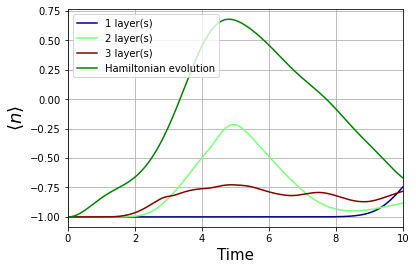

In [60]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(3):
    plt.plot(time_domain,expt_value_uu[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,expt_value_v, color = "g",label = "Hamiltonian evolution")

plt.ylabel(r"$\langle n\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)



In [28]:
#initial state
string = "2200"

psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [30]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)
expt_value_v = np.zeros(len(time_domain))
psi = psi_0
for tt in range(len(time_domain)):
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)




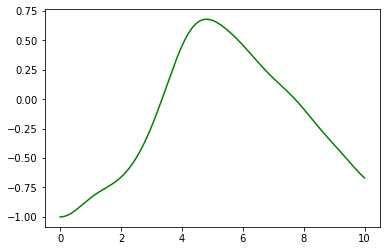

In [31]:
plt.plot(time_domain,expt_value_v, color = "g",label = "Hamiltonian evolution")

